In [1]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [2]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE


In [3]:
from resource import getrlimit, setrlimit, RLIMIT_NPROC

In [4]:
RLIMIT_NPROC

6

In [5]:
import resource
resource.setrlimit(resource.RLIMIT_NPROC, (16384, 16384))

In [6]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)
# Set maximum number of jobs for Scanpy.
sc.settings.njobs = 30

-----
anndata     0.8.0
scanpy      1.9.2
-----
MulticoreTSNE       NA
PIL                 9.4.0
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
cloudpickle         2.2.1
colorama            0.4.6
comm                0.1.2
cycler              0.10.0
cython_runtime      NA
cytoolz             0.12.1
dask                2023.2.0
dateutil            2.8.2
debugpy             1.6.6
decorator           5.1.1
executing           1.2.0
h5py                3.8.0
hypergeom_ufunc     NA
invgauss_ufunc      NA
ipykernel           6.21.2
jedi                0.18.2
jinja2              3.1.2
joblib              1.2.0
kiwisolver          1.4.4
llvmlite            0.39.1
loompy              3.0.7
markupsafe          2.1.2
matplotlib          3.7.0
mpl_toolkits        NA
natsort             8.2.0
nbinom_ufunc        NA
ncf_ufunc           NA
nct_ufunc           NA
ncx2_ufunc          NA
numba               0.56.4
numexpr         

In [7]:
sample = 'iGlut_pre'
adata = sc.read_h5ad("scanpy/"+sample+"_dr_clustered_raw_merged.h5ad")
meta = pd.read_csv("scanpy/"+sample+"_dr_clustered_raw_merged_meta.tsv",sep="\t",index_col=0)

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
import os
import glob
import pickle
import pandas as pd
import numpy as np

from dask.diagnostics import ProgressBar

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell

import seaborn as sns

DATA_FOLDER="~/tmp"
DATABASE_FOLDER = "/home/jjanssens/jjans/resources/resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based"
DATABASES_GLOB = os.path.join(DATABASE_FOLDER, "*.genes_vs_motifs.rankings.feather")
MOTIF_ANNOTATIONS_FNAME = '/home/jjanssens/jjans/resources/resources.aertslab.org/cistarget/motif2tf/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl'
HG_TFS_FNAME = '/home/jjanssens/jjans/resources/resources.aertslab.org/cistarget/tf_lists/allTFs_hg38.txt'




In [10]:
#load TF names
tf_names = load_tf_names(HG_TFS_FNAME)

In [11]:
#load databases
db_fnames = glob.glob(DATABASES_GLOB)
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
dbs

[FeatherRankingDatabase(name="hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings"),
 FeatherRankingDatabase(name="hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings")]

In [12]:
adata.obs['CellID'] = adata.obs.index

In [13]:
meta.columns

Index(['sample', 'species', 'gene_count', 'tscp_count', 'mread_count',
       'bc1_well', 'bc2_well', 'bc3_well', 'bc1_wind', 'bc2_wind', 'bc3_wind',
       'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'percent_mito',
       'n_counts', 'outlier', 'mt_outlier', 'doublet_score',
       'predicted_doublet', 'leiden_4', 'leiden_10', 'merged_clusters_from_10',
       'plateID', 'parse_id', 'AP_axis', 'DV_axis', 'Basal_media',
       'final_clustering', 'CycA', 'M_XAV', 'M_CHIR', 'M_RA', 'M_FGF8',
       'M_BMP4', 'M_SHH', 'M_PM', 'tSNE_1', 'tSNE_2', 'umap_1', 'umap_2'],
      dtype='object')

In [14]:
!mkdir pyscenic/{sample}

mkdir: cannot create directory 'pyscenic/iGlut_pre': File exists


In [ ]:
for i in range(3,21):
    import random
    random.seed(i)

    subset_cells = list(meta.groupby("final_clustering").sample(n=100,replace=True,random_state=i).index)
    subset_cells = list(set(subset_cells))

    adata_subset = adata[adata.obs['CellID'].isin(subset_cells)].copy()

    dgem = pd.DataFrame.sparse.from_spmatrix(adata_subset.X)
    dgem.index = adata_subset.obs.index
    dgem.columns = adata_subset.var_names

    tf_names = [x for x in tf_names if x in dgem.columns]


    from threadpoolctl import threadpool_info

    import pandas as pd
    from arboreto.utils import load_tf_names
    from arboreto.algo import grnboost2
    from distributed import LocalCluster, Client

    if __name__ == '__main__':
        # create custom LocalCluster and Client instances
        local_cluster = LocalCluster(n_workers=30,
                                     threads_per_worker=2,
                                     memory_limit=8e9)
        custom_client = Client(local_cluster)

        # load the data

        # run GRN inference multiple times
        adjacencies = grnboost2(expression_data=dgem,
                                tf_names=tf_names,
                                client_or_address=custom_client,
                                seed=i,
                                verbose=True)

        # close the Client and LocalCluster after use
        custom_client.close()
        local_cluster.close()

    with open('pyscenic/'+sample+'/adjacenies_'+str(i)+'.p', "wb") as f:
        pickle.dump(adjacencies, f)

    modules = list(modules_from_adjacencies(adjacencies, dgem))

    with open('pyscenic/'+sample+'/modules_'+str(i)+'.p', "wb") as f:
        pickle.dump(modules, f)

    # Calculate a list of enriched motifs and the corresponding target genes for all modules.
    with ProgressBar():
        df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)


    # Save the enriched motifs and the discovered regulons to disk.
    df.to_csv('pyscenic/'+sample+'/table_enriched_motifs_'+str(i)+'.csv')
    with open('pyscenic/'+sample+'/table_enriched_motifs_'+str(i)+'.p', "wb") as f:
        pickle.dump(df, f)

    # Create regulons from this table of enriched motifs.
    regulons = df2regulons(df)

    with open('pyscenic/'+sample+'/regulons_'+str(i)+'.p', "wb") as f:
        pickle.dump(regulons, f)


preparing dask client
parsing input
creating dask graph
30 partitions
computing dask graph


In [ ]:
for i in range(1,21):
    import random
    random.seed(i)

    subset_cells = list(meta.groupby("final_clustering").sample(n=100,replace=True,random_state=i).index)
    subset_cells = list(set(subset_cells))

    adata_subset = adata[adata.obs['CellID'].isin(subset_cells)].copy()

    dgem = pd.DataFrame.sparse.from_spmatrix(adata_subset.X)
    dgem.index = adata_subset.obs.index
    dgem.columns = adata_subset.var_names

    tf_names = [x for x in tf_names if x in dgem.columns]


    from threadpoolctl import threadpool_info

    import pandas as pd
    from arboreto.utils import load_tf_names
    from arboreto.algo import grnboost2
    from distributed import LocalCluster, Client

    if __name__ == '__main__':
        # create custom LocalCluster and Client instances
        local_cluster = LocalCluster(n_workers=30,
                                     threads_per_worker=2,
                                     memory_limit=8e9)
        custom_client = Client(local_cluster)

        # load the data

        # run GRN inference multiple times
        adjacencies = grnboost2(expression_data=dgem,
                                tf_names=tf_names,
                                client_or_address=custom_client,
                                seed=i,
                                verbose=True)

        # close the Client and LocalCluster after use
        custom_client.close()
        local_cluster.close()

    with open('pyscenic/'+sample+'/adjacenies_'+str(i)+'.p', "wb") as f:
        pickle.dump(adjacencies, f)

    modules = list(modules_from_adjacencies(adjacencies, dgem))

    with open('pyscenic/'+sample+'/modules_'+str(i)+'.p', "wb") as f:
        pickle.dump(modules, f)

    # Calculate a list of enriched motifs and the corresponding target genes for all modules.
    with ProgressBar():
        df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)


    # Save the enriched motifs and the discovered regulons to disk.
    df.to_csv('pyscenic/'+sample+'/table_enriched_motifs_'+str(i)+'.csv')
    with open('pyscenic/'+sample+'/table_enriched_motifs_'+str(i)+'.p', "wb") as f:
        pickle.dump(df, f)

    # Create regulons from this table of enriched motifs.
    regulons = df2regulons(df)

    with open('pyscenic/'+sample+'/regulons_'+str(i)+'.p', "wb") as f:
        pickle.dump(regulons, f)


preparing dask client
parsing input
creating dask graph
30 partitions
computing dask graph
not shutting down client, client was created externally
finished


/links/groups/treutlein/USERS/jjans/anaconda3/envs/pyscenic/lib/python3.10/site-packages/pyscenic/utils.py:305: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  ex_mtx = ex_mtx.T[~ex_mtx.columns.duplicated(keep="first")].T.astype(float)

2023-05-02 13:13:59,301 - pyscenic.utils - INFO - Calculating Pearson correlations.

2023-05-02 13:14:02,395 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting

[                                        ] | 0% Completed | 91.07 sms


2023-05-02 13:26:01,441 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:01,512 - pyscenic.transform - WARNING - Less than 80% of the genes in TRMO could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 91.77 s


2023-05-02 13:26:01,978 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:02,006 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:02,060 - pyscenic.transform - WARNING - Less than 80% of the genes in TRMT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:02,435 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MESP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 92.11 s


2023-05-02 13:26:02,490 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:02,579 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:02,590 - pyscenic.transform - WARNING - Less than 80% of the genes in TRPS1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 92.55 s


2023-05-02 13:26:02,989 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for METTL14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:03,108 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:03,129 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 92.65 s


2023-05-02 13:26:03,191 - pyscenic.transform - WARNING - Less than 80% of the genes in TSC22D4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 93.15 s


2023-05-02 13:26:03,535 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for METTL3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:03,718 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:03,735 - pyscenic.transform - WARNING - Less than 80% of the genes in TSN could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 93.26 s


2023-05-02 13:26:03,756 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 93.75 s


2023-05-02 13:26:04,257 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:04,265 - pyscenic.transform - WARNING - Less than 80% of the genes in TSNAX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:04,416 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4L1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 94.27 s


2023-05-02 13:26:04,588 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF467 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:04,812 - pyscenic.transform - WARNING - Less than 80% of the genes in TULP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:04,827 - pyscenic.transform - WARNING - Less than 80% of the genes in SMARCA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 94.58 s


2023-05-02 13:26:05,097 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4L5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:05,116 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF468 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:05,356 - pyscenic.transform - WARNING - Less than 80% of the genes in TWIST1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:05,417 - pyscenic.transform - WARNING - Less than 80% of the genes in SMARCA5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 95.18 s


2023-05-02 13:26:05,663 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF470 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:05,747 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXE1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 95.64 s


2023-05-02 13:26:05,911 - pyscenic.transform - WARNING - Less than 80% of the genes in TWIST2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:06,190 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF471 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 95.94 s


2023-05-02 13:26:06,401 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXE3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:06,460 - pyscenic.transform - WARNING - Less than 80% of the genes in U2AF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:06,510 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MIOS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 96.39 s


2023-05-02 13:26:06,788 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF48 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:07,003 - pyscenic.transform - WARNING - Less than 80% of the genes in UBB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:07,032 - pyscenic.transform - WARNING - Less than 80% of the genes in MAX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:07,042 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 97.03 s


2023-05-02 13:26:07,404 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF480 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:07,557 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MIXL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:07,566 - pyscenic.transform - WARNING - Less than 80% of the genes in UBE2K could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:07,594 - pyscenic.transform - WARNING - Less than 80% of the genes in MAZ could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 97.68 s


2023-05-02 13:26:07,854 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:08,036 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF483 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:08,145 - pyscenic.transform - WARNING - Less than 80% of the genes in UBE2V1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:08,164 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 98.35 s


2023-05-02 13:26:08,591 - pyscenic.transform - WARNING - Less than 80% of the genes in SMARCC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:08,642 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF484 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:08,712 - pyscenic.transform - WARNING - Less than 80% of the genes in UBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:08,759 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:08,915 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 98.87 s


2023-05-02 13:26:09,155 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MLX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:09,205 - pyscenic.transform - WARNING - Less than 80% of the genes in SMC3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:09,226 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF485 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:09,301 - pyscenic.transform - WARNING - Less than 80% of the genes in UBTF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 99.18 s


2023-05-02 13:26:09,582 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXH1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:09,675 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MLXIP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 99.38 s


2023-05-02 13:26:09,799 - pyscenic.transform - WARNING - Less than 80% of the genes in SMPX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:09,863 - pyscenic.transform - WARNING - Less than 80% of the genes in UBXN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:09,865 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF486 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 99.58 s


2023-05-02 13:26:10,000 - pyscenic.transform - WARNING - Less than 80% of the genes in MBNL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 99.79 s


2023-05-02 13:26:10,208 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:10,214 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MLXIPL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 99.99 s


2023-05-02 13:26:10,457 - pyscenic.transform - WARNING - Less than 80% of the genes in UGP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:10,459 - pyscenic.transform - WARNING - Less than 80% of the genes in SMUG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:10,570 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF487 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:10,598 - pyscenic.transform - WARNING - Less than 80% of the genes in MBTPS2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 100.60 s


2023-05-02 13:26:10,979 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:11,006 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP92 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:11,016 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:11,032 - pyscenic.transform - WARNING - Less than 80% of the genes in UNCX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 100.80 s


2023-05-02 13:26:11,253 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:11,254 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF490 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 101.00 s


2023-05-02 13:26:11,467 - pyscenic.transform - WARNING - Less than 80% of the genes in MCTP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:11,503 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:11,573 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFPM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:11,581 - pyscenic.transform - WARNING - Less than 80% of the genes in UQCRB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 101.41 s


2023-05-02 13:26:11,820 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MORN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:11,869 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF491 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:11,889 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 101.61 s


2023-05-02 13:26:12,025 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:12,188 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 101.81 s


2023-05-02 13:26:12,280 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:12,350 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MRPL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:12,393 - pyscenic.transform - WARNING - Less than 80% of the genes in USF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 102.02 s


2023-05-02 13:26:12,488 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF492 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:12,507 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:12,574 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 102.32 s


2023-05-02 13:26:12,715 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFY could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:12,859 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MRPL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 102.63 s


2023-05-02 13:26:13,085 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAPC4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:13,169 - pyscenic.transform - WARNING - Less than 80% of the genes in USF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:13,191 - pyscenic.transform - WARNING - Less than 80% of the genes in DNAJC21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:13,266 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 102.83 s


2023-05-02 13:26:13,300 - pyscenic.transform - WARNING - Less than 80% of the genes in ZGPAT could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:13,339 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:13,396 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MRPS25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:13,424 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF493 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 103.23 s


2023-05-02 13:26:13,663 - pyscenic.transform - WARNING - Less than 80% of the genes in MDM2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:13,681 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAPC5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:13,712 - pyscenic.transform - WARNING - Less than 80% of the genes in USP39 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:13,841 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 103.44 s


2023-05-02 13:26:13,909 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSANTD3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:14,107 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 103.74 s


2023-05-02 13:26:14,127 - pyscenic.transform - WARNING - Less than 80% of the genes in DNMT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:14,243 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF496 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:14,257 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:14,269 - pyscenic.transform - WARNING - Less than 80% of the genes in UTP18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 103.94 s


2023-05-02 13:26:14,378 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:14,442 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 104.35 s


2023-05-02 13:26:14,818 - pyscenic.transform - WARNING - Less than 80% of the genes in VAMP3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:14,844 - pyscenic.transform - WARNING - Less than 80% of the genes in DNMT3A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:14,851 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:14,891 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:14,916 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 104.96 s


2023-05-02 13:26:15,371 - pyscenic.transform - WARNING - Less than 80% of the genes in EMX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:15,372 - pyscenic.transform - WARNING - Less than 80% of the genes in VAX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:15,443 - pyscenic.transform - WARNING - Less than 80% of the genes in DNTTIP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:15,444 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN5A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:15,503 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 105.36 s


2023-05-02 13:26:15,794 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:15,859 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF425 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:15,862 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF500 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:15,914 - pyscenic.transform - WARNING - Less than 80% of the genes in EMX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:15,972 - pyscenic.transform - WARNING - Less than 80% of the genes in SNRNP70 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 105.57 s


2023-05-02 13:26:15,996 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN5C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:16,021 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:16,056 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:16,155 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSRA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:16,187 - pyscenic.transform - WARNING - Less than 80% of the genes in VAX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 105.97 s


2023-05-02 13:26:16,389 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF426 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:16,533 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:16,548 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIC3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:16,550 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF501 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:16,582 - pyscenic.transform - WARNING - Less than 80% of the genes in SNRPB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 106.28 s


2023-05-02 13:26:16,665 - pyscenic.transform - WARNING - Less than 80% of the genes in EN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:16,733 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:16,753 - pyscenic.transform - WARNING - Less than 80% of the genes in VDR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:16,788 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 106.48 s


2023-05-02 13:26:16,901 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF429 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:17,054 - pyscenic.transform - WARNING - Less than 80% of the genes in MECOM could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:17,082 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIC4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 106.68 s


2023-05-02 13:26:17,121 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSWIM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:17,249 - pyscenic.transform - WARNING - Less than 80% of the genes in SOCS4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:17,265 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF502 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:17,307 - pyscenic.transform - WARNING - Less than 80% of the genes in VENTX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:17,309 - pyscenic.transform - WARNING - Less than 80% of the genes in EN2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 106.99 s


2023-05-02 13:26:17,390 - pyscenic.transform - WARNING - Less than 80% of the genes in DPRX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:17,405 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:17,416 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:17,426 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF43 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 107.19 s


2023-05-02 13:26:17,604 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIC5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:17,702 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 107.39 s


2023-05-02 13:26:17,835 - pyscenic.transform - WARNING - Less than 80% of the genes in VEZF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:17,871 - pyscenic.transform - WARNING - Less than 80% of the genes in SOD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:17,936 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF430 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:17,940 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:17,955 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF503 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 107.70 s


2023-05-02 13:26:18,110 - pyscenic.transform - WARNING - Less than 80% of the genes in DR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:18,149 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIK1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:18,275 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:18,284 - pyscenic.transform - WARNING - Less than 80% of the genes in MECP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 107.90 s


2023-05-02 13:26:18,373 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXN2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:18,373 - pyscenic.transform - WARNING - Less than 80% of the genes in VPS4B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:18,469 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTA3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:18,508 - pyscenic.transform - WARNING - Less than 80% of the genes in SOHLH2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 108.20 s


2023-05-02 13:26:18,667 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF431 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:18,676 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIM2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:18,758 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:18,799 - pyscenic.transform - WARNING - Less than 80% of the genes in DRAP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 108.51 s


2023-05-02 13:26:18,912 - pyscenic.transform - WARNING - Less than 80% of the genes in VPS72 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:18,928 - pyscenic.transform - WARNING - Less than 80% of the genes in EOMES could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:18,948 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:18,994 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTERF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:19,000 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF506 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 108.71 s


2023-05-02 13:26:19,128 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:19,150 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:19,152 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF432 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:19,219 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 109.12 s


2023-05-02 13:26:19,518 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:19,528 - pyscenic.transform - WARNING - Less than 80% of the genes in DRGX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:19,654 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF433 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:19,680 - pyscenic.transform - WARNING - Less than 80% of the genes in GATAD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:19,715 - pyscenic.transform - WARNING - Less than 80% of the genes in EP300 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Sk

[                                        ] | 0% Completed | 109.32 s


2023-05-02 13:26:19,733 - pyscenic.transform - WARNING - Less than 80% of the genes in VSX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:19,765 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:19,838 - pyscenic.transform - WARNING - Less than 80% of the genes in ZZZ3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 109.52 s


2023-05-02 13:26:19,998 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF507 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:20,094 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:20,158 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 109.83 s


2023-05-02 13:26:20,301 - pyscenic.transform - WARNING - Less than 80% of the genes in VSX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:20,314 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:20,371 - pyscenic.transform - WARNING - Less than 80% of the genes in EPAS1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:20,380 - pyscenic.transform - WARNING - Less than 80% of the genes in STAU2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:20,393 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF436 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. 

[                                        ] | 0% Completed | 110.13 s


2023-05-02 13:26:20,603 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTHFD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:20,801 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIL3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 110.43 s


2023-05-02 13:26:20,859 - pyscenic.transform - WARNING - Less than 80% of the genes in DTL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:20,863 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:20,869 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:20,878 - pyscenic.transform - WARNING - Less than 80% of the genes in WDR83 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:20,883 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX3-2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 110.74 s


2023-05-02 13:26:21,154 - pyscenic.transform - WARNING - Less than 80% of the genes in ERF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:21,158 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MXD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 110.94 s


2023-05-02 13:26:21,385 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:21,411 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:21,448 - pyscenic.transform - WARNING - Less than 80% of the genes in WRNIP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:21,460 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF439 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:21,466 - pyscenic.transform - WARNING - Less than 80% of the genes in STUB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.

[                                        ] | 0% Completed | 111.15 s


2023-05-02 13:26:21,597 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF511 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:21,630 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF600 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 111.55 s


2023-05-02 13:26:21,967 - pyscenic.transform - WARNING - Less than 80% of the genes in ERG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:21,971 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:21,972 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX6-2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:21,982 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF44 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:22,038 - pyscenic.transform - WARNING - Less than 80% of the genes in SUCLG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 111.75 s


2023-05-02 13:26:22,196 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX13 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:22,233 - pyscenic.transform - WARNING - Less than 80% of the genes in WT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:22,235 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF605 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:22,297 - pyscenic.transform - WARNING - Less than 80% of the genes in DUSP22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:22,324 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 112.06 s


2023-05-02 13:26:22,522 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:22,522 - pyscenic.transform - WARNING - Less than 80% of the genes in NFKB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:22,522 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF440 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:22,535 - pyscenic.transform - WARNING - Less than 80% of the genes in ESR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:22,592 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 112.26 s


2023-05-02 13:26:22,727 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NME1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:22,771 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF512 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:22,779 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MXI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:22,794 - pyscenic.transform - WARNING - Less than 80% of the genes in XBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:22,841 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_

[                                        ] | 0% Completed | 112.46 s


2023-05-02 13:26:22,928 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF606 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:23,058 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF441 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:23,074 - pyscenic.transform - WARNING - Less than 80% of the genes in DUSP26 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:23,078 - pyscenic.transform - WARNING - Less than 80% of the genes in ZMAT2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:23,093 - pyscenic.transform - WARNING - Less than 80% of the genes in ESR2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 112.67 s


2023-05-02 13:26:23,138 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF1A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:23,198 - pyscenic.transform - WARNING - Less than 80% of the genes in NFKB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:23,268 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF585A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:23,270 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NMI could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:23,313 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 112.97 s


2023-05-02 13:26:23,357 - pyscenic.transform - WARNING - Less than 80% of the genes in XG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:23,428 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX15 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:23,507 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF513 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 113.17 s


2023-05-02 13:26:23,576 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF607 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:23,585 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF442 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:23,638 - pyscenic.transform - WARNING - Less than 80% of the genes in ZMAT4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:23,649 - pyscenic.transform - WARNING - Less than 80% of the genes in DUXA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:23,661 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 113.38 s


2023-05-02 13:26:23,817 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NMRAL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:23,929 - pyscenic.transform - WARNING - Less than 80% of the genes in XPA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 113.58 s


2023-05-02 13:26:24,037 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF585B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:24,038 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:24,132 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF443 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:24,135 - pyscenic.transform - WARNING - Less than 80% of the genes in NFX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:24,205 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. 

[                                        ] | 0% Completed | 113.78 s


2023-05-02 13:26:24,243 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:24,253 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:24,269 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF610 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:24,285 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF514 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:24,320 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX17 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 114.09 s


2023-05-02 13:26:24,469 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:24,486 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:24,528 - pyscenic.transform - WARNING - Less than 80% of the genes in XRCC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:24,618 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF586 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 114.29 s


2023-05-02 13:26:24,693 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:24,807 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:24,812 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:24,868 - pyscenic.transform - WARNING - Less than 80% of the genes in NFXL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 114.49 s


2023-05-02 13:26:24,940 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:24,942 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF445 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:24,950 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NOBOX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:24,965 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:25,031 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 114.80 s


2023-05-02 13:26:25,180 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF587 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:25,211 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 115.10 s


2023-05-02 13:26:25,503 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYCL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:25,508 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:25,512 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF449 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:25,526 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:25,571 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 115.31 s


2023-05-02 13:26:25,731 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF587B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:25,753 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:25,768 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:25,792 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 115.61 s


2023-05-02 13:26:26,048 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYCN could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:26,071 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF45 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:26,088 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:26,138 - pyscenic.transform - WARNING - Less than 80% of the genes in MXI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:26,158 - pyscenic.transform - WARNING - Less than 80% of the genes in TAGLN2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 115.81 s


2023-05-02 13:26:26,260 - pyscenic.transform - WARNING - Less than 80% of the genes in YOD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:26,263 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:26,305 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF107 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:26,315 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF589 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:26,329 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 116.02 s


2023-05-02 13:26:26,480 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:26,627 - pyscenic.transform - WARNING - Less than 80% of the genes in ETFB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:26,648 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF451 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:26,649 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NOTO could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 116.42 s


2023-05-02 13:26:26,850 - pyscenic.transform - WARNING - Less than 80% of the genes in YWHAE could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:26,872 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:26,879 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:26,888 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF592 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:26,899 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF112 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 116.83 s


2023-05-02 13:26:27,209 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF454 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:27,246 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF613 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:27,247 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 117.03 s


2023-05-02 13:26:27,428 - pyscenic.transform - WARNING - Less than 80% of the genes in IL21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:27,470 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF594 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:27,479 - pyscenic.transform - WARNING - Less than 80% of the genes in YWHAZ could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:27,480 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:27,486 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF114 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Sk

[                                        ] | 0% Completed | 117.23 s


2023-05-02 13:26:27,691 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYNN could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:27,711 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:27,755 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF460 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:27,763 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:27,817 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 117.54 s


2023-05-02 13:26:27,928 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:27,947 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF614 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:27,996 - pyscenic.transform - WARNING - Less than 80% of the genes in ILF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:28,065 - pyscenic.transform - WARNING - Less than 80% of the genes in MYBL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:28,066 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF595 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 117.74 s


2023-05-02 13:26:28,212 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:28,243 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYPOP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:28,249 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:28,259 - pyscenic.transform - WARNING - Less than 80% of the genes in GLIS3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:28,287 - pyscenic.transform - WARNING - Less than 80% of the genes in YY1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rank

[                                        ] | 0% Completed | 118.05 s


2023-05-02 13:26:28,453 - pyscenic.transform - WARNING - Less than 80% of the genes in TBP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:28,504 - pyscenic.transform - WARNING - Less than 80% of the genes in NHLH1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:28,617 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF615 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:28,639 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF596 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 118.25 s


2023-05-02 13:26:28,668 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:28,757 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHTF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:28,768 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:28,768 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYRF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:28,773 - pyscenic.transform - WARNING - Less than 80% of the genes in MYC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs

[                                        ] | 0% Completed | 118.45 s


2023-05-02 13:26:28,873 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for METTL14 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:28,975 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR0B1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:29,027 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:29,038 - pyscenic.transform - WARNING - Less than 80% of the genes in TBPL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:29,039 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXA3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 118.76 s


2023-05-02 13:26:29,189 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:29,227 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF597 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:29,247 - pyscenic.transform - WARNING - Less than 80% of the genes in NHLH2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:29,247 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF121 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:29,314 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 118.96 s


2023-05-02 13:26:29,413 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:29,425 - pyscenic.transform - WARNING - Less than 80% of the genes in GMEB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:29,444 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for METTL3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:29,447 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:29,454 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PICK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 119.16 s


2023-05-02 13:26:29,622 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:29,625 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:29,628 - pyscenic.transform - WARNING - Less than 80% of the genes in TBPL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:29,651 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:29,692 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXO4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 119.47 s


2023-05-02 13:26:29,877 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF124 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:29,922 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX1-1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:29,988 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:29,998 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF467 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:30,028 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. 

[                                        ] | 0% Completed | 119.67 s


2023-05-02 13:26:30,079 - pyscenic.transform - WARNING - Less than 80% of the genes in GMEB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:30,083 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NAGS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:30,093 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCN could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:30,103 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:30,110 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1D2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 119.87 s


2023-05-02 13:26:30,298 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:30,389 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF599 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:30,476 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF131 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:30,491 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 120.18 s


2023-05-02 13:26:30,557 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:30,592 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF468 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:30,622 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX1-2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:30,633 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NANOG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:30,656 - pyscenic.transform - WARNING - Less than 80% of the genes in GOT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 120.38 s


2023-05-02 13:26:30,768 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:30,791 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFY could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:30,810 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PIR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:30,818 - pyscenic.transform - WARNING - Less than 80% of the genes in HDAC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:30,825 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.ranki

[                                        ] | 0% Completed | 120.58 s


2023-05-02 13:26:30,978 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:30,996 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:31,012 - pyscenic.transform - WARNING - Less than 80% of the genes in STAU2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:31,014 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:31,046 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF132 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 120.79 s


2023-05-02 13:26:31,232 - pyscenic.transform - WARNING - Less than 80% of the genes in GPAM could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:31,254 - pyscenic.transform - WARNING - Less than 80% of the genes in MYLK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:31,254 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1H3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:31,283 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:31,311 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX18 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_c

[                                        ] | 0% Completed | 120.99 s


2023-05-02 13:26:31,452 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX15 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:31,458 - pyscenic.transform - WARNING - Less than 80% of the genes in ZGPAT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:31,529 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF605 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:31,569 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:31,578 - pyscenic.transform - WARNING - Less than 80% of the genes in STK40 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 121.19 s


2023-05-02 13:26:31,664 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF621 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:31,671 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PITX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:31,679 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:31,679 - pyscenic.transform - WARNING - Less than 80% of the genes in PRKAA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:31,695 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEF2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 121.50 s


2023-05-02 13:26:31,875 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF133 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:31,900 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:31,921 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:31,948 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:31,949 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NANOS1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 121.70 s


2023-05-02 13:26:32,112 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF606 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:32,117 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIF3A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:32,139 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:32,141 - pyscenic.transform - WARNING - Less than 80% of the genes in STUB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:32,236 - pyscenic.transform - WARNING - Less than 80% of the genes in PRKAA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 121.90 s


2023-05-02 13:26:32,313 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:32,335 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF48 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:32,383 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:32,405 - pyscenic.transform - WARNING - Less than 80% of the genes in GPBP1L1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:32,407 - pyscenic.transform - WARNING - Less than 80% of the genes in MYPOP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 122.10 s


2023-05-02 13:26:32,572 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:32,616 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:32,644 - pyscenic.transform - WARNING - Less than 80% of the genes in HDAC8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:32,654 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1I2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:32,674 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF607 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 122.41 s


2023-05-02 13:26:32,801 - pyscenic.transform - WARNING - Less than 80% of the genes in PRNP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:32,803 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:32,841 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MIOS could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:32,877 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN5A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:32,883 - pyscenic.transform - WARNING - Less than 80% of the genes in DNMT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 122.61 s


2023-05-02 13:26:33,008 - pyscenic.transform - WARNING - Less than 80% of the genes in MYRF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:33,009 - pyscenic.transform - WARNING - Less than 80% of the genes in GPD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:33,016 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:33,026 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:33,042 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF135 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Ski

[                                        ] | 0% Completed | 122.81 s


2023-05-02 13:26:33,227 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1I3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:33,245 - pyscenic.transform - WARNING - Less than 80% of the genes in HDX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:33,267 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF610 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:33,290 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:33,290 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 123.02 s


2023-05-02 13:26:33,442 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN5C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:33,443 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX30 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:33,470 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:33,477 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:33,484 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF483 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 123.22 s


2023-05-02 13:26:33,687 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEF2D could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:33,743 - pyscenic.transform - WARNING - Less than 80% of the genes in DNMT3A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:33,776 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX2-6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:33,784 - pyscenic.transform - WARNING - Less than 80% of the genes in MZF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:33,789 - pyscenic.transform - WARNING - Less than 80% of the genes in SMARCA5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 123.42 s


2023-05-02 13:26:33,897 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF136 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:33,909 - pyscenic.transform - WARNING - Less than 80% of the genes in PROX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:33,927 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF30 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:33,940 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MIXL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:34,002 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 123.73 s


2023-05-02 13:26:34,164 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF624 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:34,183 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:34,209 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:34,246 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PKM could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:34,262 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB16 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 124.04 s


2023-05-02 13:26:34,420 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF1L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:34,421 - pyscenic.transform - WARNING - Less than 80% of the genes in HES2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:34,442 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:34,442 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4L5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:34,444 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX3-1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 124.24 s


2023-05-02 13:26:34,625 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF485 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:34,648 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:34,649 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 124.44 s


2023-05-02 13:26:34,837 - pyscenic.transform - WARNING - Less than 80% of the genes in SP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:34,844 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB17 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:34,848 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:34,861 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PKNOX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:34,892 - pyscenic.transform - WARNING - Less than 80% of the genes in EXO5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 124.65 s


2023-05-02 13:26:35,054 - pyscenic.transform - WARNING - Less than 80% of the genes in PRRX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:35,061 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF302 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:35,067 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:35,150 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:35,194 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF486 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 124.85 s


2023-05-02 13:26:35,272 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:35,315 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX3-2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:35,427 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:35,429 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF625 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:35,432 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 125.05 s


2023-05-02 13:26:35,481 - pyscenic.transform - WARNING - Less than 80% of the genes in EZH2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:35,487 - pyscenic.transform - WARNING - Less than 80% of the genes in MELK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:35,523 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIC3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:35,535 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2E3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:35,596 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXE3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ran

[                                        ] | 0% Completed | 125.36 s


2023-05-02 13:26:35,789 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF487 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:35,794 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:35,819 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MLX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:35,825 - pyscenic.transform - WARNING - Less than 80% of the genes in HES5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:35,866 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rank

[                                        ] | 0% Completed | 125.56 s


2023-05-02 13:26:36,016 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:36,018 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:36,038 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:36,088 - pyscenic.transform - WARNING - Less than 80% of the genes in EZR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:36,167 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX6-1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipp

[                                        ] | 0% Completed | 125.86 s


2023-05-02 13:26:36,258 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:36,268 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF141 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:36,334 - pyscenic.transform - WARNING - Less than 80% of the genes in SP110 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:36,364 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MLXIP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:36,367 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 126.07 s


2023-05-02 13:26:36,477 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:36,503 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PLAG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:36,507 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOS1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:36,590 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:36,622 - pyscenic.transform - WARNING - Less than 80% of the genes in MEOX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 126.27 s


2023-05-02 13:26:36,691 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2F2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:36,725 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB20 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:36,738 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF626 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:36,740 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF316 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:36,757 - pyscenic.transform - WARNING - Less than 80% of the genes in PSMC2 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 126.47 s


2023-05-02 13:26:36,919 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MLXIPL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:36,936 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NELFA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:36,949 - pyscenic.transform - WARNING - Less than 80% of the genes in TAGLN2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:36,994 - pyscenic.transform - WARNING - Less than 80% of the genes in HES7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:37,018 - pyscenic.transform - WARNING - Less than 80% of the genes in SP140 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 126.78 s


2023-05-02 13:26:37,197 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF491 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:37,217 - pyscenic.transform - WARNING - Less than 80% of the genes in FANK1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:37,224 - pyscenic.transform - WARNING - Less than 80% of the genes in ZZZ3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:37,252 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:37,307 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF317 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 126.98 s


2023-05-02 13:26:37,399 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2A1L could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:37,425 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:37,437 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GADD45A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:37,458 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF143 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:37,508 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2F6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 127.18 s


2023-05-02 13:26:37,623 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:37,644 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:37,645 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:37,683 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:37,710 - pyscenic.transform - WARNING - Less than 80% of the genes in SP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rank

[                                        ] | 0% Completed | 127.39 s


2023-05-02 13:26:37,835 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:37,870 - pyscenic.transform - WARNING - Less than 80% of the genes in A1CF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:37,872 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF319 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:37,884 - pyscenic.transform - WARNING - Less than 80% of the genes in PTCD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:37,889 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 127.69 s


2023-05-02 13:26:38,144 - pyscenic.transform - WARNING - Less than 80% of the genes in SMPX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:38,183 - pyscenic.transform - WARNING - Less than 80% of the genes in HEY1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:38,215 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:38,218 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXH1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:38,221 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PLAGL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 127.89 s


2023-05-02 13:26:38,372 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:38,397 - pyscenic.transform - WARNING - Less than 80% of the genes in SP3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:38,445 - pyscenic.transform - WARNING - Less than 80% of the genes in PTF1A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:38,469 - pyscenic.transform - WARNING - Less than 80% of the genes in ABCF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:38,472 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB24 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 128.20 s


2023-05-02 13:26:38,587 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MORN1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:38,601 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF32 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:38,611 - pyscenic.transform - WARNING - Less than 80% of the genes in DRAP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:38,623 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:38,667 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF628 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 128.40 s


2023-05-02 13:26:38,797 - pyscenic.transform - WARNING - Less than 80% of the genes in HEY2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:38,797 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:38,818 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:38,819 - pyscenic.transform - WARNING - Less than 80% of the genes in SMUG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:38,823 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PLG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rank

[                                        ] | 0% Completed | 128.60 s


2023-05-02 13:26:39,019 - pyscenic.transform - WARNING - Less than 80% of the genes in PTPMT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:39,048 - pyscenic.transform - WARNING - Less than 80% of the genes in SP4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:39,058 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:39,128 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MRPL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:39,144 - pyscenic.transform - WARNING - Less than 80% of the genes in TCEAL6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 128.81 s


2023-05-02 13:26:39,238 - pyscenic.transform - WARNING - Less than 80% of the genes in NMRAL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:39,240 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:39,255 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:39,290 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HLF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:39,315 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 129.01 s


2023-05-02 13:26:39,441 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:39,483 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFXANK could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:39,488 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PML could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:39,517 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF500 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:39,535 - pyscenic.transform - WARNING - Less than 80% of the genes in DRGX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 129.21 s


2023-05-02 13:26:39,666 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MRPL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:39,699 - pyscenic.transform - WARNING - Less than 80% of the genes in SP5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:39,701 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEIS3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:39,730 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF624 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:39,818 - pyscenic.transform - WARNING - Less than 80% of the genes in MESP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 129.52 s


2023-05-02 13:26:39,913 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR4A1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:39,925 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF154 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:39,943 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JRK could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:39,959 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP110 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:39,967 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 129.72 s


2023-05-02 13:26:40,155 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HLTF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:40,185 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:40,210 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB32 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:40,225 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MRPS25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:40,268 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFXAP could be mapped to hg38_500bp_up_100bp_

[                                        ] | 0% Completed | 129.92 s


2023-05-02 13:26:40,383 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF630 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:40,433 - pyscenic.transform - WARNING - Less than 80% of the genes in PURA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:40,455 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR4A2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:40,457 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2I could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:40,494 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP140 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 130.13 s


2023-05-02 13:26:40,597 - pyscenic.transform - WARNING - Less than 80% of the genes in HHEX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:40,632 - pyscenic.transform - WARNING - Less than 80% of the genes in TBPL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:40,641 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:40,704 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLE3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:40,726 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF502 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 130.43 s


2023-05-02 13:26:40,818 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RHOXF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:40,830 - pyscenic.transform - WARNING - Less than 80% of the genes in METTL14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:40,835 - pyscenic.transform - WARNING - Less than 80% of the genes in ACO1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:40,916 - pyscenic.transform - WARNING - Less than 80% of the genes in DTL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:40,924 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF626 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 130.63 s


2023-05-02 13:26:41,025 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR4A3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:41,027 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:41,054 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:41,131 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF639 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:41,150 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF324B could be mapped to hg38_500bp_up_100bp

[                                        ] | 0% Completed | 130.84 s


2023-05-02 13:26:41,228 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JUN could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:41,235 - pyscenic.transform - WARNING - Less than 80% of the genes in ISL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:41,243 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:41,246 - pyscenic.transform - WARNING - Less than 80% of the genes in TBR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:41,294 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLE4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs

[                                        ] | 0% Completed | 131.04 s


2023-05-02 13:26:41,429 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXN1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:41,497 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:41,576 - pyscenic.transform - WARNING - Less than 80% of the genes in R3HDM2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 131.24 s


2023-05-02 13:26:41,640 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF3A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:41,643 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF524 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:41,670 - pyscenic.transform - WARNING - Less than 80% of the genes in SP8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:41,711 - pyscenic.transform - WARNING - Less than 80% of the genes in DUS3L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:41,751 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF627 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 131.45 s


2023-05-02 13:26:41,846 - pyscenic.transform - WARNING - Less than 80% of the genes in ISL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:41,861 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF641 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:41,866 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF506 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:41,888 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF16 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:41,927 - pyscenic.transform - WARNING - Less than 80% of the genes in FIZ1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 131.65 s


2023-05-02 13:26:42,061 - pyscenic.transform - WARNING - Less than 80% of the genes in METTL3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:42,103 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:42,140 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:42,148 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB14 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:42,222 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOR2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 131.85 s


2023-05-02 13:26:42,298 - pyscenic.transform - WARNING - Less than 80% of the genes in SP9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:42,320 - pyscenic.transform - WARNING - Less than 80% of the genes in ADARB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:42,342 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF628 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:42,358 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEOX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:42,429 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF507 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 132.05 s


2023-05-02 13:26:42,502 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RNASEH2C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:42,503 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX15 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:42,560 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB38 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:42,567 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMG20A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:42,587 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust

[                                        ] | 0% Completed | 132.26 s


2023-05-02 13:26:42,710 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXN2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:42,719 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB18 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:42,744 - pyscenic.transform - WARNING - Less than 80% of the genes in FLI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:42,757 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:42,799 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JUND could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 132.46 s


2023-05-02 13:26:42,922 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF629 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:42,939 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF525 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:42,944 - pyscenic.transform - WARNING - Less than 80% of the genes in SPAG7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:42,968 - pyscenic.transform - WARNING - Less than 80% of the genes in NONO could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:42,988 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSRA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 132.66 s


2023-05-02 13:26:43,124 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX18 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:43,126 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF165 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:43,152 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:43,160 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB39 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:43,178 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMG20B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 132.87 s


2023-05-02 13:26:43,328 - pyscenic.transform - WARNING - Less than 80% of the genes in MEX3C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:43,419 - pyscenic.transform - WARNING - Less than 80% of the genes in NELFB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:43,426 - pyscenic.transform - WARNING - Less than 80% of the genes in GTPBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:43,431 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:43,473 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KAT7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 133.07 s


2023-05-02 13:26:43,532 - pyscenic.transform - WARNING - Less than 80% of the genes in FOS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:43,558 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:43,579 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF511 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:43,598 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RNF138 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:43,661 - pyscenic.transform - WARNING - Less than 80% of the genes in SPATS2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 133.27 s


2023-05-02 13:26:43,732 - pyscenic.transform - WARNING - Less than 80% of the genes in NOTO could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:43,733 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF526 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:43,739 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF169 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:43,739 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX19 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:43,750 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 133.58 s


2023-05-02 13:26:44,003 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXN1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:44,012 - pyscenic.transform - WARNING - Less than 80% of the genes in GTPBP6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:44,028 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MESP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:44,034 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:44,035 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NRL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 133.78 s


2023-05-02 13:26:44,219 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:44,249 - pyscenic.transform - WARNING - Less than 80% of the genes in SNRNP70 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:44,271 - pyscenic.transform - WARNING - Less than 80% of the genes in ZMAT2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:44,275 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:44,300 - pyscenic.transform - WARNING - Less than 80% of the genes in SPDEF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 133.98 s


2023-05-02 13:26:44,460 - pyscenic.transform - WARNING - Less than 80% of the genes in RAD21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:44,515 - pyscenic.transform - WARNING - Less than 80% of the genes in HIRIP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:44,561 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF527 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:44,581 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NUCB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:44,611 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXN2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 134.19 s


2023-05-02 13:26:44,666 - pyscenic.transform - WARNING - Less than 80% of the genes in JDP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:44,670 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:44,683 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF641 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:44,730 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF513 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:44,740 - pyscenic.transform - WARNING - Less than 80% of the genes in DUXA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 134.49 s


2023-05-02 13:26:44,889 - pyscenic.transform - WARNING - Less than 80% of the genes in SNRPB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:44,902 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:44,925 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF174 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:44,926 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB41 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:44,933 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX20 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.

[                                        ] | 0% Completed | 134.69 s


2023-05-02 13:26:45,102 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:45,117 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NUP107 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:45,184 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:45,196 - pyscenic.transform - WARNING - Less than 80% of the genes in HADHB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:45,202 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 134.90 s


2023-05-02 13:26:45,368 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GBX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:45,381 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF644 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:45,488 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:45,523 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:45,531 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB43 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 135.10 s


2023-05-02 13:26:45,577 - pyscenic.transform - WARNING - Less than 80% of the genes in SOCS4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:45,578 - pyscenic.transform - WARNING - Less than 80% of the genes in MGA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:45,589 - pyscenic.transform - WARNING - Less than 80% of the genes in SPIB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:45,590 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF528 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:45,604 - pyscenic.transform - WARNING - Less than 80% of the genes in NPAS4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 135.40 s


2023-05-02 13:26:45,792 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RPL35 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:45,829 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7L2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:45,850 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:45,888 - pyscenic.transform - WARNING - Less than 80% of the genes in HAND1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:45,904 - pyscenic.transform - WARNING - Less than 80% of the genes in JRKL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 135.61 s


2023-05-02 13:26:46,041 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROG2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:46,057 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:46,120 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:46,123 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB44 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:46,175 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 135.81 s


2023-05-02 13:26:46,271 - pyscenic.transform - WARNING - Less than 80% of the genes in SPIC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:46,350 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:46,368 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RPL6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:46,383 - pyscenic.transform - WARNING - Less than 80% of the genes in NPDC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:46,398 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXN4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ran

[                                        ] | 0% Completed | 136.01 s


2023-05-02 13:26:46,482 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF517 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:46,545 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPDEF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:46,547 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF648 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:46,663 - pyscenic.transform - WARNING - Less than 80% of the genes in MIEF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 136.22 s


2023-05-02 13:26:46,693 - pyscenic.transform - WARNING - Less than 80% of the genes in HAND2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:46,712 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:46,718 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for METTL3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:46,726 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB45 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:46,737 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ODC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 136.52 s


2023-05-02 13:26:46,916 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF34 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:46,919 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RPP25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:46,941 - pyscenic.transform - WARNING - Less than 80% of the genes in SPR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:46,944 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:46,951 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 136.72 s


2023-05-02 13:26:47,127 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:47,131 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF649 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:47,141 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:47,184 - pyscenic.transform - WARNING - Less than 80% of the genes in NR0B1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:47,284 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OLIG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 136.93 s


2023-05-02 13:26:47,336 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB46 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:47,347 - pyscenic.transform - WARNING - Less than 80% of the genes in HLCS could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:47,388 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:47,419 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXA3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:47,432 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTHFD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 137.13 s


2023-05-02 13:26:47,565 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF101 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:47,613 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:47,642 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF530 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:47,659 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF180 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:47,672 - pyscenic.transform - WARNING - Less than 80% of the genes in MIOS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 137.33 s


2023-05-02 13:26:47,806 - pyscenic.transform - WARNING - Less than 80% of the genes in RAX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:47,822 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM4A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:47,827 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OLIG2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:47,894 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEX3C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:47,908 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1D1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_

[                                        ] | 0% Completed | 137.64 s


2023-05-02 13:26:48,016 - pyscenic.transform - WARNING - Less than 80% of the genes in EDN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:48,049 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF343 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:48,061 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GFI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:48,140 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF519 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:48,142 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPIB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 137.84 s


2023-05-02 13:26:48,249 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:48,252 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF181 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:48,304 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:48,332 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF653 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:48,358 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 138.04 s


2023-05-02 13:26:48,496 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMGB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:48,511 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF107 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:48,532 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:48,540 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB48 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:48,540 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 138.35 s


2023-05-02 13:26:48,761 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1D2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:48,786 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:48,842 - pyscenic.transform - WARNING - Less than 80% of the genes in HLTF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:48,897 - pyscenic.transform - WARNING - Less than 80% of the genes in MITF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:48,898 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skip

[                                        ] | 0% Completed | 138.55 s


2023-05-02 13:26:49,016 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPIC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:49,021 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF521 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:49,042 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX11 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:49,073 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:49,109 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF182 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 138.85 s


2023-05-02 13:26:49,249 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:49,297 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF112 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:49,420 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:49,449 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF35 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 139.06 s


2023-05-02 13:26:49,515 - pyscenic.transform - WARNING - Less than 80% of the genes in RBBP5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:49,529 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:49,533 - pyscenic.transform - WARNING - Less than 80% of the genes in TCEAL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:49,542 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF655 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:49,587 - pyscenic.transform - WARNING - Less than 80% of the genes in EEF1D could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. 

[                                        ] | 0% Completed | 139.26 s


2023-05-02 13:26:49,727 - pyscenic.transform - WARNING - Less than 80% of the genes in HDAC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:49,741 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFE2L3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:49,752 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:49,753 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:49,764 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 139.46 s


2023-05-02 13:26:49,939 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:49,950 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:50,030 - pyscenic.transform - WARNING - Less than 80% of the genes in TEF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:50,038 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF350 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:50,062 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF114 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 139.77 s


2023-05-02 13:26:50,145 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:50,211 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF526 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:50,289 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMGB3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:50,305 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF189 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:50,313 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFE4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 139.97 s


2023-05-02 13:26:50,352 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:50,403 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU2F3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:50,503 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:50,545 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPZ1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 140.17 s


2023-05-02 13:26:50,585 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:50,586 - pyscenic.transform - WARNING - Less than 80% of the genes in HDAC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:50,606 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OSR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:50,607 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX13 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:50,624 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF354A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 140.37 s


2023-05-02 13:26:50,793 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF527 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:50,817 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM2A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:50,876 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:50,942 - pyscenic.transform - WARNING - Less than 80% of the genes in HMG20A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:50,947 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 140.58 s


2023-05-02 13:26:51,011 - pyscenic.transform - WARNING - Less than 80% of the genes in SRP9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:51,072 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4L1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:51,119 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMGXB3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:51,146 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OSR2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:51,199 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM4D could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 140.78 s


2023-05-02 13:26:51,214 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:51,219 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:51,257 - pyscenic.transform - WARNING - Less than 80% of the genes in FREM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:51,260 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX14 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:51,261 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU3F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 141.08 s


2023-05-02 13:26:51,495 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:51,525 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM2B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:51,545 - pyscenic.transform - WARNING - Less than 80% of the genes in HMG20B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:51,552 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:51,581 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. 

[                                        ] | 0% Completed | 141.39 s


2023-05-02 13:26:51,788 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF354C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:51,848 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM17 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:51,861 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MIOS could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:51,865 - pyscenic.transform - WARNING - Less than 80% of the genes in HDAC8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:51,867 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX15 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 141.59 s


2023-05-02 13:26:52,021 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:52,036 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXN4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:52,046 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF117 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:52,055 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU3F2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:52,094 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 141.79 s


2023-05-02 13:26:52,238 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXE3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:52,259 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:52,260 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OTUD4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:52,365 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF358 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:52,387 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 142.00 s


2023-05-02 13:26:52,454 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLIS2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:52,500 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAM could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:52,502 - pyscenic.transform - WARNING - Less than 80% of the genes in HDX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:52,508 - pyscenic.transform - WARNING - Less than 80% of the genes in SRRM3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:52,550 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF662 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 142.30 s


2023-05-02 13:26:52,709 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RXRA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:52,759 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU3F3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:52,791 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX17 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:52,810 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OTX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:52,812 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 142.51 s


2023-05-02 13:26:52,910 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:52,930 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYCL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:52,940 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF362 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:52,994 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:53,013 - pyscenic.transform - WARNING - Less than 80% of the genes in EHF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 142.71 s


2023-05-02 13:26:53,124 - pyscenic.transform - WARNING - Less than 80% of the genes in HES1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:53,129 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:53,133 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF664 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:53,183 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:53,203 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1I2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 142.91 s


2023-05-02 13:26:53,356 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:53,405 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF532 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:53,410 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU3F4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:53,424 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX18 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:53,424 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB8B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 143.11 s


2023-05-02 13:26:53,566 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:53,588 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RXRB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:53,595 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLYCTK could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:53,603 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:53,623 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM7A could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 143.42 s


2023-05-02 13:26:53,879 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:53,885 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:53,905 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:53,926 - pyscenic.transform - WARNING - Less than 80% of the genes in EIF5A2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:53,942 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1I3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 143.72 s


2023-05-02 13:26:54,102 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF121 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:54,123 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GMEB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:54,141 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:54,152 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:54,232 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4D could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 143.93 s


2023-05-02 13:26:54,315 - pyscenic.transform - WARNING - Less than 80% of the genes in HES4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:54,326 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF667 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:54,355 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:54,467 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OVOL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:54,480 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU4F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 144.13 s


2023-05-02 13:26:54,530 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:54,556 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:54,576 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF24 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:54,623 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF202 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:54,646 - pyscenic.transform - WARNING - Less than 80% of the genes in ZCCHC14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.

[                                        ] | 0% Completed | 144.33 s


2023-05-02 13:26:54,770 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:54,783 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF534 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:54,798 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:54,844 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KIF22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:54,852 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF37A could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 144.53 s


2023-05-02 13:26:54,980 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM5A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:55,020 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OVOL3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:55,076 - pyscenic.transform - WARNING - Less than 80% of the genes in SSBP3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:55,110 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU4F2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:55,117 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFKB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 144.74 s


2023-05-02 13:26:55,186 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GOT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:55,246 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:55,257 - pyscenic.transform - WARNING - Less than 80% of the genes in ZCCHC17 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:55,266 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF540 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:55,342 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 144.94 s


2023-05-02 13:26:55,405 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:55,461 - pyscenic.transform - WARNING - Less than 80% of the genes in AFF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:55,466 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF205 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:55,501 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF669 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:55,510 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 145.24 s


2023-05-02 13:26:55,646 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:55,687 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM7A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:55,689 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:55,695 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:55,702 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYPOP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 145.45 s


2023-05-02 13:26:55,853 - pyscenic.transform - WARNING - Less than 80% of the genes in ZDHHC15 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:55,865 - pyscenic.transform - WARNING - Less than 80% of the genes in SSRP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:55,866 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF541 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:55,902 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MKX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:55,921 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 145.65 s


2023-05-02 13:26:56,116 - pyscenic.transform - WARNING - Less than 80% of the genes in RBPJ could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:56,116 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF670 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:56,123 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PARP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:56,137 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2E could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:56,160 - pyscenic.transform - WARNING - Less than 80% of the genes in E4F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 145.95 s


2023-05-02 13:26:56,340 - pyscenic.transform - WARNING - Less than 80% of the genes in HES7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:56,344 - pyscenic.transform - WARNING - Less than 80% of the genes in GABPA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:56,390 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:56,430 - pyscenic.transform - WARNING - Less than 80% of the genes in ZDHHC24 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:56,430 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF542P could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 146.26 s


2023-05-02 13:26:56,645 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF131 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:56,668 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:56,672 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PATZ1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:56,696 - pyscenic.transform - WARNING - Less than 80% of the genes in RCOR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:56,708 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF671 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 146.46 s


2023-05-02 13:26:56,880 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGXB4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:56,905 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF384 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:56,948 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:56,954 - pyscenic.transform - WARNING - Less than 80% of the genes in HESX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:56,988 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF543 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 146.67 s


2023-05-02 13:26:57,093 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXO4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:57,097 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:57,108 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF208 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:57,134 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNF4A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:57,143 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIL3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 146.87 s


2023-05-02 13:26:57,301 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF672 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:57,318 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF132 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:57,351 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GPD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:57,419 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:57,443 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7L1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 147.07 s


2023-05-02 13:26:57,512 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:57,532 - pyscenic.transform - WARNING - Less than 80% of the genes in HMX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:57,563 - pyscenic.transform - WARNING - Less than 80% of the genes in HEY1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:57,588 - pyscenic.transform - WARNING - Less than 80% of the genes in AGGF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:57,601 - pyscenic.transform - WARNING - Less than 80% of the genes in TFCP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 147.38 s


2023-05-02 13:26:57,755 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:57,779 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:57,850 - pyscenic.transform - WARNING - Less than 80% of the genes in RELA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:57,879 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU5F1B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:57,890 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GRHL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 147.58 s


2023-05-02 13:26:57,975 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF658B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:57,981 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:57,985 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNF4G could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:58,059 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXO6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:58,166 - pyscenic.transform - WARNING - Less than 80% of the genes in HMX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 147.78 s


2023-05-02 13:26:58,211 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF546 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:58,255 - pyscenic.transform - WARNING - Less than 80% of the genes in TFCP2L1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:58,301 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF212 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:58,337 - pyscenic.transform - WARNING - Less than 80% of the genes in HEY2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:58,402 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NANOG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 147.98 s


2023-05-02 13:26:58,456 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF133 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:58,470 - pyscenic.transform - WARNING - Less than 80% of the genes in GABPA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:58,491 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2E3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:58,551 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7L2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:58,563 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF675 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.

[                                        ] | 0% Completed | 148.29 s


2023-05-02 13:26:58,684 - pyscenic.transform - WARNING - Less than 80% of the genes in RELB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:58,757 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU6F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:58,775 - pyscenic.transform - WARNING - Less than 80% of the genes in HMX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:58,806 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NHLH1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:58,846 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 148.49 s


2023-05-02 13:26:58,892 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF213 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:58,902 - pyscenic.transform - WARNING - Less than 80% of the genes in TFDP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:58,925 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF540 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:58,952 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NANOGP8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:58,956 - pyscenic.transform - WARNING - Less than 80% of the genes in HEYL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 148.80 s


2023-05-02 13:26:59,179 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXN2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:59,193 - pyscenic.transform - WARNING - Less than 80% of the genes in TCFL5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:59,196 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCAND1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:59,208 - pyscenic.transform - WARNING - Less than 80% of the genes in GABPB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:59,233 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF394 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 149.00 s


2023-05-02 13:26:59,444 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:59,462 - pyscenic.transform - WARNING - Less than 80% of the genes in NFKB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:59,501 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF214 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:59,510 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:59,511 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NANOS1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 149.30 s


2023-05-02 13:26:59,714 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU6F2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:59,723 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:59,751 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCAND2P could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:59,817 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF396 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:59,877 - pyscenic.transform - WARNING - Less than 80% of the genes in RFC2 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 149.51 s


2023-05-02 13:26:59,916 - pyscenic.transform - WARNING - Less than 80% of the genes in GADD45A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:59,939 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:59,950 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF677 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:59,961 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX1-1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:26:59,971 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFHX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 149.71 s


2023-05-02 13:27:00,126 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF215 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:00,127 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF135 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:00,151 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:00,203 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT5A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:00,209 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF13 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. 

[                                        ] | 0% Completed | 149.91 s


2023-05-02 13:27:00,348 - pyscenic.transform - WARNING - Less than 80% of the genes in GAR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:00,408 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF397 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:00,420 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:00,430 - pyscenic.transform - WARNING - Less than 80% of the genes in TFE3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:00,491 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF660 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 150.12 s


2023-05-02 13:27:00,558 - pyscenic.transform - WARNING - Less than 80% of the genes in GAR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:00,608 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:00,683 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:00,720 - pyscenic.transform - WARNING - Less than 80% of the genes in NFXL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:00,751 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF13 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 150.32 s


2023-05-02 13:27:00,781 - pyscenic.transform - WARNING - Less than 80% of the genes in MLX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:00,804 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:00,834 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF550 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:00,839 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:00,841 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF15 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipp

[                                        ] | 0% Completed | 150.62 s


2023-05-02 13:27:01,010 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF398 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:01,035 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT5B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:01,090 - pyscenic.transform - WARNING - Less than 80% of the genes in TFEB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:01,100 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF136 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:01,118 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX2-2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 150.83 s


2023-05-02 13:27:01,215 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:01,277 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:01,331 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:01,363 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:01,379 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF219 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 151.03 s


2023-05-02 13:27:01,424 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF15 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:01,428 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:01,431 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCRT2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:01,436 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:01,445 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF551 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 151.23 s


2023-05-02 13:27:01,664 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF543 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:01,755 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF680 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:01,787 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:01,791 - pyscenic.transform - WARNING - Less than 80% of the genes in AHDC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:01,831 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 151.43 s


2023-05-02 13:27:01,887 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2F6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:01,889 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:01,930 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX2-3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:01,984 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:01,985 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 151.64 s


2023-05-02 13:27:02,100 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:02,123 - pyscenic.transform - WARNING - Less than 80% of the genes in HIF1A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:02,127 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF17 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:02,138 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF138 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:02,172 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 151.94 s


2023-05-02 13:27:02,374 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF681 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:02,410 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:02,428 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STK40 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:02,457 - pyscenic.transform - WARNING - Less than 80% of the genes in TEF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:02,472 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 152.14 s


2023-05-02 13:27:02,583 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF222 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:02,620 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPA0 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:02,649 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:02,652 - pyscenic.transform - WARNING - Less than 80% of the genes in MLXIP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:02,654 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF554 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.

[                                        ] | 0% Completed | 152.35 s


2023-05-02 13:27:02,788 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF665 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:02,852 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:02,914 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:02,973 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STUB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:02,982 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 152.55 s


2023-05-02 13:27:03,012 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:03,013 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF682 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:03,018 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF14 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:03,032 - pyscenic.transform - WARNING - Less than 80% of the genes in SP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:03,073 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Ski

[                                        ] | 0% Completed | 152.85 s


2023-05-02 13:27:03,237 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF544 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:03,251 - pyscenic.transform - WARNING - Less than 80% of the genes in NR3C1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:03,262 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:03,286 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAXIP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:03,310 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 153.06 s


2023-05-02 13:27:03,465 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:03,473 - pyscenic.transform - WARNING - Less than 80% of the genes in NHLH1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:03,498 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF555 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:03,518 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SUCLG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:03,604 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF683 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 153.26 s


2023-05-02 13:27:03,666 - pyscenic.transform - WARNING - Less than 80% of the genes in TERF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:03,667 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MLX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:03,682 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX3-1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:03,738 - pyscenic.transform - WARNING - Less than 80% of the genes in MLXIPL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:03,766 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 153.46 s


2023-05-02 13:27:03,870 - pyscenic.transform - WARNING - Less than 80% of the genes in SP100 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:03,878 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:03,933 - pyscenic.transform - WARNING - Less than 80% of the genes in STK40 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:03,948 - pyscenic.transform - WARNING - Less than 80% of the genes in HIRIP3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:03,955 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 153.67 s


2023-05-02 13:27:04,100 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF556 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:04,113 - pyscenic.transform - WARNING - Less than 80% of the genes in NHLH2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:04,163 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:04,225 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF684 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:04,247 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF546 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 153.87 s


2023-05-02 13:27:04,318 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:04,384 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:04,416 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF225 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:04,469 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:04,494 - pyscenic.transform - WARNING - Less than 80% of the genes in NR3C2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 154.07 s


2023-05-02 13:27:04,543 - pyscenic.transform - WARNING - Less than 80% of the genes in SP110 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:04,545 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:04,564 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF414 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:04,584 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:04,597 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NELFA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 154.38 s


2023-05-02 13:27:04,795 - pyscenic.transform - WARNING - Less than 80% of the genes in AHRR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:04,810 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF687 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:04,844 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:04,856 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAM could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:04,883 - pyscenic.transform - WARNING - Less than 80% of the genes in PDE6H could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Ski

[                                        ] | 0% Completed | 154.58 s


2023-05-02 13:27:05,022 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF226 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:05,100 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF141 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:05,134 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:05,152 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF415 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:05,162 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 154.78 s


2023-05-02 13:27:05,231 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:05,236 - pyscenic.transform - WARNING - Less than 80% of the genes in SP140 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:05,256 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:05,284 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF558 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:05,319 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 154.99 s


2023-05-02 13:27:05,443 - pyscenic.transform - WARNING - Less than 80% of the genes in SUCLG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:05,445 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPP5C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:05,559 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:05,631 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF227 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 155.19 s


2023-05-02 13:27:05,647 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:05,712 - pyscenic.transform - WARNING - Less than 80% of the genes in AKR1A1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:05,719 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:05,741 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:05,748 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 155.49 s


2023-05-02 13:27:05,914 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF142 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:05,917 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:05,929 - pyscenic.transform - WARNING - Less than 80% of the genes in SP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:05,931 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:05,939 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF559 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 155.70 s


2023-05-02 13:27:06,161 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MLXIPL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:06,232 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF23 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:06,233 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:06,268 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROD2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:06,313 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PBX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 156.00 s


2023-05-02 13:27:06,405 - pyscenic.transform - WARNING - Less than 80% of the genes in THOC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:06,439 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPH3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:06,495 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:06,521 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:06,541 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF670 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 156.20 s


2023-05-02 13:27:06,619 - pyscenic.transform - WARNING - Less than 80% of the genes in GATAD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:06,622 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SHOX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:06,627 - pyscenic.transform - WARNING - Less than 80% of the genes in SP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:06,641 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF69 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:06,672 - pyscenic.transform - WARNING - Less than 80% of the genes in HLCS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.ran

[                                        ] | 0% Completed | 156.41 s


2023-05-02 13:27:06,829 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF230 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:06,830 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:06,875 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PCK2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:06,917 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPD could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:06,924 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 156.61 s


2023-05-02 13:27:07,071 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:07,072 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:07,072 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF1A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:07,137 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPLL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:07,137 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX3-2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 156.81 s


2023-05-02 13:27:07,274 - pyscenic.transform - WARNING - Less than 80% of the genes in SP4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:07,311 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF671 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:07,314 - pyscenic.transform - WARNING - Less than 80% of the genes in MORN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:07,334 - pyscenic.transform - WARNING - Less than 80% of the genes in GATAD2A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:07,384 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 157.12 s


2023-05-02 13:27:07,540 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNRNPUL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:07,609 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAGLN2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:07,616 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF561 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:07,728 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF419 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 157.32 s


2023-05-02 13:27:07,749 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPE could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:07,756 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF1L could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:07,760 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX6-1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:07,826 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2D could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:07,833 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF692 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 157.52 s


2023-05-02 13:27:07,971 - pyscenic.transform - WARNING - Less than 80% of the genes in NR5A1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:07,979 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTPBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:08,006 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:08,010 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:08,018 - pyscenic.transform - WARNING - Less than 80% of the genes in GBX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 157.72 s


2023-05-02 13:27:08,175 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROG3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:08,241 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF562 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:08,287 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOMEZ could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:08,311 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF420 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:08,352 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA6 could be mapped to hg38_10kbp_up_10kbp_down_full_t

[                                        ] | 0% Completed | 157.93 s


2023-05-02 13:27:08,394 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2E could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:08,446 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF695 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:08,450 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:08,476 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:08,509 - pyscenic.transform - WARNING - Less than 80% of the genes in HLTF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 158.13 s


2023-05-02 13:27:08,608 - pyscenic.transform - WARNING - Less than 80% of the genes in MRPL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:08,615 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:08,626 - pyscenic.transform - WARNING - Less than 80% of the genes in TIA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:08,632 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF234 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:08,636 - pyscenic.transform - WARNING - Less than 80% of the genes in GBX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Ski

[                                        ] | 0% Completed | 158.43 s


2023-05-02 13:27:08,842 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF563 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:09,026 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MORN1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 158.64 s


2023-05-02 13:27:09,063 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF696 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:09,095 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GZF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:09,102 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:09,115 - pyscenic.transform - WARNING - Less than 80% of the genes in ANHX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:09,116 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 158.84 s


2023-05-02 13:27:09,295 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF235 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:09,307 - pyscenic.transform - WARNING - Less than 80% of the genes in FREM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:09,317 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:09,326 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF551 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:09,370 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 159.04 s


2023-05-02 13:27:09,506 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:09,512 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:09,518 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:09,538 - pyscenic.transform - WARNING - Less than 80% of the genes in RFXAP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:09,637 - pyscenic.transform - WARNING - Less than 80% of the genes in MRPL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_

[                                        ] | 0% Completed | 159.35 s


2023-05-02 13:27:09,811 - pyscenic.transform - WARNING - Less than 80% of the genes in NMI could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:09,844 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:09,876 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:09,900 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF697 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:09,939 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipp

[                                        ] | 0% Completed | 159.55 s


2023-05-02 13:27:10,029 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MRPL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:10,088 - pyscenic.transform - WARNING - Less than 80% of the genes in GCM2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:10,156 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 159.86 s


2023-05-02 13:27:10,241 - pyscenic.transform - WARNING - Less than 80% of the genes in HMBOX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:10,248 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:10,256 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:10,317 - pyscenic.transform - WARNING - Less than 80% of the genes in TFCP2L1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:10,345 - pyscenic.transform - WARNING - Less than 80% of the genes in RHOXF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_mo

[                                        ] | 0% Completed | 160.06 s


2023-05-02 13:27:10,481 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF426 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:10,495 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:10,519 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF239 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:10,521 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF699 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:10,544 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PEG3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 160.26 s


2023-05-02 13:27:10,724 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF675 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:10,746 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM14 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:10,794 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MRPL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:10,796 - pyscenic.transform - WARNING - Less than 80% of the genes in GABPA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:10,799 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 160.46 s


2023-05-02 13:27:10,930 - pyscenic.transform - WARNING - Less than 80% of the genes in TFDP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:10,991 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLRG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:11,012 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:11,014 - pyscenic.transform - WARNING - Less than 80% of the genes in PDX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:11,072 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF429 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 160.67 s


2023-05-02 13:27:11,133 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF24 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:11,179 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF566 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:11,195 - pyscenic.transform - WARNING - Less than 80% of the genes in MRPS25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:11,277 - pyscenic.transform - WARNING - Less than 80% of the genes in SPAG7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:11,288 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PGAM2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 160.97 s


2023-05-02 13:27:11,355 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBPL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:11,385 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:11,396 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:11,413 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HAND2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:11,414 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF676 could be mapped to hg38_10kbp_up_10kbp_dow

[                                        ] | 0% Completed | 161.17 s


2023-05-02 13:27:11,568 - pyscenic.transform - WARNING - Less than 80% of the genes in TFDP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:11,577 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:11,625 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:11,675 - pyscenic.transform - WARNING - Less than 80% of the genes in NOBOX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:11,686 - pyscenic.transform - WARNING - Less than 80% of the genes in ANXA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 161.38 s


2023-05-02 13:27:11,779 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF248 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:11,851 - pyscenic.transform - WARNING - Less than 80% of the genes in RLF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:11,863 - pyscenic.transform - WARNING - Less than 80% of the genes in PEG3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:11,879 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBPL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:11,897 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PGR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs

[                                        ] | 0% Completed | 161.58 s


2023-05-02 13:27:12,010 - pyscenic.transform - WARNING - Less than 80% of the genes in SPATS2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:12,038 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:12,068 - pyscenic.transform - WARNING - Less than 80% of the genes in GIT2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:12,108 - pyscenic.transform - WARNING - Less than 80% of the genes in GADD45A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:12,127 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFE2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 161.78 s


2023-05-02 13:27:12,247 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:12,276 - pyscenic.transform - WARNING - Less than 80% of the genes in TFE3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:12,300 - pyscenic.transform - WARNING - Less than 80% of the genes in NOC2L could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:12,340 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF568 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:12,350 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF700 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 161.99 s


2023-05-02 13:27:12,448 - pyscenic.transform - WARNING - Less than 80% of the genes in KMT2B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:12,453 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF430 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:12,463 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF555 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:12,492 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF677 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:12,508 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIX6 could be mapped to hg38_500bp_up_100bp_d

[                                        ] | 0% Completed | 162.19 s


2023-05-02 13:27:12,661 - pyscenic.transform - WARNING - Less than 80% of the genes in SPDEF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:12,683 - pyscenic.transform - WARNING - Less than 80% of the genes in GAR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:12,690 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:12,719 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:12,769 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ran

[                                        ] | 0% Completed | 162.49 s


2023-05-02 13:27:12,888 - pyscenic.transform - WARNING - Less than 80% of the genes in TAL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:12,901 - pyscenic.transform - WARNING - Less than 80% of the genes in TFEB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:12,909 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF154 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:12,923 - pyscenic.transform - WARNING - Less than 80% of the genes in GBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:12,943 - pyscenic.transform - WARNING - Less than 80% of the genes in NONO could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipp

[                                        ] | 0% Completed | 162.70 s


2023-05-02 13:27:13,112 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:13,120 - pyscenic.transform - WARNING - Less than 80% of the genes in MSC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:13,145 - pyscenic.transform - WARNING - Less than 80% of the genes in LARP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:13,145 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:13,199 - pyscenic.transform - WARNING - Less than 80% of the genes in PGR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skippin

[                                        ] | 0% Completed | 162.90 s


2023-05-02 13:27:13,322 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF556 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:13,335 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:13,497 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:13,499 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 163.10 s


2023-05-02 13:27:13,536 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF57 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:13,569 - pyscenic.transform - WARNING - Less than 80% of the genes in SPI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:13,581 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HCLS1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:13,590 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF702P could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:13,609 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 163.31 s


2023-05-02 13:27:13,740 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:13,845 - pyscenic.transform - WARNING - Less than 80% of the genes in GBX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:13,885 - pyscenic.transform - WARNING - Less than 80% of the genes in LARP4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:13,905 - pyscenic.transform - WARNING - Less than 80% of the genes in RNF138 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:13,914 - pyscenic.transform - WARNING - Less than 80% of the genes in ANXA11 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 163.51 s


2023-05-02 13:27:13,986 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF155 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:14,004 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:14,018 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF678 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:14,131 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HDAC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:14,168 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHF20 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 163.81 s


2023-05-02 13:27:14,196 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF433 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:14,206 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:14,208 - pyscenic.transform - WARNING - Less than 80% of the genes in SPIB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:14,218 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SKOR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:14,250 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF704 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 164.02 s


2023-05-02 13:27:14,439 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:14,452 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:14,454 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:14,455 - pyscenic.transform - WARNING - Less than 80% of the genes in NR6A1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:14,498 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CERS2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 164.22 s


2023-05-02 13:27:14,642 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFE2L3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:14,697 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:14,770 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SLC18A1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:14,770 - pyscenic.transform - WARNING - Less than 80% of the genes in APEX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:14,775 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF436 could be mapped to hg38_500bp_up_100bp_

[                                        ] | 0% Completed | 164.42 s


2023-05-02 13:27:14,845 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF705A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:14,863 - pyscenic.transform - WARNING - Less than 80% of the genes in RORA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:14,868 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:14,872 - pyscenic.transform - WARNING - Less than 80% of the genes in SPIC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:14,876 - pyscenic.transform - WARNING - Less than 80% of the genes in MSI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 164.62 s


2023-05-02 13:27:15,082 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:15,114 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGB3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:15,188 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:15,190 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:15,196 - pyscenic.transform - WARNING - Less than 80% of the genes in EHF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ran

[                                        ] | 0% Completed | 164.93 s


2023-05-02 13:27:15,309 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHF8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:15,383 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:15,449 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF706 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:15,500 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FREM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:15,507 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 165.13 s


2023-05-02 13:27:15,512 - pyscenic.transform - WARNING - Less than 80% of the genes in NR0B1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:15,515 - pyscenic.transform - WARNING - Less than 80% of the genes in RORB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:15,539 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:15,541 - pyscenic.transform - WARNING - Less than 80% of the genes in SPR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:15,543 - pyscenic.transform - WARNING - Less than 80% of the genes in TLX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rank

[                                        ] | 0% Completed | 165.33 s


2023-05-02 13:27:15,729 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF16 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:15,765 - pyscenic.transform - WARNING - Less than 80% of the genes in GCM2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:15,767 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGXB3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:15,816 - pyscenic.transform - WARNING - Less than 80% of the genes in APEX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:15,829 - pyscenic.transform - WARNING - Less than 80% of the genes in LBX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Ski

[                                        ] | 0% Completed | 165.54 s


2023-05-02 13:27:15,940 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:15,941 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF439 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:15,950 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP11 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:16,004 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:16,009 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF680 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 165.74 s


2023-05-02 13:27:16,150 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF573 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:16,159 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:16,177 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:16,254 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF559 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:16,284 - pyscenic.transform - WARNING - Less than 80% of the genes in SRBD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 165.94 s


2023-05-02 13:27:16,382 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGXB4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:16,445 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CERS4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:16,448 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:16,522 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:16,532 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF44 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 166.25 s


2023-05-02 13:27:16,698 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHOX2A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:16,708 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:16,711 - pyscenic.transform - WARNING - Less than 80% of the genes in TLX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:16,713 - pyscenic.transform - WARNING - Less than 80% of the genes in RPL6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:16,752 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1D2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 166.45 s


2023-05-02 13:27:16,904 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:16,934 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:16,978 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF681 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:17,021 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF560 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:17,026 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 166.65 s


2023-05-02 13:27:17,130 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF440 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:17,135 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:17,152 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:17,180 - pyscenic.transform - WARNING - Less than 80% of the genes in NRL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:17,249 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 166.86 s


2023-05-02 13:27:17,331 - pyscenic.transform - WARNING - Less than 80% of the genes in TMEM33 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:17,338 - pyscenic.transform - WARNING - Less than 80% of the genes in RPS10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:17,383 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF575 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:17,398 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF708 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:17,402 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.

[                                        ] | 0% Completed | 167.26 s


2023-05-02 13:27:17,675 - pyscenic.transform - WARNING - Less than 80% of the genes in THOC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:17,682 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF165 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:17,688 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:17,708 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRKAA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:17,744 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF441 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 167.47 s


2023-05-02 13:27:17,898 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:17,906 - pyscenic.transform - WARNING - Less than 80% of the genes in HMX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:17,940 - pyscenic.transform - WARNING - Less than 80% of the genes in TOB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:17,946 - pyscenic.transform - WARNING - Less than 80% of the genes in RPS4X could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:17,948 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs

[                                        ] | 0% Completed | 167.67 s


2023-05-02 13:27:18,127 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:18,133 - pyscenic.transform - WARNING - Less than 80% of the genes in TBPL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:18,232 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:18,234 - pyscenic.transform - WARNING - Less than 80% of the genes in NUCB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:18,245 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_c

[                                        ] | 0% Completed | 167.87 s


2023-05-02 13:27:18,338 - pyscenic.transform - WARNING - Less than 80% of the genes in LCORL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:18,340 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF442 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:18,400 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF682 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:18,401 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:18,412 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX22 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 168.18 s


2023-05-02 13:27:18,557 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:18,565 - pyscenic.transform - WARNING - Less than 80% of the genes in RPS6KA5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:18,573 - pyscenic.transform - WARNING - Less than 80% of the genes in TOPORS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:18,589 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF71 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:18,643 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings

[                                        ] | 0% Completed | 168.38 s


2023-05-02 13:27:18,762 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:18,777 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:18,799 - pyscenic.transform - WARNING - Less than 80% of the genes in EN2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:18,834 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HHAT could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:18,934 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF443 could be mapped to hg38_500bp_up_100bp_down_fu

[                                        ] | 0% Completed | 168.58 s


2023-05-02 13:27:18,979 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:19,003 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:19,008 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PICK1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:19,066 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:19,081 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TERF2 could be mapped to hg38_10kbp_up_10kbp_down

[                                        ] | 0% Completed | 168.78 s


2023-05-02 13:27:19,192 - pyscenic.transform - WARNING - Less than 80% of the genes in TP53 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:19,222 - pyscenic.transform - WARNING - Less than 80% of the genes in SRF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:19,241 - pyscenic.transform - WARNING - Less than 80% of the genes in GIT2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:19,245 - pyscenic.transform - WARNING - Less than 80% of the genes in RREB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:19,260 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF17 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skippi

[                                        ] | 0% Completed | 168.99 s


2023-05-02 13:27:19,401 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF562 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:19,443 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HHEX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:19,506 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GABPA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:19,556 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:19,572 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F6 could be mapped to hg38_10kbp_up

[                                        ] | 0% Completed | 169.19 s


2023-05-02 13:27:19,615 - pyscenic.transform - WARNING - Less than 80% of the genes in GLIS3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:19,652 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TET1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:19,675 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:19,685 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSRA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:19,724 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 169.39 s


2023-05-02 13:27:19,866 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:19,866 - pyscenic.transform - WARNING - Less than 80% of the genes in TP63 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:19,918 - pyscenic.transform - WARNING - Less than 80% of the genes in SRP9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:19,920 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF711 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:19,920 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1I3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 169.60 s


2023-05-02 13:27:20,069 - pyscenic.transform - WARNING - Less than 80% of the genes in TBR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:20,136 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF445 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:20,147 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFKB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:20,216 - pyscenic.transform - WARNING - Less than 80% of the genes in LEF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:20,226 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAM could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_

[                                        ] | 0% Completed | 169.80 s


2023-05-02 13:27:20,272 - pyscenic.transform - WARNING - Less than 80% of the genes in ARG2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:20,339 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:20,340 - pyscenic.transform - WARNING - Less than 80% of the genes in GLYCTK could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:20,353 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:20,359 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF563 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 170.10 s


2023-05-02 13:27:20,495 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF21A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:20,524 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:20,539 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF713 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:20,550 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:20,568 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 170.31 s


2023-05-02 13:27:20,717 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:20,729 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF449 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:20,732 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:20,805 - pyscenic.transform - WARNING - Less than 80% of the genes in ENO1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:20,877 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIC2 could be mapped to hg38_10kbp_up_10kbp_down_

[                                        ] | 0% Completed | 170.51 s


2023-05-02 13:27:20,921 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:20,974 - pyscenic.transform - WARNING - Less than 80% of the genes in GMEB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:20,974 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:21,060 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:21,106 - pyscenic.transform - WARNING - Less than 80% of the genes in NUP133 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 170.71 s


2023-05-02 13:27:21,125 - pyscenic.transform - WARNING - Less than 80% of the genes in ARGFX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:21,143 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF714 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:21,164 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF687 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:21,168 - pyscenic.transform - WARNING - Less than 80% of the genes in HNF4G could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:21,198 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEY1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 170.92 s


2023-05-02 13:27:21,328 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 171.12 s


2023-05-02 13:27:21,580 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:21,637 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:21,652 - pyscenic.transform - WARNING - Less than 80% of the genes in GMEB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:21,660 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:21,682 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skip

[                                        ] | 0% Completed | 171.32 s


2023-05-02 13:27:21,789 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPA0 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:21,827 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2E1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:21,884 - pyscenic.transform - WARNING - Less than 80% of the genes in NXPH3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:21,889 - pyscenic.transform - WARNING - Less than 80% of the genes in TPPP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:21,925 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF451 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 171.63 s


2023-05-02 13:27:22,012 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:22,045 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRRX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:22,065 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF177 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:22,082 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFYA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:22,120 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GADD45A could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 171.83 s


2023-05-02 13:27:22,241 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCEAL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:22,255 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:22,294 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:22,348 - pyscenic.transform - WARNING - Less than 80% of the genes in GOT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:22,358 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 172.03 s


2023-05-02 13:27:22,445 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF565 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:22,475 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:22,491 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2E3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:22,500 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:22,502 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF454 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 172.24 s


2023-05-02 13:27:22,654 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:22,730 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP2D could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:22,806 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF689 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:22,814 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCEAL6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:22,825 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD6 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 172.44 s


2023-05-02 13:27:22,860 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRRX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:22,883 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFYB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:22,916 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:22,999 - pyscenic.transform - WARNING - Less than 80% of the genes in GPAM could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:23,019 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF718 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 172.64 s


2023-05-02 13:27:23,070 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HHAT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:23,101 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF460 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:23,110 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GAR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:23,110 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:23,135 - pyscenic.transform - WARNING - Less than 80% of the genes in ODC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_c

[                                        ] | 0% Completed | 172.84 s


2023-05-02 13:27:23,279 - pyscenic.transform - WARNING - Less than 80% of the genes in RUVBL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:23,280 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:23,331 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:23,351 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF566 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:23,385 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E4F1 could be mapped to hg38_10kbp_up_10kbp_do

[                                        ] | 0% Completed | 173.05 s


2023-05-02 13:27:23,517 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP2E could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:23,571 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC13 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:23,574 - pyscenic.transform - WARNING - Less than 80% of the genes in PHOX2A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:23,615 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PSMA6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:23,645 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF721 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 173.35 s


2023-05-02 13:27:23,786 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:23,830 - pyscenic.transform - WARNING - Less than 80% of the genes in SSBP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:23,899 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF18 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:23,927 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:23,935 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Ski

[                                        ] | 0% Completed | 173.55 s


2023-05-02 13:27:23,999 - pyscenic.transform - WARNING - Less than 80% of the genes in RARA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:24,004 - pyscenic.transform - WARNING - Less than 80% of the genes in OLIG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:24,017 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NHLH1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:24,034 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC13 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:24,092 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 173.76 s


2023-05-02 13:27:24,209 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:24,330 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:24,360 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF567 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:24,396 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PSMC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 174.06 s


2023-05-02 13:27:24,513 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:24,544 - pyscenic.transform - WARNING - Less than 80% of the genes in MSRA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:24,555 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIB3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:24,557 - pyscenic.transform - WARNING - Less than 80% of the genes in TIMM44 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:24,564 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NHLH2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 174.27 s


2023-05-02 13:27:24,716 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:24,746 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF180 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:24,747 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMUG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:24,781 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:24,782 - pyscenic.transform - WARNING - Less than 80% of the genes in RXRB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 174.57 s


2023-05-02 13:27:24,988 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:24,994 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:25,054 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF24 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:25,135 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX1-1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:25,141 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTA3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 174.77 s


2023-05-02 13:27:25,190 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:25,226 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPLL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:25,226 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF568 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:25,240 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PSMD12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:25,253 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF467 could be mapped to hg38_500bp_up_100b

[                                        ] | 0% Completed | 174.98 s


2023-05-02 13:27:25,398 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:25,413 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HINFP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:25,435 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2F6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:25,459 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:25,473 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 175.18 s


2023-05-02 13:27:25,631 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LDB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:25,664 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF691 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:25,666 - pyscenic.transform - WARNING - Less than 80% of the genes in RXRG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:25,669 - pyscenic.transform - WARNING - Less than 80% of the genes in GPD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:25,799 - pyscenic.transform - WARNING - Less than 80% of the genes in OLIG3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 175.48 s


2023-05-02 13:27:25,866 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF468 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:25,870 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAI2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:25,896 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPUL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:25,923 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX1-2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:25,927 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CHAMP1 could be mapped to hg38_10kbp_up_10k

[                                        ] | 0% Completed | 175.69 s


2023-05-02 13:27:26,077 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTERF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:26,111 - pyscenic.transform - WARNING - Less than 80% of the genes in NR3C1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:26,140 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:26,142 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:26,144 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PTCD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 175.89 s


2023-05-02 13:27:26,279 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFDP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:26,299 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:26,371 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF182 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:26,391 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIM28 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:26,412 - pyscenic.transform - WARNING - Less than 80% of the genes in PHTF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 176.09 s


2023-05-02 13:27:26,491 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX2-2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:26,531 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:26,552 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:26,590 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HINFP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:26,616 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 176.29 s


2023-05-02 13:27:26,756 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:26,809 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:26,810 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LEF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:26,833 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PTF1A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:26,839 - pyscenic.transform - WARNING - Less than 80% of the genes in NR3C2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 176.50 s


2023-05-02 13:27:26,964 - pyscenic.transform - WARNING - Less than 80% of the genes in RAX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:27,048 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX2-3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:27,068 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIM69 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:27,076 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF471 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:27,093 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 176.80 s


2023-05-02 13:27:27,182 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF184 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:27,227 - pyscenic.transform - WARNING - Less than 80% of the genes in LIN28A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:27,258 - pyscenic.transform - WARNING - Less than 80% of the genes in TLX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:27,264 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF57 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:27,290 - pyscenic.transform - WARNING - Less than 80% of the genes in PICK1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 177.01 s


2023-05-02 13:27:27,457 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:27,532 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:27,571 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:27,572 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PTPMT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:27,574 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAPC5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 177.21 s


2023-05-02 13:27:27,661 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:27,684 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF48 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:27,700 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIP10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:27,703 - pyscenic.transform - WARNING - Less than 80% of the genes in ONECUT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:27,727 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC9 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 177.41 s


2023-05-02 13:27:27,866 - pyscenic.transform - WARNING - Less than 80% of the genes in RB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:27,893 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:27,982 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:27,994 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF189 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:27,996 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF763 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 177.72 s


2023-05-02 13:27:28,098 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:28,156 - pyscenic.transform - WARNING - Less than 80% of the genes in MSX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:28,167 - pyscenic.transform - WARNING - Less than 80% of the genes in LIN28B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:28,216 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:28,238 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFE3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 177.92 s


2023-05-02 13:27:28,319 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:28,396 - pyscenic.transform - WARNING - Less than 80% of the genes in TOB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:28,497 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 178.22 s


2023-05-02 13:27:28,655 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD11 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:28,659 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF764 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:28,729 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNRNP70 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:28,732 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:28,753 - pyscenic.transform - WARNING - Less than 80% of the genes in RBAK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 178.53 s


2023-05-02 13:27:28,921 - pyscenic.transform - WARNING - Less than 80% of the genes in SATB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:28,928 - pyscenic.transform - WARNING - Less than 80% of the genes in LMO2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:28,941 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:28,955 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT5A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:28,965 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX3-1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 178.73 s


2023-05-02 13:27:29,136 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTHFD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:29,136 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF571 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:29,203 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF19 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:29,234 - pyscenic.transform - WARNING - Less than 80% of the genes in MSX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:29,237 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 178.93 s


2023-05-02 13:27:29,364 - pyscenic.transform - WARNING - Less than 80% of the genes in NR5A1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:29,367 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF765 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:29,426 - pyscenic.transform - WARNING - Less than 80% of the genes in EPAS1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:29,496 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF484 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:29,522 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ISL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 179.14 s


2023-05-02 13:27:29,567 - pyscenic.transform - WARNING - Less than 80% of the genes in TP53 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:29,568 - pyscenic.transform - WARNING - Less than 80% of the genes in SATB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:29,601 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ABCF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:29,628 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for YY2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:29,643 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs

[                                        ] | 0% Completed | 179.34 s


2023-05-02 13:27:29,776 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ECSIT could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:29,808 - pyscenic.transform - WARNING - Less than 80% of the genes in LMX1A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:29,874 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF572 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 179.54 s


2023-05-02 13:27:30,009 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF697 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:30,060 - pyscenic.transform - WARNING - Less than 80% of the genes in NR5A2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:30,092 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF485 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:30,096 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF766 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:30,128 - pyscenic.transform - WARNING - Less than 80% of the genes in PIR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 179.85 s


2023-05-02 13:27:30,240 - pyscenic.transform - WARNING - Less than 80% of the genes in ONECUT2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:30,273 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ISX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:30,279 - pyscenic.transform - WARNING - Less than 80% of the genes in ERF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:30,314 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:30,345 - pyscenic.transform - WARNING - Less than 80% of the genes in TP63 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ran

[                                        ] | 0% Completed | 180.05 s


2023-05-02 13:27:30,471 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:30,524 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:30,543 - pyscenic.transform - WARNING - Less than 80% of the genes in LMX1B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:30,544 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF195 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:30,670 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 180.25 s


2023-05-02 13:27:30,694 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TGIF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:30,729 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF573 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:30,729 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:30,751 - pyscenic.transform - WARNING - Less than 80% of the genes in ILF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:30,772 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF768 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 180.56 s


2023-05-02 13:27:30,937 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF699 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:30,985 - pyscenic.transform - WARNING - Less than 80% of the genes in GSX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:30,998 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOHLH2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:31,011 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IVD could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:31,028 - pyscenic.transform - WARNING - Less than 80% of the genes in TP73 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 180.76 s


2023-05-02 13:27:31,147 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:31,205 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBED6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:31,263 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MXD3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:31,297 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:31,299 - pyscenic.transform - WARNING - Less than 80% of the genes in MTA3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_c

[                                        ] | 0% Completed | 181.06 s


2023-05-02 13:27:31,441 - pyscenic.transform - WARNING - Less than 80% of the genes in NRF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:31,469 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:31,475 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF77 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:31,489 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:31,504 - pyscenic.transform - WARNING - Less than 80% of the genes in SCMH1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 181.27 s


2023-05-02 13:27:31,705 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:31,802 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:31,867 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ACAA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:31,870 - pyscenic.transform - WARNING - Less than 80% of the genes in STAU2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:31,880 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 181.47 s


2023-05-02 13:27:31,917 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PURA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:31,985 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:31,992 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:31,993 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:32,015 - pyscenic.transform - WARNING - Less than 80% of the genes in PDLIM5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 181.67 s


2023-05-02 13:27:32,125 - pyscenic.transform - WARNING - Less than 80% of the genes in SCRT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:32,135 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:32,155 - pyscenic.transform - WARNING - Less than 80% of the genes in ERG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:32,172 - pyscenic.transform - WARNING - Less than 80% of the genes in TPPP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:32,221 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF770 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 181.88 s


2023-05-02 13:27:32,330 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF575 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:32,476 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 182.18 s


2023-05-02 13:27:32,564 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF586 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:32,564 - pyscenic.transform - WARNING - Less than 80% of the genes in STK40 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:32,591 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:32,648 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EGR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:32,690 - pyscenic.transform - WARNING - Less than 80% of the genes in HP1BP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 182.38 s


2023-05-02 13:27:32,783 - pyscenic.transform - WARNING - Less than 80% of the genes in TRAF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:32,786 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:32,827 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:32,906 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PURG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:32,922 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2A2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 182.59 s


2023-05-02 13:27:33,005 - pyscenic.transform - WARNING - Less than 80% of the genes in GLIS1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:33,105 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MXI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:33,115 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:33,137 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF576 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:33,146 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 182.79 s


2023-05-02 13:27:33,255 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EGR2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:33,256 - pyscenic.transform - WARNING - Less than 80% of the genes in SCRT2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:33,262 - pyscenic.transform - WARNING - Less than 80% of the genes in STUB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:33,297 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:33,311 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 183.09 s


2023-05-02 13:27:33,493 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:33,554 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JDP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:33,574 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:33,589 - pyscenic.transform - WARNING - Less than 80% of the genes in ESR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:33,602 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF20 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 183.40 s


2023-05-02 13:27:33,779 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF587B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:33,786 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:33,844 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF490 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:33,850 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EGR3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:33,879 - pyscenic.transform - WARNING - Less than 80% of the genes in SCX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 183.60 s


2023-05-02 13:27:33,982 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF726 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:33,991 - pyscenic.transform - WARNING - Less than 80% of the genes in SUCLG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:34,037 - pyscenic.transform - WARNING - Less than 80% of the genes in GLIS2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:34,075 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:34,123 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 183.80 s


2023-05-02 13:27:34,201 - pyscenic.transform - WARNING - Less than 80% of the genes in OSR2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:34,243 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:34,250 - pyscenic.transform - WARNING - Less than 80% of the genes in MTF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:34,269 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THRA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:34,278 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF577 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_c

[                                        ] | 0% Completed | 184.01 s


2023-05-02 13:27:34,404 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for R3HDM2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:34,410 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF773 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:34,419 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF491 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:34,461 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF589 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:34,473 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2F1 could be mapped to hg38_500bp_up_100bp_down_full_

[                                        ] | 0% Completed | 184.21 s


2023-05-02 13:27:34,658 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIB3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:34,714 - pyscenic.transform - WARNING - Less than 80% of the genes in ING3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:34,803 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF701 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 184.41 s


2023-05-02 13:27:34,880 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:34,891 - pyscenic.transform - WARNING - Less than 80% of the genes in ESR2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:34,974 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:34,996 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF492 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:35,076 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYBL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 184.72 s


2023-05-02 13:27:35,111 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF578 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:35,115 - pyscenic.transform - WARNING - Less than 80% of the genes in LUZP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:35,123 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF774 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:35,128 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JRKL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:35,135 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF202 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 184.92 s


2023-05-02 13:27:35,322 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF729 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:35,348 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RAB14 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:35,393 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:35,398 - pyscenic.transform - WARNING - Less than 80% of the genes in OTP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:35,496 - pyscenic.transform - WARNING - Less than 80% of the genes in ING4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 185.12 s


2023-05-02 13:27:35,597 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF1A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:35,681 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB17 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:35,681 - pyscenic.transform - WARNING - Less than 80% of the genes in MTF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:35,695 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF774 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:35,706 - pyscenic.transform - WARNING - Less than 80% of the genes in USP39 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 185.43 s


2023-05-02 13:27:35,837 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF594 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:35,847 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LIN28A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:35,872 - pyscenic.transform - WARNING - Less than 80% of the genes in PKM could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:35,900 - pyscenic.transform - WARNING - Less than 80% of the genes in HSFY1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:35,931 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 185.63 s


2023-05-02 13:27:36,081 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GBX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:36,125 - pyscenic.transform - WARNING - Less than 80% of the genes in GLIS3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:36,137 - pyscenic.transform - WARNING - Less than 80% of the genes in INSM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:36,141 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF496 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:36,213 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 185.83 s


2023-05-02 13:27:36,295 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF1L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:36,318 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RAB18 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:36,335 - pyscenic.transform - WARNING - Less than 80% of the genes in UTP18 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:36,416 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIM69 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:36,465 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 186.04 s


2023-05-02 13:27:36,504 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:36,517 - pyscenic.transform - WARNING - Less than 80% of the genes in HSPA1L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:36,520 - pyscenic.transform - WARNING - Less than 80% of the genes in PDX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:36,523 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF732 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:36,563 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF595 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 186.34 s


2023-05-02 13:27:36,719 - pyscenic.transform - WARNING - Less than 80% of the genes in OTUD4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:36,720 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF497 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:36,736 - pyscenic.transform - WARNING - Less than 80% of the genes in MTHFD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:36,750 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:36,760 - pyscenic.transform - WARNING - Less than 80% of the genes in MAF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 186.54 s


2023-05-02 13:27:36,927 - pyscenic.transform - WARNING - Less than 80% of the genes in INSM2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:36,934 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:36,940 - pyscenic.transform - WARNING - Less than 80% of the genes in VAMP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:36,964 - pyscenic.transform - WARNING - Less than 80% of the genes in PKNOX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:36,981 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.

[                                        ] | 0% Completed | 186.75 s


2023-05-02 13:27:37,131 - pyscenic.transform - WARNING - Less than 80% of the genes in PEG3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:37,146 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:37,196 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF596 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:37,260 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:37,268 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSPA1L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 186.95 s


2023-05-02 13:27:37,415 - pyscenic.transform - WARNING - Less than 80% of the genes in HSPA5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:37,419 - pyscenic.transform - WARNING - Less than 80% of the genes in GLYCTK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:37,554 - pyscenic.transform - WARNING - Less than 80% of the genes in VAX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:37,612 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF3A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 187.15 s


2023-05-02 13:27:37,618 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:37,625 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:37,650 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JUND could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:37,661 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:37,681 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF737 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 187.36 s


2023-05-02 13:27:37,822 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:37,829 - pyscenic.transform - WARNING - Less than 80% of the genes in OTX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:37,830 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GCM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:37,836 - pyscenic.transform - WARNING - Less than 80% of the genes in PGAM2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:37,858 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF597 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 187.56 s


2023-05-02 13:27:38,028 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:38,042 - pyscenic.transform - WARNING - Less than 80% of the genes in HTATIP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:38,052 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF580 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:38,170 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:38,215 - pyscenic.transform - WARNING - Less than 80% of the genes in VAX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 187.76 s


2023-05-02 13:27:38,236 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF74 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:38,262 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:38,296 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF3C2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:38,314 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KAT7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:38,324 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for A1CF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 188.07 s


2023-05-02 13:27:38,451 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF502 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:38,548 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF780A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:38,571 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF598 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:38,576 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:38,596 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 188.27 s


2023-05-02 13:27:38,730 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:38,771 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYCN could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:38,809 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF740 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:38,822 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:38,830 - pyscenic.transform - WARNING - Less than 80% of the genes in HUNK could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 188.57 s


2023-05-02 13:27:38,957 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:38,981 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF208 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:39,010 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF3C5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:39,026 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF503 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:39,038 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HLF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 188.78 s


2023-05-02 13:27:39,214 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF599 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:39,279 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:39,284 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LMX1A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:39,333 - pyscenic.transform - WARNING - Less than 80% of the genes in TAGLN2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:39,389 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF746 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 188.98 s


2023-05-02 13:27:39,431 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:39,483 - pyscenic.transform - WARNING - Less than 80% of the genes in ID1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:39,533 - pyscenic.transform - WARNING - Less than 80% of the genes in VENTX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:39,550 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF780A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:39,566 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GCM2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 189.18 s


2023-05-02 13:27:39,650 - pyscenic.transform - WARNING - Less than 80% of the genes in PKNOX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:39,653 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:39,669 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:39,692 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF782 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:39,698 - pyscenic.transform - WARNING - Less than 80% of the genes in GTPBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 189.39 s


2023-05-02 13:27:39,860 - pyscenic.transform - WARNING - Less than 80% of the genes in OTX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:39,864 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIMELESS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:39,873 - pyscenic.transform - WARNING - Less than 80% of the genes in ASH2L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:39,923 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF600 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:39,942 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 189.69 s


2023-05-02 13:27:40,100 - pyscenic.transform - WARNING - Less than 80% of the genes in EMX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:40,111 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HUNK could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:40,113 - pyscenic.transform - WARNING - Less than 80% of the genes in ID2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:40,172 - pyscenic.transform - WARNING - Less than 80% of the genes in VEZF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:40,193 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF507 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 189.89 s


2023-05-02 13:27:40,343 - pyscenic.transform - WARNING - Less than 80% of the genes in GTPBP6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:40,424 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIMM44 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:40,472 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:40,481 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:40,519 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 190.20 s


2023-05-02 13:27:40,582 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:40,625 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF605 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:40,643 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF583 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:40,701 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:40,717 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF211 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 190.40 s


2023-05-02 13:27:40,788 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ID1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:40,797 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GFI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:40,799 - pyscenic.transform - WARNING - Less than 80% of the genes in OVOL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:40,804 - pyscenic.transform - WARNING - Less than 80% of the genes in VPS4B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:40,809 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF784 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 190.60 s


2023-05-02 13:27:40,995 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB32 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:41,014 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF780B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:41,091 - pyscenic.transform - WARNING - Less than 80% of the genes in ASPSCR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:41,113 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75D could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:41,137 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust

[                                        ] | 0% Completed | 190.81 s


2023-05-02 13:27:41,220 - pyscenic.transform - WARNING - Less than 80% of the genes in TAL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:41,250 - pyscenic.transform - WARNING - Less than 80% of the genes in GZF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:41,301 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:41,352 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:41,361 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF785 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 191.01 s


2023-05-02 13:27:41,437 - pyscenic.transform - WARNING - Less than 80% of the genes in VPS72 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:41,459 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ID2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:41,473 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF584 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:41,514 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB33 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:41,550 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TLX1 could be mapped to hg38_10kbp_up_10kbp_down

[                                        ] | 0% Completed | 191.21 s


2023-05-02 13:27:41,665 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF76 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:41,789 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GFI1B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:41,805 - pyscenic.transform - WARNING - Less than 80% of the genes in OVOL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:41,840 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:41,846 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 191.41 s


2023-05-02 13:27:41,871 - pyscenic.transform - WARNING - Less than 80% of the genes in GPAM could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:41,931 - pyscenic.transform - WARNING - Less than 80% of the genes in MYB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:41,935 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF786 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:41,976 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF512 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:42,049 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB34 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 191.62 s


2023-05-02 13:27:42,090 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM2B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:42,091 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF782 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:42,093 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LSM6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:42,109 - pyscenic.transform - WARNING - Less than 80% of the genes in TAL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:42,118 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TLX2 could be mapped to hg38_10kbp_up_10kbp_down_

[                                        ] | 0% Completed | 191.92 s


2023-05-02 13:27:42,322 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF213 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:42,326 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:42,337 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:42,393 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:42,394 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF585A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 192.12 s


2023-05-02 13:27:42,556 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF513 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:42,590 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB37 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:42,596 - pyscenic.transform - WARNING - Less than 80% of the genes in OVOL3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:42,613 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VSX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:42,673 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TLX3 could be mapped to hg38_10kbp_up_10kbp_dow

[                                        ] | 0% Completed | 192.33 s


2023-05-02 13:27:42,789 - pyscenic.transform - WARNING - Less than 80% of the genes in VSX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:42,797 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF610 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:42,813 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:42,828 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF763 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:42,853 - pyscenic.transform - WARNING - Less than 80% of the genes in ETFB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 192.53 s


2023-05-02 13:27:43,006 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF20 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:43,080 - pyscenic.transform - WARNING - Less than 80% of the genes in HAND1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:43,106 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF789 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:43,123 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB38 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:43,124 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 192.73 s


2023-05-02 13:27:43,213 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for WDR83 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:43,220 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF214 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:43,238 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TMEM33 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:43,399 - pyscenic.transform - WARNING - Less than 80% of the genes in WDR83 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:43,408 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF764 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 193.04 s


2023-05-02 13:27:43,458 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAGL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:43,496 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF24 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:43,501 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYPOP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:43,516 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:43,626 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF784 could be mapped to hg38_10kbp_up_10kbp_do

[                                        ] | 0% Completed | 193.24 s


2023-05-02 13:27:43,661 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RARA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:43,667 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB39 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:43,675 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF79 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:43,746 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF611 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:43,808 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TOB2 could be mapped to hg38_10kbp_up_10kbp_dow

[                                        ] | 0% Completed | 193.44 s


2023-05-02 13:27:43,868 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:43,911 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for WRNIP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:43,982 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF707 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:43,985 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF765 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 193.75 s


2023-05-02 13:27:44,149 - pyscenic.transform - WARNING - Less than 80% of the genes in WRNIP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:44,163 - pyscenic.transform - WARNING - Less than 80% of the genes in MYBL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:44,190 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:44,195 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:44,213 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 193.95 s


2023-05-02 13:27:44,359 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TOPORS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:44,377 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELK1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:44,378 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF586 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:44,465 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF613 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:44,477 - pyscenic.transform - WARNING - Less than 80% of the genes in GPBP1L1 could be mapped to hg38_10kbp_up_10kbp_down_full_t

[                                        ] | 0% Completed | 194.15 s


2023-05-02 13:27:44,570 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF766 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:44,581 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF785 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:44,608 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAGL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:44,619 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:44,673 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMG20A could be mapped to hg38_10kbp_up_10kbp_down_full_t

[                                        ] | 0% Completed | 194.36 s


2023-05-02 13:27:44,799 - pyscenic.transform - WARNING - Less than 80% of the genes in EN2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:44,821 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF791 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:44,965 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB40 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 194.56 s


2023-05-02 13:27:45,023 - pyscenic.transform - WARNING - Less than 80% of the genes in WT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:45,045 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM8A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:45,094 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:45,142 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF768 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:45,151 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TP53 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.ran

[                                        ] | 0% Completed | 194.76 s


2023-05-02 13:27:45,232 - pyscenic.transform - WARNING - Less than 80% of the genes in MYC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:45,253 - pyscenic.transform - WARNING - Less than 80% of the genes in HBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:45,335 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LUZP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:45,349 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF217 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:45,364 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF587 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 194.96 s


2023-05-02 13:27:45,440 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF786 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:45,447 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for XBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:45,472 - pyscenic.transform - WARNING - Less than 80% of the genes in PLG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:45,489 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMG20B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:45,499 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB41 could be mapped to hg38_10kbp_up_10kbp_dow

[                                        ] | 0% Completed | 195.27 s


2023-05-02 13:27:45,706 - pyscenic.transform - WARNING - Less than 80% of the genes in XBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:45,714 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TP63 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:45,728 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF77 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:45,837 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:45,856 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rank

[                                        ] | 0% Completed | 195.47 s


2023-05-02 13:27:45,911 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF709 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:45,958 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF793 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:45,967 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LYL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:46,030 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB42 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:46,030 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF4 could be mapped to hg38_500b

[                                        ] | 0% Completed | 195.67 s


2023-05-02 13:27:46,120 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF587B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:46,149 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for XG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:46,160 - pyscenic.transform - WARNING - Less than 80% of the genes in HCFC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:46,166 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:46,178 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 195.88 s


2023-05-02 13:27:46,334 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF787 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:46,388 - pyscenic.transform - WARNING - Less than 80% of the genes in XG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:46,423 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM4D could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:46,505 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF799 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:46,510 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 196.18 s


2023-05-02 13:27:46,564 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF616 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:46,580 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMGA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:46,584 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB43 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:46,690 - pyscenic.transform - WARNING - Less than 80% of the genes in PML could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:46,719 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 196.38 s


2023-05-02 13:27:46,826 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF71 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:46,845 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:46,852 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:46,856 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TPI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:46,857 - pyscenic.transform - WARNING - Less than 80% of the genes in HCFC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 196.59 s


2023-05-02 13:27:47,029 - pyscenic.transform - WARNING - Less than 80% of the genes in TBPL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:47,075 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:47,088 - pyscenic.transform - WARNING - Less than 80% of the genes in XPA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:47,136 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF589 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:47,156 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 196.89 s


2023-05-02 13:27:47,325 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF619 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:47,380 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IL21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:47,392 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF524 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:47,420 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TPPP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:47,458 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF772 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 197.09 s


2023-05-02 13:27:47,551 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CHURC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:47,609 - pyscenic.transform - WARNING - Less than 80% of the genes in HCLS1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:47,619 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:47,664 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF80 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:47,673 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 197.30 s


2023-05-02 13:27:47,770 - pyscenic.transform - WARNING - Less than 80% of the genes in POLD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:47,814 - pyscenic.transform - WARNING - Less than 80% of the genes in TBPL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:47,816 - pyscenic.transform - WARNING - Less than 80% of the genes in XRCC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:47,839 - pyscenic.transform - WARNING - Less than 80% of the genes in PHLDA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:47,841 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELK4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 197.60 s


2023-05-02 13:27:48,007 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRAF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:48,053 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF773 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:48,090 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF620 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:48,148 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ILF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 197.80 s


2023-05-02 13:27:48,219 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF222 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:48,259 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF592 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:48,309 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NANOG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:48,348 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 198.01 s


2023-05-02 13:27:48,434 - pyscenic.transform - WARNING - Less than 80% of the genes in RBMS1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:48,509 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF526 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:48,559 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:48,600 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:48,609 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFB could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 198.21 s


2023-05-02 13:27:48,658 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:48,671 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:48,683 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF710 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:48,726 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EMX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:48,740 - pyscenic.transform - WARNING - Less than 80% of the genes in POLE3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 198.41 s


2023-05-02 13:27:48,878 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM7A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:48,947 - pyscenic.transform - WARNING - Less than 80% of the genes in YBX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:48,967 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for YBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:49,001 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CIC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:49,041 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NANOGP8 could be mapped to hg38_500bp_up_100bp_down_

[                                        ] | 0% Completed | 198.72 s


2023-05-02 13:27:49,100 - pyscenic.transform - WARNING - Less than 80% of the genes in MYEF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:49,105 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF223 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:49,143 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:49,143 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:49,143 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAI3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 198.92 s


2023-05-02 13:27:49,305 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF594 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:49,355 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB48 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:49,373 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:49,422 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF808 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 199.12 s


2023-05-02 13:27:49,597 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:49,613 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF528 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:49,630 - pyscenic.transform - WARNING - Less than 80% of the genes in POLE4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:49,640 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF790 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:49,681 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF622 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 199.33 s


2023-05-02 13:27:49,804 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for YEATS4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:49,830 - pyscenic.transform - WARNING - Less than 80% of the genes in PHOX2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:49,836 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CKMT1B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:49,891 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAPC4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:49,980 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NANOS1 could be mapped to hg38_500bp_up_100b

[                                        ] | 0% Completed | 199.63 s


2023-05-02 13:27:50,103 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KIF22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:50,144 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF224 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:50,169 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF529 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:50,171 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF711 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:50,261 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX10 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 199.93 s


2023-05-02 13:27:50,386 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF777 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:50,401 - pyscenic.transform - WARNING - Less than 80% of the genes in YOD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:50,477 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF623 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:50,478 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:50,487 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF595 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 200.24 s


2023-05-02 13:27:50,619 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:50,759 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:50,790 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLI4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:50,790 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHPR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:50,816 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_c

[                                        ] | 0% Completed | 200.44 s


2023-05-02 13:27:50,894 - pyscenic.transform - WARNING - Less than 80% of the genes in MYLK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:50,960 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF530 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:50,962 - pyscenic.transform - WARNING - Less than 80% of the genes in ISL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:50,969 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF778 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:51,011 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF225 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 200.65 s


2023-05-02 13:27:51,115 - pyscenic.transform - WARNING - Less than 80% of the genes in POLI could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:51,129 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBAK could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:51,157 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EN2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:51,187 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF713 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:51,208 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF7 could be mapped to hg38_500bp_up_100bp_down_fu

[                                        ] | 0% Completed | 200.95 s


2023-05-02 13:27:51,342 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:51,393 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:51,433 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ING3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:51,448 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIM69 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 201.15 s


2023-05-02 13:27:51,554 - pyscenic.transform - WARNING - Less than 80% of the genes in GSC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:51,557 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFK could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:51,575 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF780A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:51,590 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB7A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:51,655 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF792 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 201.36 s


2023-05-02 13:27:51,774 - pyscenic.transform - WARNING - Less than 80% of the genes in ISL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:51,795 - pyscenic.transform - WARNING - Less than 80% of the genes in MYNN could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:51,873 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLIS1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:51,899 - pyscenic.transform - WARNING - Less than 80% of the genes in RBPJ could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:51,960 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF6B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ran

[                                        ] | 0% Completed | 201.56 s


2023-05-02 13:27:52,024 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:52,024 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIP10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:52,024 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF226 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:52,087 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF534 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:52,099 - pyscenic.transform - WARNING - Less than 80% of the genes in PICK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 201.86 s


2023-05-02 13:27:52,251 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBBP5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:52,274 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAGEF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:52,280 - pyscenic.transform - WARNING - Less than 80% of the genes in GSX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:52,296 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF821 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:52,403 - pyscenic.transform - WARNING - Less than 80% of the genes in YWHAE could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 202.07 s


2023-05-02 13:27:52,468 - pyscenic.transform - WARNING - Less than 80% of the genes in ISX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:52,602 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRMO could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:52,637 - pyscenic.transform - WARNING - Less than 80% of the genes in RBPJL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 202.27 s


2023-05-02 13:27:52,737 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF793 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:52,758 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF782 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:52,766 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for INSM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:52,775 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLIS2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:52,805 - pyscenic.transform - WARNING - Less than 80% of the genes in MYPOP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 202.47 s


2023-05-02 13:27:52,952 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF227 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:52,967 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EOMES could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:53,055 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF716 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:53,074 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAGOH could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:53,110 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AGGF1 could be mapped to hg38_10kbp_up_10kbp_d

[                                        ] | 0% Completed | 202.78 s


2023-05-02 13:27:53,176 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRMT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:53,177 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX18 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:53,192 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF598 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:53,209 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF540 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:53,210 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2A1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 202.98 s


2023-05-02 13:27:53,451 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF826P could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:53,509 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:53,551 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for INSM2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 203.28 s


2023-05-02 13:27:53,697 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF799 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:53,751 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAP4K2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:53,761 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF541 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:53,764 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF23 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:53,825 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB8B could be mapped to hg38_10kbp_up_10kbp

[                                        ] | 0% Completed | 203.49 s


2023-05-02 13:27:53,901 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF784 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:53,989 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRPS1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:54,026 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF7-NPFF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:54,027 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ADNP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:54,033 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CNOT3 could be mapped to hg38_10kbp_up_10kbp_down_full_

[                                        ] | 0% Completed | 203.69 s


2023-05-02 13:27:54,124 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX19 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:54,188 - pyscenic.transform - WARNING - Less than 80% of the genes in MYRF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:54,240 - pyscenic.transform - WARNING - Less than 80% of the genes in POLR2A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:54,251 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF717 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 203.99 s


2023-05-02 13:27:54,441 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2A1L could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:54,501 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF785 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:54,541 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:54,568 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSC22D4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:54,574 - pyscenic.transform - WARNING - Less than 80% of the genes in EP300 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 204.30 s


2023-05-02 13:27:54,765 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF230 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:54,790 - pyscenic.transform - WARNING - Less than 80% of the genes in PIR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:54,804 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF628 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:54,889 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:54,903 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF543 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 204.60 s


2023-05-02 13:27:55,075 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF786 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:55,133 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:55,146 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSN could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:55,177 - pyscenic.transform - WARNING - Less than 80% of the genes in RCOR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:55,222 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF710 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 204.91 s


2023-05-02 13:27:55,309 - pyscenic.transform - WARNING - Less than 80% of the genes in MZF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:55,354 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2A2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:55,421 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF761 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 205.11 s


2023-05-02 13:27:55,511 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZCCHC17 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:55,565 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:55,573 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF80 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:55,584 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF629 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:55,597 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF718 could be mapped to hg38_10kbp_up_10kbp_d

[                                        ] | 0% Completed | 205.31 s


2023-05-02 13:27:55,723 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSNAX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:55,804 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF830 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:55,807 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF711 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:55,893 - pyscenic.transform - WARNING - Less than 80% of the genes in POLR3A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 205.62 s


2023-05-02 13:27:56,031 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF546 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:56,055 - pyscenic.transform - WARNING - Less than 80% of the genes in PITX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:56,066 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF763 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:56,091 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CNOT4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:56,154 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF3 could be mapped to hg38_500bp_up_100bp_do

[                                        ] | 0% Completed | 205.82 s


2023-05-02 13:27:56,276 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAZ could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:56,302 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF789 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:56,317 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TULP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:56,333 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF630 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:56,380 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 206.13 s


2023-05-02 13:27:56,571 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF233 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:56,594 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF547 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:56,646 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZDHHC24 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:56,727 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF764 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 206.33 s


2023-05-02 13:27:56,804 - pyscenic.transform - WARNING - Less than 80% of the genes in YY1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:56,852 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF800 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:56,882 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ERF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:56,890 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TWIST1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:56,895 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF79 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 206.63 s


2023-05-02 13:27:57,022 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:57,041 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MBD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:57,075 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF639 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:57,154 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF548 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:57,202 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMGB3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 206.94 s


2023-05-02 13:27:57,389 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:57,431 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF765 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:57,467 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TWIST2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:57,485 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF790 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:57,503 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF234 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust

[                                        ] | 0% Completed | 207.24 s


2023-05-02 13:27:57,707 - pyscenic.transform - WARNING - Less than 80% of the genes in YY2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:57,710 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF549 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:57,765 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CNOT6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:57,779 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF641 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:57,792 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF805 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 207.65 s


2023-05-02 13:27:58,033 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for U2AF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:58,035 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF726 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:58,065 - pyscenic.transform - WARNING - Less than 80% of the genes in JDP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:58,068 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF791 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:58,086 - pyscenic.transform - WARNING - Less than 80% of the genes in RELA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 207.85 s


2023-05-02 13:27:58,255 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF550 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:58,437 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2H3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 208.05 s


2023-05-02 13:27:58,458 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:58,542 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GOT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:58,554 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMGXB3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:58,610 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UBB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:58,657 - pyscenic.transform - WARNING - Less than 80% of the genes in EPAS1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 208.26 s


2023-05-02 13:27:58,669 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOGP8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:58,670 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF792 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:58,691 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF84 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:58,698 - pyscenic.transform - WARNING - Less than 80% of the genes in POU1F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:58,701 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF808 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust

[                                        ] | 0% Completed | 208.46 s


2023-05-02 13:27:58,903 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFHX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:58,967 - pyscenic.transform - WARNING - Less than 80% of the genes in JRK could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:59,004 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF727 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 208.76 s


2023-05-02 13:27:59,230 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:59,237 - pyscenic.transform - WARNING - Less than 80% of the genes in PITX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:59,250 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF793 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:59,265 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:59,313 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 208.97 s


2023-05-02 13:27:59,436 - pyscenic.transform - WARNING - Less than 80% of the genes in AVEN could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:59,440 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GPAM could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:59,447 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AHR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:59,497 - pyscenic.transform - WARNING - Less than 80% of the genes in RELB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:59,529 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF77 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clu

[                                        ] | 0% Completed | 209.27 s


2023-05-02 13:27:59,654 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2AF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:59,657 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNRPB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:59,761 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MBTPS2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:59,774 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UBE2V1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:59,810 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOS1 could be mapped to hg38_10kbp_up_10kbp_down_full

[                                        ] | 0% Completed | 209.47 s


2023-05-02 13:27:59,864 - pyscenic.transform - WARNING - Less than 80% of the genes in JRKL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:59,919 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF726 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:27:59,985 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF15 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:00,035 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF729 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 209.68 s


2023-05-02 13:28:00,066 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF552 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:00,109 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for YY1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:00,137 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:00,158 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:00,224 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESR2 could be mapped to hg38_10kbp_up_10kbp_down_f

[                                        ] | 0% Completed | 209.88 s


2023-05-02 13:28:00,282 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF770 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:00,343 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF236 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:00,360 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:00,364 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:00,368 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GPANK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 210.08 s


2023-05-02 13:28:00,511 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2I could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:00,517 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF727 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:00,567 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CPSF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:00,580 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF16 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:00,610 - pyscenic.transform - WARNING - Less than 80% of the genes in PKM could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 210.29 s


2023-05-02 13:28:00,719 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCFL5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:00,763 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF813 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:00,763 - pyscenic.transform - WARNING - Less than 80% of the genes in ERF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 210.49 s


2023-05-02 13:28:00,944 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UBTF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:00,983 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF771 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:01,026 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF80 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:01,037 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF239 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:01,050 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF845 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 210.69 s


2023-05-02 13:28:01,146 - pyscenic.transform - WARNING - Less than 80% of the genes in JUN could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:01,189 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF555 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:01,195 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF17 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:01,318 - pyscenic.transform - WARNING - Less than 80% of the genes in MAGEF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:01,323 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 210.89 s


2023-05-02 13:28:01,355 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:01,394 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:01,430 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:01,517 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UBXN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:01,539 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CPTP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_c

[                                        ] | 0% Completed | 211.20 s


2023-05-02 13:28:01,616 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF846 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:01,641 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF800 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:01,669 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AKR1A1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:01,675 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF772 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:01,750 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF556 could be mapped to hg38_10kbp_up_10kb

[                                        ] | 0% Completed | 211.40 s


2023-05-02 13:28:01,844 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESRP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:01,854 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:01,855 - pyscenic.transform - WARNING - Less than 80% of the genes in MAGOH could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:01,927 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AGAP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:01,944 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP28 could be mapped to hg38_10kbp_up_10kbp_down

[                                        ] | 0% Completed | 211.61 s


2023-05-02 13:28:02,075 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:02,090 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UGP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:02,139 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:02,165 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF24 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:02,178 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF85 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 211.91 s


2023-05-02 13:28:02,295 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF644 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:02,332 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF557 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:02,351 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF732 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:02,384 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:02,392 - pyscenic.transform - WARNING - Less than 80% of the genes in EVX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 212.11 s


2023-05-02 13:28:02,511 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ALX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:02,516 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:02,517 - pyscenic.transform - WARNING - Less than 80% of the genes in JUNB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:02,676 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESRRA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 212.31 s


2023-05-02 13:28:02,759 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:02,762 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF853 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:02,810 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GPD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:02,820 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF808 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:02,887 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF558 could be mapped to hg38_10kbp_up_10kbp_do

[                                        ] | 0% Completed | 212.52 s


2023-05-02 13:28:02,984 - pyscenic.transform - WARNING - Less than 80% of the genes in MAPK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:03,010 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOHLH2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:03,045 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBED5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:03,091 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP30 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:03,102 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM3 could be mapped to hg38_500bp_up_100bp_dow

[                                        ] | 0% Completed | 212.82 s


2023-05-02 13:28:03,243 - pyscenic.transform - WARNING - Less than 80% of the genes in PAXIP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:03,244 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB11 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:03,248 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ALX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:03,275 - pyscenic.transform - WARNING - Less than 80% of the genes in JUND could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:03,283 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF732 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 213.02 s


2023-05-02 13:28:03,455 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:03,463 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF559 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:03,475 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UQCRB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:03,542 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF737 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:03,547 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESRRB could be mapped to hg38_10kbp_up_10kbp_do

[                                        ] | 0% Completed | 213.23 s


2023-05-02 13:28:03,675 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF248 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:03,752 - pyscenic.transform - WARNING - Less than 80% of the genes in ERG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:03,771 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GRHL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:03,799 - pyscenic.transform - WARNING - Less than 80% of the genes in NCALD could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:03,859 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF648 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 213.43 s


2023-05-02 13:28:03,899 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM42 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:03,900 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBED6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:03,904 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:03,971 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AGMAT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:03,982 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB12 could be mapped to hg38_500bp_up_100bp_dow

[                                        ] | 0% Completed | 213.63 s


2023-05-02 13:28:04,111 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:04,114 - pyscenic.transform - WARNING - Less than 80% of the genes in EVX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:04,116 - pyscenic.transform - WARNING - Less than 80% of the genes in MAZ could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:04,122 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ALX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:04,135 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs

[                                        ] | 0% Completed | 213.94 s


2023-05-02 13:28:04,348 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESRRG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:04,372 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF74 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:04,388 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF821 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:04,490 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF878 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 214.15 s


2023-05-02 13:28:04,588 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:04,600 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF561 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:04,618 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF649 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:04,631 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for USF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:04,641 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF814 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 214.35 s


2023-05-02 13:28:04,802 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF776 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:04,860 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ANHX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:04,872 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:04,881 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NELFA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:04,899 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAG1 could be mapped to hg38_500bp_up_100bp_down

[                                        ] | 0% Completed | 214.55 s


2023-05-02 13:28:05,005 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP42 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:05,064 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF879 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:05,182 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB14 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:05,203 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for USP39 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 214.76 s


2023-05-02 13:28:05,223 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF816 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:05,238 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:05,263 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:05,306 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF3C5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:05,395 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF737 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 215.06 s


2023-05-02 13:28:05,492 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:05,504 - pyscenic.transform - WARNING - Less than 80% of the genes in ESR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:05,530 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM8A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:05,577 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP57 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:05,581 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF746 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 215.26 s


2023-05-02 13:28:05,715 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MED30 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:05,736 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF777 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:05,786 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF652 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:05,814 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF821 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:05,855 - pyscenic.transform - WARNING - Less than 80% of the genes in MBNL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 215.67 s


2023-05-02 13:28:06,130 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:06,135 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEAD2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:06,139 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNF1B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:06,153 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP62 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:06,162 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF74 could be mapped to hg38_10kbp_up_10kbp_do

[                                        ] | 0% Completed | 215.97 s


2023-05-02 13:28:06,380 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VAMP3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:06,387 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GRHL3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:06,396 - pyscenic.transform - WARNING - Less than 80% of the genes in MBTPS2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:06,403 - pyscenic.transform - WARNING - Less than 80% of the genes in GTPBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:06,439 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF823 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 216.18 s


2023-05-02 13:28:06,595 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF778 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:06,628 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF653 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:06,745 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF251 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:06,775 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF826P could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 216.38 s


2023-05-02 13:28:06,799 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:06,947 - pyscenic.transform - WARNING - Less than 80% of the genes in ESR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:06,973 - pyscenic.transform - WARNING - Less than 80% of the genes in MCTP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 216.58 s


2023-05-02 13:28:07,038 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF826P could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:07,040 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:07,042 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNF4A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:07,058 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF564 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:07,069 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAGL1 could be mapped to hg38_500bp_up_100bp_down_full_

[                                        ] | 0% Completed | 216.79 s


2023-05-02 13:28:07,256 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:07,262 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP69 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:07,384 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROD2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:07,408 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75D could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:07,428 - pyscenic.transform - WARNING - Less than 80% of the genes in EWSR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 217.09 s


2023-05-02 13:28:07,469 - pyscenic.transform - WARNING - Less than 80% of the genes in GTPBP6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:07,489 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF780A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:07,618 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF565 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 217.29 s


2023-05-02 13:28:07,729 - pyscenic.transform - WARNING - Less than 80% of the genes in MDM2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:07,768 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:07,833 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP69B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:07,856 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF654 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:07,891 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF253 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 217.50 s


2023-05-02 13:28:07,935 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEF2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:07,939 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNF4G could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:07,968 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF827 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:08,019 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF76 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:08,035 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF746 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 217.80 s


2023-05-02 13:28:08,187 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:08,236 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:08,239 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETS2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:08,285 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEAD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:08,325 - pyscenic.transform - WARNING - Less than 80% of the genes in EXO5 could be mapped to hg38_10kbp_up_10kbp_do

[                                        ] | 0% Completed | 218.01 s


2023-05-02 13:28:08,410 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP82 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:08,424 - pyscenic.transform - WARNING - Less than 80% of the genes in POU3F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:08,448 - pyscenic.transform - WARNING - Less than 80% of the genes in GZF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:08,560 - pyscenic.transform - WARNING - Less than 80% of the genes in MECOM could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:08,570 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF829 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 218.21 s


2023-05-02 13:28:08,613 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF761 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:08,741 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF567 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:08,808 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GSX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 218.41 s


2023-05-02 13:28:08,824 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF749 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:08,832 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:08,833 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB16 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:08,851 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF780B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:08,867 - pyscenic.transform - WARNING - Less than 80% of the genes in PLG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 218.61 s


2023-05-02 13:28:09,027 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF655 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:09,057 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:09,073 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREB3L4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:09,077 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:09,110 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEF could be mapped to hg38_500bp_up_100bp_do

[                                        ] | 0% Completed | 218.82 s


2023-05-02 13:28:09,229 - pyscenic.transform - WARNING - Less than 80% of the genes in EXOSC3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:09,280 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:09,304 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF568 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 219.02 s


2023-05-02 13:28:09,437 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEF2D could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:09,504 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM2A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:09,603 - pyscenic.transform - WARNING - Less than 80% of the genes in HADHB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:09,613 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for APEX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:09,628 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF83 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 219.22 s


2023-05-02 13:28:09,667 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB17 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:09,751 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF98 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:09,761 - pyscenic.transform - WARNING - Less than 80% of the genes in MED30 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:09,792 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:09,817 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF764 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 219.43 s


2023-05-02 13:28:09,876 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF782 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:09,929 - pyscenic.transform - WARNING - Less than 80% of the genes in PML could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:09,941 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF75A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:09,954 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:10,063 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROG3 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 219.73 s


2023-05-02 13:28:10,111 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP91-CNTF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:10,198 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:10,240 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF830 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:10,258 - pyscenic.transform - WARNING - Less than 80% of the genes in POU3F2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:10,271 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AHRR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clus

[                                        ] | 0% Completed | 219.93 s


2023-05-02 13:28:10,333 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF99 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:10,382 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:10,394 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF576 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:10,401 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VENTX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:10,405 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF8 could be mapped to hg38_10kbp_up_10kbp_do

[                                        ] | 0% Completed | 220.14 s


2023-05-02 13:28:10,594 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB18 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:10,599 - pyscenic.transform - WARNING - Less than 80% of the genes in HAND1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:10,612 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:10,618 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:10,661 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF658B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 220.34 s


2023-05-02 13:28:10,807 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:10,815 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF831 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:10,830 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2A1L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:10,917 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZRSR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:10,968 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF577 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 220.54 s


2023-05-02 13:28:11,018 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF570 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:11,027 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF766 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:11,109 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:11,140 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AKR1A1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:11,154 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF75D could be mapped to hg38_10kbp_up_10kbp_

[                                        ] | 0% Completed | 220.85 s


2023-05-02 13:28:11,256 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFPM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:11,359 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF784 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:11,363 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:11,384 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:11,392 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF835 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 221.05 s


2023-05-02 13:28:11,486 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:11,533 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF578 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:11,555 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TERF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:11,568 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VPS4B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:11,583 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF571 could be mapped to hg38_10kbp_up_10kbp_

[                                        ] | 0% Completed | 221.25 s


2023-05-02 13:28:11,688 - pyscenic.transform - WARNING - Less than 80% of the genes in POU3F3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:11,732 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2A2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:11,792 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLRG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:11,827 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:11,871 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF768 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 221.45 s


2023-05-02 13:28:11,895 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF66 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:11,940 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:11,944 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:11,976 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX13 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:11,977 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ALX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 221.66 s


2023-05-02 13:28:12,101 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF579 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:12,154 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VPS72 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:12,160 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF572 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:12,202 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EBF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:12,236 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF76 could be mapped to hg38_10kbp_up_10kbp_do

[                                        ] | 0% Completed | 221.96 s


2023-05-02 13:28:12,376 - pyscenic.transform - WARNING - Less than 80% of the genes in BANP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:12,376 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFY could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:12,392 - pyscenic.transform - WARNING - Less than 80% of the genes in POLE4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:12,403 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2D could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:12,472 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF77 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.ran

[                                        ] | 0% Completed | 222.17 s


2023-05-02 13:28:12,589 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:12,608 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF837 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:12,664 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF580 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:12,671 - pyscenic.transform - WARNING - Less than 80% of the genes in HAND2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:12,679 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 222.37 s


2023-05-02 13:28:12,791 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ECSIT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:12,950 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VSX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 222.57 s


2023-05-02 13:28:13,043 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:13,060 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX14 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:13,067 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF770 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:13,098 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:13,142 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF786 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 222.88 s


2023-05-02 13:28:13,277 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN16 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:13,316 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF574 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:13,335 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOA3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:13,385 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:13,401 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust

[                                        ] | 0% Completed | 223.08 s


2023-05-02 13:28:13,504 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:13,530 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF662 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:13,537 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VSX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:13,594 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ALX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:13,631 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_c

[                                        ] | 0% Completed | 223.28 s


2023-05-02 13:28:13,712 - pyscenic.transform - WARNING - Less than 80% of the genes in POLI could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:13,776 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:13,777 - pyscenic.transform - WARNING - Less than 80% of the genes in HBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:13,784 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREBZF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:13,810 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF582 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 223.48 s


2023-05-02 13:28:13,951 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:14,038 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF787 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:14,115 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for WDR83 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 223.79 s


2023-05-02 13:28:14,214 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:14,227 - pyscenic.transform - WARNING - Less than 80% of the genes in EZR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:14,270 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF772 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:14,280 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ANHX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:14,354 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF664 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 223.99 s


2023-05-02 13:28:14,428 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF843 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:14,452 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF576 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:14,482 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:14,516 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN23 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 224.19 s


2023-05-02 13:28:14,646 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:14,659 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAM could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:14,753 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX17 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:14,754 - pyscenic.transform - WARNING - Less than 80% of the genes in RFC3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:14,759 - pyscenic.transform - WARNING - Less than 80% of the genes in BARHL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 224.40 s


2023-05-02 13:28:14,871 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF773 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:14,920 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF584 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:14,926 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:14,935 - pyscenic.transform - WARNING - Less than 80% of the genes in POU4F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:14,979 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREM could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 224.70 s


2023-05-02 13:28:15,087 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:15,099 - pyscenic.transform - WARNING - Less than 80% of the genes in FAAP24 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:15,131 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF665 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:15,132 - pyscenic.transform - WARNING - Less than 80% of the genes in HCFC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:15,221 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings

[                                        ] | 0% Completed | 224.90 s


2023-05-02 13:28:15,326 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF789 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:15,335 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIL3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:15,370 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EGR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:15,432 - pyscenic.transform - WARNING - Less than 80% of the genes in MELK could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:15,439 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EVX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_

[                                        ] | 0% Completed | 225.11 s


2023-05-02 13:28:15,566 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF578 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:15,579 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARGFX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:15,632 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:15,651 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN26 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:15,664 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF845 could be mapped to hg38_500bp_up_100bp_down_full

[                                        ] | 0% Completed | 225.31 s


2023-05-02 13:28:15,787 - pyscenic.transform - WARNING - Less than 80% of the genes in POU4F2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:15,834 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for XBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:15,836 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CRTC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:15,891 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:15,946 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EGR3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 225.61 s


2023-05-02 13:28:16,001 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:16,006 - pyscenic.transform - WARNING - Less than 80% of the genes in MEOX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:16,033 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF585B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:16,057 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EVX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:16,075 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF775 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 225.82 s


2023-05-02 13:28:16,203 - pyscenic.transform - WARNING - Less than 80% of the genes in BARX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:16,208 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:16,210 - pyscenic.transform - WARNING - Less than 80% of the genes in HCFC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:16,214 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF829 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:16,216 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN29 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust

[                                        ] | 0% Completed | 226.02 s


2023-05-02 13:28:16,445 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB17 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:16,529 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EHF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:16,609 - pyscenic.transform - WARNING - Less than 80% of the genes in POU4F3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:16,635 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF586 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:16,647 - pyscenic.transform - WARNING - Less than 80% of the genes in MEOX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 226.22 s


2023-05-02 13:28:16,670 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF776 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:16,695 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF580 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:16,699 - pyscenic.transform - WARNING - Less than 80% of the genes in NFKB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:16,775 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN30 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 226.43 s


2023-05-02 13:28:16,904 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF85 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:16,927 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIC4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:16,979 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CRX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:16,991 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF668 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:16,992 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 226.73 s


2023-05-02 13:28:17,115 - pyscenic.transform - WARNING - Less than 80% of the genes in FBXL19 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:17,116 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EIF5A2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:17,171 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF790 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:17,184 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOR2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:17,211 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF587 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 226.93 s


2023-05-02 13:28:17,332 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN31 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:17,376 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:17,411 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:17,482 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIC5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:17,497 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF853 could be mapped to hg38_500bp_up_100bp_down_full_

[                                        ] | 0% Completed | 227.14 s


2023-05-02 13:28:17,588 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:17,592 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for XRCC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:17,594 - pyscenic.transform - WARNING - Less than 80% of the genes in POLR3A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:17,597 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:17,770 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF587B could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 227.34 s


2023-05-02 13:28:17,794 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CSNK2B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:17,795 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:17,834 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF582 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:17,840 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF669 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:17,853 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF778 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 227.54 s


2023-05-02 13:28:18,000 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF791 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:18,010 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN26 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:18,050 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIK1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:18,088 - pyscenic.transform - WARNING - Less than 80% of the genes in NFX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:18,103 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 227.85 s


2023-05-02 13:28:18,303 - pyscenic.transform - WARNING - Less than 80% of the genes in HDAC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:18,336 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF589 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:18,343 - pyscenic.transform - WARNING - Less than 80% of the genes in NELFA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:18,344 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:18,405 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF583 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 228.15 s


2023-05-02 13:28:18,571 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:18,599 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CSTF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:18,617 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIM2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:18,620 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:18,647 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFE2 could be mapped to hg38_500bp_up_100bp_down_

[                                        ] | 0% Completed | 228.35 s


2023-05-02 13:28:18,829 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN29 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:18,849 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF792 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:18,851 - pyscenic.transform - WARNING - Less than 80% of the genes in POLR3G could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:18,869 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNRNPLL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:18,878 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARID3C could be mapped to hg38_10kbp_up_10

[                                        ] | 0% Completed | 228.56 s


2023-05-02 13:28:19,037 - pyscenic.transform - WARNING - Less than 80% of the genes in METTL3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:19,037 - pyscenic.transform - WARNING - Less than 80% of the genes in FEZF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:19,078 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF780B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:19,107 - pyscenic.transform - WARNING - Less than 80% of the genes in NELFB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:19,117 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF3A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 228.86 s


2023-05-02 13:28:19,253 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:19,322 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF878 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:19,419 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN30 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:19,420 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:19,428 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP2D could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 228.99 s


2023-05-02 13:28:19,460 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF594 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:19,494 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for APEX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:19,550 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4D could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:19,550 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:19,576 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF585A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 229.29 s


2023-05-02 13:28:19,675 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF782 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:19,757 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:19,774 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:19,807 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF671 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:19,826 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CTBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 229.50 s


2023-05-02 13:28:19,889 - pyscenic.transform - WARNING - Less than 80% of the genes in POU1F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:19,905 - pyscenic.transform - WARNING - Less than 80% of the genes in POU5F1B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:19,914 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF793 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:19,924 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF879 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:20,027 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF3C2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clus

[                                        ] | 0% Completed | 229.70 s


2023-05-02 13:28:20,099 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for YOD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:20,127 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSWIM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:20,151 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF585B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:20,159 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB20 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:20,170 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX30 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 229.90 s


2023-05-02 13:28:20,322 - pyscenic.transform - WARNING - Less than 80% of the genes in MGA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:20,326 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:20,366 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP2E could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 230.11 s


2023-05-02 13:28:20,547 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF880 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:20,556 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:20,559 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF672 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:20,601 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF596 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:20,662 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 230.31 s


2023-05-02 13:28:20,759 - pyscenic.transform - WARNING - Less than 80% of the genes in HDAC3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:20,763 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:20,834 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN32 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:20,835 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:20,875 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF784 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 230.61 s


2023-05-02 13:28:21,018 - pyscenic.transform - WARNING - Less than 80% of the genes in POU6F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:21,039 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:21,069 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF799 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:21,093 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:21,110 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOMEZ could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 230.82 s


2023-05-02 13:28:21,294 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CTCF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:21,306 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:21,406 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:21,425 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:21,480 - pyscenic.transform - WARNING - Less than 80% of the genes in NHLH1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 231.12 s


2023-05-02 13:28:21,501 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF674 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:21,503 - pyscenic.transform - WARNING - Less than 80% of the genes in MIOS could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 231.32 s


2023-05-02 13:28:21,711 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF598 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:21,758 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF891 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:21,806 - pyscenic.transform - WARNING - Less than 80% of the genes in ZGPAT could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:21,864 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:21,888 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF587B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 231.53 s


2023-05-02 13:28:21,989 - pyscenic.transform - WARNING - Less than 80% of the genes in ZZZ3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:22,005 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN5A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:22,024 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:22,038 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:22,058 - pyscenic.transform - WARNING - Less than 80% of the genes in NHLH2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 231.83 s


2023-05-02 13:28:22,211 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:22,268 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF599 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:22,272 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTPBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:22,330 - pyscenic.transform - WARNING - Less than 80% of the genes in FHL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:22,373 - pyscenic.transform - WARNING - Less than 80% of the genes in MITF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 232.03 s


2023-05-02 13:28:22,415 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:22,535 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:22,565 - pyscenic.transform - WARNING - Less than 80% of the genes in A1CF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:22,579 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN5C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:22,596 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 232.24 s


2023-05-02 13:28:22,617 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX1-1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:22,647 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:22,655 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF787 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:22,688 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:22,703 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF589 could be mapped to hg38_10kbp_up_10kbp_down_full_t

[                                        ] | 0% Completed | 232.44 s


2023-05-02 13:28:22,833 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF600 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:22,851 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF80 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:22,863 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FAAP24 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:22,865 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROG2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:22,942 - pyscenic.transform - WARNING - Less than 80% of the genes in MIXL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 232.64 s


2023-05-02 13:28:23,109 - pyscenic.transform - WARNING - Less than 80% of the genes in POU6F2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:23,123 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:23,137 - pyscenic.transform - WARNING - Less than 80% of the genes in ABCF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:23,149 - pyscenic.transform - WARNING - Less than 80% of the genes in FIGLA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:23,162 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 232.95 s


2023-05-02 13:28:23,371 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:23,392 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF605 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:23,394 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF676 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:23,407 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX1-2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:23,482 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 233.15 s


2023-05-02 13:28:23,583 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFCP2L1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:23,633 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FANK1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:23,660 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARG2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:23,738 - pyscenic.transform - WARNING - Less than 80% of the genes in ABL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:23,755 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSWIM1 could be mapped to hg38_500bp_up_100bp_do

[                                        ] | 0% Completed | 233.35 s


2023-05-02 13:28:23,793 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:23,804 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZMAT4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:23,807 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF92 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:23,861 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF594 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:23,904 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF79 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 233.56 s


2023-05-02 13:28:24,011 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF800 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:24,019 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GZF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:24,030 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELK4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:24,068 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFE2L3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:24,127 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB25 could be mapped to hg38_500bp_up_100bp_do

[                                        ] | 0% Completed | 233.86 s


2023-05-02 13:28:24,250 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF677 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:24,268 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:24,273 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FBXL19 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:24,322 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZXDA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:24,324 - pyscenic.transform - WARNING - Less than 80% of the genes in ACAA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 234.06 s


2023-05-02 13:28:24,497 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:24,501 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF790 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:24,541 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX2-3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:24,576 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EMX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:24,609 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 234.27 s


2023-05-02 13:28:24,729 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFE4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:24,770 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF607 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:24,792 - pyscenic.transform - WARNING - Less than 80% of the genes in PCK2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:24,829 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:24,851 - pyscenic.transform - WARNING - Less than 80% of the genes in FIP1L1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 234.47 s


2023-05-02 13:28:24,937 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFDP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:24,943 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FEZ1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:24,955 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HADHB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:25,026 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF98 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:25,028 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF596 could be mapped to hg38_10kbp_up_10kbp_dow

[                                        ] | 0% Completed | 234.67 s


2023-05-02 13:28:25,150 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:25,307 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:25,329 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF610 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:25,330 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LDB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:25,338 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX2-5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 234.98 s


2023-05-02 13:28:25,362 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF678 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:25,391 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF836 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:25,467 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOHLH2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 235.18 s


2023-05-02 13:28:25,604 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:25,609 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF597 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:25,622 - pyscenic.transform - WARNING - Less than 80% of the genes in ADARB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:25,626 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF99 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:25,652 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 235.38 s


2023-05-02 13:28:25,811 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:25,828 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIC3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:25,883 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF611 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:25,890 - pyscenic.transform - WARNING - Less than 80% of the genes in KIF22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:25,961 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 235.69 s


2023-05-02 13:28:26,078 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:26,123 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF679 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:26,154 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX2-6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:26,228 - pyscenic.transform - WARNING - Less than 80% of the genes in ZRSR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:26,245 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EN2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 235.89 s


2023-05-02 13:28:26,309 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FEZF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:26,313 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF793 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:26,319 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF837 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:26,341 - pyscenic.transform - WARNING - Less than 80% of the genes in ADNP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:26,422 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB32 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 236.30 s


2023-05-02 13:28:26,680 - pyscenic.transform - WARNING - Less than 80% of the genes in A1CF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:26,689 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:26,706 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX3-1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:26,716 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:26,733 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF81 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 236.50 s


2023-05-02 13:28:26,889 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:26,922 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF799 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:26,924 - pyscenic.transform - WARNING - Less than 80% of the genes in ADNP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:26,934 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FGF19 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:26,946 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 236.70 s


2023-05-02 13:28:27,135 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:27,163 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFDP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:27,180 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF680 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:27,239 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB33 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:27,242 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 237.01 s


2023-05-02 13:28:27,447 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:27,509 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX3-2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:27,544 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:27,551 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF615 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:27,561 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARID3C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 237.21 s


2023-05-02 13:28:27,650 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF813 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:27,659 - pyscenic.transform - WARNING - Less than 80% of the genes in MNT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:27,661 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIK1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:27,752 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HAND2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:27,765 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF26 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 237.41 s


2023-05-02 13:28:27,863 - pyscenic.transform - WARNING - Less than 80% of the genes in ABL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:27,922 - pyscenic.transform - WARNING - Less than 80% of the genes in POU3F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:28,029 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF84 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:28,036 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF283 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:28,038 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASAP3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 237.72 s


2023-05-02 13:28:28,115 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF616 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:28,138 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF80 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:28,167 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:28,272 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:28,279 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIM2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 237.92 s


2023-05-02 13:28:28,334 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX6-1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:28,344 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:28,393 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIL3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:28,459 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FIGLA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:28,466 - pyscenic.transform - WARNING - Less than 80% of the genes in ACAA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 238.22 s


2023-05-02 13:28:28,620 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF284 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:28,653 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN16 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:28,678 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF619 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:28,743 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF800 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:28,750 - pyscenic.transform - WARNING - Less than 80% of the genes in AFF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 238.43 s


2023-05-02 13:28:28,839 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX13 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:28,883 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:28,887 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:28,938 - pyscenic.transform - WARNING - Less than 80% of the genes in MORN1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:28,945 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARGC1A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 238.63 s


2023-05-02 13:28:29,048 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF607 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:29,070 - pyscenic.transform - WARNING - Less than 80% of the genes in FOS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:29,081 - pyscenic.transform - WARNING - Less than 80% of the genes in ACO1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:29,095 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFEB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:29,122 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASCC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_c

[                                        ] | 0% Completed | 238.83 s


2023-05-02 13:28:29,251 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF620 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:29,255 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:29,256 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:29,308 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN18 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:29,328 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF841 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_

[                                        ] | 0% Completed | 239.04 s


2023-05-02 13:28:29,464 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF682 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:29,476 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:29,548 - pyscenic.transform - WARNING - Less than 80% of the genes in MRPL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:29,583 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:29,629 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF610 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 239.24 s


2023-05-02 13:28:29,681 - pyscenic.transform - WARNING - Less than 80% of the genes in NME1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:29,698 - pyscenic.transform - WARNING - Less than 80% of the genes in ADARB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:29,800 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF621 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:29,812 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF286A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 239.44 s


2023-05-02 13:28:29,906 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:29,912 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF808 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:29,922 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:29,935 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF264 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:29,937 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings

[                                        ] | 0% Completed | 239.64 s


2023-05-02 13:28:30,107 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF843 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:30,151 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:30,155 - pyscenic.transform - WARNING - Less than 80% of the genes in MRPL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:30,163 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CXXC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:30,200 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FIZ1 could be mapped to hg38_10kbp_up_10kbp_dow

[                                        ] | 0% Completed | 239.85 s


2023-05-02 13:28:30,310 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF683 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:30,348 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:30,359 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF622 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:30,373 - pyscenic.transform - WARNING - Less than 80% of the genes in POU3F3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:30,384 - pyscenic.transform - WARNING - Less than 80% of the genes in ADNP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 240.05 s


2023-05-02 13:28:30,512 - pyscenic.transform - WARNING - Less than 80% of the genes in PPP1R10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:30,519 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN20 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:30,535 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF81 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:30,557 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:30,562 - pyscenic.transform - WARNING - Less than 80% of the genes in AGMAT could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankin

[                                        ] | 0% Completed | 240.35 s


2023-05-02 13:28:30,792 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF613 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:30,812 - pyscenic.transform - WARNING - Less than 80% of the genes in MRPS25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:30,858 - pyscenic.transform - WARNING - Less than 80% of the genes in NMRAL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:30,923 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF623 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:30,939 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFKB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 240.66 s


2023-05-02 13:28:31,106 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB38 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:31,111 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF813 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:31,121 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:31,124 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HCFC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:31,127 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 240.97 s


2023-05-02 13:28:31,349 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF614 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:31,354 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:31,395 - pyscenic.transform - WARNING - Less than 80% of the genes in MSANTD3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:31,407 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF267 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:31,416 - pyscenic.transform - WARNING - Less than 80% of the genes in PPP2R3B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clus

[                                        ] | 0% Completed | 241.17 s


2023-05-02 13:28:31,576 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:31,619 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:31,660 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:31,696 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:31,700 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 241.48 s


2023-05-02 13:28:31,859 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:31,862 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:31,918 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF615 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:31,952 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:31,973 - pyscenic.transform - WARNING - Less than 80% of the genes in MSC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 241.68 s


2023-05-02 13:28:32,109 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CYB5R1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:32,112 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASPSCR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:32,121 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HCLS1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:32,168 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF845 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:32,200 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB3 could be mapped to hg38_10

[                                        ] | 0% Completed | 241.88 s


2023-05-02 13:28:32,332 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB26 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:32,341 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB39 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:32,384 - pyscenic.transform - WARNING - Less than 80% of the genes in AHR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:32,409 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN23 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:32,417 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 242.08 s


2023-05-02 13:28:32,543 - pyscenic.transform - WARNING - Less than 80% of the genes in NOC2L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:32,586 - pyscenic.transform - WARNING - Less than 80% of the genes in PPP5C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:32,588 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:32,595 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF626 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:32,613 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 242.29 s


2023-05-02 13:28:32,767 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:32,823 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESRP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:32,850 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:32,861 - pyscenic.transform - WARNING - Less than 80% of the genes in AGAP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:32,870 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF821 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 242.59 s


2023-05-02 13:28:32,982 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF826P could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:32,997 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF274 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:33,005 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF688 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:33,024 - pyscenic.transform - WARNING - Less than 80% of the genes in AHRR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:33,057 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF619 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 242.80 s


2023-05-02 13:28:33,216 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:33,285 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:33,307 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:33,343 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:33,351 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF300 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 243.00 s


2023-05-02 13:28:33,439 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LIN28A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:33,463 - pyscenic.transform - WARNING - Less than 80% of the genes in AGGF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:33,468 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF823 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:33,475 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:33,505 - pyscenic.transform - WARNING - Less than 80% of the genes in PQBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 243.20 s


2023-05-02 13:28:33,670 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF275 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:33,715 - pyscenic.transform - WARNING - Less than 80% of the genes in NOTO could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:33,725 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF628 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:33,730 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFYA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:33,813 - pyscenic.transform - WARNING - Less than 80% of the genes in BCLAF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 243.51 s


2023-05-02 13:28:33,909 - pyscenic.transform - WARNING - Less than 80% of the genes in POU4F2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:33,928 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN26 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:33,941 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF689 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:33,949 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:33,954 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF302 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 243.71 s


2023-05-02 13:28:34,114 - pyscenic.transform - WARNING - Less than 80% of the genes in ZMAT2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:34,115 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX30 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:34,177 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DAB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:34,233 - pyscenic.transform - WARNING - Less than 80% of the genes in ALX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:34,276 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF629 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 243.91 s


2023-05-02 13:28:34,327 - pyscenic.transform - WARNING - Less than 80% of the genes in NPAS2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:34,381 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF276 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:34,382 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:34,511 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOSL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 244.11 s


2023-05-02 13:28:34,549 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN29 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:34,558 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF304 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:34,562 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB40 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:34,677 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF85 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:34,691 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 244.32 s


2023-05-02 13:28:34,750 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF827 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:34,801 - pyscenic.transform - WARNING - Less than 80% of the genes in ALX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:34,841 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF630 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:34,870 - pyscenic.transform - WARNING - Less than 80% of the genes in NUP107 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:34,884 - pyscenic.transform - WARNING - Less than 80% of the genes in NPAS4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. 

[                                        ] | 0% Completed | 244.62 s


2023-05-02 13:28:35,085 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASAP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:35,094 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETFB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:35,127 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF28 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:35,155 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF311 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:35,157 - pyscenic.transform - WARNING - Less than 80% of the genes in ZMAT4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 244.82 s


2023-05-02 13:28:35,299 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:35,349 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF829 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:35,418 - pyscenic.transform - WARNING - Less than 80% of the genes in NUP133 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:35,448 - pyscenic.transform - WARNING - Less than 80% of the genes in NPDC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:35,499 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.

[                                        ] | 0% Completed | 245.13 s


2023-05-02 13:28:35,536 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LMO2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:35,554 - pyscenic.transform - WARNING - Less than 80% of the genes in ALX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:35,560 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:35,567 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB41 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:35,569 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HDAC3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 245.33 s


2023-05-02 13:28:35,738 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:35,741 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOSL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:35,751 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF316 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:35,758 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF69 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:35,800 - pyscenic.transform - WARNING - Less than 80% of the genes in POU5F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 245.53 s


2023-05-02 13:28:35,963 - pyscenic.transform - WARNING - Less than 80% of the genes in BDP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:35,992 - pyscenic.transform - WARNING - Less than 80% of the genes in NXPH3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:35,996 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:36,013 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASCC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:36,024 - pyscenic.transform - WARNING - Less than 80% of the genes in NR0B1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 245.74 s


2023-05-02 13:28:36,186 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:36,195 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF641 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:36,302 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB42 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:36,360 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF317 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:36,362 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 246.04 s


2023-05-02 13:28:36,450 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:36,515 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LMX1A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:36,549 - pyscenic.transform - WARNING - Less than 80% of the genes in ODC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:36,574 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF691 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:36,590 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1D1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 246.24 s


2023-05-02 13:28:36,683 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF13 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:36,709 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF830 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:36,732 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:36,770 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF100 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:36,780 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASCL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 246.55 s


2023-05-02 13:28:36,940 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHA15 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:36,954 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF319 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:37,087 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:37,113 - pyscenic.transform - WARNING - Less than 80% of the genes in OLIG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 246.75 s


2023-05-02 13:28:37,160 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1D2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:37,171 - pyscenic.transform - WARNING - Less than 80% of the genes in EVX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:37,205 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB37 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:37,233 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETS2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:37,304 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LMX1B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 246.95 s


2023-05-02 13:28:37,363 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF646 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:37,388 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB43 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:37,439 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF101 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:37,483 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXA2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:37,489 - pyscenic.transform - WARNING - Less than 80% of the genes in ANXA11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 247.16 s


2023-05-02 13:28:37,604 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF15 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:37,612 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:37,664 - pyscenic.transform - WARNING - Less than 80% of the genes in OLIG2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:37,680 - pyscenic.transform - WARNING - Less than 80% of the genes in MSRA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:37,687 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 247.46 s


2023-05-02 13:28:37,888 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASH2L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:37,914 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF648 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:37,944 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:37,953 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:38,004 - pyscenic.transform - WARNING - Less than 80% of the genes in EVX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 247.66 s


2023-05-02 13:28:38,106 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF281 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:38,137 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF837 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:38,161 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF320 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:38,229 - pyscenic.transform - WARNING - Less than 80% of the genes in OLIG3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:38,256 - pyscenic.transform - WARNING - Less than 80% of the genes in ILF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 247.87 s


2023-05-02 13:28:38,345 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:38,383 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF107 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:38,399 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXA3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:38,475 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HDX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:38,481 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF649 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 248.17 s


2023-05-02 13:28:38,566 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF16 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:38,574 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:38,642 - pyscenic.transform - WARNING - Less than 80% of the genes in APEX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:38,659 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:38,670 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THRA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_c

[                                        ] | 0% Completed | 248.37 s


2023-05-02 13:28:38,785 - pyscenic.transform - WARNING - Less than 80% of the genes in ONECUT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:38,798 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:38,812 - pyscenic.transform - WARNING - Less than 80% of the genes in MSRB3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:38,831 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF695 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:38,888 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF282 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mo

[                                        ] | 0% Completed | 248.58 s


2023-05-02 13:28:39,013 - pyscenic.transform - WARNING - Less than 80% of the genes in ING3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:39,044 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:39,067 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF652 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:39,079 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF878 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:39,145 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 248.78 s


2023-05-02 13:28:39,260 - pyscenic.transform - WARNING - Less than 80% of the genes in AR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:39,297 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LSM6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:39,314 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PLAGL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:39,332 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF841 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:39,356 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 249.09 s


2023-05-02 13:28:39,467 - pyscenic.transform - WARNING - Less than 80% of the genes in MSX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:39,529 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:39,552 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF283 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:39,556 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:39,581 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM13 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 249.29 s


2023-05-02 13:28:39,690 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC13 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:39,724 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB45 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:39,735 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1I2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:39,769 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:39,781 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 249.49 s


2023-05-02 13:28:39,907 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB39 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:39,929 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF114 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:39,932 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF843 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:39,964 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF324B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:40,005 - pyscenic.transform - WARNING - Less than 80% of the genes in ONECUT3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clu

[                                        ] | 0% Completed | 249.69 s


2023-05-02 13:28:40,120 - pyscenic.transform - WARNING - Less than 80% of the genes in MSX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:40,128 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF6B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:40,135 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:40,138 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:40,166 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF100 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_

[                                        ] | 0% Completed | 249.90 s


2023-05-02 13:28:40,373 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PML could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:40,383 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:40,392 - pyscenic.transform - WARNING - Less than 80% of the genes in RFXANK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:40,441 - pyscenic.transform - WARNING - Less than 80% of the genes in ARG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:40,454 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF284 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 250.30 s


2023-05-02 13:28:40,696 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DBX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:40,754 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF101 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:40,783 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF655 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:40,811 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF697 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:40,867 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 250.51 s


2023-05-02 13:28:40,906 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLD2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:41,015 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:41,044 - pyscenic.transform - WARNING - Less than 80% of the genes in ARG2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:41,079 - pyscenic.transform - WARNING - Less than 80% of the genes in MTA3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:41,095 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 250.71 s


2023-05-02 13:28:41,119 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE41 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:41,122 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:41,125 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:41,133 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF285 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:41,137 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF880 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 250.91 s


2023-05-02 13:28:41,334 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF329 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:41,345 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF658 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:41,356 - pyscenic.transform - WARNING - Less than 80% of the genes in OSR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:41,368 - pyscenic.transform - WARNING - Less than 80% of the genes in EWSR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:41,391 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF107 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 251.12 s


2023-05-02 13:28:41,538 - pyscenic.transform - WARNING - Less than 80% of the genes in POU6F2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:41,594 - pyscenic.transform - WARNING - Less than 80% of the genes in RFXAP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:41,629 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:41,630 - pyscenic.transform - WARNING - Less than 80% of the genes in ARGFX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:41,676 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB46 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 251.32 s


2023-05-02 13:28:41,782 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF846 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:41,888 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:41,909 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF658B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:41,928 - pyscenic.transform - WARNING - Less than 80% of the genes in OTP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:41,938 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.

[                                        ] | 0% Completed | 251.52 s


2023-05-02 13:28:41,983 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:41,989 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF117 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:41,990 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF112 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:41,998 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM15 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:42,002 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 251.83 s


2023-05-02 13:28:42,217 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:42,241 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:42,246 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:42,259 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF883 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:42,313 - pyscenic.transform - WARNING - Less than 80% of the genes in EXO5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 252.03 s


2023-05-02 13:28:42,447 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:42,477 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF66 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:42,482 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLI could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:42,483 - pyscenic.transform - WARNING - Less than 80% of the genes in OTUD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:42,543 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2E1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 252.23 s


2023-05-02 13:28:42,650 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DDX20 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:42,678 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LYL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:42,714 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF333 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:42,756 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATOH1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:42,769 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF4 could be mapped to hg38_500bp_u

[                                        ] | 0% Completed | 252.43 s


2023-05-02 13:28:42,852 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP100 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:42,857 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM16 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:42,866 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:42,876 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF85 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:43,030 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF660 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 252.64 s


2023-05-02 13:28:43,066 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:43,081 - pyscenic.transform - WARNING - Less than 80% of the genes in MTF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:43,091 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EVX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:43,094 - pyscenic.transform - WARNING - Less than 80% of the genes in RHOXF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:43,123 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEX3C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 252.84 s


2023-05-02 13:28:43,287 - pyscenic.transform - WARNING - Less than 80% of the genes in EXOSC3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:43,337 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF891 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:43,340 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:43,359 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF334 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:43,451 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF70 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 253.04 s


2023-05-02 13:28:43,489 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF853 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:43,499 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATOH7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:43,523 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD4L1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:43,543 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:43,558 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLR3A could be mapped to hg38_500bp_up_100bp_

[                                        ] | 0% Completed | 253.35 s


2023-05-02 13:28:43,729 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:43,736 - pyscenic.transform - WARNING - Less than 80% of the genes in MTHFD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:43,785 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF121 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:43,797 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP110 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:43,860 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 253.55 s


2023-05-02 13:28:43,948 - pyscenic.transform - WARNING - Less than 80% of the genes in RIOK2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:43,951 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:43,988 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:43,998 - pyscenic.transform - WARNING - Less than 80% of the genes in OTX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:44,040 - pyscenic.transform - WARNING - Less than 80% of the genes in BNC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ran

[                                        ] | 0% Completed | 253.75 s


2023-05-02 13:28:44,161 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:44,190 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DDX43 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:44,205 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EXO5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:44,214 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD4L5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:44,262 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5A could be mapped to hg38_10kbp_up_10kbp_d

[                                        ] | 0% Completed | 253.96 s


2023-05-02 13:28:44,366 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:44,375 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:44,406 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB42 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:44,419 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:44,442 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD1 could be mapped to hg38_10kbp_up_10kbp_down

[                                        ] | 0% Completed | 254.16 s


2023-05-02 13:28:44,571 - pyscenic.transform - WARNING - Less than 80% of the genes in OVOL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:44,573 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:44,595 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2F2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:44,623 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:44,707 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF875 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 254.36 s


2023-05-02 13:28:44,812 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:44,843 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MIEF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:44,854 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU1F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:44,894 - pyscenic.transform - WARNING - Less than 80% of the genes in BOLL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:44,905 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATOH8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 254.57 s


2023-05-02 13:28:45,041 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF124 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:45,082 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DEAF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:45,203 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RELA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 254.87 s


2023-05-02 13:28:45,298 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:45,328 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF878 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:45,337 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:45,339 - pyscenic.transform - WARNING - Less than 80% of the genes in OVOL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:45,340 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARD could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 255.07 s


2023-05-02 13:28:45,500 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:45,517 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:45,518 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF667 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:45,580 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF124 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:45,604 - pyscenic.transform - WARNING - Less than 80% of the genes in RLF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 255.28 s


2023-05-02 13:28:45,702 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:45,715 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB43 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:45,717 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNT could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:45,747 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:45,789 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_c

[                                        ] | 0% Completed | 255.48 s


2023-05-02 13:28:45,915 - pyscenic.transform - WARNING - Less than 80% of the genes in P4HB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:45,938 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF879 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:46,076 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:46,088 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF300 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:46,093 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF668 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 255.68 s


2023-05-02 13:28:46,137 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF6B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:46,149 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:46,180 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:46,183 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:46,259 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AVEN could be mapped to hg38_10kbp_up_10kbp_down_f

[                                        ] | 0% Completed | 255.89 s


2023-05-02 13:28:46,363 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF702P could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:46,368 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNT2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:46,375 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FAAP24 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:46,408 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF131 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:46,487 - pyscenic.transform - WARNING - Less than 80% of the genes in PARP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 256.19 s


2023-05-02 13:28:46,628 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF831 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:46,640 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:46,649 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF669 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:46,663 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:46,828 - pyscenic.transform - WARNING - Less than 80% of the genes in RNASEH2C could be mapped to hg38_10kbp_up_10kbp_down_full_t

[                                        ] | 0% Completed | 256.39 s


2023-05-02 13:28:46,853 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF302 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:46,855 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MIXL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:46,896 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:46,925 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:46,954 - pyscenic.transform - WARNING - Less than 80% of the genes in NR3C2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 256.60 s


2023-05-02 13:28:47,055 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF132 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:47,059 - pyscenic.transform - WARNING - Less than 80% of the genes in PATZ1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:47,152 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF883 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:47,169 - pyscenic.transform - WARNING - Less than 80% of the genes in MXI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:47,217 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF670 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. 

[                                        ] | 0% Completed | 256.80 s


2023-05-02 13:28:47,273 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:47,273 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:47,308 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HESX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:47,359 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF34 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:47,417 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF835 could be mapped to hg38_500bp_up_100bp_dow

[                                        ] | 0% Completed | 257.10 s


2023-05-02 13:28:47,494 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FBXL19 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:47,541 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:47,542 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:47,552 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MKX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:47,602 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 257.31 s


2023-05-02 13:28:47,753 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF891 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:47,779 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF671 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:47,833 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:47,877 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF133 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:47,894 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP100 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 257.61 s


2023-05-02 13:28:48,009 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIMELESS could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:48,021 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF341 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:48,034 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:48,073 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARGC1A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:48,105 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM7 could be mapped to hg38_10kbp_up_10kbp_down_ful

[                                        ] | 0% Completed | 257.81 s


2023-05-02 13:28:48,233 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:48,242 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:48,256 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF836 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:48,276 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF7-NPFF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:48,300 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF311 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust

[                                        ] | 0% Completed | 258.12 s


2023-05-02 13:28:48,557 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU2F3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:48,575 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF134 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:48,614 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FEZF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:48,636 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP110 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:48,693 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF8 could be mapped to hg38_10kbp_up_10kbp_do

[                                        ] | 0% Completed | 258.32 s


2023-05-02 13:28:48,772 - pyscenic.transform - WARNING - Less than 80% of the genes in EZR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:48,836 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:48,836 - pyscenic.transform - WARNING - Less than 80% of the genes in MYBL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:48,847 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXH1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:48,847 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 258.52 s


2023-05-02 13:28:48,983 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:49,001 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:49,001 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATOH1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:49,009 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAP4K2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:49,011 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF134 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 258.83 s


2023-05-02 13:28:49,248 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF135 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:49,281 - pyscenic.transform - WARNING - Less than 80% of the genes in NR5A1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:49,317 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU3F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:49,322 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP140 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 259.03 s


2023-05-02 13:28:49,470 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF675 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:49,480 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEY1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:49,481 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:49,513 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF345 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:49,553 - pyscenic.transform - WARNING - Less than 80% of the genes in PPP1R10 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 259.34 s


2023-05-02 13:28:49,716 - pyscenic.transform - WARNING - Less than 80% of the genes in FAAP24 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:49,735 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FGF19 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:49,736 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATOH7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:49,786 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF135 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:49,834 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF704 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 259.54 s


2023-05-02 13:28:49,945 - pyscenic.transform - WARNING - Less than 80% of the genes in NR5A2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:49,955 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:49,955 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF136 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:49,964 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:50,031 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF676 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 259.74 s


2023-05-02 13:28:50,174 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:50,207 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF35 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:50,232 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB46 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:50,249 - pyscenic.transform - WARNING - Less than 80% of the genes in ASPSCR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:50,340 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 259.95 s


2023-05-02 13:28:50,390 - pyscenic.transform - WARNING - Less than 80% of the genes in PPP2R3B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:50,396 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU3F3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:50,397 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:50,404 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:50,436 - pyscenic.transform - WARNING - Less than 80% of the genes in MYC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 260.15 s


2023-05-02 13:28:50,595 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF319 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:50,604 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF677 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:50,647 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF705A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:50,661 - pyscenic.transform - WARNING - Less than 80% of the genes in NR6A1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:50,676 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF92 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings

[                                        ] | 0% Completed | 260.35 s


2023-05-02 13:28:50,825 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:50,833 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:50,835 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF92 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:50,844 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF350 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:50,844 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_c

[                                        ] | 0% Completed | 260.66 s


2023-05-02 13:28:51,080 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATOH8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:51,080 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:51,116 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:51,164 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU3F4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:51,171 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF678 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 260.87 s


2023-05-02 13:28:51,296 - pyscenic.transform - WARNING - Less than 80% of the genes in NRF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:51,302 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF32 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:51,370 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:51,430 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:51,444 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 261.07 s


2023-05-02 13:28:51,502 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF354A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:51,517 - pyscenic.transform - WARNING - Less than 80% of the genes in PPP5C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:51,528 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAZ could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:51,529 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:51,585 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF706 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 261.27 s


2023-05-02 13:28:51,744 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF679 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:51,797 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF841 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:51,824 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF138 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:51,868 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF98 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:51,869 - pyscenic.transform - WARNING - Less than 80% of the genes in NRL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 261.58 s


2023-05-02 13:28:51,957 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCN could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:51,996 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB8A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:52,001 - pyscenic.transform - WARNING - Less than 80% of the genes in AHDC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:52,004 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FIZ1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:52,025 - pyscenic.transform - WARNING - Less than 80% of the genes in KLRG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 261.78 s


2023-05-02 13:28:52,178 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:52,233 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU4F2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:52,262 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MBD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:52,276 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TLX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:52,291 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_c

[                                        ] | 0% Completed | 261.98 s


2023-05-02 13:28:52,384 - pyscenic.transform - WARNING - Less than 80% of the genes in PQBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:52,415 - pyscenic.transform - WARNING - Less than 80% of the genes in PRKAA2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:52,447 - pyscenic.transform - WARNING - Less than 80% of the genes in NUCB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:52,448 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF707 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:52,469 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF99 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. 

[                                        ] | 0% Completed | 262.19 s


2023-05-02 13:28:52,587 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:52,620 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:52,708 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:52,747 - pyscenic.transform - WARNING - Less than 80% of the genes in PAXIP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:52,771 - pyscenic.transform - WARNING - Less than 80% of the genes in MYEF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 262.39 s


2023-05-02 13:28:52,848 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF322 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:52,853 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF141 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:52,869 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF681 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:52,879 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:52,906 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB8B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 262.69 s


2023-05-02 13:28:53,075 - pyscenic.transform - WARNING - Less than 80% of the genes in NUP107 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:53,076 - pyscenic.transform - WARNING - Less than 80% of the genes in ZRSR2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:53,109 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF98 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:53,116 - pyscenic.transform - WARNING - Less than 80% of the genes in AHRR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:53,123 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TLX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 262.90 s


2023-05-02 13:28:53,314 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:53,330 - pyscenic.transform - WARNING - Less than 80% of the genes in HOMEZ could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:53,360 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:53,367 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MLX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:53,399 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust

[                                        ] | 0% Completed | 263.10 s


2023-05-02 13:28:53,529 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU5F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:53,610 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF324 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:53,612 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF844 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:53,651 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF708 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:53,655 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 263.40 s


2023-05-02 13:28:53,883 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:53,923 - pyscenic.transform - WARNING - Less than 80% of the genes in FEZF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:53,931 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TMEM33 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:53,989 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF99 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:53,993 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOS could be mapped to hg38_500bp_up_100bp_down_

[                                        ] | 0% Completed | 263.71 s


2023-05-02 13:28:54,118 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:54,142 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF143 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:54,171 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:54,185 - pyscenic.transform - WARNING - Less than 80% of the genes in PROP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:54,202 - pyscenic.transform - WARNING - Less than 80% of the genes in ALX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 263.91 s


2023-05-02 13:28:54,375 - pyscenic.transform - WARNING - Less than 80% of the genes in BRF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:54,396 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF709 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:54,446 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF845 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:54,454 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MLXIP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:54,479 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 264.11 s


2023-05-02 13:28:54,580 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:54,610 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF684 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:54,647 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MBTPS2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:54,745 - pyscenic.transform - WARNING - Less than 80% of the genes in ALX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:54,757 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOSB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 264.42 s


2023-05-02 13:28:54,810 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TOB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:54,831 - pyscenic.transform - WARNING - Less than 80% of the genes in ODC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:54,834 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU6F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:54,837 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF141 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:54,895 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 264.62 s


2023-05-02 13:28:55,032 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF146 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:55,070 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MLXIPL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:55,129 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZRSR2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:55,139 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 264.82 s


2023-05-02 13:28:55,249 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:55,280 - pyscenic.transform - WARNING - Less than 80% of the genes in RORC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:55,304 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOSL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:55,370 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU6F2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:55,403 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF71 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 265.03 s


2023-05-02 13:28:55,471 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF367 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:55,487 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:55,504 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF326 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:55,522 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:55,529 - pyscenic.transform - WARNING - Less than 80% of the genes in ALX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 265.33 s


2023-05-02 13:28:55,720 - pyscenic.transform - WARNING - Less than 80% of the genes in ISL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:55,726 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF846 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:55,726 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:55,740 - pyscenic.transform - WARNING - Less than 80% of the genes in MYRF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:55,788 - pyscenic.transform - WARNING - Less than 80% of the genes in ZCCHC14 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 265.53 s


2023-05-02 13:28:55,992 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF688 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:56,001 - pyscenic.transform - WARNING - Less than 80% of the genes in OLIG2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:56,009 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMAP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:56,063 - pyscenic.transform - WARNING - Less than 80% of the genes in ANHX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:56,080 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 265.84 s


2023-05-02 13:28:56,225 - pyscenic.transform - WARNING - Less than 80% of the genes in RPL35 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:56,228 - pyscenic.transform - WARNING - Less than 80% of the genes in KMT2A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:56,309 - pyscenic.transform - WARNING - Less than 80% of the genes in PCK2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:56,339 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF329 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 266.04 s


2023-05-02 13:28:56,448 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF37A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:56,456 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:56,472 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MNX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:56,523 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF143 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:56,558 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF689 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 266.24 s


2023-05-02 13:28:56,663 - pyscenic.transform - WARNING - Less than 80% of the genes in ATOH1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:56,665 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:56,752 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:56,787 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF85 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:56,815 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TP53 could be mapped to hg38_500bp_up_100bp_down

[                                        ] | 0% Completed | 266.45 s


2023-05-02 13:28:56,877 - pyscenic.transform - WARNING - Less than 80% of the genes in PROX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:56,906 - pyscenic.transform - WARNING - Less than 80% of the genes in ZCCHC17 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:56,936 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF710 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:56,940 - pyscenic.transform - WARNING - Less than 80% of the genes in PDCD11 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:56,993 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 266.65 s


2023-05-02 13:28:57,129 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF69 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:57,139 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF382 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:57,171 - pyscenic.transform - WARNING - Less than 80% of the genes in ANXA11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:57,179 - pyscenic.transform - WARNING - Less than 80% of the genes in ONECUT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:57,201 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_mo

[                                        ] | 0% Completed | 266.95 s


2023-05-02 13:28:57,351 - pyscenic.transform - WARNING - Less than 80% of the genes in KMT2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:57,450 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:57,496 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BAD could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:57,507 - pyscenic.transform - WARNING - Less than 80% of the genes in PDE6H could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 267.16 s


2023-05-02 13:28:57,612 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF853 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:57,612 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:57,645 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:57,676 - pyscenic.transform - WARNING - Less than 80% of the genes in FHL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:57,681 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF691 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 267.36 s


2023-05-02 13:28:57,827 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:57,847 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF146 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:57,902 - pyscenic.transform - WARNING - Less than 80% of the genes in ATOH8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:57,930 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:57,931 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPDEF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 267.66 s


2023-05-02 13:28:58,064 - pyscenic.transform - WARNING - Less than 80% of the genes in ZDHHC15 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:58,094 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF154 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:58,109 - pyscenic.transform - WARNING - Less than 80% of the genes in ONECUT2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:58,112 - pyscenic.transform - WARNING - Less than 80% of the genes in PRRX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:58,132 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPDEF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust

[                                        ] | 0% Completed | 267.87 s


2023-05-02 13:28:58,266 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:58,282 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX1-1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:58,293 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:58,329 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TP63 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:58,397 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF711 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 268.07 s


2023-05-02 13:28:58,543 - pyscenic.transform - WARNING - Less than 80% of the genes in AVEN could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:58,564 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF860 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:58,604 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MRPL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:58,622 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF333 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:58,651 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 268.37 s


2023-05-02 13:28:58,764 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOGP8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:58,812 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:58,815 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF695 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:58,846 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:58,849 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF155 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 268.58 s


2023-05-02 13:28:59,019 - pyscenic.transform - WARNING - Less than 80% of the genes in AR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:59,049 - pyscenic.transform - WARNING - Less than 80% of the genes in LARP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:59,060 - pyscenic.transform - WARNING - Less than 80% of the genes in ONECUT3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:59,072 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:59,083 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB7C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 268.88 s


2023-05-02 13:28:59,290 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF713 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:59,297 - pyscenic.transform - WARNING - Less than 80% of the genes in PRRX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:59,392 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF696 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:59,422 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:59,428 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MRPS25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 269.09 s


2023-05-02 13:28:59,517 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BARHL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:59,536 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPIB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:59,557 - pyscenic.transform - WARNING - Less than 80% of the genes in ARFGAP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:59,609 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MECP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:59,658 - pyscenic.transform - WARNING - Less than 80% of the genes in OSR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 269.29 s


2023-05-02 13:28:59,730 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TP73 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:59,738 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX2-2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:59,859 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM13 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:59,869 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF875 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:59,885 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BANP could be mapped to hg38_500bp_up_100bp_do

[                                        ] | 0% Completed | 269.49 s


2023-05-02 13:28:59,942 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:59,950 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PQBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:59,966 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF697 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:59,969 - pyscenic.transform - WARNING - Less than 80% of the genes in ZDHHC5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:28:59,987 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 269.69 s


2023-05-02 13:29:00,156 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF385D could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:00,217 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB8A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:00,248 - pyscenic.transform - WARNING - Less than 80% of the genes in OSR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:00,265 - pyscenic.transform - WARNING - Less than 80% of the genes in RPS4X could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:00,268 - pyscenic.transform - WARNING - Less than 80% of the genes in PGAM2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 270.00 s


2023-05-02 13:29:00,418 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPIC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:00,460 - pyscenic.transform - WARNING - Less than 80% of the genes in FIP1L1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:00,481 - pyscenic.transform - WARNING - Less than 80% of the genes in PSMA6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:00,501 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BARHL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:00,566 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF699 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 270.20 s


2023-05-02 13:29:00,653 - pyscenic.transform - WARNING - Less than 80% of the genes in ARG2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:00,702 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BARHL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:00,706 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:00,715 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF714 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:00,717 - pyscenic.transform - WARNING - Less than 80% of the genes in LARP4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 270.40 s


2023-05-02 13:29:00,857 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:00,882 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:00,888 - pyscenic.transform - WARNING - Less than 80% of the genes in OTP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:00,938 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEF2B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:01,051 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 270.61 s


2023-05-02 13:29:01,070 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF391 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:01,102 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB8B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:01,161 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:01,201 - pyscenic.transform - WARNING - Less than 80% of the genes in ARGFX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:01,208 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HUNK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 270.91 s


2023-05-02 13:29:01,300 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF337 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:01,305 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:01,318 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMRTA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:01,424 - pyscenic.transform - WARNING - Less than 80% of the genes in FIZ1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:01,452 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 271.12 s


2023-05-02 13:29:01,514 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX2-6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:01,521 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:01,522 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BARX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:01,596 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF165 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:01,679 - pyscenic.transform - WARNING - Less than 80% of the genes in LAS1L could be mapped to hg38_500bp_up_100bp_dow

[                                        ] | 0% Completed | 271.32 s


2023-05-02 13:29:01,731 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TPPP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:01,747 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF70 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:01,786 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF394 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:01,823 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:01,858 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 271.52 s


2023-05-02 13:29:01,956 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ID1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:01,976 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM15 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:01,982 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:02,041 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:02,086 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BARHL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 271.72 s


2023-05-02 13:29:02,201 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SRBD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:02,266 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMRTA2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:02,268 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF169 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:02,284 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BATF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:02,328 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX3-1 could be mapped to hg38_500b

[                                        ] | 0% Completed | 272.03 s


2023-05-02 13:29:02,429 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF148 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:02,470 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:02,525 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:02,561 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF717 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:02,609 - pyscenic.transform - WARNING - Less than 80% of the genes in LBX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. 

[                                        ] | 0% Completed | 272.23 s


2023-05-02 13:29:02,665 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:02,670 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN20 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:02,671 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM13 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:02,750 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ID2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:02,761 - pyscenic.transform - WARNING - Less than 80% of the genes in BARHL1 could be mapped to hg38_10kbp_up_10kbp_d

[                                        ] | 0% Completed | 272.43 s


2023-05-02 13:29:02,882 - pyscenic.transform - WARNING - Less than 80% of the genes in FLI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:02,896 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF17 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:02,937 - pyscenic.transform - WARNING - Less than 80% of the genes in PSMD12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:02,951 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF701 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:02,967 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRAF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 272.64 s


2023-05-02 13:29:03,096 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMRTC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:03,103 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEF2D could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:03,120 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF397 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:03,162 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX3-2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:03,184 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BARX2 could be mapped to hg38_500

[                                        ] | 0% Completed | 272.94 s


2023-05-02 13:29:03,345 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SREBF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:03,387 - pyscenic.transform - WARNING - Less than 80% of the genes in LBX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:03,396 - pyscenic.transform - WARNING - Less than 80% of the genes in BARHL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:03,449 - pyscenic.transform - WARNING - Less than 80% of the genes in JDP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:03,465 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF154 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 273.14 s


2023-05-02 13:29:03,547 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF174 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:03,564 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:03,571 - pyscenic.transform - WARNING - Less than 80% of the genes in OVOL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:03,597 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF883 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:03,643 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5B could be mapped to hg38_10kbp_up_10kbp_down_full_

[                                        ] | 0% Completed | 273.35 s


2023-05-02 13:29:03,764 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM15 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:03,807 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BAX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:03,813 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD4L5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:03,831 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEF2D could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:03,859 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF398 could be mapped to hg38_10kb

[                                        ] | 0% Completed | 273.55 s


2023-05-02 13:29:03,981 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:03,984 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:03,992 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BATF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:03,998 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DNAJC21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:04,035 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX6-1 could be mapped to hg38_500bp_up_100bp_d

[                                        ] | 0% Completed | 273.75 s


2023-05-02 13:29:04,204 - pyscenic.transform - WARNING - Less than 80% of the genes in RREB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:04,285 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZCCHC14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:04,300 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM16 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:04,315 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:04,339 - pyscenic.transform - WARNING - Less than 80% of the genes in ZEB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 273.96 s


2023-05-02 13:29:04,414 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF175 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:04,419 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:04,432 - pyscenic.transform - WARNING - Less than 80% of the genes in OVOL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:04,456 - pyscenic.transform - WARNING - Less than 80% of the genes in JRK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:04,457 - pyscenic.transform - WARNING - Less than 80% of the genes in PHLDA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 274.26 s


2023-05-02 13:29:04,642 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF891 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:04,681 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF705A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:04,712 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BATF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:04,714 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF34 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:04,813 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 274.46 s


2023-05-02 13:29:04,851 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:04,871 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX6-2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:04,956 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNT2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:04,958 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:04,978 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXE3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 274.67 s


2023-05-02 13:29:05,073 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFXAP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:05,094 - pyscenic.transform - WARNING - Less than 80% of the genes in PTF1A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:05,108 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF177 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:05,124 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:05,186 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 274.97 s


2023-05-02 13:29:05,395 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:05,401 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:05,466 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NME1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:05,472 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF157 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:05,486 - pyscenic.transform - WARNING - Less than 80% of the genes in JRKL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 275.17 s


2023-05-02 13:29:05,652 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN23 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:05,654 - pyscenic.transform - WARNING - Less than 80% of the genes in P4HB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:05,681 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:05,705 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SREBF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:05,755 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 275.48 s


2023-05-02 13:29:05,857 - pyscenic.transform - WARNING - Less than 80% of the genes in PHOX2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:05,926 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIB3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:05,974 - pyscenic.transform - WARNING - Less than 80% of the genes in BAX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 275.68 s


2023-05-02 13:29:06,086 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NMI could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:06,107 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:06,139 - pyscenic.transform - WARNING - Less than 80% of the genes in PTPMT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:06,218 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:06,224 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 275.88 s


2023-05-02 13:29:06,294 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF16 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:06,320 - pyscenic.transform - WARNING - Less than 80% of the genes in ASAP3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:06,337 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:06,403 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC13 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:06,434 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF180 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 276.09 s


2023-05-02 13:29:06,503 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SRF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:06,507 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:06,599 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZDHHC15 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:06,600 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF708 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:06,608 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RIOK2 could be mapped to hg38_10kbp_up_10kbp_do

[                                        ] | 0% Completed | 276.29 s


2023-05-02 13:29:06,716 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIM21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:06,726 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:06,740 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF721 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:06,740 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:06,760 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust

[                                        ] | 0% Completed | 276.49 s


2023-05-02 13:29:06,934 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF408 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:07,030 - pyscenic.transform - WARNING - Less than 80% of the genes in PICK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:07,055 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:07,077 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF181 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:07,094 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF3 could be mapped to hg38_10kbp_up_10kbp_d

[                                        ] | 0% Completed | 276.70 s


2023-05-02 13:29:07,169 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF709 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:07,173 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DNTTIP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:07,258 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:07,308 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:07,363 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NNT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 277.00 s


2023-05-02 13:29:07,408 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SRP9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:07,432 - pyscenic.transform - WARNING - Less than 80% of the genes in BBX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:07,447 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZDHHC24 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:07,450 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:07,534 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF160 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 277.20 s


2023-05-02 13:29:07,616 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF41 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:07,658 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RLF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:07,661 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:07,661 - pyscenic.transform - WARNING - Less than 80% of the genes in PIK3C3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:07,684 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF345 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 277.41 s


2023-05-02 13:29:07,878 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:07,935 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF726 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:07,988 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXH1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:07,996 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DPF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:07,996 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN26 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 277.71 s


2023-05-02 13:29:08,168 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:08,225 - pyscenic.transform - WARNING - Less than 80% of the genes in ASH2L could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:08,257 - pyscenic.transform - WARNING - Less than 80% of the genes in PIR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:08,293 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL11A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:08,323 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RNASEH2C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 278.01 s


2023-05-02 13:29:08,411 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF184 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:08,447 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BCL11B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:08,490 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:08,497 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF165 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:08,541 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ1 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 278.22 s


2023-05-02 13:29:08,633 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NOC2L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:08,639 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:08,642 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF35 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:08,714 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRKAA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:08,760 - pyscenic.transform - WARNING - Less than 80% of the genes in ASPSCR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 278.42 s


2023-05-02 13:29:08,857 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIM69 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:08,857 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DPF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:08,860 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF727 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:08,892 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:08,909 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 278.62 s


2023-05-02 13:29:09,087 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:09,103 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:09,105 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF189 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:09,130 - pyscenic.transform - WARNING - Less than 80% of the genes in JUND could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:09,159 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN29 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 278.93 s


2023-05-02 13:29:09,314 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:09,317 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFHX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:09,322 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF169 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:09,361 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NONO could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:09,375 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IL21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 279.13 s


2023-05-02 13:29:09,536 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:09,598 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:09,608 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:09,681 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:09,688 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF415 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 279.33 s


2023-05-02 13:29:09,750 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF729 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:09,761 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOA3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:09,763 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEIS3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:09,774 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DPRX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:09,798 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIP10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 279.54 s


2023-05-02 13:29:09,953 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RNF138 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:10,003 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NOTO could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:10,030 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:10,075 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF17 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:10,087 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BCL6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 279.74 s


2023-05-02 13:29:10,183 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ILF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:10,219 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:10,272 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:10,282 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:10,290 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN30 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 280.04 s


2023-05-02 13:29:10,430 - pyscenic.transform - WARNING - Less than 80% of the genes in PITX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:10,540 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:10,553 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRMO could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:10,593 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 280.25 s


2023-05-02 13:29:10,687 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF195 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:10,691 - pyscenic.transform - WARNING - Less than 80% of the genes in LCORL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:10,733 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:10,779 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:10,783 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS2 could be mapped to hg38_500bp_up_100bp_down_

[                                        ] | 0% Completed | 280.45 s


2023-05-02 13:29:10,901 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF174 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:10,909 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:10,959 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:10,977 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:11,028 - pyscenic.transform - WARNING - Less than 80% of the genes in PKM could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Ski

[                                        ] | 0% Completed | 280.65 s


2023-05-02 13:29:11,104 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF92 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:11,129 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:11,134 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:11,196 - pyscenic.transform - WARNING - Less than 80% of the genes in PURA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:11,225 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BCL6B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 280.86 s


2023-05-02 13:29:11,323 - pyscenic.transform - WARNING - Less than 80% of the genes in NFKB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:11,369 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN31 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:11,487 - pyscenic.transform - WARNING - Less than 80% of the genes in PRKAA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:11,499 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:11,511 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF197 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 281.06 s


2023-05-02 13:29:11,531 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ISL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:11,539 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRMT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:11,568 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:11,602 - pyscenic.transform - WARNING - Less than 80% of the genes in PKNOX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:11,679 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 281.36 s


2023-05-02 13:29:11,772 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXA3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:11,806 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:11,810 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DRAP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:11,836 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:11,858 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BCL3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 281.56 s


2023-05-02 13:29:12,030 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPDC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:12,055 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF418 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:12,059 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:12,137 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:12,184 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 281.77 s


2023-05-02 13:29:12,233 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:12,242 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF175 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:12,244 - pyscenic.transform - WARNING - Less than 80% of the genes in PKNOX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:12,273 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:12,328 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ISX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 281.97 s


2023-05-02 13:29:12,437 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN32 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:12,452 - pyscenic.transform - WARNING - Less than 80% of the genes in NFX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:12,496 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF93 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:12,514 - pyscenic.transform - WARNING - Less than 80% of the genes in PRNP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:12,522 - pyscenic.transform - WARNING - Less than 80% of the genes in BDP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 282.28 s


2023-05-02 13:29:12,666 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR0B1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:12,683 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRRX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:12,700 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DRGX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:12,706 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTERF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:12,738 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX8 could be mapped to hg38_500bp_up_100bp_down

[                                        ] | 0% Completed | 282.48 s


2023-05-02 13:29:12,900 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IVD could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:12,942 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF419 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:12,982 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:12,987 - pyscenic.transform - WARNING - Less than 80% of the genes in NFXL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:13,030 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX2 could be mapped to hg38_500bp_up_100bp_down_

[                                        ] | 0% Completed | 282.68 s


2023-05-02 13:29:13,103 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHA15 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:13,156 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF20 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:13,161 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:13,166 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF177 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:13,166 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEOX1 could be mapped to hg38_10kbp_up_10kbp_down_full_t

[                                        ] | 0% Completed | 282.88 s


2023-05-02 13:29:13,317 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:13,329 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF6B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:13,385 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF362 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:13,422 - pyscenic.transform - WARNING - Less than 80% of the genes in HP1BP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:13,432 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 283.19 s


2023-05-02 13:29:13,572 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:13,641 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:13,649 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF420 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:13,725 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:13,765 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PSMC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 283.39 s


2023-05-02 13:29:13,791 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:13,862 - pyscenic.transform - WARNING - Less than 80% of the genes in LEF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:13,864 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZEB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:13,902 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ING4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:13,908 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSC22D4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 283.59 s


2023-05-02 13:29:14,023 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF200 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:14,042 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BCL6B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:14,044 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAGL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:14,044 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF99 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:14,061 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JDP2 could be mapped to hg38_500bp_up_100bp_do

[                                        ] | 0% Completed | 283.80 s


2023-05-02 13:29:14,229 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RORB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:14,254 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:14,268 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:14,295 - pyscenic.transform - WARNING - Less than 80% of the genes in R3HDM2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:14,305 - pyscenic.transform - WARNING - Less than 80% of the genes in PROX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 284.00 s


2023-05-02 13:29:14,478 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:14,575 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for INSM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:14,609 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1H2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:14,616 - pyscenic.transform - WARNING - Less than 80% of the genes in PLG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:14,637 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JRK could be mapped to hg38_500bp_up_100bp_down_ful

[                                        ] | 0% Completed | 284.31 s


2023-05-02 13:29:14,687 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:14,707 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF202 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:14,772 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXN1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:14,854 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:14,869 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 284.51 s


2023-05-02 13:29:14,928 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF180 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:15,010 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:15,031 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MESP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:15,055 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE40 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:15,082 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFHX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 284.71 s


2023-05-02 13:29:15,137 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF367 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:15,140 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTHFD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:15,148 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:15,158 - pyscenic.transform - WARNING - Less than 80% of the genes in NELFA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:15,185 - pyscenic.transform - WARNING - Less than 80% of the genes in PML could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 284.91 s


2023-05-02 13:29:15,340 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXN2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:15,379 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF205 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:15,399 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PTF1A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:15,480 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:15,511 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 285.12 s


2023-05-02 13:29:15,543 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RPL35 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:15,544 - pyscenic.transform - WARNING - Less than 80% of the genes in PROX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:15,562 - pyscenic.transform - WARNING - Less than 80% of the genes in NHLH1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:15,655 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE41 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:15,689 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 285.32 s


2023-05-02 13:29:15,760 - pyscenic.transform - WARNING - Less than 80% of the genes in AVEN could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:15,769 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:15,776 - pyscenic.transform - WARNING - Less than 80% of the genes in POLD2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:15,782 - pyscenic.transform - WARNING - Less than 80% of the genes in RXRA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:15,782 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF181 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Ski

[                                        ] | 0% Completed | 285.52 s


2023-05-02 13:29:15,974 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BHLHA15 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:16,014 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JUN could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:16,025 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:16,082 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:16,101 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1H4 could be mapped to hg38_500b

[                                        ] | 0% Completed | 285.73 s


2023-05-02 13:29:16,199 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBPJL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:16,218 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:16,241 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:16,279 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:16,283 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RPL6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_cl

[                                        ] | 0% Completed | 286.03 s


2023-05-02 13:29:16,426 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM2A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:16,499 - pyscenic.transform - WARNING - Less than 80% of the genes in SMARCA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:16,547 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 286.23 s


2023-05-02 13:29:16,669 - pyscenic.transform - WARNING - Less than 80% of the genes in HDX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:16,679 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF182 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:16,679 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX1-1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:16,697 - pyscenic.transform - WARNING - Less than 80% of the genes in PRRX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:16,698 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF37A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 286.44 s


2023-05-02 13:29:16,887 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:16,910 - pyscenic.transform - WARNING - Less than 80% of the genes in POLE4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:16,940 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SSRP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:16,968 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1I2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:16,977 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN10 could be mapped to hg38_500bp_up_100bp_down_full_t

[                                        ] | 0% Completed | 286.74 s


2023-05-02 13:29:17,190 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:17,223 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF208 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:17,318 - pyscenic.transform - WARNING - Less than 80% of the genes in HES1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:17,376 - pyscenic.transform - WARNING - Less than 80% of the genes in BNC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:17,388 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX1-2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 286.94 s


2023-05-02 13:29:17,393 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JUND could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:17,448 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSWIM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:17,513 - pyscenic.transform - WARNING - Less than 80% of the genes in POLI could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:17,546 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:17,551 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ISL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_c

[                                        ] | 0% Completed | 287.15 s


2023-05-02 13:29:17,607 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF382 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:17,613 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BHLHE23 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:17,631 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROD2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:17,697 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MXD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:17,717 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RPS4X could be mapped to hg38_10kbp_up_10kbp_down_full_t

[                                        ] | 0% Completed | 287.45 s


2023-05-02 13:29:17,868 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TWIST1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:17,870 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF211 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:17,886 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:17,907 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for REL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:17,913 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 287.65 s


2023-05-02 13:29:18,132 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for METTL3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:18,160 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ISX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:18,164 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for R3HDM2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:18,174 - pyscenic.transform - WARNING - Less than 80% of the genes in POLR2A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:18,230 - pyscenic.transform - WARNING - Less than 80% of the genes in HUNK could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 287.96 s


2023-05-02 13:29:18,388 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF383 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:18,481 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF189 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:18,518 - pyscenic.transform - WARNING - Less than 80% of the genes in HES4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:18,523 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MXI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:18,558 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RELA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 288.16 s


2023-05-02 13:29:18,593 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RPS6KA5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:18,604 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF212 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:18,614 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM2B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:18,644 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:18,645 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX2-3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 288.36 s


2023-05-02 13:29:18,831 - pyscenic.transform - WARNING - Less than 80% of the genes in ID1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:18,846 - pyscenic.transform - WARNING - Less than 80% of the genes in BARHL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:18,918 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:18,993 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:19,017 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IVD could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rank

[                                        ] | 0% Completed | 288.67 s


2023-05-02 13:29:19,049 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP30 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:19,069 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF425 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:19,148 - pyscenic.transform - WARNING - Less than 80% of the genes in HES5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:19,161 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF384 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:19,229 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB2A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 288.87 s


2023-05-02 13:29:19,254 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RAB18 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:19,257 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF276 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:19,271 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROG2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:19,322 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BHLHE41 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:19,341 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2C2 could be mapped to hg38_500bp_up_100b

[                                        ] | 0% Completed | 289.08 s


2023-05-02 13:29:19,459 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RELB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:19,483 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BHLHE22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:19,558 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEX3C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:19,641 - pyscenic.transform - WARNING - Less than 80% of the genes in PSMC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:19,645 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT1 could be mapped to hg38_10kbp_up_10kbp_do

[                                        ] | 0% Completed | 289.28 s


2023-05-02 13:29:19,693 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:19,730 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:19,744 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF19 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:19,754 - pyscenic.transform - WARNING - Less than 80% of the genes in HES6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:19,770 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 289.48 s


2023-05-02 13:29:19,910 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX2-6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:19,920 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZXDB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:19,935 - pyscenic.transform - WARNING - Less than 80% of the genes in POU1F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:19,945 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF214 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:19,959 - pyscenic.transform - WARNING - Less than 80% of the genes in BARX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 289.68 s


2023-05-02 13:29:20,115 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROG3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:20,220 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BHLHE23 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:20,272 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN18 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:20,278 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 289.89 s


2023-05-02 13:29:20,341 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:20,364 - pyscenic.transform - WARNING - Less than 80% of the genes in HES7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:20,448 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF280A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:20,465 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BNC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:20,502 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 290.19 s


2023-05-02 13:29:20,619 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX3-1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:20,674 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2E3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:20,706 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF429 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:20,736 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF215 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:20,753 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT2 could be mapped to hg38_10kbp_up_10kbp_

[                                        ] | 0% Completed | 290.39 s


2023-05-02 13:29:20,854 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:20,866 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP41 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:20,925 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:20,927 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:20,928 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 290.60 s


2023-05-02 13:29:21,073 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF280B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:21,260 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BHLHE40 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:21,273 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 290.90 s


2023-05-02 13:29:21,294 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:21,323 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX3-2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:21,433 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM4C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:21,445 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:21,458 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF195 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 291.10 s


2023-05-02 13:29:21,512 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:21,553 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:21,637 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF385D could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:21,642 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:21,652 - pyscenic.transform - WARNING - Less than 80% of the genes in HEY1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 291.31 s


2023-05-02 13:29:21,726 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP42 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:21,727 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB7A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:21,776 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:21,824 - pyscenic.transform - WARNING - Less than 80% of the genes in BAX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:21,850 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rank

[                                        ] | 0% Completed | 291.51 s


2023-05-02 13:29:21,931 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:21,974 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:22,017 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM4D could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:22,060 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 291.71 s


2023-05-02 13:29:22,147 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN20 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:22,155 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF219 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:22,174 - pyscenic.transform - WARNING - Less than 80% of the genes in PTCD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:22,224 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:22,236 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2F2 could be mapped to hg38_500bp_up_100bp_down_full_t

[                                        ] | 0% Completed | 291.92 s


2023-05-02 13:29:22,360 - pyscenic.transform - WARNING - Less than 80% of the genes in HEY2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:22,397 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF430 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:22,407 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYCL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:22,447 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF391 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:22,501 - pyscenic.transform - WARNING - Less than 80% of the genes in BBX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 292.12 s


2023-05-02 13:29:22,575 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX6-2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:22,599 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF281 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:22,620 - pyscenic.transform - WARNING - Less than 80% of the genes in KLRG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:22,721 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:22,721 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 292.32 s


2023-05-02 13:29:22,783 - pyscenic.transform - WARNING - Less than 80% of the genes in RAD21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:22,815 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:22,848 - pyscenic.transform - WARNING - Less than 80% of the genes in PTF1A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:22,856 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2F6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:22,984 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN21 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 292.53 s


2023-05-02 13:29:23,006 - pyscenic.transform - WARNING - Less than 80% of the genes in POU3F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:23,028 - pyscenic.transform - WARNING - Less than 80% of the genes in HEYL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:23,057 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYCN could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:23,094 - pyscenic.transform - WARNING - Less than 80% of the genes in LIN28A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:23,102 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL11A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 292.93 s


2023-05-02 13:29:23,337 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:23,342 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF431 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:23,377 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF282 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:23,447 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF394 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:23,460 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP62 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 293.14 s


2023-05-02 13:29:23,557 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF222 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:23,587 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BNC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:23,597 - pyscenic.transform - WARNING - Less than 80% of the genes in POU3F2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:23,599 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFYB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:23,605 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MIEF1 could be mapped to hg38_10kbp_up_10kbp_dow

[                                        ] | 0% Completed | 293.34 s


2023-05-02 13:29:23,776 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:23,808 - pyscenic.transform - WARNING - Less than 80% of the genes in PTPMT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:23,810 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR3C1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:23,815 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UBE2V1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:23,918 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 293.54 s


2023-05-02 13:29:23,991 - pyscenic.transform - WARNING - Less than 80% of the genes in KMT2B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:24,002 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF283 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:24,015 - pyscenic.transform - WARNING - Less than 80% of the genes in RAN could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:24,134 - pyscenic.transform - WARNING - Less than 80% of the genes in HHAT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:24,144 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF432 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 293.74 s


2023-05-02 13:29:24,204 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF396 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:24,209 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:24,239 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF223 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:24,254 - pyscenic.transform - WARNING - Less than 80% of the genes in NMRAL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:24,346 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RARG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 294.05 s


2023-05-02 13:29:24,445 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFYC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:24,483 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP64 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:24,545 - pyscenic.transform - WARNING - Less than 80% of the genes in LARP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:24,563 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JRK could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:24,579 - pyscenic.transform - WARNING - Less than 80% of the genes in IL21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs

[                                        ] | 0% Completed | 294.25 s


2023-05-02 13:29:24,674 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MIOS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:24,679 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT5A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:24,683 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT5B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:24,764 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:24,785 - pyscenic.transform - WARNING - Less than 80% of the genes in HHEX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 294.46 s


2023-05-02 13:29:24,907 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN23 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:24,959 - pyscenic.transform - WARNING - Less than 80% of the genes in POU3F4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:24,963 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF433 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:25,007 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF224 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:25,075 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF10 could be mapped to hg38_500bp_up_100b

[                                        ] | 0% Completed | 294.66 s


2023-05-02 13:29:25,114 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RAX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:25,125 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF485 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:25,197 - pyscenic.transform - WARNING - Less than 80% of the genes in ILF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:25,225 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:25,240 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF397 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_

[                                        ] | 0% Completed | 294.86 s


2023-05-02 13:29:25,336 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:25,360 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ABCF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:25,390 - pyscenic.transform - WARNING - Less than 80% of the genes in NOBOX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:25,419 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF20 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:25,490 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JRKL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 295.17 s


2023-05-02 13:29:25,625 - pyscenic.transform - WARNING - Less than 80% of the genes in POU4F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:25,630 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BOLL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:25,638 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:25,641 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF11 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:25,647 - pyscenic.transform - WARNING - Less than 80% of the genes in LAS1L could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 295.47 s


2023-05-02 13:29:25,866 - pyscenic.transform - WARNING - Less than 80% of the genes in LMO2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:25,894 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT5B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:25,904 - pyscenic.transform - WARNING - Less than 80% of the genes in BCLAF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:25,912 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR4A2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:25,935 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 295.67 s


2023-05-02 13:29:26,144 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MITF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:26,153 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF200 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:26,202 - pyscenic.transform - WARNING - Less than 80% of the genes in LBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:26,205 - pyscenic.transform - WARNING - Less than 80% of the genes in POU4F2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:26,221 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBAK could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 295.98 s


2023-05-02 13:29:26,366 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX1-1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:26,376 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF487 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:26,402 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF226 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:26,409 - pyscenic.transform - WARNING - Less than 80% of the genes in SCAND1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:26,425 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC2 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 296.18 s


2023-05-02 13:29:26,579 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR4A3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:26,601 - pyscenic.transform - WARNING - Less than 80% of the genes in BRCA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:26,650 - pyscenic.transform - WARNING - Less than 80% of the genes in ING3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:26,693 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF286B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 296.38 s


2023-05-02 13:29:26,780 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBBP5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:26,795 - pyscenic.transform - WARNING - Less than 80% of the genes in LCOR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:26,802 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF438 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:26,818 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF13 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:26,828 - pyscenic.transform - WARNING - Less than 80% of the genes in POU5F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 296.59 s


2023-05-02 13:29:26,986 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX1-2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:27,017 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:27,019 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHA15 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:27,087 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF202 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:27,103 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF227 could be mapped to hg38_10kbp_up_10kbp_down_full_

[                                        ] | 0% Completed | 296.79 s


2023-05-02 13:29:27,190 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR5A1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:27,211 - pyscenic.transform - WARNING - Less than 80% of the genes in BRF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:27,223 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF490 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:27,246 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UBXN1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:27,247 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP57 could be mapped to hg38_10kbp_up_10kbp_dow

[                                        ] | 0% Completed | 296.99 s


2023-05-02 13:29:27,393 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF15 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:27,421 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF287 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:27,435 - pyscenic.transform - WARNING - Less than 80% of the genes in LCORL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:27,446 - pyscenic.transform - WARNING - Less than 80% of the genes in POU5F1B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:27,545 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 297.20 s


2023-05-02 13:29:27,623 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JUNB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:27,644 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX2-2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:27,714 - pyscenic.transform - WARNING - Less than 80% of the genes in NPAS2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:27,784 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF23 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:27,820 - pyscenic.transform - WARNING - Less than 80% of the genes in BRF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 297.40 s


2023-05-02 13:29:27,832 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MKX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:27,844 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF491 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:27,886 - pyscenic.transform - WARNING - Less than 80% of the genes in INSM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:27,936 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYRF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:27,952 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF439 could be mapped to hg38_10kbp_up_10kbp_down

[                                        ] | 0% Completed | 297.60 s


2023-05-02 13:29:28,044 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF205 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:28,065 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN29 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:28,125 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR5A2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:28,182 - pyscenic.transform - WARNING - Less than 80% of the genes in PURA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:28,211 - pyscenic.transform - WARNING - Less than 80% of the genes in POU6F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 297.80 s


2023-05-02 13:29:28,250 - pyscenic.transform - WARNING - Less than 80% of the genes in LMX1B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:28,256 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP62 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:28,286 - pyscenic.transform - WARNING - Less than 80% of the genes in NPAS4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:28,293 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:28,355 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE23 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 298.01 s


2023-05-02 13:29:28,463 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF492 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:28,479 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4D could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:28,519 - pyscenic.transform - WARNING - Less than 80% of the genes in INSM2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:28,560 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF17 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:28,579 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JUND could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 298.31 s


2023-05-02 13:29:28,716 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BRF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:28,739 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP90 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:28,741 - pyscenic.transform - WARNING - Less than 80% of the genes in HIF1A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:28,817 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF44 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:28,824 - pyscenic.transform - WARNING - Less than 80% of the genes in LEF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 298.51 s


2023-05-02 13:29:28,920 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MZF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:28,928 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STK40 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:28,940 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RUNX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:28,966 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX2-5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:29,009 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM22 could be mapped to hg38_500bp_

[                                        ] | 0% Completed | 298.72 s


2023-05-02 13:29:29,142 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:29,142 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN30 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:29,236 - pyscenic.transform - WARNING - Less than 80% of the genes in PURG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:29,238 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP64 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:29,250 - pyscenic.transform - WARNING - Less than 80% of the genes in C19orf25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 298.92 s


2023-05-02 13:29:29,370 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:29,417 - pyscenic.transform - WARNING - Less than 80% of the genes in NR0B1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:29,490 - pyscenic.transform - WARNING - Less than 80% of the genes in BNC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:29,537 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STK40 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:29,553 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 299.12 s


2023-05-02 13:29:29,575 - pyscenic.transform - WARNING - Less than 80% of the genes in HIF3A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:29,610 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX2-6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:29,618 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NAGS could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:29,619 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:29,629 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF440 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 299.43 s


2023-05-02 13:29:29,807 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP91 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:29,809 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RUVBL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:29,815 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF233 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:29,836 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UNCX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:29,974 - pyscenic.transform - WARNING - Less than 80% of the genes in LRRFIP1 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 299.63 s


2023-05-02 13:29:30,018 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP69 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:30,090 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM42 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:30,094 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN31 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:30,117 - pyscenic.transform - WARNING - Less than 80% of the genes in BNC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:30,164 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 299.83 s


2023-05-02 13:29:30,239 - pyscenic.transform - WARNING - Less than 80% of the genes in SCRT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:30,248 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX3-1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:30,285 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARD could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:30,291 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BSX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:30,340 - pyscenic.transform - WARNING - Less than 80% of the genes in HINFP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 300.04 s


2023-05-02 13:29:30,450 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF441 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:30,487 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF300 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:30,499 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF234 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:30,543 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NANOG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:30,563 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1D2 could be mapped to hg38_10kbp_up_10kbp_

[                                        ] | 0% Completed | 300.24 s


2023-05-02 13:29:30,651 - pyscenic.transform - WARNING - Less than 80% of the genes in BOLL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:30,711 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:30,797 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP91-CNTF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:30,820 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP69B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:30,844 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF207 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mo

[                                        ] | 0% Completed | 300.44 s


2023-05-02 13:29:30,910 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF407 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:30,924 - pyscenic.transform - WARNING - Less than 80% of the genes in R3HDM2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:30,997 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for C19orf25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:30,999 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX3-2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:31,018 - pyscenic.transform - WARNING - Less than 80% of the genes in LSM6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust

[                                        ] | 0% Completed | 300.75 s


2023-05-02 13:29:31,128 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF442 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:31,136 - pyscenic.transform - WARNING - Less than 80% of the genes in HIRIP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:31,152 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:31,182 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:31,182 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM8A could be mapped to hg38_500bp_up_100bp_down_full_t

[                                        ] | 0% Completed | 300.95 s


2023-05-02 13:29:31,355 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF235 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:31,408 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NRF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:31,465 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 301.15 s


2023-05-02 13:29:31,593 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP92 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:31,609 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for USF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:31,619 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF208 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:31,674 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF501 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:31,720 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 301.36 s


2023-05-02 13:29:31,830 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:31,851 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP82 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:31,867 - pyscenic.transform - WARNING - Less than 80% of the genes in CBFA2T2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:31,867 - pyscenic.transform - WARNING - Less than 80% of the genes in LTF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:31,876 - pyscenic.transform - WARNING - Less than 80% of the genes in SMARCC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 301.56 s


2023-05-02 13:29:32,035 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF304 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:32,065 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NRL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:32,065 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX6-1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:32,069 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:32,073 - pyscenic.transform - WARNING - Less than 80% of the genes in SCX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_c

[                                        ] | 0% Completed | 301.87 s


2023-05-02 13:29:32,281 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:32,292 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF502 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:32,309 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF236 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:32,318 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:32,381 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF211 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 302.07 s


2023-05-02 13:29:32,496 - pyscenic.transform - WARNING - Less than 80% of the genes in CBFB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:32,562 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF41 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:32,630 - pyscenic.transform - WARNING - Less than 80% of the genes in BRCA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:32,661 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF311 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 302.27 s


2023-05-02 13:29:32,700 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX6-2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:32,708 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:32,711 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BRF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:32,723 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF1A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:32,726 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RXRB could be mapped to hg38_10kbp_up_10kbp_down_

[                                        ] | 0% Completed | 302.48 s


2023-05-02 13:29:32,918 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF503 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:32,949 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:32,968 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF239 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:32,979 - pyscenic.transform - WARNING - Less than 80% of the genes in PPP2R3B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:33,097 - pyscenic.transform - WARNING - Less than 80% of the genes in CBX7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 302.68 s


2023-05-02 13:29:33,128 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:33,155 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFPM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:33,193 - pyscenic.transform - WARNING - Less than 80% of the genes in BRF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:33,219 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB18 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:33,302 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CARF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 302.88 s


2023-05-02 13:29:33,346 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF212 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:33,347 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BSX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:33,358 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:33,358 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for USP39 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:33,361 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NME1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_c

[                                        ] | 0% Completed | 303.08 s


2023-05-02 13:29:33,552 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP90 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:33,554 - pyscenic.transform - WARNING - Less than 80% of the genes in PPP5C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:33,569 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF410 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:33,569 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF506 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:33,622 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBPJL could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 303.29 s


2023-05-02 13:29:33,763 - pyscenic.transform - WARNING - Less than 80% of the genes in BRF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:33,774 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF24 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:33,783 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RXRG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:33,785 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NUP107 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:33,800 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN5 could be mapped to hg38_500bp_up_100bp_do

[                                        ] | 0% Completed | 303.49 s


2023-05-02 13:29:33,970 - pyscenic.transform - WARNING - Less than 80% of the genes in SMC3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:34,001 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:34,049 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for C19orf25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:34,064 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF449 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:34,071 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CAT could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 303.80 s


2023-05-02 13:29:34,188 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF213 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:34,235 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF507 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:34,236 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:34,256 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:34,274 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 304.00 s


2023-05-02 13:29:34,392 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:34,425 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF414 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:34,443 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:34,493 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP91 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:34,509 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NUP133 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 304.20 s


2023-05-02 13:29:34,607 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:34,724 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF248 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:34,761 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:34,767 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NMRAL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:34,786 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 304.41 s


2023-05-02 13:29:34,811 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MLX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:34,811 - pyscenic.transform - WARNING - Less than 80% of the genes in LIN28A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:34,839 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF45 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:34,872 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:34,903 - pyscenic.transform - WARNING - Less than 80% of the genes in SMPX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 304.61 s


2023-05-02 13:29:35,060 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:35,070 - pyscenic.transform - WARNING - Less than 80% of the genes in CANX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:35,082 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VAMP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:35,139 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NXPH3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:35,155 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF214 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 304.91 s


2023-05-02 13:29:35,316 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2E1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:35,357 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:35,378 - pyscenic.transform - WARNING - Less than 80% of the genes in LUZP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:35,386 - pyscenic.transform - WARNING - Less than 80% of the genes in LIN28B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:35,424 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 305.12 s


2023-05-02 13:29:35,528 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF511 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:35,553 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP91-CNTF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:35,567 - pyscenic.transform - WARNING - Less than 80% of the genes in CD59 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:35,591 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:35,616 - pyscenic.transform - WARNING - Less than 80% of the genes in CARF could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 305.32 s


2023-05-02 13:29:35,734 - pyscenic.transform - WARNING - Less than 80% of the genes in SETBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:35,825 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:35,893 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VAX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:35,910 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2E3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:35,920 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ODC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 305.52 s


2023-05-02 13:29:35,966 - pyscenic.transform - WARNING - Less than 80% of the genes in LMO2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:36,020 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NNT could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:36,051 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF416 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:36,064 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CELF6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:36,066 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RELB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_c

[                                        ] | 0% Completed | 305.73 s


2023-05-02 13:29:36,195 - pyscenic.transform - WARNING - Less than 80% of the genes in CDC5L could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:36,207 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF512 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:36,223 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KMT2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:36,231 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF250 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:36,293 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL3 could be mapped to hg38_10kbp_up_10kbp_d

[                                        ] | 0% Completed | 305.93 s


2023-05-02 13:29:36,404 - pyscenic.transform - WARNING - Less than 80% of the genes in SMUG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:36,448 - pyscenic.transform - WARNING - Less than 80% of the genes in KIF22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:36,463 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF320 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:36,475 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CARF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:36,492 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZXDA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 306.24 s


2023-05-02 13:29:36,646 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAGLN2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:36,648 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CENPB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:36,670 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NOBOX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:36,728 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:36,728 - pyscenic.transform - WARNING - Less than 80% of the genes in SETDB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 306.44 s


2023-05-02 13:29:36,875 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VAX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:36,899 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MLXIP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:36,943 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF251 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 306.64 s


2023-05-02 13:29:37,102 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2F2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:37,129 - pyscenic.transform - WARNING - Less than 80% of the genes in LMX1B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:37,140 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:37,152 - pyscenic.transform - WARNING - Less than 80% of the genes in MAF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:37,214 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZXDB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs

[                                        ] | 0% Completed | 306.85 s


2023-05-02 13:29:37,305 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM13 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:37,311 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CBX7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:37,340 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LARP4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:37,348 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:37,356 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 307.08 s


2023-05-02 13:29:37,557 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NOC2L could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:37,577 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CAT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:37,591 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF418 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:37,591 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:37,595 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 307.39 s


2023-05-02 13:29:37,782 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CERS3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:37,800 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2F6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:37,858 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:37,878 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LAS1L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:37,920 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OLIG3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 307.59 s


2023-05-02 13:29:38,044 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CCDC169-SOHLH2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:38,109 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF324 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:38,151 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFPM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:38,171 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF461 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:38,217 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX5 could be mapped to hg38_500bp_up

[                                        ] | 0% Completed | 307.90 s


2023-05-02 13:29:38,290 - pyscenic.transform - WARNING - Less than 80% of the genes in LSM6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:38,312 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:38,339 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF419 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:38,365 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CERS4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:38,391 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 308.10 s


2023-05-02 13:29:38,509 - pyscenic.transform - WARNING - Less than 80% of the genes in CCDC169-SOHLH2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:38,529 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:38,659 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LBX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:38,660 - pyscenic.transform - WARNING - Less than 80% of the genes in SMARCA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:38,689 - pyscenic.transform - WARNING - Less than 80% of the genes in CDX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 308.41 s


2023-05-02 13:29:38,792 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF324B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:38,828 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CCDC25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:38,843 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:38,934 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:38,965 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF620 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 308.61 s


2023-05-02 13:29:39,054 - pyscenic.transform - WARNING - Less than 80% of the genes in CCDC25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:39,067 - pyscenic.transform - WARNING - Less than 80% of the genes in NR3C2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:39,073 - pyscenic.transform - WARNING - Less than 80% of the genes in LTF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:39,078 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:39,172 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 308.81 s


2023-05-02 13:29:39,255 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF420 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:39,276 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SATB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:39,290 - pyscenic.transform - WARNING - Less than 80% of the genes in CDX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:39,298 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF100 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:39,350 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 309.02 s


2023-05-02 13:29:39,466 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CBFA2T2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:39,518 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF621 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:39,526 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:39,528 - pyscenic.transform - WARNING - Less than 80% of the genes in ISL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:39,550 - pyscenic.transform - WARNING - Less than 80% of the genes in RAN could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 309.22 s


2023-05-02 13:29:39,682 - pyscenic.transform - WARNING - Less than 80% of the genes in LUZP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:39,709 - pyscenic.transform - WARNING - Less than 80% of the genes in SF3B1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:39,841 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:39,847 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MNX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 309.52 s


2023-05-02 13:29:39,963 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:39,972 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCAND1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:40,004 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF101 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:40,036 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VENTX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:40,045 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFF could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 309.73 s


2023-05-02 13:29:40,189 - pyscenic.transform - WARNING - Less than 80% of the genes in CD59 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:40,241 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:40,291 - pyscenic.transform - WARNING - Less than 80% of the genes in LUZP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 310.03 s


2023-05-02 13:29:40,412 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF222 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:40,442 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:40,530 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF256 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 310.24 s


2023-05-02 13:29:40,680 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CHAMP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:40,716 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCAND2P could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:40,732 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:40,756 - pyscenic.transform - WARNING - Less than 80% of the genes in CDC5L could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:40,765 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF485 could be mapped to hg38_500bp_up_100bp_down_full_

[                                        ] | 0% Completed | 310.44 s


2023-05-02 13:29:40,907 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VEZF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:41,001 - pyscenic.transform - WARNING - Less than 80% of the genes in ISX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:41,032 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF107 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:41,059 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZGPAT could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:41,086 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LDB1 could be mapped to hg38_500bp_up_100bp_down_

[                                        ] | 0% Completed | 310.74 s


2023-05-02 13:29:41,148 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAPC4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:41,175 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF257 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:41,176 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF624 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:41,190 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:41,285 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MORN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 310.95 s


2023-05-02 13:29:41,384 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF486 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:41,390 - pyscenic.transform - WARNING - Less than 80% of the genes in MAF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:41,395 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:41,414 - pyscenic.transform - WARNING - Less than 80% of the genes in NR5A1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:41,502 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF329 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 311.15 s


2023-05-02 13:29:41,621 - pyscenic.transform - WARNING - Less than 80% of the genes in IVD could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:41,643 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDC5L could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:41,663 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CBX7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:41,734 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VPS4B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:41,775 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS2 could be mapped to hg38_10kbp_up_10kbp_down_f

[                                        ] | 0% Completed | 311.46 s


2023-05-02 13:29:41,861 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LEF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:41,895 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF112 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:41,928 - pyscenic.transform - WARNING - Less than 80% of the genes in CDX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:41,994 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF487 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:42,017 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX1 could be mapped to hg38_10kbp_up_10kbp_down

[                                        ] | 0% Completed | 311.66 s


2023-05-02 13:29:42,077 - pyscenic.transform - WARNING - Less than 80% of the genes in NR5A2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:42,136 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPD could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:42,168 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:42,270 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ABCF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 311.86 s


2023-05-02 13:29:42,286 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF626 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:42,290 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAPC5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:42,328 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFXANK could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:42,339 - pyscenic.transform - WARNING - Less than 80% of the genes in JAZF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:42,347 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF26 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 312.06 s


2023-05-02 13:29:42,533 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MRPL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:42,560 - pyscenic.transform - WARNING - Less than 80% of the genes in HLCS could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:42,585 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF224 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:42,595 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF490 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:42,612 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF331 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 312.37 s


2023-05-02 13:29:42,771 - pyscenic.transform - WARNING - Less than 80% of the genes in CFL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:42,812 - pyscenic.transform - WARNING - Less than 80% of the genes in NR6A1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:42,849 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF627 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:42,943 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:42,972 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 312.57 s


2023-05-02 13:29:42,983 - pyscenic.transform - WARNING - Less than 80% of the genes in JDP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:43,147 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OSR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:43,157 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF260 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:43,181 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF491 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 312.78 s


2023-05-02 13:29:43,210 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CCDC25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:43,233 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPDC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:43,240 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:43,263 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPE could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:43,278 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFXAP could be mapped to hg38_500bp_up_100bp_down

[                                        ] | 0% Completed | 312.98 s


2023-05-02 13:29:43,444 - pyscenic.transform - WARNING - Less than 80% of the genes in NRF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:43,446 - pyscenic.transform - WARNING - Less than 80% of the genes in HLF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:43,451 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MRPL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:43,458 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF225 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:43,521 - pyscenic.transform - WARNING - Less than 80% of the genes in BRCA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 313.28 s


2023-05-02 13:29:43,725 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CIC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:43,784 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:43,848 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF263 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:43,898 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:43,920 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBPL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 313.49 s


2023-05-02 13:29:43,926 - pyscenic.transform - WARNING - Less than 80% of the genes in CHD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:43,953 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF629 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:43,960 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF333 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:44,016 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR0B1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:44,028 - pyscenic.transform - WARNING - Less than 80% of the genes in NRL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 313.79 s


2023-05-02 13:29:44,227 - pyscenic.transform - WARNING - Less than 80% of the genes in MAGOH could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:44,235 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBPL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:44,245 - pyscenic.transform - WARNING - Less than 80% of the genes in JRKL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:44,309 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CKMT1B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:44,352 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 314.00 s


2023-05-02 13:29:44,472 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:44,503 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF630 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:44,540 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF226 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:44,552 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPZ could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:44,571 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 314.20 s


2023-05-02 13:29:44,675 - pyscenic.transform - WARNING - Less than 80% of the genes in BRF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:44,720 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MRPS25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:44,724 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1D1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:44,767 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OTUD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:44,774 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBPL2 could be mapped to hg38_500bp_up_100bp_dow

[                                        ] | 0% Completed | 314.50 s


2023-05-02 13:29:44,894 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPD could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:44,903 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF334 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:45,054 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RIOK2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:45,065 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF639 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:45,083 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBPL2 could be mapped to hg38_10kbp_up_10kbp_d

[                                        ] | 0% Completed | 314.71 s


2023-05-02 13:29:45,106 - pyscenic.transform - WARNING - Less than 80% of the genes in JUN could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:45,175 - pyscenic.transform - WARNING - Less than 80% of the genes in MAP4K2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:45,183 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP28 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:45,220 - pyscenic.transform - WARNING - Less than 80% of the genes in NUP107 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:45,249 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF496 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 314.91 s


2023-05-02 13:29:45,367 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:45,367 - pyscenic.transform - WARNING - Less than 80% of the genes in CELF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:45,469 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF227 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:45,477 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:45,487 - pyscenic.transform - WARNING - Less than 80% of the genes in SHOX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 315.11 s


2023-05-02 13:29:45,579 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:45,579 - pyscenic.transform - WARNING - Less than 80% of the genes in HLX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:45,584 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSANTD3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:45,641 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1D2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:45,688 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPE could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 315.32 s


2023-05-02 13:29:45,781 - pyscenic.transform - WARNING - Less than 80% of the genes in NUP133 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:45,794 - pyscenic.transform - WARNING - Less than 80% of the genes in JUNB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:45,842 - pyscenic.transform - WARNING - Less than 80% of the genes in C19orf25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:45,846 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF335 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:45,864 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF117 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust

[                                        ] | 0% Completed | 315.62 s


2023-05-02 13:29:46,012 - pyscenic.transform - WARNING - Less than 80% of the genes in CELF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:46,049 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDC5L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:46,124 - pyscenic.transform - WARNING - Less than 80% of the genes in CHURC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:46,137 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 315.83 s


2023-05-02 13:29:46,227 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:46,235 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RLF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:46,256 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:46,258 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF23 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:46,275 - pyscenic.transform - WARNING - Less than 80% of the genes in MAPK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 316.13 s


2023-05-02 13:29:46,513 - pyscenic.transform - WARNING - Less than 80% of the genes in MAGOH could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:46,533 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF500 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:46,567 - pyscenic.transform - WARNING - Less than 80% of the genes in CANX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:46,573 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NELFB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:46,582 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 316.34 s


2023-05-02 13:29:46,745 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF646 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:46,745 - pyscenic.transform - WARNING - Less than 80% of the genes in CIC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:46,793 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1H2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:46,873 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPZ could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:46,893 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 316.54 s


2023-05-02 13:29:46,956 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP37 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:46,974 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF524 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:47,012 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF230 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:47,075 - pyscenic.transform - WARNING - Less than 80% of the genes in MAP4K2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:47,076 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 316.74 s


2023-05-02 13:29:47,165 - pyscenic.transform - WARNING - Less than 80% of the genes in CARF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:47,261 - pyscenic.transform - WARNING - Less than 80% of the genes in CENPB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:47,267 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF501 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:47,273 - pyscenic.transform - WARNING - Less than 80% of the genes in KAT7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:47,309 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF648 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 316.95 s


2023-05-02 13:29:47,372 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:47,377 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF273 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:47,499 - pyscenic.transform - WARNING - Less than 80% of the genes in OLIG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:47,526 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP41 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:47,567 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OVOL1 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 317.15 s


2023-05-02 13:29:47,577 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RNF114 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:47,593 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIC3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:47,622 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1H3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:47,631 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for YBX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:47,667 - pyscenic.transform - WARNING - Less than 80% of the genes in MAPK1 could be mapped to hg38_10kbp_up_10kbp_down

[                                        ] | 0% Completed | 317.35 s


2023-05-02 13:29:47,813 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF525 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:47,875 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF649 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:47,881 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF232 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:47,897 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:47,922 - pyscenic.transform - WARNING - Less than 80% of the genes in CLK1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 317.66 s


2023-05-02 13:29:48,040 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF502 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:48,064 - pyscenic.transform - WARNING - Less than 80% of the genes in OLIG2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:48,065 - pyscenic.transform - WARNING - Less than 80% of the genes in KCNIP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:48,099 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP62 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:48,136 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF274 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 317.86 s


2023-05-02 13:29:48,246 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:48,280 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN5C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:48,291 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1H4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:48,329 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OVOL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:48,386 - pyscenic.transform - WARNING - Less than 80% of the genes in CBFA2T2 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 318.06 s


2023-05-02 13:29:48,472 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF526 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:48,480 - pyscenic.transform - WARNING - Less than 80% of the genes in MAX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:48,518 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:48,529 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:48,575 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIC4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 318.27 s


2023-05-02 13:29:48,685 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CPEB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:48,728 - pyscenic.transform - WARNING - Less than 80% of the genes in CELF6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:48,744 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF423 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:48,752 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RNF138 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:48,762 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF233 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 318.57 s


2023-05-02 13:29:48,983 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OVOL3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:49,005 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF653 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:49,011 - pyscenic.transform - WARNING - Less than 80% of the genes in CBFB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:49,055 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1I2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:49,058 - pyscenic.transform - WARNING - Less than 80% of the genes in MAZ could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_

[                                        ] | 0% Completed | 318.78 s


2023-05-02 13:29:49,206 - pyscenic.transform - WARNING - Less than 80% of the genes in ONECUT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:49,234 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:49,238 - pyscenic.transform - WARNING - Less than 80% of the genes in SIM2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:49,268 - pyscenic.transform - WARNING - Less than 80% of the genes in CNOT3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:49,272 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CPHXL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 318.98 s


2023-05-02 13:29:49,450 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF506 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:49,460 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:49,484 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROG2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:49,552 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF276 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:49,599 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF425 could be mapped to hg38_10kbp_up_10kbp_down_full_

[                                        ] | 0% Completed | 319.18 s


2023-05-02 13:29:49,659 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF234 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:49,694 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1I3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:49,695 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSWIM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:49,815 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:49,819 - pyscenic.transform - WARNING - Less than 80% of the genes in HMG20B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 319.49 s


2023-05-02 13:29:49,888 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:49,898 - pyscenic.transform - WARNING - Less than 80% of the genes in CNOT4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:49,975 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LMX1B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 319.69 s


2023-05-02 13:29:50,104 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:50,116 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:50,117 - pyscenic.transform - WARNING - Less than 80% of the genes in ONECUT2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:50,166 - pyscenic.transform - WARNING - Less than 80% of the genes in SIN3A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:50,179 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 319.89 s


2023-05-02 13:29:50,328 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF468 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:50,336 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM4D could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:50,360 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROG3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:50,385 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIK1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:50,388 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP82 could be mapped to hg38_500bp_up_100bp_d

[                                        ] | 0% Completed | 320.20 s


2023-05-02 13:29:50,628 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF529 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:50,650 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF426 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:50,686 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF658 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:50,706 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF33B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:50,748 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS5 could be mapped to hg38_10kbp_up_10kbp_down_full_t

[                                        ] | 0% Completed | 320.40 s


2023-05-02 13:29:50,853 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF15 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:50,872 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:50,874 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PARP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:50,928 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF280A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:50,976 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP90 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 320.60 s


2023-05-02 13:29:51,058 - pyscenic.transform - WARNING - Less than 80% of the genes in ONECUT3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:51,099 - pyscenic.transform - WARNING - Less than 80% of the genes in CPEB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:51,102 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:51,102 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF510 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:51,119 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LSM6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 320.81 s


2023-05-02 13:29:51,282 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF530 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:51,355 - pyscenic.transform - WARNING - Less than 80% of the genes in MBTPS2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:51,419 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:51,456 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF226 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 321.11 s


2023-05-02 13:29:51,498 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF429 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:51,505 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:51,556 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PATZ1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:51,564 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF34 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:51,595 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX19 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 321.42 s


2023-05-02 13:29:51,810 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF511 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:51,811 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF471 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:51,811 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF66 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:51,835 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2C1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:51,911 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF16 could be mapped to hg38_10kbp_up_10kbp_d

[                                        ] | 0% Completed | 321.62 s


2023-05-02 13:29:52,036 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4D could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:52,056 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF227 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:52,063 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:52,206 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:52,224 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 321.82 s


2023-05-02 13:29:52,285 - pyscenic.transform - WARNING - Less than 80% of the genes in CPTP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:52,336 - pyscenic.transform - WARNING - Less than 80% of the genes in CCNT2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:52,365 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF660 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:52,376 - pyscenic.transform - WARNING - Less than 80% of the genes in OSR2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:52,447 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF280D could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 322.03 s


2023-05-02 13:29:52,487 - pyscenic.transform - WARNING - Less than 80% of the genes in ZZZ3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:52,564 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:52,569 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF132 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:52,570 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF341 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:52,575 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP91-CNTF could be mapped to hg38_500bp_up_100bp_down_full_

[                                        ] | 0% Completed | 322.23 s


2023-05-02 13:29:52,698 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM5A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:52,750 - pyscenic.transform - WARNING - Less than 80% of the genes in MDM2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:52,804 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF17 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:52,876 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF43 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:52,884 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Ski

[                                        ] | 0% Completed | 322.53 s


2023-05-02 13:29:52,940 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF662 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:52,950 - pyscenic.transform - WARNING - Less than 80% of the genes in CD59 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:53,014 - pyscenic.transform - WARNING - Less than 80% of the genes in OTP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:53,063 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 322.74 s


2023-05-02 13:29:53,150 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:53,160 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP92 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:53,190 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF281 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:53,201 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:53,224 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for YY2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_c

[                                        ] | 0% Completed | 322.94 s


2023-05-02 13:29:53,358 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM7A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:53,374 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LYL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:53,404 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREB3L4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:53,465 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:53,494 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF664 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 323.14 s


2023-05-02 13:29:53,561 - pyscenic.transform - WARNING - Less than 80% of the genes in CDC5L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:53,563 - pyscenic.transform - WARNING - Less than 80% of the genes in MECOM could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:53,580 - pyscenic.transform - WARNING - Less than 80% of the genes in SMC3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:53,597 - pyscenic.transform - WARNING - Less than 80% of the genes in SNRNP70 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:53,623 - pyscenic.transform - WARNING - Less than 80% of the genes in OTUD4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 323.35 s


2023-05-02 13:29:53,773 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFPM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:53,809 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RORB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:53,828 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX3-2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:53,856 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF232 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:53,857 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBED1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 323.65 s


2023-05-02 13:29:54,046 - pyscenic.transform - WARNING - Less than 80% of the genes in KIF22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:54,049 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF665 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:54,059 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX19 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:54,064 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF133 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:54,074 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L1 could be mapped to hg38_10kbp_up_10kbp_down_full_t

[                                        ] | 0% Completed | 323.96 s


2023-05-02 13:29:54,370 - pyscenic.transform - WARNING - Less than 80% of the genes in SMPX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:54,372 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:54,382 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF480 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:54,402 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:54,423 - pyscenic.transform - WARNING - Less than 80% of the genes in OTX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rank

[                                        ] | 0% Completed | 324.16 s


2023-05-02 13:29:54,603 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF667 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:54,672 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:54,699 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:54,716 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSRA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:54,742 - pyscenic.transform - WARNING - Less than 80% of the genes in MED30 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 324.47 s


2023-05-02 13:29:54,921 - pyscenic.transform - WARNING - Less than 80% of the genes in SNRPB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:54,949 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:54,954 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:54,955 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFY could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:55,001 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF134 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 324.67 s


2023-05-02 13:29:55,149 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREBZF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:55,164 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF668 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:55,173 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBED6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:55,216 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF345 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:55,312 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L4 could be mapped to hg38_10kbp_up_10kb

[                                        ] | 0% Completed | 324.97 s


2023-05-02 13:29:55,376 - pyscenic.transform - WARNING - Less than 80% of the genes in CDX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:55,381 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:55,434 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:55,448 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:55,450 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs

[                                        ] | 0% Completed | 325.18 s


2023-05-02 13:29:55,621 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2E3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:55,645 - pyscenic.transform - WARNING - Less than 80% of the genes in OVOL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:55,658 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF235 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:55,692 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:55,700 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF440 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 325.38 s


2023-05-02 13:29:55,848 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX6-2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:55,934 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF135 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:55,955 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:55,959 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX20 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:55,975 - pyscenic.transform - WARNING - Less than 80% of the genes in CDX4 could be mapped to hg38_500bp_up_100bp_d

[                                        ] | 0% Completed | 325.69 s


2023-05-02 13:29:56,130 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:56,149 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:56,207 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:56,238 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:56,266 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF236 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Ski

[                                        ] | 0% Completed | 325.99 s


2023-05-02 13:29:56,370 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF432 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:56,397 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NME1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:56,408 - pyscenic.transform - WARNING - Less than 80% of the genes in OVOL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:56,439 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:56,498 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 326.19 s


2023-05-02 13:29:56,622 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:56,649 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:56,656 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:56,715 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:56,724 - pyscenic.transform - WARNING - Less than 80% of the genes in CREBL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 326.40 s


2023-05-02 13:29:56,839 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF442 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:56,844 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF671 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:56,869 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF239 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:56,885 - pyscenic.transform - WARNING - Less than 80% of the genes in HDAC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:56,886 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF534 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 326.60 s


2023-05-02 13:29:57,045 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:57,081 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:57,142 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:57,170 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:57,176 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2D could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 326.80 s


2023-05-02 13:29:57,270 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:57,274 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFE2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:57,276 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF433 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:57,283 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:57,306 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB11 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 327.01 s


2023-05-02 13:29:57,473 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF24 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:57,483 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NMRAL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:57,507 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CSNK2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:57,574 - pyscenic.transform - WARNING - Less than 80% of the genes in SKI could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:57,606 - pyscenic.transform - WARNING - Less than 80% of the genes in P4HB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 327.31 s


2023-05-02 13:29:57,731 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM7A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:57,802 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:57,808 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:57,870 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:57,915 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 327.52 s


2023-05-02 13:29:57,942 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:57,946 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF444 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:57,963 - pyscenic.transform - WARNING - Less than 80% of the genes in SOD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:57,964 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF674 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:58,017 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 327.72 s


2023-05-02 13:29:58,162 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF250 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:58,181 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RPS6KA5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:58,189 - pyscenic.transform - WARNING - Less than 80% of the genes in HDAC3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:58,212 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:58,214 - pyscenic.transform - WARNING - Less than 80% of the genes in PARP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 327.92 s


2023-05-02 13:29:58,364 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SHOX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:58,450 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:58,458 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:58,511 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:58,526 - pyscenic.transform - WARNING - Less than 80% of the genes in CRTC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 328.12 s


2023-05-02 13:29:58,571 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NOBOX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:58,682 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CTBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:58,688 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 328.33 s


2023-05-02 13:29:58,786 - pyscenic.transform - WARNING - Less than 80% of the genes in PATZ1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:58,792 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:58,804 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAGOH could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:58,805 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2F2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:58,826 - pyscenic.transform - WARNING - Less than 80% of the genes in HDAC8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 328.63 s


2023-05-02 13:29:59,038 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIC3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:59,063 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:59,064 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF354B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:59,086 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF676 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:59,096 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF449 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 328.84 s


2023-05-02 13:29:59,253 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF251 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:59,256 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:59,267 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CTCF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:59,275 - pyscenic.transform - WARNING - Less than 80% of the genes in CRX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:59,292 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF438 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 329.04 s


2023-05-02 13:29:59,470 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBXT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:59,490 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:59,551 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2F6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:59,619 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF16 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:59,649 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPD could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 329.24 s


2023-05-02 13:29:59,686 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:59,705 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIC4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:59,763 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF354C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:59,812 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFE2L3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:59,867 - pyscenic.transform - WARNING - Less than 80% of the genes in CSNK2B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 329.45 s


2023-05-02 13:29:59,913 - pyscenic.transform - WARNING - Less than 80% of the genes in MELK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:29:59,917 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF251 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:00,005 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:00,043 - pyscenic.transform - WARNING - Less than 80% of the genes in HES1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 329.75 s


2023-05-02 13:30:00,164 - pyscenic.transform - WARNING - Less than 80% of the genes in CHURC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:00,188 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:00,216 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF678 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:00,233 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NOTO could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:00,246 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF17 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 329.95 s


2023-05-02 13:30:00,389 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF439 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:00,389 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KIF22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:00,440 - pyscenic.transform - WARNING - Less than 80% of the genes in CSTF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:00,449 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFE4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:00,475 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIM2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 330.16 s


2023-05-02 13:30:00,617 - pyscenic.transform - WARNING - Less than 80% of the genes in HES2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:00,651 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:00,668 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:00,734 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:00,777 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPE could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_

[                                        ] | 0% Completed | 330.46 s


2023-05-02 13:30:00,840 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF454 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:00,874 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:00,881 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:00,943 - pyscenic.transform - WARNING - Less than 80% of the genes in CIC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:00,981 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skippi

[                                        ] | 0% Completed | 330.56 s


2023-05-02 13:30:01,042 - pyscenic.transform - WARNING - Less than 80% of the genes in CTBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:01,057 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:01,089 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF541 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:01,105 - pyscenic.transform - WARNING - Less than 80% of the genes in MEOX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:01,117 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCEAL6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 330.87 s


2023-05-02 13:30:01,303 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAZ could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:01,334 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:01,342 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:01,346 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTA3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:01,382 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBXT could be mapped to hg38_10kbp_up_10kbp_down_fu

[                                        ] | 0% Completed | 331.07 s


2023-05-02 13:30:01,517 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFXANK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:01,549 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:01,551 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF44 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:01,592 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:01,635 - pyscenic.transform - WARNING - Less than 80% of the genes in CKMT1B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 331.27 s


2023-05-02 13:30:01,741 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF256 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:01,745 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:01,747 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF141 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:01,790 - pyscenic.transform - WARNING - Less than 80% of the genes in HES5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:01,849 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 331.48 s


2023-05-02 13:30:01,955 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIRT6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:02,008 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF461 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:02,051 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:02,137 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCEAL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 331.78 s


2023-05-02 13:30:02,187 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:02,232 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF11 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:02,260 - pyscenic.transform - WARNING - Less than 80% of the genes in CTCFL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:02,282 - pyscenic.transform - WARNING - Less than 80% of the genes in MESP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:02,288 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFXAP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 331.99 s


2023-05-02 13:30:02,421 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTERF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:02,445 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR0B1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:02,449 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MBD2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:02,454 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:02,496 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF682 could be mapped to hg38_500bp_up_100bp_dow

[                                        ] | 0% Completed | 332.19 s


2023-05-02 13:30:02,629 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF440 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:02,641 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:02,760 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF142 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:02,826 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RHOXF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 332.39 s


2023-05-02 13:30:02,840 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPZ could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:02,848 - pyscenic.transform - WARNING - Less than 80% of the genes in METTL14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:02,871 - pyscenic.transform - WARNING - Less than 80% of the genes in CTNNB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:02,916 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCEAL6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:02,936 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF26 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 332.60 s


2023-05-02 13:30:03,044 - pyscenic.transform - WARNING - Less than 80% of the genes in HES7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:03,054 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:03,055 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:03,067 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF683 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:03,111 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR3C2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 332.90 s


2023-05-02 13:30:03,336 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:03,340 - pyscenic.transform - WARNING - Less than 80% of the genes in CLOCK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:03,365 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RIOK2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:03,391 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:03,454 - pyscenic.transform - WARNING - Less than 80% of the genes in METTL3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 333.10 s


2023-05-02 13:30:03,548 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF260 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:03,549 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:03,557 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1D2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:03,566 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF544 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:03,588 - pyscenic.transform - WARNING - Less than 80% of the genes in CELF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 333.31 s


2023-05-02 13:30:03,763 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIL3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:03,810 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:03,833 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:03,887 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF100 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:03,901 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RLF could be mapped to hg38_10kbp_up_10kbp_dow

[                                        ] | 0% Completed | 333.51 s


2023-05-02 13:30:03,970 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR4A1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:04,016 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:04,049 - pyscenic.transform - WARNING - Less than 80% of the genes in CNOT3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:04,060 - pyscenic.transform - WARNING - Less than 80% of the genes in MEX3C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:04,089 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGXB3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 333.82 s


2023-05-02 13:30:04,199 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF687 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:04,203 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CYB5R1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:04,204 - pyscenic.transform - WARNING - Less than 80% of the genes in CELF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:04,248 - pyscenic.transform - WARNING - Less than 80% of the genes in HEY1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 334.02 s


2023-05-02 13:30:04,413 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF546 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:04,444 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RNASEH2C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:04,454 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:04,456 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:04,494 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF101 could be mapped to hg38_500bp_up_100

[                                        ] | 0% Completed | 334.22 s


2023-05-02 13:30:04,666 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1H3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:04,667 - pyscenic.transform - WARNING - Less than 80% of the genes in MGA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:04,712 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:04,768 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF688 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:04,768 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR4A2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_

[                                        ] | 0% Completed | 334.43 s


2023-05-02 13:30:04,869 - pyscenic.transform - WARNING - Less than 80% of the genes in CNOT4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:04,950 - pyscenic.transform - WARNING - Less than 80% of the genes in CUX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:04,987 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RNF114 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:05,044 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 334.63 s


2023-05-02 13:30:05,072 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGXB4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:05,101 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF107 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:05,101 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:05,120 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ECSIT could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:05,158 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 334.93 s


2023-05-02 13:30:05,347 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF689 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:05,394 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF524 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:05,396 - pyscenic.transform - WARNING - Less than 80% of the genes in CENPB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:05,402 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF266 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:05,414 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF468 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 335.14 s


2023-05-02 13:30:05,564 - pyscenic.transform - WARNING - Less than 80% of the genes in CXXC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:05,634 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:05,669 - pyscenic.transform - WARNING - Less than 80% of the genes in CNOT6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:05,670 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:05,697 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 335.34 s


2023-05-02 13:30:05,797 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:05,813 - pyscenic.transform - WARNING - Less than 80% of the genes in MIOS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:05,916 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF69 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:05,945 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTHFD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:05,965 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MECP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 335.54 s


2023-05-02 13:30:06,008 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF267 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:06,010 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:06,035 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF470 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:06,062 - pyscenic.transform - WARNING - Less than 80% of the genes in HHAT could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:06,123 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1I2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 335.75 s


2023-05-02 13:30:06,212 - pyscenic.transform - WARNING - Less than 80% of the genes in ZMAT2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:06,290 - pyscenic.transform - WARNING - Less than 80% of the genes in TRMO could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:06,324 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF114 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:06,349 - pyscenic.transform - WARNING - Less than 80% of the genes in CPEB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:06,407 - pyscenic.transform - WARNING - Less than 80% of the genes in MITF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 336.05 s


2023-05-02 13:30:06,454 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR5A1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:06,455 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:06,477 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF691 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:06,548 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MED30 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:06,620 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS3 could be mapped to hg38_500bp_up_100bp_dow

[                                        ] | 0% Completed | 336.25 s


2023-05-02 13:30:06,669 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF471 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:06,684 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1I3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:06,695 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:06,744 - pyscenic.transform - WARNING - Less than 80% of the genes in CYB5R1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:06,755 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF549 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 336.46 s


2023-05-02 13:30:06,896 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFKB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:06,962 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MXD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:06,981 - pyscenic.transform - WARNING - Less than 80% of the genes in HMX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:06,988 - pyscenic.transform - WARNING - Less than 80% of the genes in CPHXL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:06,995 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 336.76 s


2023-05-02 13:30:07,141 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:07,156 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RORC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:07,221 - pyscenic.transform - WARNING - Less than 80% of the genes in MIXL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:07,224 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:07,225 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF274 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 336.97 s


2023-05-02 13:30:07,362 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EGR2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:07,398 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:07,413 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF527 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:07,444 - pyscenic.transform - WARNING - Less than 80% of the genes in TRPS1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:07,480 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DBP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 337.17 s


2023-05-02 13:30:07,587 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:07,689 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RPL35 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:07,705 - pyscenic.transform - WARNING - Less than 80% of the genes in CPSF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:07,715 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:07,738 - pyscenic.transform - WARNING - Less than 80% of the genes in HMX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 337.37 s


2023-05-02 13:30:07,825 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:07,835 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF275 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:07,836 - pyscenic.transform - WARNING - Less than 80% of the genes in MKX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:07,849 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:07,882 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PBX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ran

[                                        ] | 0% Completed | 337.68 s


2023-05-02 13:30:08,069 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR5A2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:08,077 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DBX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:08,081 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF528 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:08,105 - pyscenic.transform - WARNING - Less than 80% of the genes in KLRG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:08,108 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MXD3 could be mapped to hg38_10kbp_up_10kbp_down

[                                        ] | 0% Completed | 337.88 s


2023-05-02 13:30:08,339 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFXL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:08,366 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:08,369 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF551 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:08,389 - pyscenic.transform - WARNING - Less than 80% of the genes in CPTP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:08,426 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF276 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 338.08 s


2023-05-02 13:30:08,548 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX13 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:08,555 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF101 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:08,574 - pyscenic.transform - WARNING - Less than 80% of the genes in TSN could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:08,677 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DBX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:08,718 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 338.29 s


2023-05-02 13:30:08,757 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RPP25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:08,785 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF529 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:08,851 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:08,923 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SKOR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 338.59 s


2023-05-02 13:30:08,986 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2E1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:08,992 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MXD4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:09,035 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF28 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:09,041 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF24 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:09,053 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EIF5A2 could be mapped to hg38_10kbp_up_10kbp_dow

[                                        ] | 0% Completed | 338.80 s


2023-05-02 13:30:09,234 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF552 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:09,270 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:09,296 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RPS10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:09,325 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFYA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:09,334 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF131 could be mapped to hg38_500bp_up_100bp_dow

[                                        ] | 0% Completed | 339.10 s


2023-05-02 13:30:09,490 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:09,502 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DDIT3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:09,547 - pyscenic.transform - WARNING - Less than 80% of the genes in SNRPB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:09,553 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2E3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:09,600 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SKOR2 could be mapped to hg38_10kbp_up_10kbp_d

[                                        ] | 0% Completed | 339.30 s


2023-05-02 13:30:09,722 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:09,729 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:09,734 - pyscenic.transform - WARNING - Less than 80% of the genes in CFL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:09,745 - pyscenic.transform - WARNING - Less than 80% of the genes in TULP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:09,745 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF112 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Sk

[                                        ] | 0% Completed | 339.51 s


2023-05-02 13:30:09,935 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:09,941 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF132 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:09,943 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RUNX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:09,948 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF484 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:10,023 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFYB could be mapped to hg38_500bp_up_100bp_dow

[                                        ] | 0% Completed | 339.81 s


2023-05-02 13:30:10,193 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB24 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:10,229 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:10,245 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXP3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:10,319 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF275 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:10,334 - pyscenic.transform - WARNING - Less than 80% of the genes in TWIST1 could be mapped to hg38_500bp_up_100bp_down_full_

[                                        ] | 0% Completed | 340.02 s


2023-05-02 13:30:10,490 - pyscenic.transform - WARNING - Less than 80% of the genes in DAZAP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:10,501 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF70 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:10,505 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SLC18A1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:10,565 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF485 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:10,578 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clus

[                                        ] | 0% Completed | 340.22 s


2023-05-02 13:30:10,692 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DDX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:10,698 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF555 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:10,774 - pyscenic.transform - WARNING - Less than 80% of the genes in SOCS4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:10,800 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RUVBL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:10,835 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280D could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 340.52 s


2023-05-02 13:30:10,902 - pyscenic.transform - WARNING - Less than 80% of the genes in TWIST2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:10,912 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF276 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:10,951 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF117 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:10,951 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:10,969 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF384 could be mapped to hg38_500bp_up_100bp_down_full_

[                                        ] | 0% Completed | 340.73 s


2023-05-02 13:30:11,108 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:11,183 - pyscenic.transform - WARNING - Less than 80% of the genes in MNT could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:11,202 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF486 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:11,236 - pyscenic.transform - WARNING - Less than 80% of the genes in DBP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:11,238 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2F6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_

[                                        ] | 0% Completed | 340.93 s


2023-05-02 13:30:11,347 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PBX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:11,404 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:11,428 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF556 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:11,434 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF281 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:11,442 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD1 could be mapped to hg38_10kbp_up_10kbp_do

[                                        ] | 0% Completed | 341.13 s


2023-05-02 13:30:11,569 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB26 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:11,604 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF16 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:11,643 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF616 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:11,659 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF701 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:11,672 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L2 could be mapped to hg38_10kbp_up_10kb

[                                        ] | 0% Completed | 341.34 s


2023-05-02 13:30:11,783 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:11,821 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF487 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:11,843 - pyscenic.transform - WARNING - Less than 80% of the genes in DBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:11,884 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DEAF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:11,906 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF385A could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 341.64 s


2023-05-02 13:30:12,036 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF282 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:12,037 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF280A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:12,074 - pyscenic.transform - WARNING - Less than 80% of the genes in UBB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:12,085 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX17 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:12,115 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYBL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 341.84 s


2023-05-02 13:30:12,238 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF702P could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:12,238 - pyscenic.transform - WARNING - Less than 80% of the genes in HNF4G could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:12,263 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF619 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:12,280 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEOX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:12,338 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L4 could be mapped to hg38_10kbp_up_10kbp_down_full_

[                                        ] | 0% Completed | 342.05 s


2023-05-02 13:30:12,441 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF17 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:12,545 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:12,572 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:12,635 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 342.25 s


2023-05-02 13:30:12,646 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF280B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:12,651 - pyscenic.transform - WARNING - Less than 80% of the genes in DBX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:12,665 - pyscenic.transform - WARNING - Less than 80% of the genes in UBE2K could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:12,681 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF490 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:12,725 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF124 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 342.45 s


2023-05-02 13:30:12,850 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MESP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:12,901 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF558 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:12,901 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF620 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:12,926 - pyscenic.transform - WARNING - Less than 80% of the genes in MRPL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:12,930 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 342.66 s


2023-05-02 13:30:13,087 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RUNX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:13,104 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYBL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:13,138 - pyscenic.transform - WARNING - Less than 80% of the genes in KMT2A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:13,155 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF155 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:13,190 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPA0 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 342.86 s


2023-05-02 13:30:13,289 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF491 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:13,296 - pyscenic.transform - WARNING - Less than 80% of the genes in HLCS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:13,297 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF131 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:13,301 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:13,391 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF705A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 343.06 s


2023-05-02 13:30:13,503 - pyscenic.transform - WARNING - Less than 80% of the genes in MRPL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:13,536 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF621 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:13,586 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF14 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:13,648 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF284 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:13,681 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DIABLO could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 343.27 s


2023-05-02 13:30:13,705 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR4A1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:13,828 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:13,832 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:13,853 - pyscenic.transform - WARNING - Less than 80% of the genes in UBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:13,878 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF132 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 343.47 s


2023-05-02 13:30:13,909 - pyscenic.transform - WARNING - Less than 80% of the genes in HLF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:13,929 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF492 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:13,934 - pyscenic.transform - WARNING - Less than 80% of the genes in DDX20 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:13,935 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF559 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:13,954 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELK1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 343.67 s


2023-05-02 13:30:14,115 - pyscenic.transform - WARNING - Less than 80% of the genes in MRPS25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:14,137 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RXRG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:14,155 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF281 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:14,172 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF622 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:14,217 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF385D could be mapped to hg38_500bp_up_100bp

[                                        ] | 0% Completed | 343.88 s


2023-05-02 13:30:14,351 - pyscenic.transform - WARNING - Less than 80% of the genes in KMT2B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:14,383 - pyscenic.transform - WARNING - Less than 80% of the genes in PCK2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:14,393 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RXRA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:14,425 - pyscenic.transform - WARNING - Less than 80% of the genes in UBTF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:14,475 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF133 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 344.18 s


2023-05-02 13:30:14,604 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PDE6H could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:14,612 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF560 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:14,678 - pyscenic.transform - WARNING - Less than 80% of the genes in MSANTD3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 344.38 s


2023-05-02 13:30:14,810 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF16 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:14,815 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR4A3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:14,819 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:14,822 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF623 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:14,868 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 344.59 s


2023-05-02 13:30:15,016 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:15,069 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF134 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:15,109 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GADD45A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:15,124 - pyscenic.transform - WARNING - Less than 80% of the genes in DDX43 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:15,143 - pyscenic.transform - WARNING - Less than 80% of the genes in HLX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 344.79 s


2023-05-02 13:30:15,245 - pyscenic.transform - WARNING - Less than 80% of the genes in MSC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:15,293 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF534 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:15,367 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR5A1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:15,396 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF142 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 344.99 s


2023-05-02 13:30:15,473 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF624 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:15,473 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:15,476 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:15,481 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:15,504 - pyscenic.transform - WARNING - Less than 80% of the genes in PDE6H could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 345.30 s


2023-05-02 13:30:15,694 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GAR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:15,715 - pyscenic.transform - WARNING - Less than 80% of the genes in DEAF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:15,727 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:15,782 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF497 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:15,851 - pyscenic.transform - WARNING - Less than 80% of the genes in MSI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 345.50 s


2023-05-02 13:30:15,924 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB38 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:15,950 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYCN could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:16,013 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:16,015 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF160 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:16,068 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX2 could be mapped to hg38_500bp_up_100bp_dow

[                                        ] | 0% Completed | 345.70 s


2023-05-02 13:30:16,145 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF625 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:16,193 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF284 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:16,203 - pyscenic.transform - WARNING - Less than 80% of the genes in PDLIM5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:16,221 - pyscenic.transform - WARNING - Less than 80% of the genes in UNCX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:16,249 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 345.91 s


2023-05-02 13:30:16,379 - pyscenic.transform - WARNING - Less than 80% of the genes in DGCR8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:16,425 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EMX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:16,495 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF500 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:16,513 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:16,516 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 346.21 s


2023-05-02 13:30:16,654 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:16,684 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:16,686 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:16,698 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB39 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:16,753 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF143 could be mapped to hg38_500bp_up_100bp_dow

[                                        ] | 0% Completed | 346.41 s


2023-05-02 13:30:16,862 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF138 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:16,890 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:16,929 - pyscenic.transform - WARNING - Less than 80% of the genes in PDS5A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:16,930 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIL3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:16,941 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NRF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 346.62 s


2023-05-02 13:30:17,066 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:17,070 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NRF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:17,076 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:17,090 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:17,133 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF501 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 346.82 s


2023-05-02 13:30:17,298 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF396 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:17,301 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF30 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:17,366 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF146 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:17,438 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:17,441 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF14 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 347.12 s


2023-05-02 13:30:17,517 - pyscenic.transform - WARNING - Less than 80% of the genes in CRX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:17,543 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:17,555 - pyscenic.transform - WARNING - Less than 80% of the genes in HMG20A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:17,563 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF286A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:17,574 - pyscenic.transform - WARNING - Less than 80% of the genes in USF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 347.33 s


2023-05-02 13:30:17,768 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:17,781 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:17,790 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX11 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:17,791 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:17,805 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF169 could be mapped to hg38_500bp_up_100bp_down

[                                        ] | 0% Completed | 347.63 s


2023-05-02 13:30:18,024 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF140 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:18,053 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF540 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:18,063 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF711 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:18,072 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:18,107 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX30 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 347.83 s


2023-05-02 13:30:18,226 - pyscenic.transform - WARNING - Less than 80% of the genes in DIDO1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:18,265 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:18,302 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:18,309 - pyscenic.transform - WARNING - Less than 80% of the genes in USF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:18,352 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EN2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_c

[                                        ] | 0% Completed | 348.04 s


2023-05-02 13:30:18,442 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF503 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:18,471 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF397 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:18,510 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF302 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:18,511 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF17 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:18,584 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF154 could be mapped to hg38_500bp_up_100bp_down_full_t

[                                        ] | 0% Completed | 348.24 s


2023-05-02 13:30:18,671 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:18,701 - pyscenic.transform - WARNING - Less than 80% of the genes in NFKB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:18,737 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NUCB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:18,753 - pyscenic.transform - WARNING - Less than 80% of the genes in PGAM2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:18,777 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF541 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 348.44 s


2023-05-02 13:30:18,886 - pyscenic.transform - WARNING - Less than 80% of the genes in DIS3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:18,890 - pyscenic.transform - WARNING - Less than 80% of the genes in USP39 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:18,907 - pyscenic.transform - WARNING - Less than 80% of the genes in MSRA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:18,910 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB41 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:18,921 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF287 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 348.75 s


2023-05-02 13:30:19,175 - pyscenic.transform - WARNING - Less than 80% of the genes in LAS1L could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:19,188 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF155 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:19,209 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF142 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:19,261 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMAP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:19,262 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF174 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 348.95 s


2023-05-02 13:30:19,386 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SATB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:19,388 - pyscenic.transform - WARNING - Less than 80% of the genes in NFKB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:19,422 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF630 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:19,460 - pyscenic.transform - WARNING - Less than 80% of the genes in UTP18 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:19,483 - pyscenic.transform - WARNING - Less than 80% of the genes in PGR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 349.15 s


2023-05-02 13:30:19,597 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SATB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:19,640 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF304 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:19,658 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:19,684 - pyscenic.transform - WARNING - Less than 80% of the genes in MSRB3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:19,716 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF507 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 349.46 s


2023-05-02 13:30:19,863 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMBX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:19,916 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCAND1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:19,945 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NXPH3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:20,004 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX13 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:20,019 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 349.66 s


2023-05-02 13:30:20,069 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF639 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:20,125 - pyscenic.transform - WARNING - Less than 80% of the genes in LBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:20,238 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCAND1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:20,263 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF311 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 349.86 s


2023-05-02 13:30:20,286 - pyscenic.transform - WARNING - Less than 80% of the genes in MSX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:20,311 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB43 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:20,315 - pyscenic.transform - WARNING - Less than 80% of the genes in CTCF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:20,354 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF717 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:20,365 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF567 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 350.07 s


2023-05-02 13:30:20,508 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ODC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:20,513 - pyscenic.transform - WARNING - Less than 80% of the genes in CIC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:20,577 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF175 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:20,603 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NUP107 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:20,604 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF404 could be mapped to hg38_500bp_up_100bp_dow

[                                        ] | 0% Completed | 350.37 s


2023-05-02 13:30:20,847 - pyscenic.transform - WARNING - Less than 80% of the genes in UQCRB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:20,856 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF316 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:20,888 - pyscenic.transform - WARNING - Less than 80% of the genes in MSX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:20,901 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:20,921 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGA2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 350.67 s


2023-05-02 13:30:21,085 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OLIG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:21,113 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF568 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:21,121 - pyscenic.transform - WARNING - Less than 80% of the genes in NFXL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:21,157 - pyscenic.transform - WARNING - Less than 80% of the genes in CKMT1B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:21,164 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB44 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 350.88 s


2023-05-02 13:30:21,316 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYPOP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:21,359 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF177 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:21,422 - pyscenic.transform - WARNING - Less than 80% of the genes in USF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:21,462 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF317 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 351.08 s


2023-05-02 13:30:21,521 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCRT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:21,582 - pyscenic.transform - WARNING - Less than 80% of the genes in MTA3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:21,592 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF154 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:21,607 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:21,611 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF165 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 351.28 s


2023-05-02 13:30:21,734 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX15 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:21,758 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF20 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:21,774 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NUP133 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:21,796 - pyscenic.transform - WARNING - Less than 80% of the genes in CLK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:21,866 - pyscenic.transform - WARNING - Less than 80% of the genes in CTNNB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 351.59 s


2023-05-02 13:30:21,972 - pyscenic.transform - WARNING - Less than 80% of the genes in VDR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:21,990 - pyscenic.transform - WARNING - Less than 80% of the genes in USF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:22,028 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:22,030 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF569 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:22,062 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs

[                                        ] | 0% Completed | 351.79 s


2023-05-02 13:30:22,183 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF18 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:22,185 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF155 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:22,185 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:22,189 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF300 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:22,225 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OLIG3 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 351.99 s


2023-05-02 13:30:22,403 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF547 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:22,422 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:22,446 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF21A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:22,455 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NXPH3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:22,484 - pyscenic.transform - WARNING - Less than 80% of the genes in CLOCK could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 352.20 s


2023-05-02 13:30:22,636 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:22,648 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYRF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:22,696 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:22,752 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:22,774 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF157 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_c

[                                        ] | 0% Completed | 352.40 s


2023-05-02 13:30:22,837 - pyscenic.transform - WARNING - Less than 80% of the genes in DMBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:22,849 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF319 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:22,863 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF726 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:22,875 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF514 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:22,923 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF169 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 352.70 s


2023-05-02 13:30:23,082 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF548 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:23,094 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF180 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:23,118 - pyscenic.transform - WARNING - Less than 80% of the genes in CNOT3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:23,120 - pyscenic.transform - WARNING - Less than 80% of the genes in UTP18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:23,147 - pyscenic.transform - WARNING - Less than 80% of the genes in VEZF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 352.91 s


2023-05-02 13:30:23,348 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:23,367 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF16 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:23,400 - pyscenic.transform - WARNING - Less than 80% of the genes in MTF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:23,429 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMRTA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:23,434 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCRT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 353.11 s


2023-05-02 13:30:23,558 - pyscenic.transform - WARNING - Less than 80% of the genes in PHLDA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:23,583 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF516 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:23,604 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ODC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:23,623 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF570 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:23,676 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGXB3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 353.31 s


2023-05-02 13:30:23,773 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:23,777 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF549 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:23,797 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GCM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:23,799 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:23,809 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MZF1 could be mapped to hg38_10kbp_up_10kbp_down_f

[                                        ] | 0% Completed | 353.52 s


2023-05-02 13:30:23,981 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF160 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:24,000 - pyscenic.transform - WARNING - Less than 80% of the genes in MTHFD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:24,012 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMRTC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:24,031 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF729 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:24,048 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 353.82 s


2023-05-02 13:30:24,235 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF517 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:24,256 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX18 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:24,261 - pyscenic.transform - WARNING - Less than 80% of the genes in VAX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:24,277 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SETDB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:24,279 - pyscenic.transform - WARNING - Less than 80% of the genes in VPS72 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 354.02 s


2023-05-02 13:30:24,463 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF571 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:24,504 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OSR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:24,511 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PGAM2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:24,525 - pyscenic.transform - WARNING - Less than 80% of the genes in NHLH1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:24,572 - pyscenic.transform - WARNING - Less than 80% of the genes in CNOT6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 354.23 s


2023-05-02 13:30:24,697 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF182 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:24,709 - pyscenic.transform - WARNING - Less than 80% of the genes in PHOX2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:24,893 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 354.53 s


2023-05-02 13:30:24,916 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF518A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:24,938 - pyscenic.transform - WARNING - Less than 80% of the genes in HMX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:25,024 - pyscenic.transform - WARNING - Less than 80% of the genes in VAX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:25,031 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF286A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:25,036 - pyscenic.transform - WARNING - Less than 80% of the genes in VSX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 354.73 s


2023-05-02 13:30:25,118 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF572 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:25,155 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB49 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:25,182 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF169 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:25,193 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PGR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:25,208 - pyscenic.transform - WARNING - Less than 80% of the genes in CPEB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 354.94 s


2023-05-02 13:30:25,384 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF177 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:25,390 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NANOG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:25,459 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESRP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:25,494 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF408 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:25,532 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF184 could be mapped to hg38_500

[                                        ] | 0% Completed | 355.24 s


2023-05-02 13:30:25,685 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF519 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:25,732 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SEMA4A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:25,762 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF17 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:25,763 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF736 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:25,799 - pyscenic.transform - WARNING - Less than 80% of the genes in VDR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 355.44 s


2023-05-02 13:30:25,892 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:25,897 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF324B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:25,909 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OLIG3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:25,917 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRTA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:25,938 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF652 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 355.65 s


2023-05-02 13:30:26,118 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NANOGP8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:26,134 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF287 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:26,172 - pyscenic.transform - WARNING - Less than 80% of the genes in HMX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:26,224 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OTUD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:26,257 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESRRA could be mapped to hg38_10kbp_up_10kbp_d

[                                        ] | 0% Completed | 355.95 s


2023-05-02 13:30:26,333 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF737 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:26,357 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF174 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:26,382 - pyscenic.transform - WARNING - Less than 80% of the genes in WDR83 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:26,391 - pyscenic.transform - WARNING - Less than 80% of the genes in VENTX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:26,412 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF189 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 356.15 s


2023-05-02 13:30:26,542 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRTA2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:26,606 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF180 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:26,607 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF554 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:26,619 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF653 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:26,634 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX1-2 could be mapped to hg38_500bp_up_100bp_down_full_

[                                        ] | 0% Completed | 356.46 s


2023-05-02 13:30:26,895 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHF12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:26,912 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF74 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:26,948 - pyscenic.transform - WARNING - Less than 80% of the genes in WRNIP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:26,963 - pyscenic.transform - WARNING - Less than 80% of the genes in VEZF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:26,971 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 356.66 s


2023-05-02 13:30:27,116 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF329 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:27,141 - pyscenic.transform - WARNING - Less than 80% of the genes in CPTP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:27,151 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRTC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:27,159 - pyscenic.transform - WARNING - Less than 80% of the genes in HNF1A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:27,169 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 356.86 s


2023-05-02 13:30:27,336 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF575 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:27,384 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX2-2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:27,401 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF410 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:27,464 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF654 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:27,475 - pyscenic.transform - WARNING - Less than 80% of the genes in CXXC1 could be mapped to hg38_10kbp_up_10kbp_down_full_t

[                                        ] | 0% Completed | 357.17 s


2023-05-02 13:30:27,564 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF177 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:27,567 - pyscenic.transform - WARNING - Less than 80% of the genes in PITX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:27,617 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:27,650 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DPF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:27,657 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF19 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 357.37 s


2023-05-02 13:30:27,774 - pyscenic.transform - WARNING - Less than 80% of the genes in DNAJC21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:27,784 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF30 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:27,808 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF182 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:27,842 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF524 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:27,906 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF556 could be mapped to hg38_500bp_up_100bp_down_full_

[                                        ] | 0% Completed | 357.57 s


2023-05-02 13:30:27,996 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:27,999 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB7B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:28,000 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMARCC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:28,021 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF576 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:28,083 - pyscenic.transform - WARNING - Less than 80% of the genes in VPS72 could be mapped to hg38_10kbp_up_10kbp_down_full_t

[                                        ] | 0% Completed | 357.78 s


2023-05-02 13:30:28,240 - pyscenic.transform - WARNING - Less than 80% of the genes in CXXC5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:28,273 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF655 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:28,333 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF300 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:28,371 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DPRX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:28,377 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF414 could be mapped to hg38_500bp_up_100bp_d

[                                        ] | 0% Completed | 358.08 s


2023-05-02 13:30:28,496 - pyscenic.transform - WARNING - Less than 80% of the genes in DNMT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:28,560 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF557 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:28,579 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX30 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:28,608 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF525 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:28,610 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX2-5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 358.28 s


2023-05-02 13:30:28,748 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF180 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:28,809 - pyscenic.transform - WARNING - Less than 80% of the genes in HNF1B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:28,861 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF577 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:28,862 - pyscenic.transform - WARNING - Less than 80% of the genes in VSX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:28,907 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLI4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 358.59 s


2023-05-02 13:30:28,975 - pyscenic.transform - WARNING - Less than 80% of the genes in PITX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:28,977 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:29,014 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF195 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:29,035 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KMT2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:29,073 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF415 could be mapped to hg38_500bp_up_100bp_dow

[                                        ] | 0% Completed | 358.79 s


2023-05-02 13:30:29,188 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF558 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:29,219 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF526 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:29,264 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF75A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:29,267 - pyscenic.transform - WARNING - Less than 80% of the genes in XPA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:29,320 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB7C could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 358.99 s


2023-05-02 13:30:29,413 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SETDB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:29,445 - pyscenic.transform - WARNING - Less than 80% of the genes in VSX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:29,455 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ONECUT2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:29,479 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLIS1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:29,492 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMPX could be mapped to hg38_10kbp_up_10kbp_do

[                                        ] | 0% Completed | 359.20 s


2023-05-02 13:30:29,666 - pyscenic.transform - WARNING - Less than 80% of the genes in CYCS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:29,667 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPH3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:29,730 - pyscenic.transform - WARNING - Less than 80% of the genes in DNTTIP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:29,754 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF324 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:29,781 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIRT6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 359.50 s


2023-05-02 13:30:29,891 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETS2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:29,897 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF19 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:29,926 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF182 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:29,927 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF416 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:29,998 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX3-1 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 359.70 s


2023-05-02 13:30:30,123 - pyscenic.transform - WARNING - Less than 80% of the genes in PKNOX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:30,193 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF579 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:30,228 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF334 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:30,253 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 359.91 s


2023-05-02 13:30:30,332 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:30,363 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF197 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:30,366 - pyscenic.transform - WARNING - Less than 80% of the genes in DAB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:30,401 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:30,402 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 360.11 s


2023-05-02 13:30:30,564 - pyscenic.transform - WARNING - Less than 80% of the genes in WRNIP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:30,591 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF316 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:30,601 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF76 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:30,633 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OVOL3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:30,662 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF560 could be mapped to hg38_500bp_up_100bp_

[                                        ] | 0% Completed | 360.42 s


2023-05-02 13:30:30,795 - pyscenic.transform - WARNING - Less than 80% of the genes in PKNOX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:30,824 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF335 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:30,876 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:30,877 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX3-2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:30,892 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF580 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 360.62 s


2023-05-02 13:30:31,003 - pyscenic.transform - WARNING - Less than 80% of the genes in YEATS4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:31,014 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:31,030 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF184 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:31,066 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:31,069 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF660 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust

[                                        ] | 0% Completed | 360.82 s


2023-05-02 13:30:31,207 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLYCTK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:31,258 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:31,263 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:31,318 - pyscenic.transform - WARNING - Less than 80% of the genes in WT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:31,372 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_c

[                                        ] | 0% Completed | 361.02 s


2023-05-02 13:30:31,441 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF337 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:31,448 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF197 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:31,454 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF561 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:31,486 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NCBP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:31,508 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF418 could be mapped to hg38_500bp_up_100bp

[                                        ] | 0% Completed | 361.23 s


2023-05-02 13:30:31,662 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:31,695 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF319 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:31,716 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF662 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:31,737 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZC3H7A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:31,740 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX6-1 could be mapped to hg38_500bp_up_100bp_

[                                        ] | 0% Completed | 361.43 s


2023-05-02 13:30:31,866 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAI2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:32,019 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DUSP22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:32,029 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:32,038 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAGL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:32,056 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 361.63 s


2023-05-02 13:30:32,068 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:32,089 - pyscenic.transform - WARNING - Less than 80% of the genes in XBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:32,147 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OSR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:32,165 - pyscenic.transform - WARNING - Less than 80% of the genes in YWHAE could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:32,190 - pyscenic.transform - WARNING - Less than 80% of the genes in DR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_

[                                        ] | 0% Completed | 361.84 s


2023-05-02 13:30:32,290 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF582 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:32,350 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF419 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:32,367 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF664 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:32,380 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PATZ1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:32,386 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GMEB2 could be mapped to hg38_10k

[                                        ] | 0% Completed | 362.04 s


2023-05-02 13:30:32,537 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPUL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:32,546 - pyscenic.transform - WARNING - Less than 80% of the genes in LEF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:32,558 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAI3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:32,607 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAGL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:32,610 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZCCHC14 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust

[                                        ] | 0% Completed | 362.37 s


2023-05-02 13:30:32,759 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF20 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:32,759 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:32,805 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF320 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:32,821 - pyscenic.transform - WARNING - Less than 80% of the genes in YWHAZ could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:32,837 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF195 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 362.58 s


2023-05-02 13:30:32,974 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF765 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:32,979 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GOT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:32,994 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF329 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:32,999 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF665 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:33,038 - pyscenic.transform - WARNING - Less than 80% of the genes in CREBL2 could be mapped to hg38_500bp_up_100bp_

[                                        ] | 0% Completed | 362.78 s


2023-05-02 13:30:33,212 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:33,219 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAPC4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:33,235 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DUXA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:33,273 - pyscenic.transform - WARNING - Less than 80% of the genes in NME1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:33,273 - pyscenic.transform - WARNING - Less than 80% of the genes in XPA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs

[                                        ] | 0% Completed | 362.98 s


2023-05-02 13:30:33,426 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZCCHC17 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:33,429 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF197 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:33,506 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF200 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:33,547 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF766 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:33,554 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF564 could be mapped to hg38_500bp_up_100

[                                        ] | 0% Completed | 363.29 s


2023-05-02 13:30:33,670 - pyscenic.transform - WARNING - Less than 80% of the genes in DRGX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:33,689 - pyscenic.transform - WARNING - Less than 80% of the genes in CREBZF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:33,728 - pyscenic.transform - WARNING - Less than 80% of the genes in PML could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:33,818 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHOX2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:33,824 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF584 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 363.49 s


2023-05-02 13:30:33,876 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAPC5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:33,910 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF324 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:33,916 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LBX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:33,927 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF341 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:33,942 - pyscenic.transform - WARNING - Less than 80% of the genes in HOMEZ could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 363.69 s


2023-05-02 13:30:34,078 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:34,130 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF768 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:34,138 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GPANK1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 363.90 s


2023-05-02 13:30:34,299 - pyscenic.transform - WARNING - Less than 80% of the genes in POLD2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:34,301 - pyscenic.transform - WARNING - Less than 80% of the genes in YY2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:34,341 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF202 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:34,375 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF565 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:34,376 - pyscenic.transform - WARNING - Less than 80% of the genes in CREM could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 364.10 s


2023-05-02 13:30:34,542 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF343 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:34,563 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LBX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:34,572 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF205 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:34,592 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF585A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:34,615 - pyscenic.transform - WARNING - Less than 80% of the genes in DTL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 364.30 s


2023-05-02 13:30:34,768 - pyscenic.transform - WARNING - Less than 80% of the genes in NMRAL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:34,781 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:34,853 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:34,865 - pyscenic.transform - WARNING - Less than 80% of the genes in POLE3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:34,865 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZDHHC24 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 364.61 s


2023-05-02 13:30:35,010 - pyscenic.transform - WARNING - Less than 80% of the genes in CRTC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:35,021 - pyscenic.transform - WARNING - Less than 80% of the genes in YEATS4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:35,037 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF566 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:35,060 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:35,077 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB2A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 364.81 s


2023-05-02 13:30:35,220 - pyscenic.transform - WARNING - Less than 80% of the genes in DUS3L could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:35,234 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF200 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:35,273 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF770 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:35,299 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GPD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:35,303 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OTUD4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 365.01 s


2023-05-02 13:30:35,456 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:35,615 - pyscenic.transform - WARNING - Less than 80% of the genes in YOD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 365.21 s


2023-05-02 13:30:35,663 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZDHHC5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:35,677 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB7A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:35,720 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF567 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:35,774 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:35,786 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF540 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 365.42 s


2023-05-02 13:30:35,865 - pyscenic.transform - WARNING - Less than 80% of the genes in NNT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:35,890 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GRHL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:35,933 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EVX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:35,993 - pyscenic.transform - WARNING - Less than 80% of the genes in DAZAP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:36,006 - pyscenic.transform - WARNING - Less than 80% of the genes in POLI could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 365.72 s


2023-05-02 13:30:36,188 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:36,248 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF586 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:36,250 - pyscenic.transform - WARNING - Less than 80% of the genes in YWHAE could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:36,287 - pyscenic.transform - WARNING - Less than 80% of the genes in RAD21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:36,302 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF334 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 366.03 s


2023-05-02 13:30:36,409 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF205 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:36,424 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF211 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:36,427 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF772 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:36,431 - pyscenic.transform - WARNING - Less than 80% of the genes in CSNK2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:36,433 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF568 could be mapped to hg38_500bp_up_100bp_down_full_

[                                        ] | 0% Completed | 366.23 s


2023-05-02 13:30:36,618 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:36,686 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNRPB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:36,689 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF671 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:36,696 - pyscenic.transform - WARNING - Less than 80% of the genes in POLR2A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:36,741 - pyscenic.transform - WARNING - Less than 80% of the genes in SP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 366.43 s


2023-05-02 13:30:36,885 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:36,890 - pyscenic.transform - WARNING - Less than 80% of the genes in DBP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:36,896 - pyscenic.transform - WARNING - Less than 80% of the genes in RAN could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:36,985 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF587 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:36,993 - pyscenic.transform - WARNING - Less than 80% of the genes in YWHAZ could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.ran

[                                        ] | 0% Completed | 366.63 s


2023-05-02 13:30:37,092 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF542P could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:37,098 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF350 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:37,141 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:37,171 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPLL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:37,197 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ranking

[                                        ] | 0% Completed | 366.94 s


2023-05-02 13:30:37,322 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF672 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:37,336 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:37,420 - pyscenic.transform - WARNING - Less than 80% of the genes in NOC2L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:37,449 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOCS4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 367.14 s


2023-05-02 13:30:37,603 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF211 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:37,648 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EXO5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:37,648 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GRHPR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:37,656 - pyscenic.transform - WARNING - Less than 80% of the genes in DBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:37,662 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF213 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 367.35 s


2023-05-02 13:30:37,823 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OTX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:37,871 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:37,884 - pyscenic.transform - WARNING - Less than 80% of the genes in POLR3G could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:37,888 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF57 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:37,891 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPUL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 367.65 s


2023-05-02 13:30:38,034 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SFT2D1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:38,063 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:38,086 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF674 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:38,210 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF212 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:38,220 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 367.85 s


2023-05-02 13:30:38,285 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF214 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:38,286 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:38,327 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:38,364 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:38,452 - pyscenic.transform - WARNING - Less than 80% of the genes in POU1F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 368.06 s


2023-05-02 13:30:38,512 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF544 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:38,519 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF337 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:38,560 - pyscenic.transform - WARNING - Less than 80% of the genes in YY2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:38,595 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF570 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:38,597 - pyscenic.transform - WARNING - Less than 80% of the genes in MAX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 368.26 s


2023-05-02 13:30:38,723 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:38,752 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SHOX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:38,762 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:38,786 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF589 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:38,788 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF213 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 368.56 s


2023-05-02 13:30:39,005 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2AF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:39,046 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF211 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:39,055 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX20 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:39,099 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB14 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:39,144 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 368.77 s


2023-05-02 13:30:39,240 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF337 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:39,274 - pyscenic.transform - WARNING - Less than 80% of the genes in CTCFL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:39,326 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF571 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:39,335 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:39,364 - pyscenic.transform - WARNING - Less than 80% of the genes in NOTO could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 368.97 s


2023-05-02 13:30:39,443 - pyscenic.transform - WARNING - Less than 80% of the genes in RARG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:39,516 - pyscenic.transform - WARNING - Less than 80% of the genes in DDIT3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:39,519 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:39,529 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OVOL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:39,534 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF676 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 369.27 s


2023-05-02 13:30:39,723 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF592 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:39,726 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:39,744 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:39,787 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB16 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:39,788 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SHOX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 369.48 s


2023-05-02 13:30:39,933 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF572 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:39,970 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:39,976 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FAAP24 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:39,987 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF215 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:39,996 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2A1L could be mapped to hg38_10kbp_up_10kbp_down_full_t

[                                        ] | 0% Completed | 369.78 s


2023-05-02 13:30:40,161 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF425 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:40,168 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF219 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:40,196 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:40,221 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFHX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:40,238 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OVOL3 could be mapped to hg38_10kbp_up_10kbp_d

[                                        ] | 0% Completed | 369.98 s


2023-05-02 13:30:40,416 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:40,452 - pyscenic.transform - WARNING - Less than 80% of the genes in DDX20 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:40,471 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:40,505 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:40,521 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB17 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Sk

[                                        ] | 0% Completed | 370.19 s


2023-05-02 13:30:40,632 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF573 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:40,633 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:40,651 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF362 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:40,653 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LDB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:40,740 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF213 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 370.49 s


2023-05-02 13:30:40,886 - pyscenic.transform - WARNING - Less than 80% of the genes in RB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:40,893 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF34 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:40,910 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:40,923 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:40,999 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 370.69 s


2023-05-02 13:30:41,101 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:41,122 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FBXL19 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:41,156 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:41,158 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF219 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:41,170 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 370.90 s


2023-05-02 13:30:41,304 - pyscenic.transform - WARNING - Less than 80% of the genes in SP140 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:41,351 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF426 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:41,371 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:41,448 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF341 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:41,481 - pyscenic.transform - WARNING - Less than 80% of the genes in RBAK could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 371.10 s


2023-05-02 13:30:41,523 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:41,562 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMARCA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:41,585 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF595 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:41,665 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:41,706 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF214 could be mapped to hg38_500bp_up_100bp_down_full_

[                                        ] | 0% Completed | 371.30 s


2023-05-02 13:30:41,734 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:41,742 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF679 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:41,744 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:41,745 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:41,768 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 371.50 s


2023-05-02 13:30:41,938 - pyscenic.transform - WARNING - Less than 80% of the genes in DDX43 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:41,955 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:41,958 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIM2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:41,961 - pyscenic.transform - WARNING - Less than 80% of the genes in NPDC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:41,984 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 371.71 s


2023-05-02 13:30:42,184 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PBX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:42,235 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LEF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:42,276 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:42,283 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FEZF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:42,302 - pyscenic.transform - WARNING - Less than 80% of the genes in POU3F2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 372.01 s


2023-05-02 13:30:42,469 - pyscenic.transform - WARNING - Less than 80% of the genes in MBTPS2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:42,472 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF576 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:42,473 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF680 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:42,474 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF596 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:42,497 - pyscenic.transform - WARNING - Less than 80% of the genes in SP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 372.21 s


2023-05-02 13:30:42,678 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF224 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:42,681 - pyscenic.transform - WARNING - Less than 80% of the genes in RBBP9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:42,689 - pyscenic.transform - WARNING - Less than 80% of the genes in DEAF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:42,714 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:42,736 - pyscenic.transform - WARNING - Less than 80% of the genes in NR0B1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 372.42 s


2023-05-02 13:30:42,881 - pyscenic.transform - WARNING - Less than 80% of the genes in POU3F3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:42,882 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:42,915 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2I could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:42,917 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF223 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:42,950 - pyscenic.transform - WARNING - Less than 80% of the genes in LIN28A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 372.62 s


2023-05-02 13:30:43,084 - pyscenic.transform - WARNING - Less than 80% of the genes in E4F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:43,100 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF383 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:43,111 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF35 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:43,131 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:43,149 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4L5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 372.82 s


2023-05-02 13:30:43,294 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF552 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:43,313 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF225 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:43,361 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PARP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:43,391 - pyscenic.transform - WARNING - Less than 80% of the genes in SP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:43,401 - pyscenic.transform - WARNING - Less than 80% of the genes in MCTP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 373.03 s


2023-05-02 13:30:43,503 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2IRD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:43,518 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF224 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:43,555 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 373.33 s


2023-05-02 13:30:43,713 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF384 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:43,741 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF217 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:43,747 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXE1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:43,748 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:43,750 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NELFB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 373.53 s


2023-05-02 13:30:43,948 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF554 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:44,014 - pyscenic.transform - WARNING - Less than 80% of the genes in TCEAL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:44,078 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF341 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:44,082 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF3A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:44,094 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF225 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 373.74 s


2023-05-02 13:30:44,171 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF598 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:44,196 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:44,203 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIRT6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:44,217 - pyscenic.transform - WARNING - Less than 80% of the genes in SP3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:44,226 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PATZ1 could be mapped to hg38_10kbp_up_10kbp_down_

[                                        ] | 0% Completed | 374.04 s


2023-05-02 13:30:44,419 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF579 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:44,458 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF354A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:44,570 - pyscenic.transform - WARNING - Less than 80% of the genes in TCEAL6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:44,570 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF227 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:44,588 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FIGLA could be mapped to hg38_10kbp_up_10kb

[                                        ] | 0% Completed | 374.24 s


2023-05-02 13:30:44,630 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF555 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:44,639 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB16 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:44,663 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF219 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:44,677 - pyscenic.transform - WARNING - Less than 80% of the genes in DHX36 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:44,678 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 374.45 s


2023-05-02 13:30:44,879 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:44,896 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMUG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:44,906 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:44,918 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF599 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:44,920 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 374.65 s


2023-05-02 13:30:45,082 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF343 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:45,150 - pyscenic.transform - WARNING - Less than 80% of the genes in SP100 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:45,193 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF23 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:45,231 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB17 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:45,251 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM17 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 374.85 s


2023-05-02 13:30:45,287 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:45,325 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP28 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:45,377 - pyscenic.transform - WARNING - Less than 80% of the genes in SP4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:45,392 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:45,394 - pyscenic.transform - WARNING - Less than 80% of the genes in DIABLO could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 375.05 s


2023-05-02 13:30:45,522 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF684 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:45,562 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF354C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:45,573 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:45,583 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF391 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:45,691 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF581 could be mapped to hg38_500bp_up_100bp_down_full_

[                                        ] | 0% Completed | 375.26 s


2023-05-02 13:30:45,733 - pyscenic.transform - WARNING - Less than 80% of the genes in CXXC5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:45,735 - pyscenic.transform - WARNING - Less than 80% of the genes in MDM2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:45,742 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FIZ1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:45,745 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF431 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:45,749 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF600 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 375.46 s


2023-05-02 13:30:45,935 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF557 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:45,956 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DUSP22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:46,002 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAI2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:46,030 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:46,051 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB32 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 375.76 s


2023-05-02 13:30:46,160 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:46,162 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:46,163 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF687 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:46,204 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF394 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:46,224 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 375.97 s


2023-05-02 13:30:46,386 - pyscenic.transform - WARNING - Less than 80% of the genes in DIDO1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:46,389 - pyscenic.transform - WARNING - Less than 80% of the genes in CYB5R1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:46,414 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF232 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:46,417 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF358 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:46,437 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PEG3 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 376.17 s


2023-05-02 13:30:46,610 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:46,613 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB33 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:46,616 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:46,650 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:46,687 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 376.37 s


2023-05-02 13:30:46,813 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF396 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:46,816 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF688 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:46,890 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP30 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:46,967 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF362 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:46,978 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIX4 could be mapped to hg38_500bp_up_100bp_d

[                                        ] | 0% Completed | 376.58 s


2023-05-02 13:30:47,017 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PGAM2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:47,027 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:47,033 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF223 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:47,034 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF583 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:47,034 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF233 could be mapped to hg38_500bp_up_100bp_

[                                        ] | 0% Completed | 376.78 s


2023-05-02 13:30:47,226 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:47,305 - pyscenic.transform - WARNING - Less than 80% of the genes in POU6F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:47,324 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF559 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:47,361 - pyscenic.transform - WARNING - Less than 80% of the genes in DIS3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:47,396 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Sk

[                                        ] | 0% Completed | 376.98 s


2023-05-02 13:30:47,438 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF606 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:47,439 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF397 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:47,496 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF689 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:47,524 - pyscenic.transform - WARNING - Less than 80% of the genes in LMX1A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:47,549 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROG2 could be mapped to hg38_10kbp_up_10kbp_down_full_

[                                        ] | 0% Completed | 377.18 s


2023-05-02 13:30:47,641 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HADHB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:47,648 - pyscenic.transform - WARNING - Less than 80% of the genes in SP140 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:47,650 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF234 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:47,652 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAPC5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:47,668 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF584 could be mapped to hg38_500bp_up_100bp_

[                                        ] | 0% Completed | 377.39 s


2023-05-02 13:30:47,845 - pyscenic.transform - WARNING - Less than 80% of the genes in ECSIT could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:47,850 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:47,856 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB20 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:47,945 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF433 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:47,980 - pyscenic.transform - WARNING - Less than 80% of the genes in POU6F2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 377.59 s


2023-05-02 13:30:48,061 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF398 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:48,214 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF607 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:48,222 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:48,243 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:48,245 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROG3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 377.89 s


2023-05-02 13:30:48,310 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF585A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:48,382 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOSB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:48,393 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:48,398 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB38 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:48,413 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF560 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 378.10 s


2023-05-02 13:30:48,567 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP41 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:48,610 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF350 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:48,614 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:48,632 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:48,660 - pyscenic.transform - WARNING - Less than 80% of the genes in EDN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 378.40 s


2023-05-02 13:30:48,784 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF225 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:48,799 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HAND2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:48,801 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNRNP70 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:48,812 - pyscenic.transform - WARNING - Less than 80% of the genes in SP7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:48,815 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF24 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 378.60 s


2023-05-02 13:30:49,002 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:49,003 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB39 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:49,096 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF610 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:49,105 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:49,142 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF691 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 378.81 s


2023-05-02 13:30:49,235 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP42 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:49,308 - pyscenic.transform - WARNING - Less than 80% of the genes in EEF1D could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:49,323 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF561 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:49,355 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF407 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:49,372 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNRPB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 379.01 s


2023-05-02 13:30:49,466 - pyscenic.transform - WARNING - Less than 80% of the genes in RBMS1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:49,470 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:49,498 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF239 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:49,515 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF354A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:49,579 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C1 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 379.31 s


2023-05-02 13:30:49,697 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:49,703 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF226 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:49,715 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB24 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:49,722 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:49,728 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF586 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 379.52 s


2023-05-02 13:30:49,904 - pyscenic.transform - WARNING - Less than 80% of the genes in SP8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:49,906 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP57 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:49,932 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:49,961 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF408 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:49,983 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF383 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 379.92 s


2023-05-02 13:30:50,329 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:50,331 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF354B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:50,350 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF587 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:50,373 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB40 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:50,474 - pyscenic.transform - WARNING - Less than 80% of the genes in SP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 380.13 s


2023-05-02 13:30:50,549 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HCFC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:50,564 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF41 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:50,565 - pyscenic.transform - WARNING - Less than 80% of the genes in LRRFIP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:50,611 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:50,615 - pyscenic.transform - WARNING - Less than 80% of the genes in SP9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 380.33 s


2023-05-02 13:30:50,799 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LIN28A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:50,830 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF439 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:50,878 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:50,910 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB26 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:50,916 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 380.63 s


2023-05-02 13:30:51,024 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:51,040 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOHLH2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:51,083 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:51,089 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF385A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:51,131 - pyscenic.transform - WARNING - Less than 80% of the genes in EHF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 380.94 s


2023-05-02 13:30:51,328 - pyscenic.transform - WARNING - Less than 80% of the genes in PPP1R10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:51,368 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF564 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:51,370 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:51,427 - pyscenic.transform - WARNING - Less than 80% of the genes in RBPJ could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:51,455 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF23 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 381.14 s


2023-05-02 13:30:51,530 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB43 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:51,578 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SLC18A1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:51,603 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:51,645 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:51,657 - pyscenic.transform - WARNING - Less than 80% of the genes in SPAG7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 381.34 s


2023-05-02 13:30:51,755 - pyscenic.transform - WARNING - Less than 80% of the genes in LSM6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:51,779 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:51,780 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHLDA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:51,817 - pyscenic.transform - WARNING - Less than 80% of the genes in SP4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:51,825 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 381.65 s


2023-05-02 13:30:52,029 - pyscenic.transform - WARNING - Less than 80% of the genes in RBPJL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:52,077 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2E1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:52,106 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB32 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:52,107 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB44 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:52,153 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF565 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.

[                                        ] | 0% Completed | 381.95 s


2023-05-02 13:30:52,342 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:52,365 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHOX2A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:52,440 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF415 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:52,469 - pyscenic.transform - WARNING - Less than 80% of the genes in PPP5C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 382.16 s


2023-05-02 13:30:52,558 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:52,580 - pyscenic.transform - WARNING - Less than 80% of the genes in DAZAP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:52,603 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:52,646 - pyscenic.transform - WARNING - Less than 80% of the genes in LTF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:52,692 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB45 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Ski

[                                        ] | 0% Completed | 382.36 s


2023-05-02 13:30:52,760 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF440 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:52,775 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF566 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:52,786 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF394 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:52,845 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF362 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:52,874 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF251 could be mapped to hg38_500bp_up_100b

[                                        ] | 0% Completed | 382.56 s


2023-05-02 13:30:53,012 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXA3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:53,029 - pyscenic.transform - WARNING - Less than 80% of the genes in SP5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:53,040 - pyscenic.transform - WARNING - Less than 80% of the genes in PQBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:53,051 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:53,054 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 382.87 s


2023-05-02 13:30:53,279 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB46 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:53,308 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:53,332 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB34 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:53,342 - pyscenic.transform - WARNING - Less than 80% of the genes in REL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:53,353 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF396 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 383.07 s


2023-05-02 13:30:53,497 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF253 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:53,499 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:53,506 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF594 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:53,586 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF366 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:53,595 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXB1 could be mapped to hg38_10kbp_up_10kbp_d

[                                        ] | 0% Completed | 383.27 s


2023-05-02 13:30:53,726 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:53,728 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7L2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:53,834 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:53,849 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:53,860 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB47 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.

[                                        ] | 0% Completed | 383.58 s


2023-05-02 13:30:54,023 - pyscenic.transform - WARNING - Less than 80% of the genes in DBX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:54,028 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:54,030 - pyscenic.transform - WARNING - Less than 80% of the genes in RELA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:54,049 - pyscenic.transform - WARNING - Less than 80% of the genes in SP6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:54,055 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF726 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipp

[                                        ] | 0% Completed | 383.78 s


2023-05-02 13:30:54,231 - pyscenic.transform - WARNING - Less than 80% of the genes in DMAP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:54,291 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF418 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:54,327 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF595 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:54,359 - pyscenic.transform - WARNING - Less than 80% of the genes in TCFL5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:54,370 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 383.98 s


2023-05-02 13:30:54,445 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB48 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:54,467 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF398 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:54,512 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:54,572 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP90 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:54,576 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF70 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 384.29 s


2023-05-02 13:30:54,720 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LMX1A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:54,733 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:54,743 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF234 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:54,747 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF256 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:54,749 - pyscenic.transform - WARNING - Less than 80% of the genes in DBX2 could be mapped to hg38_500bp_up_100bp_do

[                                        ] | 0% Completed | 384.49 s


2023-05-02 13:30:54,930 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF596 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:54,959 - pyscenic.transform - WARNING - Less than 80% of the genes in DMBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:54,989 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:55,030 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF404 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:55,030 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB49 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 384.69 s


2023-05-02 13:30:55,146 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF443 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:55,162 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:55,168 - pyscenic.transform - WARNING - Less than 80% of the genes in SP7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:55,179 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF729 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:55,247 - pyscenic.transform - WARNING - Less than 80% of the genes in LUZP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 384.90 s


2023-05-02 13:30:55,365 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF257 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:55,395 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:55,427 - pyscenic.transform - WARNING - Less than 80% of the genes in DDIT3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:55,450 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF700 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:55,468 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF57 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 385.10 s


2023-05-02 13:30:55,577 - pyscenic.transform - WARNING - Less than 80% of the genes in SPDEF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:55,588 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2F2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:55,590 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF597 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:55,594 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:55,667 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LMX1B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 385.40 s


2023-05-02 13:30:55,796 - pyscenic.transform - WARNING - Less than 80% of the genes in RELB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:55,809 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF730 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:55,864 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:55,876 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:55,897 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 385.61 s


2023-05-02 13:30:56,003 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PITX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:56,037 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXN2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:56,054 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF235 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:56,095 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:56,124 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF701 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 385.81 s


2023-05-02 13:30:56,224 - pyscenic.transform - WARNING - Less than 80% of the genes in SP8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:56,252 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM13 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:56,293 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:56,305 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF423 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:56,351 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2F6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 386.01 s


2023-05-02 13:30:56,464 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB40 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:56,480 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:56,491 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:56,508 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:56,523 - pyscenic.transform - WARNING - Less than 80% of the genes in REST could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 386.32 s


2023-05-02 13:30:56,720 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF41 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:56,751 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:56,832 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF37A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:56,849 - pyscenic.transform - WARNING - Less than 80% of the genes in DDX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:56,871 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF702P could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 386.52 s


2023-05-02 13:30:56,937 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP92 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:56,937 - pyscenic.transform - WARNING - Less than 80% of the genes in SP9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:56,945 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF736 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:57,035 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:57,037 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 386.72 s


2023-05-02 13:30:57,140 - pyscenic.transform - WARNING - Less than 80% of the genes in RFC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:57,151 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF445 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:57,174 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC13 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:57,177 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:57,202 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFE2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 386.92 s


2023-05-02 13:30:57,349 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:57,358 - pyscenic.transform - WARNING - Less than 80% of the genes in LYL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:57,494 - pyscenic.transform - WARNING - Less than 80% of the genes in DDX43 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:57,494 - pyscenic.transform - WARNING - Less than 80% of the genes in SPIB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:57,513 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF410 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 387.23 s


2023-05-02 13:30:57,627 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXH1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:57,630 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD4L1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:57,646 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB42 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:57,673 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM15 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:57,700 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD5 could be mapped to hg38_500bp_up_100bp_down_full_t

[                                        ] | 0% Completed | 387.43 s


2023-05-02 13:30:57,847 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF260 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:57,850 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF600 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:57,850 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:57,869 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF382 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:57,901 - pyscenic.transform - WARNING - Less than 80% of the genes in SPAG7 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 387.63 s


2023-05-02 13:30:58,074 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF414 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:58,086 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF74 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:58,149 - pyscenic.transform - WARNING - Less than 80% of the genes in DEAF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:58,204 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:58,206 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFPM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 387.84 s


2023-05-02 13:30:58,294 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:58,325 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAXIP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:58,385 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF573 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:58,418 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:58,422 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 388.04 s


2023-05-02 13:30:58,503 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF605 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:58,540 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:58,586 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB8A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:58,607 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF383 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:58,620 - pyscenic.transform - WARNING - Less than 80% of the genes in SPIC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 388.45 s


2023-05-02 13:30:58,839 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF45 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:58,890 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB44 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:58,990 - pyscenic.transform - WARNING - Less than 80% of the genes in RARB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:58,992 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:59,007 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HESX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 388.65 s


2023-05-02 13:30:59,093 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHF8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:59,093 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX30 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:59,105 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:59,112 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:59,123 - pyscenic.transform - WARNING - Less than 80% of the genes in DGCR8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 388.85 s


2023-05-02 13:30:59,316 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF24 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:59,345 - pyscenic.transform - WARNING - Less than 80% of the genes in TERF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:59,380 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXE3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:59,385 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF384 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:59,433 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2C could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 389.05 s


2023-05-02 13:30:59,521 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB45 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:59,554 - pyscenic.transform - WARNING - Less than 80% of the genes in SPR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:59,600 - pyscenic.transform - WARNING - Less than 80% of the genes in RARG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:59,622 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEY1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:59,638 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ran

[                                        ] | 0% Completed | 389.36 s


2023-05-02 13:30:59,762 - pyscenic.transform - WARNING - Less than 80% of the genes in ZC3H7A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:59,771 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF749 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:59,783 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF417 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:59,825 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHLDA2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:59,826 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD7 could be mapped to hg38_500bp_up_100bp_down_full_t

[                                        ] | 0% Completed | 389.56 s


2023-05-02 13:30:59,974 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:59,981 - pyscenic.transform - WARNING - Less than 80% of the genes in TERF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:59,983 - pyscenic.transform - WARNING - Less than 80% of the genes in DHX36 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:30:59,989 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:00,000 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 389.76 s


2023-05-02 13:31:00,215 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEY2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:00,277 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2D could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:00,284 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:00,306 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:00,315 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF385A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 390.27 s


2023-05-02 13:31:00,651 - pyscenic.transform - WARNING - Less than 80% of the genes in DIABLO could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:00,658 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:00,678 - pyscenic.transform - WARNING - Less than 80% of the genes in TET1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:00,681 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF610 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:00,682 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF267 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 390.48 s


2023-05-02 13:31:00,862 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF454 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:00,871 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:00,892 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF705A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:00,932 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75D could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:00,944 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF419 could be mapped to hg38_10kbp_up_10kbp_down_full_

[                                        ] | 0% Completed | 390.68 s


2023-05-02 13:31:01,153 - pyscenic.transform - WARNING - Less than 80% of the genes in RB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:01,218 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:01,321 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF273 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:01,345 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 390.98 s


2023-05-02 13:31:01,364 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAM could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:01,373 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB48 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:01,409 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HHAT could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:01,432 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHOX2A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:01,442 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 391.19 s


2023-05-02 13:31:01,567 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:01,617 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF706 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:01,655 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF578 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:01,655 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:01,693 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 391.39 s


2023-05-02 13:31:01,789 - pyscenic.transform - WARNING - Less than 80% of the genes in SPDEF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:01,803 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:01,806 - pyscenic.transform - WARNING - Less than 80% of the genes in RBAK could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:01,808 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:01,904 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF274 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 391.59 s


2023-05-02 13:31:02,000 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF460 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:02,027 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFE2L3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:02,046 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:02,055 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:02,058 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF761 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 391.79 s


2023-05-02 13:31:02,208 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB49 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:02,212 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:02,253 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF385D could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:02,255 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF707 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:02,328 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF579 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust

[                                        ] | 0% Completed | 392.10 s


2023-05-02 13:31:02,480 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF275 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:02,505 - pyscenic.transform - WARNING - Less than 80% of the genes in RBBP5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:02,587 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF613 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:02,616 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:02,619 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF763 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 392.30 s


2023-05-02 13:31:02,695 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFE4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:02,708 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF425 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:02,727 - pyscenic.transform - WARNING - Less than 80% of the genes in ZDHHC5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:02,739 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXH1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:02,755 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 392.50 s


2023-05-02 13:31:02,946 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF250 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:02,985 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:03,056 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:03,082 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF276 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:03,084 - pyscenic.transform - WARNING - Less than 80% of the genes in RBBP9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 392.71 s


2023-05-02 13:31:03,170 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:03,181 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:03,184 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF764 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:03,192 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF391 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:03,198 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 393.01 s


2023-05-02 13:31:03,405 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:03,436 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:03,436 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:03,466 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:03,545 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 393.21 s


2023-05-02 13:31:03,679 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF28 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:03,692 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:03,723 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF709 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:03,729 - pyscenic.transform - WARNING - Less than 80% of the genes in SPIB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:03,746 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF765 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 393.42 s


2023-05-02 13:31:03,890 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP100 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:03,910 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF581 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:03,922 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF251 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:04,007 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXN3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 393.72 s


2023-05-02 13:31:04,115 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2D could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:04,129 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:04,179 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PBX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:04,237 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:04,270 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF280A could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 393.92 s


2023-05-02 13:31:04,321 - pyscenic.transform - WARNING - Less than 80% of the genes in ZEB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:04,321 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF766 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:04,325 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:04,367 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:04,373 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIF3A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 394.13 s


2023-05-02 13:31:04,538 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF582 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:04,548 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:04,549 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:04,562 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:04,573 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 394.33 s


2023-05-02 13:31:04,776 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2E could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:04,787 - pyscenic.transform - WARNING - Less than 80% of the genes in NR5A2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:04,881 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF280B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:04,903 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF768 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:04,905 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mo

[                                        ] | 0% Completed | 394.53 s


2023-05-02 13:31:04,985 - pyscenic.transform - WARNING - Less than 80% of the genes in PROX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:05,024 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF430 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:05,031 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP140 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:05,044 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF253 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 394.74 s


2023-05-02 13:31:05,204 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:05,208 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF396 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:05,209 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HINFP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:05,212 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF583 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:05,291 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 394.94 s


2023-05-02 13:31:05,410 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:05,467 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF77 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:05,484 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:05,503 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF280D could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:05,567 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF710 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 395.24 s


2023-05-02 13:31:05,637 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFHX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:05,658 - pyscenic.transform - WARNING - Less than 80% of the genes in SPR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:05,668 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:05,677 - pyscenic.transform - WARNING - Less than 80% of the genes in PROX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 395.45 s


2023-05-02 13:31:05,844 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:05,989 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:06,014 - pyscenic.transform - WARNING - Less than 80% of the genes in TFCP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:06,035 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF770 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 395.65 s


2023-05-02 13:31:06,127 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:06,182 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF432 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:06,224 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:06,227 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:06,229 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 395.85 s


2023-05-02 13:31:06,329 - pyscenic.transform - WARNING - Less than 80% of the genes in PRRX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:06,347 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:06,445 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:06,456 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF397 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:06,479 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 396.06 s


2023-05-02 13:31:06,533 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:06,537 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:06,574 - pyscenic.transform - WARNING - Less than 80% of the genes in SPZ1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:06,600 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF771 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:06,684 - pyscenic.transform - WARNING - Less than 80% of the genes in TFCP2L1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 396.36 s


2023-05-02 13:31:06,751 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:06,753 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:06,760 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF433 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:06,823 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP14 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:06,866 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 396.56 s


2023-05-02 13:31:06,977 - pyscenic.transform - WARNING - Less than 80% of the genes in PRRX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:06,990 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIC4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:07,077 - pyscenic.transform - WARNING - Less than 80% of the genes in IL21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:07,156 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF772 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:07,157 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMARCC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 396.77 s


2023-05-02 13:31:07,181 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:07,248 - pyscenic.transform - WARNING - Less than 80% of the genes in SRF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:07,260 - pyscenic.transform - WARNING - Less than 80% of the genes in MAP4K2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:07,275 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:07,277 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_cl

[                                        ] | 0% Completed | 396.97 s


2023-05-02 13:31:07,390 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF713 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:07,390 - pyscenic.transform - WARNING - Less than 80% of the genes in DMAP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:07,402 - pyscenic.transform - WARNING - Less than 80% of the genes in TFDP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:07,516 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:07,576 - pyscenic.transform - WARNING - Less than 80% of the genes in PSMA6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 397.17 s


2023-05-02 13:31:07,605 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:07,615 - pyscenic.transform - WARNING - Less than 80% of the genes in ILF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:07,619 - pyscenic.transform - WARNING - Less than 80% of the genes in ZC3H7A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:07,651 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF398 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:07,689 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PBX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 397.37 s


2023-05-02 13:31:07,842 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:07,895 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF284 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:07,927 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIF3A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:07,954 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:07,979 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIL3 could be mapped to hg38_10kbp_up_10kbp_down

[                                        ] | 0% Completed | 397.68 s


2023-05-02 13:31:08,128 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PIR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:08,149 - pyscenic.transform - WARNING - Less than 80% of the genes in SRBD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:08,168 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:08,190 - pyscenic.transform - WARNING - Less than 80% of the genes in PSMC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:08,203 - pyscenic.transform - WARNING - Less than 80% of the genes in TFDP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 397.98 s


2023-05-02 13:31:08,365 - pyscenic.transform - WARNING - Less than 80% of the genes in SRP9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:08,412 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:08,432 - pyscenic.transform - WARNING - Less than 80% of the genes in ILF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:08,435 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:08,484 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF285 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 398.19 s


2023-05-02 13:31:08,642 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:08,651 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PCK2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:08,682 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:08,714 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:08,721 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_

[                                        ] | 0% Completed | 398.49 s


2023-05-02 13:31:08,879 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF775 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:08,886 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF256 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:08,887 - pyscenic.transform - WARNING - Less than 80% of the genes in DMC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:08,930 - pyscenic.transform - WARNING - Less than 80% of the genes in ZCCHC17 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:08,937 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF716 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 398.69 s


2023-05-02 13:31:09,081 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:09,092 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF44 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:09,127 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIM2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:09,146 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAGEF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:09,178 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIRIP3 could be mapped to hg38_10kbp_up_10kbp_dow

[                                        ] | 0% Completed | 398.90 s


2023-05-02 13:31:09,363 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:09,440 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF776 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:09,488 - pyscenic.transform - WARNING - Less than 80% of the genes in PTCD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:09,493 - pyscenic.transform - WARNING - Less than 80% of the genes in GATAD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:09,502 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF24 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 399.20 s


2023-05-02 13:31:09,593 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF257 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:09,633 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:09,708 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF440 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:09,724 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMUG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:09,729 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXN1 could be mapped to hg38_10kbp_up_10kbp_

[                                        ] | 0% Completed | 399.40 s


2023-05-02 13:31:09,800 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:09,813 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF442 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:09,816 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRT2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:09,840 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:09,997 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for YBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 399.60 s


2023-05-02 13:31:10,015 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:10,025 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAGOH could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:10,025 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF777 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:10,035 - pyscenic.transform - WARNING - Less than 80% of the genes in GATAD2A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:10,045 - pyscenic.transform - WARNING - Less than 80% of the genes in RFXANK could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 399.81 s


2023-05-02 13:31:10,253 - pyscenic.transform - WARNING - Less than 80% of the genes in PTF1A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:10,257 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PDCD11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:10,285 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF441 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:10,413 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:10,430 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAI1 could be mapped to hg38_500bp_up_100bp_d

[                                        ] | 0% Completed | 400.11 s


2023-05-02 13:31:10,519 - pyscenic.transform - WARNING - Less than 80% of the genes in TFEC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:10,524 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFKB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:10,536 - pyscenic.transform - WARNING - Less than 80% of the genes in HDX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:10,541 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRT3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:10,584 - pyscenic.transform - WARNING - Less than 80% of the genes in GBX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rank

[                                        ] | 0% Completed | 400.41 s


2023-05-02 13:31:10,832 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:10,848 - pyscenic.transform - WARNING - Less than 80% of the genes in ZDHHC5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:10,853 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAP4K2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:10,859 - pyscenic.transform - WARNING - Less than 80% of the genes in PTPMT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:10,861 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF442 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 400.62 s


2023-05-02 13:31:11,033 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXN2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:11,092 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF444 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:11,112 - pyscenic.transform - WARNING - Less than 80% of the genes in GBX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:11,117 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRTA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:11,142 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 400.82 s


2023-05-02 13:31:11,298 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAI2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:11,342 - pyscenic.transform - WARNING - Less than 80% of the genes in MEOX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:11,403 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:11,417 - pyscenic.transform - WARNING - Less than 80% of the genes in RHOXF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:11,431 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF443 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 401.12 s


2023-05-02 13:31:11,522 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:11,584 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:11,638 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF260 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:11,662 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:11,696 - pyscenic.transform - WARNING - Less than 80% of the genes in NRF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 401.32 s


2023-05-02 13:31:11,765 - pyscenic.transform - WARNING - Less than 80% of the genes in HES2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:11,767 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPD could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:11,771 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:11,779 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF780B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:11,783 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF445 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 401.53 s


2023-05-02 13:31:11,979 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:12,005 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAI3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:12,048 - pyscenic.transform - WARNING - Less than 80% of the genes in RIOK2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:12,074 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PITX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:12,078 - pyscenic.transform - WARNING - Less than 80% of the genes in PUM3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 401.83 s


2023-05-02 13:31:12,240 - pyscenic.transform - WARNING - Less than 80% of the genes in SRRM3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:12,268 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:12,283 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRTC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:12,327 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFXL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:12,335 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 402.03 s


2023-05-02 13:31:12,501 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPE could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:12,529 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:12,538 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF782 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:12,576 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF263 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:12,611 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF445 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 402.34 s


2023-05-02 13:31:12,816 - pyscenic.transform - WARNING - Less than 80% of the genes in RLF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:12,828 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHLDA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:12,862 - pyscenic.transform - WARNING - Less than 80% of the genes in DNAJC21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:12,875 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM17 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:12,883 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PITX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 402.64 s


2023-05-02 13:31:13,057 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:13,064 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF726 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:13,095 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF783 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:13,182 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:13,203 - pyscenic.transform - WARNING - Less than 80% of the genes in ZEB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 402.84 s


2023-05-02 13:31:13,284 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFYA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:13,309 - pyscenic.transform - WARNING - Less than 80% of the genes in SRF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:13,320 - pyscenic.transform - WARNING - Less than 80% of the genes in HTATIP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:13,330 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF45 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:13,335 - pyscenic.transform - WARNING - Less than 80% of the genes in PURG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 403.05 s


2023-05-02 13:31:13,524 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:13,601 - pyscenic.transform - WARNING - Less than 80% of the genes in HES6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:13,602 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:13,658 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF784 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:13,668 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF264 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 403.35 s


2023-05-02 13:31:13,741 - pyscenic.transform - WARNING - Less than 80% of the genes in NUCB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:13,780 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:13,788 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EBF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:13,862 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:13,866 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFHX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 403.55 s


2023-05-02 13:31:13,962 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAZ could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:13,992 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:14,009 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF408 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:14,031 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPZ1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:14,034 - pyscenic.transform - WARNING - Less than 80% of the genes in R3HDM2 could be mapped to hg38_500bp_up_100bp_do

[                                        ] | 0% Completed | 403.75 s


2023-05-02 13:31:14,204 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:14,209 - pyscenic.transform - WARNING - Less than 80% of the genes in HES7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:14,223 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPZ could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:14,228 - pyscenic.transform - WARNING - Less than 80% of the genes in HUNK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:14,246 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF785 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 404.06 s


2023-05-02 13:31:14,475 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF100 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:14,630 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF266 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:14,647 - pyscenic.transform - WARNING - Less than 80% of the genes in DNTTIP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:14,667 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF729 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 404.26 s


2023-05-02 13:31:14,687 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB14 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:14,774 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EBF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:14,780 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF454 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:14,796 - pyscenic.transform - WARNING - Less than 80% of the genes in MESP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:14,799 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF786 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 404.46 s


2023-05-02 13:31:14,927 - pyscenic.transform - WARNING - Less than 80% of the genes in RNF138 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:14,944 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:14,952 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:14,963 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MBD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:14,972 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF454 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 404.77 s


2023-05-02 13:31:15,165 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SREBF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:15,221 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:15,308 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB18 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:15,311 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:15,365 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF787 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 404.97 s


2023-05-02 13:31:15,393 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HLF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:15,489 - pyscenic.transform - WARNING - Less than 80% of the genes in HEY1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:15,503 - pyscenic.transform - WARNING - Less than 80% of the genes in ID2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:15,504 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ECSIT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:15,517 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_m

[                                        ] | 0% Completed | 405.17 s


2023-05-02 13:31:15,615 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF107 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:15,651 - pyscenic.transform - WARNING - Less than 80% of the genes in THRA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:15,671 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM42 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:15,729 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PKNOX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:15,741 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHTF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 405.37 s


2023-05-02 13:31:15,837 - pyscenic.transform - WARNING - Less than 80% of the genes in METTL14 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:15,868 - pyscenic.transform - WARNING - Less than 80% of the genes in NUP107 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:15,904 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for YY2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:15,905 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF410 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:15,916 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MBD2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 405.68 s


2023-05-02 13:31:16,088 - pyscenic.transform - WARNING - Less than 80% of the genes in GLIS1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:16,138 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF461 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:16,189 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF112 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:16,220 - pyscenic.transform - WARNING - Less than 80% of the genes in ID4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:16,227 - pyscenic.transform - WARNING - Less than 80% of the genes in HEY2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 405.88 s


2023-05-02 13:31:16,304 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HLTF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:16,316 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PDX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:16,379 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF467 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:16,382 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNRPB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:16,398 - pyscenic.transform - WARNING - Less than 80% of the genes in DPRX could be mapped to hg38_10kbp_up_10kbp_down

[                                        ] | 0% Completed | 406.08 s


2023-05-02 13:31:16,506 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF461 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:16,535 - pyscenic.transform - WARNING - Less than 80% of the genes in SSRP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:16,574 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF251 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:16,599 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF79 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:16,628 - pyscenic.transform - WARNING - Less than 80% of the genes in RORA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 406.29 s


2023-05-02 13:31:16,760 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF114 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:16,801 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:16,812 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBED1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:16,861 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF414 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:16,887 - pyscenic.transform - WARNING - Less than 80% of the genes in HEYL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 406.49 s


2023-05-02 13:31:16,966 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF468 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:16,987 - pyscenic.transform - WARNING - Less than 80% of the genes in DR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:17,035 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CELF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:17,105 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:17,142 - pyscenic.transform - WARNING - Less than 80% of the genes in THRB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 406.69 s


2023-05-02 13:31:17,169 - pyscenic.transform - WARNING - Less than 80% of the genes in METTL3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:17,170 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF790 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:17,184 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:17,187 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PEG3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:17,198 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOCS4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 407.00 s


2023-05-02 13:31:17,439 - pyscenic.transform - WARNING - Less than 80% of the genes in RORB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:17,483 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM8A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:17,492 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBED5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:17,556 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF470 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:17,573 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF415 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 407.30 s


2023-05-02 13:31:17,714 - pyscenic.transform - WARNING - Less than 80% of the genes in NXPH3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:17,762 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF791 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:17,769 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF254 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:17,778 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CELF6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:17,791 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP28 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 407.50 s


2023-05-02 13:31:17,981 - pyscenic.transform - WARNING - Less than 80% of the genes in HHAT could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:18,051 - pyscenic.transform - WARNING - Less than 80% of the genes in RORC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:18,058 - pyscenic.transform - WARNING - Less than 80% of the genes in SRRM3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:18,067 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:18,108 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MBTPS2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 407.81 s


2023-05-02 13:31:18,277 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF732 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:18,348 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF256 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:18,373 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF792 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:18,403 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF24 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:18,405 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF416 could be mapped to hg38_10kbp_up_10kbp_down_full_t

[                                        ] | 0% Completed | 408.01 s


2023-05-02 13:31:18,488 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:18,525 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PGR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:18,600 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:18,600 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CENPB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:18,637 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 408.21 s


2023-05-02 13:31:18,694 - pyscenic.transform - WARNING - Less than 80% of the genes in MEX3C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:18,789 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF48 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:18,791 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF425 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:18,843 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMG20A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:18,845 - pyscenic.transform - WARNING - Less than 80% of the genes in DTL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 408.52 s


2023-05-02 13:31:18,948 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF793 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:18,952 - pyscenic.transform - WARNING - Less than 80% of the genes in ODC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:18,968 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF736 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:18,982 - pyscenic.transform - WARNING - Less than 80% of the genes in GMEB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:19,047 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF471 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 408.72 s


2023-05-02 13:31:19,150 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF257 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:19,165 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:19,178 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:19,228 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF417 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:19,228 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX20 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 408.93 s


2023-05-02 13:31:19,375 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF426 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:19,428 - pyscenic.transform - WARNING - Less than 80% of the genes in DUS3L could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:19,436 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CERS2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:19,441 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF480 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:19,447 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMG20B could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 409.23 s


2023-05-02 13:31:19,622 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PIR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:19,641 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:19,641 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF48 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:19,643 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF131 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:19,658 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT2 could be mapped to hg38_10kbp_up_10kbp_dow

[                                        ] | 0% Completed | 409.53 s


2023-05-02 13:31:19,950 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF429 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:19,953 - pyscenic.transform - WARNING - Less than 80% of the genes in RPP25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:19,994 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF737 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:20,015 - pyscenic.transform - WARNING - Less than 80% of the genes in DUSP22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:20,041 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 409.74 s


2023-05-02 13:31:20,170 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CERS3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:20,206 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF132 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:20,243 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:20,307 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:20,332 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF260 could be mapped to hg38_500bp_up_100bp_

[                                        ] | 0% Completed | 409.94 s


2023-05-02 13:31:20,383 - pyscenic.transform - WARNING - Less than 80% of the genes in ISL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:20,384 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP41 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:20,424 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:20,425 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMGA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:20,441 - pyscenic.transform - WARNING - Less than 80% of the genes in ID2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ran

[                                        ] | 0% Completed | 410.14 s


2023-05-02 13:31:20,615 - pyscenic.transform - WARNING - Less than 80% of the genes in DUSP26 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:20,616 - pyscenic.transform - WARNING - Less than 80% of the genes in RPS10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:20,626 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF74 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:20,628 - pyscenic.transform - WARNING - Less than 80% of the genes in GPANK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:20,678 - pyscenic.transform - WARNING - Less than 80% of the genes in OLIG2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 410.45 s


2023-05-02 13:31:20,883 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF419 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:20,915 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF263 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:20,955 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:20,964 - pyscenic.transform - WARNING - Less than 80% of the genes in ISL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:20,994 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP42 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 410.65 s


2023-05-02 13:31:21,119 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:21,119 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF430 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:21,162 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:21,178 - pyscenic.transform - WARNING - Less than 80% of the genes in GPBP1L1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:21,191 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EGR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 410.95 s


2023-05-02 13:31:21,376 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CERS4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:21,394 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF485 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:21,429 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF740 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:21,453 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:21,513 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF264 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 411.16 s


2023-05-02 13:31:21,602 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP57 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:21,638 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF484 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:21,673 - pyscenic.transform - WARNING - Less than 80% of the genes in ISX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:21,694 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:21,700 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 411.46 s


2023-05-02 13:31:21,848 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF420 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:21,891 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EGR3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:21,907 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF805 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:21,937 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF135 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:22,035 - pyscenic.transform - WARNING - Less than 80% of the genes in RPS6KA5 could be mapped to hg38_500bp_up_100bp_down_full_t

[                                        ] | 0% Completed | 411.66 s


2023-05-02 13:31:22,085 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:22,094 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF486 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:22,101 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF266 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:22,124 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:22,158 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF746 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 411.87 s


2023-05-02 13:31:22,305 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:22,353 - pyscenic.transform - WARNING - Less than 80% of the genes in HIF1A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:22,374 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:22,462 - pyscenic.transform - WARNING - Less than 80% of the genes in MIEF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:22,476 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF808 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 412.07 s


2023-05-02 13:31:22,515 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF136 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:22,555 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:22,610 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXN4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:22,637 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EHF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:22,686 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF267 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 412.37 s


2023-05-02 13:31:22,853 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT5A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:22,866 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF487 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:22,882 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF433 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:22,914 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP64 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:22,931 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 412.68 s


2023-05-02 13:31:23,097 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF81 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:23,103 - pyscenic.transform - WARNING - Less than 80% of the genes in TIMELESS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:23,147 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT5A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:23,186 - pyscenic.transform - WARNING - Less than 80% of the genes in HIF3A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:23,295 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF273 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ranking

[                                        ] | 0% Completed | 412.98 s


2023-05-02 13:31:23,398 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF487 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:23,452 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF436 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:23,499 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:23,516 - pyscenic.transform - WARNING - Less than 80% of the genes in ONECUT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:23,533 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 413.19 s


2023-05-02 13:31:23,601 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF490 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:23,604 - pyscenic.transform - WARNING - Less than 80% of the genes in JDP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:23,634 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM15 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:23,691 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHL3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:23,709 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF813 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 413.39 s


2023-05-02 13:31:23,849 - pyscenic.transform - WARNING - Less than 80% of the genes in RBPJ could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:23,884 - pyscenic.transform - WARNING - Less than 80% of the genes in TIMM44 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:23,888 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF274 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:23,948 - pyscenic.transform - WARNING - Less than 80% of the genes in HINFP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:23,979 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB16 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 413.69 s


2023-05-02 13:31:24,108 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:24,156 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:24,172 - pyscenic.transform - WARNING - Less than 80% of the genes in TCEAL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:24,177 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PLAGL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:24,177 - pyscenic.transform - WARNING - Less than 80% of the genes in JRK could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 413.90 s


2023-05-02 13:31:24,329 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF814 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:24,456 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT5B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:24,472 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF275 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:24,514 - pyscenic.transform - WARNING - Less than 80% of the genes in RBPJL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 414.20 s


2023-05-02 13:31:24,621 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MED30 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:24,635 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF439 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:24,644 - pyscenic.transform - WARNING - Less than 80% of the genes in TIMM8A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:24,686 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB17 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:24,689 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 414.40 s


2023-05-02 13:31:24,848 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP82 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:24,906 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:24,920 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF816 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:25,029 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMGB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:25,036 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF276 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 414.71 s


2023-05-02 13:31:25,100 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:25,123 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF75D could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:25,141 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF492 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:25,142 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:25,157 - pyscenic.transform - WARNING - Less than 80% of the genes in MITF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 414.91 s


2023-05-02 13:31:25,340 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STK40 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:25,352 - pyscenic.transform - WARNING - Less than 80% of the genes in TLX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:25,354 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2A1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:25,424 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:25,454 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 415.12 s


2023-05-02 13:31:25,550 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP90 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:25,619 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF28 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:25,749 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 415.32 s


2023-05-02 13:31:25,767 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF440 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:25,797 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PKNOX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:25,827 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:25,861 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF587B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:25,917 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STUB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 415.62 s


2023-05-02 13:31:26,021 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:26,025 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:26,031 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PLG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:26,074 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF143 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:26,102 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF823 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 415.93 s


2023-05-02 13:31:26,342 - pyscenic.transform - WARNING - Less than 80% of the genes in JUNB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:26,344 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF441 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:26,387 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:26,411 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:26,424 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 416.13 s


2023-05-02 13:31:26,545 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF589 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:26,573 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:26,657 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF146 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:26,710 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF826P could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 416.33 s


2023-05-02 13:31:26,763 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:26,764 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:26,764 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:26,819 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP91-CNTF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:26,846 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings

[                                        ] | 0% Completed | 416.54 s


2023-05-02 13:31:26,982 - pyscenic.transform - WARNING - Less than 80% of the genes in TLX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:26,991 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:27,008 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF496 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:27,053 - pyscenic.transform - WARNING - Less than 80% of the genes in JUND could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:27,074 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 416.74 s


2023-05-02 13:31:27,210 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF592 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:27,284 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:27,314 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PML could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:27,342 - pyscenic.transform - WARNING - Less than 80% of the genes in E4F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 417.04 s


2023-05-02 13:31:27,521 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF443 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:27,575 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280D could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:27,615 - pyscenic.transform - WARNING - Less than 80% of the genes in KAT7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:27,620 - pyscenic.transform - WARNING - Less than 80% of the genes in TMEM33 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:27,637 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. 

[                                        ] | 0% Completed | 417.35 s


2023-05-02 13:31:27,769 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF497 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:27,804 - pyscenic.transform - WARNING - Less than 80% of the genes in STAU2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:27,934 - pyscenic.transform - WARNING - Less than 80% of the genes in REL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 417.55 s


2023-05-02 13:31:27,979 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:27,992 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF763 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:28,093 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:28,109 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF594 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:28,117 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 417.85 s


2023-05-02 13:31:28,237 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF1L could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:28,238 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2H3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:28,251 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF829 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:28,262 - pyscenic.transform - WARNING - Less than 80% of the genes in PRKAA2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:28,284 - pyscenic.transform - WARNING - Less than 80% of the genes in ONECUT3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_mo

[                                        ] | 0% Completed | 418.06 s


2023-05-02 13:31:28,448 - pyscenic.transform - WARNING - Less than 80% of the genes in MXI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:28,469 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF154 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:28,504 - pyscenic.transform - WARNING - Less than 80% of the genes in KCNIP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 418.26 s


2023-05-02 13:31:28,659 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF500 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:28,690 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:28,726 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:28,747 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF282 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:28,753 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF764 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 418.46 s


2023-05-02 13:31:28,891 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:28,911 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF24 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:28,917 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF449 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:28,966 - pyscenic.transform - WARNING - Less than 80% of the genes in TOPORS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:29,023 - pyscenic.transform - WARNING - Less than 80% of the genes in MYB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Sk

[                                        ] | 0% Completed | 418.77 s


2023-05-02 13:31:29,164 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM2A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:29,193 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF467 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:29,206 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:29,213 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF425 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:29,273 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXO4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 418.97 s


2023-05-02 13:31:29,374 - pyscenic.transform - WARNING - Less than 80% of the genes in RELA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:29,395 - pyscenic.transform - WARNING - Less than 80% of the genes in OSR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:29,395 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT5B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:29,407 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF596 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:29,422 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEAD2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 419.17 s


2023-05-02 13:31:29,594 - pyscenic.transform - WARNING - Less than 80% of the genes in RUVBL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:29,597 - pyscenic.transform - WARNING - Less than 80% of the genes in MYBL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:29,600 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:29,613 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF157 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:29,623 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF765 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clus

[                                        ] | 0% Completed | 419.38 s


2023-05-02 13:31:29,816 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:29,906 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF284 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:29,916 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF830 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:29,919 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:29,937 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 419.58 s


2023-05-02 13:31:30,035 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PLAG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:30,046 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF597 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:30,077 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF502 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:30,082 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF451 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:30,098 - pyscenic.transform - WARNING - Less than 80% of the genes in PROX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 419.88 s


2023-05-02 13:31:30,333 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF426 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:30,333 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CFL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:30,368 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:30,398 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:30,430 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF766 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 420.09 s


2023-05-02 13:31:30,538 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:30,629 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:30,660 - pyscenic.transform - WARNING - Less than 80% of the genes in RXRA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:30,665 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF454 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:30,683 - pyscenic.transform - WARNING - Less than 80% of the genes in PROX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 420.29 s


2023-05-02 13:31:30,744 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF598 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:30,762 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF503 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:30,794 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF160 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:30,803 - pyscenic.transform - WARNING - Less than 80% of the genes in SUCLG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:30,828 - pyscenic.transform - WARNING - Less than 80% of the genes in RELB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 420.49 s


2023-05-02 13:31:30,951 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:30,982 - pyscenic.transform - WARNING - Less than 80% of the genes in MYC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:30,991 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPD could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:31,046 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF429 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:31,075 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF835 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 420.80 s


2023-05-02 13:31:31,179 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF768 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:31,227 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF470 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:31,248 - pyscenic.transform - WARNING - Less than 80% of the genes in PRRX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:31,249 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF460 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:31,289 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF3C5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 421.00 s


2023-05-02 13:31:31,382 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF165 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:31,389 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CHAMP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:31,389 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNF1A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:31,429 - pyscenic.transform - WARNING - Less than 80% of the genes in OTP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:31,546 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 421.20 s


2023-05-02 13:31:31,654 - pyscenic.transform - WARNING - Less than 80% of the genes in RXRB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:31,657 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF836 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:31,663 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:31,747 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:31,747 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. 

[                                        ] | 0% Completed | 421.41 s


2023-05-02 13:31:31,863 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF77 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:31,864 - pyscenic.transform - WARNING - Less than 80% of the genes in GTPBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:31,880 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF506 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:31,972 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:31,980 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF169 could be mapped to hg38_10kbp_up_10kbp

[                                        ] | 0% Completed | 421.61 s


2023-05-02 13:31:32,076 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF600 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:32,144 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:32,157 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:32,237 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF471 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:32,239 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF287 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 421.91 s


2023-05-02 13:31:32,324 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4D could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:32,343 - pyscenic.transform - WARNING - Less than 80% of the genes in EDN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:32,346 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCN could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:32,354 - pyscenic.transform - WARNING - Less than 80% of the genes in TPI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:32,377 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TERF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ran

[                                        ] | 0% Completed | 422.12 s


2023-05-02 13:31:32,550 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF17 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:32,578 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF770 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:32,609 - pyscenic.transform - WARNING - Less than 80% of the genes in OTUD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:32,650 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 422.32 s


2023-05-02 13:31:32,754 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF605 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:32,770 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PLAGL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:32,781 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPZ could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:32,804 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF296 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:32,848 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 422.52 s


2023-05-02 13:31:32,960 - pyscenic.transform - WARNING - Less than 80% of the genes in GZF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:32,973 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNF4A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:32,994 - pyscenic.transform - WARNING - Less than 80% of the genes in EEF1D could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:33,022 - pyscenic.transform - WARNING - Less than 80% of the genes in TPPP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:33,024 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM5A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 422.73 s


2023-05-02 13:31:33,194 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF430 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:33,330 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:33,375 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:33,383 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB24 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 423.03 s


2023-05-02 13:31:33,442 - pyscenic.transform - WARNING - Less than 80% of the genes in STK40 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:33,449 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF48 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:33,462 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:33,504 - pyscenic.transform - WARNING - Less than 80% of the genes in PSMD12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:33,515 - pyscenic.transform - WARNING - Less than 80% of the genes in HADHB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 423.23 s


2023-05-02 13:31:33,690 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM7A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:33,710 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:33,721 - pyscenic.transform - WARNING - Less than 80% of the genes in OTX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:33,783 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PLAGL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:33,789 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN30 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 423.44 s


2023-05-02 13:31:33,893 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNF4G could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:33,963 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF30 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:33,982 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7L2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:34,021 - pyscenic.transform - WARNING - Less than 80% of the genes in RFC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:34,084 - pyscenic.transform - WARNING - Less than 80% of the genes in PTCD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 423.74 s


2023-05-02 13:31:34,125 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF843 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:34,179 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:34,183 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF607 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:34,213 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:34,235 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF468 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 423.94 s


2023-05-02 13:31:34,336 - pyscenic.transform - WARNING - Less than 80% of the genes in HAND1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:34,343 - pyscenic.transform - WARNING - Less than 80% of the genes in MYNN could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:34,375 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN31 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:34,387 - pyscenic.transform - WARNING - Less than 80% of the genes in STUB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:34,415 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 424.15 s


2023-05-02 13:31:34,548 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF480 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:34,564 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF300 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:34,595 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNRNPA0 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:34,620 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:34,629 - pyscenic.transform - WARNING - Less than 80% of the genes in TCFL5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 424.35 s


2023-05-02 13:31:34,749 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF844 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:34,761 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:34,827 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAM could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:34,845 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB26 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:34,891 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBPL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 424.55 s


2023-05-02 13:31:34,964 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CELF6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:34,970 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN32 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:35,006 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:35,052 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF470 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:35,079 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF177 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 424.76 s


2023-05-02 13:31:35,167 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF302 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:35,223 - pyscenic.transform - WARNING - Less than 80% of the genes in PTPMT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:35,257 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:35,336 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF845 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:35,358 - pyscenic.transform - WARNING - Less than 80% of the genes in EHF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 424.96 s


2023-05-02 13:31:35,371 - pyscenic.transform - WARNING - Less than 80% of the genes in HLCS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:35,374 - pyscenic.transform - WARNING - Less than 80% of the genes in SUCLG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:35,386 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:35,451 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:35,489 - pyscenic.transform - WARNING - Less than 80% of the genes in MYRF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 425.16 s


2023-05-02 13:31:35,576 - pyscenic.transform - WARNING - Less than 80% of the genes in FREM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:35,595 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PML could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:35,597 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP2A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:35,640 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF471 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:35,661 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 425.36 s


2023-05-02 13:31:35,826 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF611 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:35,851 - pyscenic.transform - WARNING - Less than 80% of the genes in PUM3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:35,939 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF483 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:35,949 - pyscenic.transform - WARNING - Less than 80% of the genes in HBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:35,974 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF846 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 425.57 s


2023-05-02 13:31:36,037 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:36,057 - pyscenic.transform - WARNING - Less than 80% of the genes in MZF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:36,079 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIB3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:36,145 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB32 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:36,156 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN5C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 425.77 s


2023-05-02 13:31:36,244 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF48 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:36,250 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF180 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:36,320 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF311 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:36,334 - pyscenic.transform - WARNING - Less than 80% of the genes in HLF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:36,376 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 425.97 s


2023-05-02 13:31:36,450 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLD2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:36,495 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF513 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:36,514 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF613 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:36,565 - pyscenic.transform - WARNING - Less than 80% of the genes in PURA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:36,574 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF85 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 426.18 s


2023-05-02 13:31:36,656 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:36,696 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:36,737 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:36,750 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIM21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:36,761 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CERS3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 426.48 s


2023-05-02 13:31:36,900 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF484 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:36,902 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF316 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:36,933 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF433 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:36,978 - pyscenic.transform - WARNING - Less than 80% of the genes in TEF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:37,015 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLR3A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 426.68 s


2023-05-02 13:31:37,130 - pyscenic.transform - WARNING - Less than 80% of the genes in HCFC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:37,134 - pyscenic.transform - WARNING - Less than 80% of the genes in PURG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:37,177 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF853 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:37,226 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF614 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:37,260 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLE3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 426.89 s


2023-05-02 13:31:37,349 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSWIM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:37,416 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF182 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:37,420 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:37,420 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF483 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:37,438 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CERS4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 427.19 s


2023-05-02 13:31:37,596 - pyscenic.transform - WARNING - Less than 80% of the genes in OVOL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:37,612 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIM28 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:37,629 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB34 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:37,699 - pyscenic.transform - WARNING - Less than 80% of the genes in HCLS1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:37,709 - pyscenic.transform - WARNING - Less than 80% of the genes in R3HDM2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 427.39 s


2023-05-02 13:31:37,804 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF860 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:37,813 - pyscenic.transform - WARNING - Less than 80% of the genes in TAGLN2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:37,823 - pyscenic.transform - WARNING - Less than 80% of the genes in MLX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:37,842 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF485 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:37,899 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Sk

[                                        ] | 0% Completed | 427.60 s


2023-05-02 13:31:38,006 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF184 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:38,045 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP2D could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:38,096 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF319 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:38,111 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CERS5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:38,201 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF13 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 427.80 s


2023-05-02 13:31:38,235 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOGP8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:38,264 - pyscenic.transform - WARNING - Less than 80% of the genes in HDAC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:38,265 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF1L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:38,284 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:38,336 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. 

[                                        ] | 0% Completed | 428.00 s


2023-05-02 13:31:38,443 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF875 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:38,507 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLR3G could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:38,529 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:38,539 - pyscenic.transform - WARNING - Less than 80% of the genes in TERF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:38,587 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF485 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 428.21 s


2023-05-02 13:31:38,647 - pyscenic.transform - WARNING - Less than 80% of the genes in SATB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:38,661 - pyscenic.transform - WARNING - Less than 80% of the genes in HLX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:38,695 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF32 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:38,709 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF438 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:38,737 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP2E could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 428.41 s


2023-05-02 13:31:38,852 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:38,855 - pyscenic.transform - WARNING - Less than 80% of the genes in HDAC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:38,890 - pyscenic.transform - WARNING - Less than 80% of the genes in FUBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:38,968 - pyscenic.transform - WARNING - Less than 80% of the genes in TEF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:38,969 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF486 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Ski

[                                        ] | 0% Completed | 428.61 s


2023-05-02 13:31:39,055 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF878 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:39,110 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:39,112 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIP10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:39,178 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF486 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:39,188 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF19 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 428.82 s


2023-05-02 13:31:39,278 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF320 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:39,339 - pyscenic.transform - WARNING - Less than 80% of the genes in SCAND1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:39,348 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF619 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:39,348 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLI could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:39,394 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF16 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 429.12 s


2023-05-02 13:31:39,538 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:39,595 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:39,625 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELK4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:39,658 - pyscenic.transform - WARNING - Less than 80% of the genes in MLXIP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:39,663 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF879 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 429.32 s


2023-05-02 13:31:39,775 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF487 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:39,785 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF195 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:39,794 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCFL5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:39,862 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF322 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:39,922 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF439 could be mapped to hg38_10kbp_up_10kbp_down_full_t

[                                        ] | 0% Completed | 429.63 s


2023-05-02 13:31:40,011 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB7A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:40,025 - pyscenic.transform - WARNING - Less than 80% of the genes in SCAND2P could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:40,070 - pyscenic.transform - WARNING - Less than 80% of the genes in HDAC8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:40,073 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:40,094 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF620 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. 

[                                        ] | 0% Completed | 429.83 s


2023-05-02 13:31:40,281 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF880 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:40,318 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB39 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:40,342 - pyscenic.transform - WARNING - Less than 80% of the genes in TERF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:40,349 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF487 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:40,371 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF197 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 430.03 s


2023-05-02 13:31:40,484 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EMX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:40,494 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU1F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:40,545 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:40,580 - pyscenic.transform - WARNING - Less than 80% of the genes in RAD21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:40,681 - pyscenic.transform - WARNING - Less than 80% of the genes in HDX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 430.34 s


2023-05-02 13:31:40,763 - pyscenic.transform - WARNING - Less than 80% of the genes in NCBP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:40,782 - pyscenic.transform - WARNING - Less than 80% of the genes in MLXIPL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:40,787 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:40,836 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF621 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:40,894 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF883 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 430.54 s


2023-05-02 13:31:40,972 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:40,972 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFCP2L1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:40,975 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF44 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:40,980 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF491 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:41,018 - pyscenic.transform - WARNING - Less than 80% of the genes in ABCF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 430.74 s


2023-05-02 13:31:41,178 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:41,209 - pyscenic.transform - WARNING - Less than 80% of the genes in HMBOX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:41,230 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF517 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:41,260 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:41,299 - pyscenic.transform - WARNING - Less than 80% of the genes in HES1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 430.94 s


2023-05-02 13:31:41,381 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:41,404 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU2AF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:41,417 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:41,439 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF490 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:41,448 - pyscenic.transform - WARNING - Less than 80% of the genes in TET1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 431.15 s


2023-05-02 13:31:41,585 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF492 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:41,630 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF622 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:41,650 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF326 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:41,651 - pyscenic.transform - WARNING - Less than 80% of the genes in PARP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:41,733 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAM could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. 

[                                        ] | 0% Completed | 431.35 s


2023-05-02 13:31:41,827 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF440 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:41,861 - pyscenic.transform - WARNING - Less than 80% of the genes in HES2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:41,895 - pyscenic.transform - WARNING - Less than 80% of the genes in MNT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:41,896 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB40 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:41,963 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EMX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 431.65 s


2023-05-02 13:31:42,062 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:42,113 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF90 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:42,172 - pyscenic.transform - WARNING - Less than 80% of the genes in TSC22D4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:42,177 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF493 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:42,207 - pyscenic.transform - WARNING - Less than 80% of the genes in SCRT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. 

[                                        ] | 0% Completed | 431.85 s


2023-05-02 13:31:42,318 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF200 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:42,382 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:42,412 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:42,417 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF623 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:42,421 - pyscenic.transform - WARNING - Less than 80% of the genes in HES4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 432.06 s


2023-05-02 13:31:42,519 - pyscenic.transform - WARNING - Less than 80% of the genes in RARB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:42,540 - pyscenic.transform - WARNING - Less than 80% of the genes in PATZ1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:42,583 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:42,652 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB41 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:42,703 - pyscenic.transform - WARNING - Less than 80% of the genes in ACAA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 432.26 s


2023-05-02 13:31:42,728 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EN1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:42,759 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:42,783 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF497 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:42,793 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF441 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:42,879 - pyscenic.transform - WARNING - Less than 80% of the genes in TSN could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 432.56 s


2023-05-02 13:31:42,958 - pyscenic.transform - WARNING - Less than 80% of the genes in MNX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:43,009 - pyscenic.transform - WARNING - Less than 80% of the genes in HMG20B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:43,028 - pyscenic.transform - WARNING - Less than 80% of the genes in GADD45A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:43,081 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF331 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:43,131 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF624 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings

[                                        ] | 0% Completed | 432.77 s


2023-05-02 13:31:43,200 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOA3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:43,229 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFDP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:43,229 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:43,239 - pyscenic.transform - WARNING - Less than 80% of the genes in RARG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:43,240 - pyscenic.transform - WARNING - Less than 80% of the genes in HES5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ran

[                                        ] | 0% Completed | 432.97 s


2023-05-02 13:31:43,432 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:43,440 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF500 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:43,467 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLR3A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:43,496 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF205 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:43,539 - pyscenic.transform - WARNING - Less than 80% of the genes in ACO1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 433.27 s


2023-05-02 13:31:43,678 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNRNPLL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:43,740 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:43,775 - pyscenic.transform - WARNING - Less than 80% of the genes in TAL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:43,795 - pyscenic.transform - WARNING - Less than 80% of the genes in HES6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 433.47 s


2023-05-02 13:31:43,949 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFE3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:43,950 - pyscenic.transform - WARNING - Less than 80% of the genes in RAX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:43,957 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:43,967 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF333 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:44,029 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 433.68 s


2023-05-02 13:31:44,155 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:44,167 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF93 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:44,214 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB43 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:44,234 - pyscenic.transform - WARNING - Less than 80% of the genes in RFC3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:44,280 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 433.98 s


2023-05-02 13:31:44,369 - pyscenic.transform - WARNING - Less than 80% of the genes in TULP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:44,383 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:44,495 - pyscenic.transform - WARNING - Less than 80% of the genes in RB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:44,509 - pyscenic.transform - WARNING - Less than 80% of the genes in TAL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:44,540 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF334 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipp

[                                        ] | 0% Completed | 434.18 s


2023-05-02 13:31:44,580 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNRNPUL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:44,631 - pyscenic.transform - WARNING - Less than 80% of the genes in TBPL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:44,651 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLR3G could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:44,666 - pyscenic.transform - WARNING - Less than 80% of the genes in EN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:44,680 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF208 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 434.39 s


2023-05-02 13:31:44,786 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:44,842 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXP3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:44,877 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCEAL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:44,912 - pyscenic.transform - WARNING - Less than 80% of the genes in HESX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:44,975 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF493 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 434.59 s


2023-05-02 13:31:44,990 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:45,015 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF626 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:45,036 - pyscenic.transform - WARNING - Less than 80% of the genes in RBAK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:45,061 - pyscenic.transform - WARNING - Less than 80% of the genes in SEMA4A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:45,066 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF444 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 434.79 s


2023-05-02 13:31:45,195 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB44 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:45,260 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF211 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:45,279 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF503 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:45,287 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:45,305 - pyscenic.transform - WARNING - Less than 80% of the genes in TWIST1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 434.99 s


2023-05-02 13:31:45,406 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU1F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:45,451 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCEAL6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:45,485 - pyscenic.transform - WARNING - Less than 80% of the genes in HEY1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:45,521 - pyscenic.transform - WARNING - Less than 80% of the genes in TBPL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:45,534 - pyscenic.transform - WARNING - Less than 80% of the genes in EN2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 435.30 s


2023-05-02 13:31:45,748 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEAD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:45,749 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF337 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:45,786 - pyscenic.transform - WARNING - Less than 80% of the genes in NELFA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:45,839 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF212 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:45,861 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFEC could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 435.60 s


2023-05-02 13:31:45,997 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:46,031 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB45 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:46,035 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:46,071 - pyscenic.transform - WARNING - Less than 80% of the genes in TWIST2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:46,092 - pyscenic.transform - WARNING - Less than 80% of the genes in HEY2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 435.80 s


2023-05-02 13:31:46,222 - pyscenic.transform - WARNING - Less than 80% of the genes in KLRG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:46,225 - pyscenic.transform - WARNING - Less than 80% of the genes in ENO1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:46,366 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF445 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:46,375 - pyscenic.transform - WARNING - Less than 80% of the genes in NELFB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:46,379 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU2AF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 436.01 s


2023-05-02 13:31:46,459 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF507 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:46,519 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:46,526 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EOMES could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:46,547 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TGIF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:46,561 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 436.31 s


2023-05-02 13:31:46,761 - pyscenic.transform - WARNING - Less than 80% of the genes in SETBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:46,762 - pyscenic.transform - WARNING - Less than 80% of the genes in U2AF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:46,849 - pyscenic.transform - WARNING - Less than 80% of the genes in TBR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:46,877 - pyscenic.transform - WARNING - Less than 80% of the genes in HEYL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:46,918 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXP4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 436.62 s


2023-05-02 13:31:47,003 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF214 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:47,011 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:47,062 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF510 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:47,158 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF449 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:47,159 - pyscenic.transform - WARNING - Less than 80% of the genes in EOMES could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust

[                                        ] | 0% Completed | 436.82 s


2023-05-02 13:31:47,210 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:47,230 - pyscenic.transform - WARNING - Less than 80% of the genes in KMT2A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:47,254 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:47,282 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TGIF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:47,300 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF497 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 437.02 s


2023-05-02 13:31:47,497 - pyscenic.transform - WARNING - Less than 80% of the genes in SETDB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:47,501 - pyscenic.transform - WARNING - Less than 80% of the genes in HHAT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:47,555 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:47,584 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF215 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:47,615 - pyscenic.transform - WARNING - Less than 80% of the genes in TBP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 437.33 s


2023-05-02 13:31:47,783 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF24 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:47,803 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:47,836 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:47,859 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF34 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:47,878 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 437.53 s


2023-05-02 13:31:47,986 - pyscenic.transform - WARNING - Less than 80% of the genes in EP300 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:47,990 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM17 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:48,030 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF45 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:48,061 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF630 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:48,069 - pyscenic.transform - WARNING - Less than 80% of the genes in HHEX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 437.73 s


2023-05-02 13:31:48,208 - pyscenic.transform - WARNING - Less than 80% of the genes in MRPS25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:48,255 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF512 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:48,302 - pyscenic.transform - WARNING - Less than 80% of the genes in SF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:48,388 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:48,406 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN16 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 438.04 s


2023-05-02 13:31:48,423 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:48,437 - pyscenic.transform - WARNING - Less than 80% of the genes in UBE2K could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:48,464 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:48,465 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF341 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:48,565 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. 

[                                        ] | 0% Completed | 438.24 s


2023-05-02 13:31:48,625 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:48,709 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU2F2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:48,761 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF219 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:48,777 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF639 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 438.44 s


2023-05-02 13:31:48,843 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF500 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:48,857 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF513 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:48,916 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB48 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:48,979 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:48,994 - pyscenic.transform - WARNING - Less than 80% of the genes in TFDP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 438.65 s


2023-05-02 13:31:49,045 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF343 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:49,061 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:49,063 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:49,086 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROG2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:49,135 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 438.85 s


2023-05-02 13:31:49,254 - pyscenic.transform - WARNING - Less than 80% of the genes in LARP4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:49,269 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2E could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:49,286 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:49,307 - pyscenic.transform - WARNING - Less than 80% of the genes in SF3B1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:49,310 - pyscenic.transform - WARNING - Less than 80% of the genes in UBE2V1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 439.05 s


2023-05-02 13:31:49,522 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:49,574 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:49,611 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU2F3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:49,673 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:49,706 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM42 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 439.46 s


2023-05-02 13:31:49,837 - pyscenic.transform - WARNING - Less than 80% of the genes in TFE3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:49,870 - pyscenic.transform - WARNING - Less than 80% of the genes in LAS1L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:49,877 - pyscenic.transform - WARNING - Less than 80% of the genes in HIF1A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:49,929 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF345 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:49,948 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 439.66 s


2023-05-02 13:31:50,046 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF516 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:50,054 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF501 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:50,060 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB49 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:50,062 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF454 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:50,097 - pyscenic.transform - WARNING - Less than 80% of the genes in ERF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 439.86 s


2023-05-02 13:31:50,261 - pyscenic.transform - WARNING - Less than 80% of the genes in UBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:50,263 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN20 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:50,302 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:50,346 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:50,421 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU3F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 440.07 s


2023-05-02 13:31:50,482 - pyscenic.transform - WARNING - Less than 80% of the genes in LBX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:50,501 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:50,550 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF35 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:50,556 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF223 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:50,586 - pyscenic.transform - WARNING - Less than 80% of the genes in TFEB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 440.27 s


2023-05-02 13:31:50,703 - pyscenic.transform - WARNING - Less than 80% of the genes in TBR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:50,796 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FREM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:50,810 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:50,870 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM8A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:50,873 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 440.47 s


2023-05-02 13:31:50,916 - pyscenic.transform - WARNING - Less than 80% of the genes in ERG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:50,953 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF460 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:51,035 - pyscenic.transform - WARNING - Less than 80% of the genes in LBX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:51,044 - pyscenic.transform - WARNING - Less than 80% of the genes in UBTF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:51,047 - pyscenic.transform - WARNING - Less than 80% of the genes in HINFP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ran

[                                        ] | 0% Completed | 440.68 s


2023-05-02 13:31:51,153 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF224 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:51,184 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF350 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:51,247 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:51,325 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF502 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:51,341 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCFL5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 441.08 s


2023-05-02 13:31:51,477 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:51,489 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF518A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:51,525 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:51,566 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:51,599 - pyscenic.transform - WARNING - Less than 80% of the genes in ESR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 441.28 s


2023-05-02 13:31:51,691 - pyscenic.transform - WARNING - Less than 80% of the genes in UBXN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:51,691 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU2F2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:51,692 - pyscenic.transform - WARNING - Less than 80% of the genes in RBMS1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:51,726 - pyscenic.transform - WARNING - Less than 80% of the genes in TFEC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:51,736 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF225 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 441.49 s


2023-05-02 13:31:51,900 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:51,960 - pyscenic.transform - WARNING - Less than 80% of the genes in MSI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:52,084 - pyscenic.transform - WARNING - Less than 80% of the genes in ADNP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 441.69 s


2023-05-02 13:31:52,123 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF519 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:52,135 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN23 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:52,139 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU3F2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:52,213 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:52,216 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_m

[                                        ] | 0% Completed | 441.99 s


2023-05-02 13:31:52,374 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:52,387 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:52,391 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:52,489 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU2F3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:52,564 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 442.20 s


2023-05-02 13:31:52,667 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX19 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:52,763 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:52,849 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 442.40 s


2023-05-02 13:31:52,878 - pyscenic.transform - WARNING - Less than 80% of the genes in UGP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:52,923 - pyscenic.transform - WARNING - Less than 80% of the genes in RCOR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:52,932 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF227 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:52,985 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THRA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:53,040 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 442.71 s


2023-05-02 13:31:53,125 - pyscenic.transform - WARNING - Less than 80% of the genes in TFCP2L1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:53,127 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:53,203 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:53,213 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU3F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:53,219 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clus

[                                        ] | 0% Completed | 443.01 s


2023-05-02 13:31:53,394 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN26 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:53,490 - pyscenic.transform - WARNING - Less than 80% of the genes in LCORL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:53,522 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF23 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 443.21 s


2023-05-02 13:31:53,610 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:53,619 - pyscenic.transform - WARNING - Less than 80% of the genes in UNCX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:53,642 - pyscenic.transform - WARNING - Less than 80% of the genes in REL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:53,683 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:53,702 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF525 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Ski

[                                        ] | 0% Completed | 443.42 s


2023-05-02 13:31:53,814 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF358 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:53,875 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CHURC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:53,915 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:53,921 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF506 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:54,012 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN29 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mo

[                                        ] | 0% Completed | 443.62 s


2023-05-02 13:31:54,039 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX15 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:54,043 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU3F4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:54,096 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:54,105 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF230 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:54,115 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF644 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 443.92 s


2023-05-02 13:31:54,317 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU3F2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:54,368 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:54,398 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF362 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:54,473 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 444.13 s


2023-05-02 13:31:54,520 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF526 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:54,542 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:54,552 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP11 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:54,578 - pyscenic.transform - WARNING - Less than 80% of the genes in TFDP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:54,670 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 444.33 s


2023-05-02 13:31:54,788 - pyscenic.transform - WARNING - Less than 80% of the genes in HLF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:54,843 - pyscenic.transform - WARNING - Less than 80% of the genes in RELB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:54,848 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGA2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:54,863 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX20 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:54,949 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAM could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rank

[                                        ] | 0% Completed | 444.53 s


2023-05-02 13:31:54,996 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:54,996 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF366 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:55,101 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX18 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:55,103 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF527 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:55,112 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB7C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 444.74 s


2023-05-02 13:31:55,200 - pyscenic.transform - WARNING - Less than 80% of the genes in GATAD2A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:55,223 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GABPA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:55,286 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:55,286 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF233 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:55,356 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU3F3 could be mapped to hg38_500bp_up_100bp

[                                        ] | 0% Completed | 444.94 s


2023-05-02 13:31:55,408 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF507 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:55,533 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ACAA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:55,580 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:55,606 - pyscenic.transform - WARNING - Less than 80% of the genes in HLTF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:55,606 - pyscenic.transform - WARNING - Less than 80% of the genes in REST could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 445.14 s


2023-05-02 13:31:55,617 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF367 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:55,669 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF648 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:55,676 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:55,699 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF528 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:55,777 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 445.45 s


2023-05-02 13:31:55,836 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:55,841 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:55,873 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF234 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:55,964 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB8A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:56,000 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU3F4 could be mapped to hg38_500bp_up_100bp_down_full_t

[                                        ] | 0% Completed | 445.65 s


2023-05-02 13:31:56,109 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CELF6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:56,129 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX19 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:56,168 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ACO1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:56,170 - pyscenic.transform - WARNING - Less than 80% of the genes in RFC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:56,250 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CIC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_cl

[                                        ] | 0% Completed | 446.05 s


2023-05-02 13:31:56,450 - pyscenic.transform - WARNING - Less than 80% of the genes in HMBOX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:56,453 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF649 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:56,462 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:56,468 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF235 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:56,470 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 446.26 s


2023-05-02 13:31:56,672 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CENPB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:56,688 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB8B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:56,689 - pyscenic.transform - WARNING - Less than 80% of the genes in THOC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:56,734 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:56,795 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GABPB1 could be mapped to hg38_10kbp_up_10kbp_d

[                                        ] | 0% Completed | 446.46 s


2023-05-02 13:31:56,894 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF530 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:56,908 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF510 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:56,927 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF771 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:57,006 - pyscenic.transform - WARNING - Less than 80% of the genes in HMG20A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:57,044 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU4F2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust

[                                        ] | 0% Completed | 446.66 s


2023-05-02 13:31:57,095 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:57,130 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:57,151 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:57,227 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CERS2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 446.87 s


2023-05-02 13:31:57,343 - pyscenic.transform - WARNING - Less than 80% of the genes in THRA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:57,361 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CKMT1B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:57,373 - pyscenic.transform - WARNING - Less than 80% of the genes in GBX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:57,479 - pyscenic.transform - WARNING - Less than 80% of the genes in RFC3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:57,481 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 447.17 s


2023-05-02 13:31:57,552 - pyscenic.transform - WARNING - Less than 80% of the genes in HMG20B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:57,604 - pyscenic.transform - WARNING - Less than 80% of the genes in PAXIP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:57,649 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF239 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:57,657 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:57,662 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF652 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 447.37 s


2023-05-02 13:31:57,774 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF532 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:57,775 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CERS3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:57,800 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF524 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:57,810 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:57,831 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 447.58 s


2023-05-02 13:31:57,994 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:58,105 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF773 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:58,141 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:58,148 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GADD45A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:58,172 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX20 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 447.78 s


2023-05-02 13:31:58,207 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF577 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:58,215 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:58,250 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:58,283 - pyscenic.transform - WARNING - Less than 80% of the genes in GCM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:58,335 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 447.98 s


2023-05-02 13:31:58,452 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:58,457 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:58,497 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF653 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:58,508 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF384 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:58,568 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Ski

[                                        ] | 0% Completed | 448.19 s


2023-05-02 13:31:58,664 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:58,700 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF774 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:58,744 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF578 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 448.49 s


2023-05-02 13:31:58,886 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:58,903 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP2C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:58,963 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEOX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:58,985 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZCCHC14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:59,002 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX2 could be mapped to hg38_10kbp_up_10kbp_do

[                                        ] | 0% Completed | 448.69 s


2023-05-02 13:31:59,095 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:59,098 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU4F3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:59,098 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF525 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:59,121 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF385A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:59,123 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 448.90 s


2023-05-02 13:31:59,296 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CLK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:59,320 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF775 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:59,431 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 449.10 s


2023-05-02 13:31:59,543 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF512 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:59,641 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:59,642 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEOX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:59,693 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:59,713 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF654 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 449.40 s


2023-05-02 13:31:59,786 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:59,791 - pyscenic.transform - WARNING - Less than 80% of the genes in TIA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:59,809 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF580 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:59,816 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF385D could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:31:59,847 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 449.61 s


2023-05-02 13:32:00,004 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP2D could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:00,011 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CFL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:00,014 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF250 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:00,175 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:00,188 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF771 could be mapped to hg38_500b

[                                        ] | 0% Completed | 449.81 s


2023-05-02 13:32:00,254 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:00,263 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MESP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:00,320 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU5F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:00,342 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF581 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:00,344 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 450.01 s


2023-05-02 13:32:00,468 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:00,480 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:00,487 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:00,534 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF777 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:00,547 - pyscenic.transform - WARNING - Less than 80% of the genes in NFKB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 450.22 s


2023-05-02 13:32:00,679 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC13 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:00,715 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:00,769 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF772 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:00,819 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF655 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 450.42 s


2023-05-02 13:32:00,882 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF582 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:00,893 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MESP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:00,945 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF542P could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:00,961 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP2E could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:00,991 - pyscenic.transform - WARNING - Less than 80% of the genes in AFF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 450.62 s


2023-05-02 13:32:01,100 - pyscenic.transform - WARNING - Less than 80% of the genes in SFT2D1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:01,108 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGB3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:01,131 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF778 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:01,152 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:01,156 - pyscenic.transform - WARNING - Less than 80% of the genes in NFKB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 450.82 s


2023-05-02 13:32:01,303 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:01,354 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF773 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:01,356 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:01,369 - pyscenic.transform - WARNING - Less than 80% of the genes in MSRA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:01,402 - pyscenic.transform - WARNING - Less than 80% of the genes in LIN28A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 451.13 s


2023-05-02 13:32:01,576 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF528 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:01,607 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF658 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:01,626 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:01,648 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF396 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:01,657 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGB3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 451.33 s


2023-05-02 13:32:01,784 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF514 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:01,813 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:01,815 - pyscenic.transform - WARNING - Less than 80% of the genes in NFX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:01,821 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESRRA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:01,880 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 451.53 s


2023-05-02 13:32:02,004 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:02,043 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU5F1B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:02,123 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU6F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:02,158 - pyscenic.transform - WARNING - Less than 80% of the genes in AGAP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:02,166 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for METTL3 could be mapped to hg38_10kbp_up_10kbp

[                                        ] | 0% Completed | 451.84 s


2023-05-02 13:32:02,257 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF397 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:02,273 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGXB4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:02,277 - pyscenic.transform - WARNING - Less than 80% of the genes in LIN28B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:02,317 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZDHHC5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:02,334 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 452.04 s


2023-05-02 13:32:02,470 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:02,492 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF585A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:02,546 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF775 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:02,596 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:02,652 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF529 could be mapped to hg38_500bp_up_100bp_down_full_t

[                                        ] | 0% Completed | 452.45 s


2023-05-02 13:32:02,828 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:02,855 - pyscenic.transform - WARNING - Less than 80% of the genes in HMX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:02,876 - pyscenic.transform - WARNING - Less than 80% of the genes in SHOX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:02,889 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU6F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:02,904 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF398 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 452.65 s


2023-05-02 13:32:03,032 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF546 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:03,034 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:03,076 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF782 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:03,083 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:03,132 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CNOT3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 452.85 s


2023-05-02 13:32:03,298 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:03,301 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF585B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:03,365 - pyscenic.transform - WARNING - Less than 80% of the genes in AGGF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:03,374 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:03,375 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF530 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 453.06 s


2023-05-02 13:32:03,500 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIMELESS could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:03,504 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF404 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:03,521 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:03,524 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:03,566 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF66 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 453.36 s


2023-05-02 13:32:03,776 - pyscenic.transform - WARNING - Less than 80% of the genes in LMX1A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:03,789 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF777 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:03,793 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:03,861 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CNOT4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:03,879 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF586 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 453.56 s


2023-05-02 13:32:04,032 - pyscenic.transform - WARNING - Less than 80% of the genes in MSRB3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:04,037 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CKMT1B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:04,038 - pyscenic.transform - WARNING - Less than 80% of the genes in HMX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:04,067 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU6F2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:04,176 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF260 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 453.77 s


2023-05-02 13:32:04,242 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIMM44 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:04,263 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF784 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:04,283 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF548 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:04,311 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESRRG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:04,328 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF660 could be mapped to hg38_10kbp_up_10kbp_down_full_t

[                                        ] | 0% Completed | 454.07 s


2023-05-02 13:32:04,512 - pyscenic.transform - WARNING - Less than 80% of the genes in RFXANK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:04,573 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:04,621 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:04,637 - pyscenic.transform - WARNING - Less than 80% of the genes in HNF1B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:04,651 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGXB4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 454.28 s


2023-05-02 13:32:04,718 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:04,755 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF516 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:04,785 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF263 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:04,839 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF408 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:04,876 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF785 could be mapped to hg38_10kbp_up_10kbp_down_full_t

[                                        ] | 0% Completed | 454.48 s


2023-05-02 13:32:04,922 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CNOT6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:04,925 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIMM8A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:04,941 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF587B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:04,981 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:05,033 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF780A could be mapped to hg38_500bp_up_100b

[                                        ] | 0% Completed | 454.68 s


2023-05-02 13:32:05,131 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETFB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:05,204 - pyscenic.transform - WARNING - Less than 80% of the genes in SIM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:05,214 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:05,269 - pyscenic.transform - WARNING - Less than 80% of the genes in EVX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:05,306 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MIOS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 454.99 s


2023-05-02 13:32:05,367 - pyscenic.transform - WARNING - Less than 80% of the genes in TIMELESS could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:05,371 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:05,378 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:05,388 - pyscenic.transform - WARNING - Less than 80% of the genes in NHLH1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:05,477 - pyscenic.transform - WARNING - Less than 80% of the genes in HNF4A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 455.19 s


2023-05-02 13:32:05,630 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CPEB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:05,658 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TLX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:05,662 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFDP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:05,671 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF41 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:05,710 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF780B could be mapped to hg38_500bp_up_100bp_do

[                                        ] | 0% Completed | 455.50 s


2023-05-02 13:32:05,881 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF517 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:05,897 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF664 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:05,919 - pyscenic.transform - WARNING - Less than 80% of the genes in EVX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:05,990 - pyscenic.transform - WARNING - Less than 80% of the genes in LSM6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:05,995 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF266 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 455.70 s


2023-05-02 13:32:06,088 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF787 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:06,092 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AGAP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:06,093 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF551 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:06,100 - pyscenic.transform - WARNING - Less than 80% of the genes in TIMM44 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:06,120 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MITF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 455.90 s


2023-05-02 13:32:06,301 - pyscenic.transform - WARNING - Less than 80% of the genes in HNF4G could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:06,340 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF782 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:06,371 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TLX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:06,486 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CNOT3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 456.11 s


2023-05-02 13:32:06,576 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF594 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:06,577 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:06,598 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF267 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:06,607 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF665 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:06,631 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARD could be mapped to hg38_500bp_up_100bp_down_full_t

[                                        ] | 0% Completed | 456.31 s


2023-05-02 13:32:06,786 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AGGF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:06,790 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:06,795 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF789 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:06,849 - pyscenic.transform - WARNING - Less than 80% of the genes in TIMM8A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:06,854 - pyscenic.transform - WARNING - Less than 80% of the genes in RFXAP could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 456.61 s


2023-05-02 13:32:06,992 - pyscenic.transform - WARNING - Less than 80% of the genes in SIN3A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:07,048 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TLX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:07,097 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:07,124 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF595 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:07,128 - pyscenic.transform - WARNING - Less than 80% of the genes in HMX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 456.82 s


2023-05-02 13:32:07,197 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF273 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:07,317 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF554 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:07,351 - pyscenic.transform - WARNING - Less than 80% of the genes in EXO5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 457.02 s


2023-05-02 13:32:07,401 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MKX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:07,439 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF79 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:07,462 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:07,472 - pyscenic.transform - WARNING - Less than 80% of the genes in RNASEH2C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:07,477 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX1-2 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 457.22 s


2023-05-02 13:32:07,661 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF596 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:07,693 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:07,740 - pyscenic.transform - WARNING - Less than 80% of the genes in LUZP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:07,746 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TMEM33 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:07,790 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF274 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 457.53 s


2023-05-02 13:32:07,927 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF555 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:07,928 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CPTP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:07,931 - pyscenic.transform - WARNING - Less than 80% of the genes in HMX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:07,955 - pyscenic.transform - WARNING - Less than 80% of the genes in EXOSC3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:07,976 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATAD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 457.73 s


2023-05-02 13:32:08,159 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF785 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:08,174 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFHX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:08,176 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CPEB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:08,189 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF597 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:08,243 - pyscenic.transform - WARNING - Less than 80% of the genes in RHOXF1 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 457.93 s


2023-05-02 13:32:08,380 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF275 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:08,464 - pyscenic.transform - WARNING - Less than 80% of the genes in AHDC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:08,486 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TOB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:08,524 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF556 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:08,531 - pyscenic.transform - WARNING - Less than 80% of the genes in MTA3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 458.14 s


2023-05-02 13:32:08,583 - pyscenic.transform - WARNING - Less than 80% of the genes in LUZP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:08,625 - pyscenic.transform - WARNING - Less than 80% of the genes in TLX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:08,680 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF791 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:08,697 - pyscenic.transform - WARNING - Less than 80% of the genes in RNF138 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:08,707 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF417 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 458.44 s


2023-05-02 13:32:08,852 - pyscenic.transform - WARNING - Less than 80% of the genes in EZH2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:08,900 - pyscenic.transform - WARNING - Less than 80% of the genes in HNF1A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:08,910 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFE3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:08,933 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:08,969 - pyscenic.transform - WARNING - Less than 80% of the genes in RIOK2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ran

[                                        ] | 0% Completed | 458.64 s


2023-05-02 13:32:09,105 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARGC1A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:09,119 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF557 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:09,130 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF518A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:09,134 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF669 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:09,159 - pyscenic.transform - WARNING - Less than 80% of the genes in LYL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_m

[                                        ] | 0% Completed | 458.85 s


2023-05-02 13:32:09,314 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF792 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:09,335 - pyscenic.transform - WARNING - Less than 80% of the genes in THOC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:09,350 - pyscenic.transform - WARNING - Less than 80% of the genes in TLX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:09,367 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF787 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 459.15 s


2023-05-02 13:32:09,553 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPH3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:09,567 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF28 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:09,580 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:09,602 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:09,644 - pyscenic.transform - WARNING - Less than 80% of the genes in RORA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 459.35 s


2023-05-02 13:32:09,809 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF600 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:09,849 - pyscenic.transform - WARNING - Less than 80% of the genes in MAF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:09,872 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CPTP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:09,872 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX3-2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:09,951 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF793 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 459.56 s


2023-05-02 13:32:10,020 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:10,066 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF789 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:10,106 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CPHXL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:10,133 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF419 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:10,156 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF280A could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 459.86 s


2023-05-02 13:32:10,288 - pyscenic.transform - WARNING - Less than 80% of the genes in RORB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:10,334 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF605 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:10,355 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF559 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:10,368 - pyscenic.transform - WARNING - Less than 80% of the genes in FAAP24 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:10,384 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 460.06 s


2023-05-02 13:32:10,494 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPP1R10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:10,514 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX6-1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:10,525 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:10,572 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF799 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:10,591 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFA could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 460.27 s


2023-05-02 13:32:10,702 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF79 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:10,739 - pyscenic.transform - WARNING - Less than 80% of the genes in TOB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:10,749 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF280B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:10,758 - pyscenic.transform - WARNING - Less than 80% of the genes in MTF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:10,793 - pyscenic.transform - WARNING - Less than 80% of the genes in HNF1B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 460.47 s


2023-05-02 13:32:10,947 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF560 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:10,951 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF671 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:10,979 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF420 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:10,989 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TP63 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:10,996 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREB3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 460.77 s


2023-05-02 13:32:11,238 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPP2R3B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:11,261 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:11,275 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AHRR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:11,326 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF790 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:11,332 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX6-2 could be mapped to hg38_500bp_up_100bp_d

[                                        ] | 0% Completed | 460.98 s


2023-05-02 13:32:11,439 - pyscenic.transform - WARNING - Less than 80% of the genes in RPL6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:11,446 - pyscenic.transform - WARNING - Less than 80% of the genes in TOPORS could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:11,448 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:11,494 - pyscenic.transform - WARNING - Less than 80% of the genes in RNASEH2C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:11,525 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 461.28 s


2023-05-02 13:32:11,664 - pyscenic.transform - WARNING - Less than 80% of the genes in FBXL19 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:11,682 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF672 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:11,689 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CPSF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:11,742 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GBX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:11,798 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPP1R10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 461.48 s


2023-05-02 13:32:11,873 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:11,920 - pyscenic.transform - WARNING - Less than 80% of the genes in NME1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:11,948 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AKR1A1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:11,952 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF791 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:12,026 - pyscenic.transform - WARNING - Less than 80% of the genes in RPS10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 461.69 s


2023-05-02 13:32:12,077 - pyscenic.transform - WARNING - Less than 80% of the genes in HNF4A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:12,125 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF610 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:12,183 - pyscenic.transform - WARNING - Less than 80% of the genes in TP53 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:12,197 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF562 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:12,208 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF423 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. 

[                                        ] | 0% Completed | 461.89 s


2023-05-02 13:32:12,294 - pyscenic.transform - WARNING - Less than 80% of the genes in FEZ1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:12,350 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:12,397 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TGIF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:12,427 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF519 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:12,466 - pyscenic.transform - WARNING - Less than 80% of the genes in MTF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 462.09 s


2023-05-02 13:32:12,521 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF800 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:12,526 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF540 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:12,560 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF792 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:12,597 - pyscenic.transform - WARNING - Less than 80% of the genes in NMI could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:12,599 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ALX1 could be mapped to hg38_10kbp_up_10kbp_dow

[                                        ] | 0% Completed | 462.30 s


2023-05-02 13:32:12,758 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:12,808 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF563 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:12,822 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:12,832 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GCM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:12,834 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TPI1 could be mapped to hg38_500bp_up_100bp_down_

[                                        ] | 0% Completed | 462.60 s


2023-05-02 13:32:12,986 - pyscenic.transform - WARNING - Less than 80% of the genes in FEZF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:12,999 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PQBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:13,001 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:13,050 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF425 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:13,120 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF283 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 462.80 s


2023-05-02 13:32:13,191 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ALX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:13,199 - pyscenic.transform - WARNING - Less than 80% of the genes in TP63 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:13,202 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF793 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:13,211 - pyscenic.transform - WARNING - Less than 80% of the genes in RPS6KA5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:13,221 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF613 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 463.01 s


2023-05-02 13:32:13,411 - pyscenic.transform - WARNING - Less than 80% of the genes in THRB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:13,413 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF564 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:13,417 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREB3L4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:13,419 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MLX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:13,438 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF541 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 463.31 s


2023-05-02 13:32:13,691 - pyscenic.transform - WARNING - Less than 80% of the genes in FEZF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:13,715 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF284 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:13,735 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF426 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:13,759 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF808 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:13,765 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF614 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 463.51 s


2023-05-02 13:32:13,958 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPP5C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:13,984 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ALX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:14,008 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBED1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:14,072 - pyscenic.transform - WARNING - Less than 80% of the genes in RNF138 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:14,076 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF565 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 463.82 s


2023-05-02 13:32:14,286 - pyscenic.transform - WARNING - Less than 80% of the genes in TP73 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:14,296 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF285 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:14,301 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF542P could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:14,314 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF615 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:14,316 - pyscenic.transform - WARNING - Less than 80% of the genes in FGF19 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 464.12 s


2023-05-02 13:32:14,515 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF676 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:14,521 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:14,534 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:14,540 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREBL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:14,548 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM1 could be mapped to hg38_500bp_up_100bp_dow

[                                        ] | 0% Completed | 464.33 s


2023-05-02 13:32:14,780 - pyscenic.transform - WARNING - Less than 80% of the genes in SKOR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:14,795 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:14,827 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GFI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:14,829 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:14,850 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF616 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 464.63 s


2023-05-02 13:32:15,021 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF543 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:15,028 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF813 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:15,071 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREB3L4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:15,071 - pyscenic.transform - WARNING - Less than 80% of the genes in NOC2L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:15,080 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VSX2 could be mapped to hg38_500bp_up_100bp_

[                                        ] | 0% Completed | 464.83 s


2023-05-02 13:32:15,226 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MLXIPL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:15,240 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:15,250 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:15,269 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSFY1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:15,274 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF567 could be mapped to hg38_500bp_up_100bp_do

[                                        ] | 0% Completed | 465.14 s


2023-05-02 13:32:15,556 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF430 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:15,594 - pyscenic.transform - WARNING - Less than 80% of the genes in GLIS1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:15,597 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:15,620 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF442 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:15,640 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 465.34 s


2023-05-02 13:32:15,814 - pyscenic.transform - WARNING - Less than 80% of the genes in ALX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:15,828 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF800 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:15,829 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:15,836 - pyscenic.transform - WARNING - Less than 80% of the genes in SLC18A1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:15,847 - pyscenic.transform - WARNING - Less than 80% of the genes in TPPP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 465.75 s


2023-05-02 13:32:16,181 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:16,221 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF431 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:16,235 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP30 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:16,255 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CRTC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:16,296 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for WRNIP1 could be mapped to hg38_500bp_up_100bp_d

[                                        ] | 0% Completed | 465.95 s


2023-05-02 13:32:16,396 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF443 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:16,396 - pyscenic.transform - WARNING - Less than 80% of the genes in NOTO could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:16,426 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF544 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:16,428 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF805 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:16,434 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF816 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 466.15 s


2023-05-02 13:32:16,600 - pyscenic.transform - WARNING - Less than 80% of the genes in GLIS2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:16,642 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:16,657 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MNX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:16,702 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF569 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:16,707 - pyscenic.transform - WARNING - Less than 80% of the genes in TRAF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 466.36 s


2023-05-02 13:32:16,814 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:16,817 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIB3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:16,837 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF432 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:16,914 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:16,918 - pyscenic.transform - WARNING - Less than 80% of the genes in ALX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 466.56 s


2023-05-02 13:32:17,023 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:17,026 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF622 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:17,042 - pyscenic.transform - WARNING - Less than 80% of the genes in NPAS2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:17,042 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF808 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:17,072 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF821 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 466.86 s


2023-05-02 13:32:17,252 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF546 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:17,273 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF679 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:17,276 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:17,294 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:17,314 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF57 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 467.07 s


2023-05-02 13:32:17,490 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIM21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:17,498 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:17,501 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for APEX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:17,502 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF433 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:17,524 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CSNK2B could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 467.27 s


2023-05-02 13:32:17,692 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF81 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:17,737 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HTATIP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:17,759 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF823 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:17,850 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:17,883 - pyscenic.transform - WARNING - Less than 80% of the genes in RUVBL1 could be mapped to hg38_10kbp_up_10kbp_down_full_t

[                                        ] | 0% Completed | 467.47 s


2023-05-02 13:32:17,929 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF570 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:17,945 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREBL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:17,968 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP41 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:18,016 - pyscenic.transform - WARNING - Less than 80% of the genes in PCK2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:18,050 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM13 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 467.68 s


2023-05-02 13:32:18,134 - pyscenic.transform - WARNING - Less than 80% of the genes in FLI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:18,136 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MRPL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:18,150 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for APEX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:18,174 - pyscenic.transform - WARNING - Less than 80% of the genes in MXI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:18,187 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF547 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 467.98 s


2023-05-02 13:32:18,365 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF680 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:18,372 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:18,387 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF826P could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:18,447 - pyscenic.transform - WARNING - Less than 80% of the genes in RORB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:18,542 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF571 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 468.18 s


2023-05-02 13:32:18,624 - pyscenic.transform - WARNING - Less than 80% of the genes in GLIS3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:18,638 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CTBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:18,658 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF625 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:18,663 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP42 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:18,703 - pyscenic.transform - WARNING - Less than 80% of the genes in RXRA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 468.39 s


2023-05-02 13:32:18,857 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF45 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:18,869 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:18,895 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1D1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:18,915 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB17 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:18,938 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF548 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 468.69 s


2023-05-02 13:32:19,126 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THRA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:19,132 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF572 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:19,149 - pyscenic.transform - WARNING - Less than 80% of the genes in RORC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:19,169 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:19,188 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 468.89 s


2023-05-02 13:32:19,332 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:19,375 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP57 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:19,414 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF439 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:19,465 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ID1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:19,475 - pyscenic.transform - WARNING - Less than 80% of the genes in RXRB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 469.10 s


2023-05-02 13:32:19,533 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1D2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:19,608 - pyscenic.transform - WARNING - Less than 80% of the genes in MYB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:19,641 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MRPS25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:19,649 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF451 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:19,670 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for XRCC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 469.30 s


2023-05-02 13:32:19,741 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF573 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:19,747 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIM21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:19,748 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIP10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:19,801 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREB3L4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:19,808 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREM could be mapped to hg38_10kbp_up_10kbp_down_full_t

[                                        ] | 0% Completed | 469.50 s


2023-05-02 13:32:19,954 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF627 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:19,958 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EXO5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:19,962 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:20,042 - pyscenic.transform - WARNING - Less than 80% of the genes in RPL35 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:20,063 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 469.71 s


2023-05-02 13:32:20,162 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ID2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:20,187 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:20,189 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP62 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:20,199 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:20,232 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF454 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_

[                                        ] | 0% Completed | 469.91 s


2023-05-02 13:32:20,374 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRMO could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:20,383 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF821 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:20,466 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIM28 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:20,479 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF682 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:20,502 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF628 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 470.21 s


2023-05-02 13:32:20,616 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM16 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:20,645 - pyscenic.transform - WARNING - Less than 80% of the genes in MYBL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:20,737 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF521 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:20,737 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EXOSC3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:20,784 - pyscenic.transform - WARNING - Less than 80% of the genes in GMEB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 470.42 s


2023-05-02 13:32:20,848 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for YBX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:20,851 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:20,863 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:20,897 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:20,899 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARG2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_cl

[                                        ] | 0% Completed | 470.62 s


2023-05-02 13:32:21,065 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF823 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:21,076 - pyscenic.transform - WARNING - Less than 80% of the genes in ANXA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:21,134 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM13 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:21,203 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRMT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:21,208 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF683 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 470.82 s


2023-05-02 13:32:21,281 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIM69 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:21,333 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 471.03 s


2023-05-02 13:32:21,495 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF284 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:21,500 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:21,509 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARGFX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:21,518 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CRX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:21,550 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF524 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 471.23 s


2023-05-02 13:32:21,703 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF826P could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:21,718 - pyscenic.transform - WARNING - Less than 80% of the genes in RPP25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:21,730 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP69 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:21,758 - pyscenic.transform - WARNING - Less than 80% of the genes in MYBL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:21,781 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 471.53 s


2023-05-02 13:32:21,922 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:21,959 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF551 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:21,971 - pyscenic.transform - WARNING - Less than 80% of the genes in GMEB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:22,083 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF285 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:22,099 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIP10 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 471.74 s


2023-05-02 13:32:22,127 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:22,142 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF639 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:22,173 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CSNK2B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:22,178 - pyscenic.transform - WARNING - Less than 80% of the genes in TIMELESS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:22,179 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF684 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_m

[                                        ] | 0% Completed | 471.94 s


2023-05-02 13:32:22,332 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for YOD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:22,376 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:22,429 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB24 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:22,472 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP69B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:22,523 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXA1 could be mapped to hg38_10kbp_up_10kbp_d

[                                        ] | 0% Completed | 472.14 s


2023-05-02 13:32:22,555 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1I2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:22,670 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF286A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:22,692 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF641 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:22,701 - pyscenic.transform - WARNING - Less than 80% of the genes in RPS10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:22,747 - pyscenic.transform - WARNING - Less than 80% of the genes in TRMO could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 472.34 s


2023-05-02 13:32:22,781 - pyscenic.transform - WARNING - Less than 80% of the genes in MYC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:22,818 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:22,824 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CSTF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:22,846 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:22,927 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HHEX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_c

[                                        ] | 0% Completed | 472.65 s


2023-05-02 13:32:23,040 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF552 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:23,044 - pyscenic.transform - WARNING - Less than 80% of the genes in GOT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:23,046 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF687 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:23,162 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:23,179 - pyscenic.transform - WARNING - Less than 80% of the genes in TIMM44 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 472.85 s


2023-05-02 13:32:23,253 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF286B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:23,267 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF644 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:23,369 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF525 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:23,381 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXA2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:23,412 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1I3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 473.06 s


2023-05-02 13:32:23,457 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:23,486 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM15 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:23,517 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB26 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:23,562 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:23,591 - pyscenic.transform - WARNING - Less than 80% of the genes in TRMT1 could be mapped to hg38_500bp_up_100bp_do

[                                        ] | 0% Completed | 473.26 s


2023-05-02 13:32:23,687 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:23,789 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CTBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:23,795 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF688 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:23,796 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF646 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:23,817 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CYCS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 473.46 s


2023-05-02 13:32:23,934 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:23,979 - pyscenic.transform - WARNING - Less than 80% of the genes in ANXA11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:24,035 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:24,041 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:24,046 - pyscenic.transform - WARNING - Less than 80% of the genes in SATB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 473.77 s


2023-05-02 13:32:24,206 - pyscenic.transform - WARNING - Less than 80% of the genes in TIMM8A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:24,256 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSN could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:24,297 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM16 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:24,300 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP90 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:24,337 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF648 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 474.07 s


2023-05-02 13:32:24,497 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF526 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:24,544 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARID5A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:24,544 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREBZF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:24,549 - pyscenic.transform - WARNING - Less than 80% of the genes in TRPS1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:24,587 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB32 could be mapped to hg38_500bp_up_100bp_down_full_t

[                                        ] | 0% Completed | 474.27 s


2023-05-02 13:32:24,721 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF555 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:24,737 - pyscenic.transform - WARNING - Less than 80% of the genes in RPS6KA5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:24,747 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:24,766 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CTCF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:24,794 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD1 could be mapped to hg38_10kbp_up_10kbp_do

[                                        ] | 0% Completed | 474.58 s


2023-05-02 13:32:24,965 - pyscenic.transform - WARNING - Less than 80% of the genes in APEX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:25,024 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF607 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:25,052 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF830 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:25,079 - pyscenic.transform - WARNING - Less than 80% of the genes in GPANK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:25,131 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB33 could be mapped to hg38_500bp_up_100bp_down_full_t

[                                        ] | 0% Completed | 474.78 s


2023-05-02 13:32:25,198 - pyscenic.transform - WARNING - Less than 80% of the genes in SCAND2P could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:25,257 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF829 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:25,279 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLI4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:25,297 - pyscenic.transform - WARNING - Less than 80% of the genes in TSC22D4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:25,353 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM9 could be mapped to hg38_500bp_up_100bp_down_full_t

[                                        ] | 0% Completed | 474.98 s


2023-05-02 13:32:25,426 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF652 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:25,447 - pyscenic.transform - WARNING - Less than 80% of the genes in TLX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:25,453 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CTCFL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:25,457 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:25,494 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 475.29 s


2023-05-02 13:32:25,682 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF831 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:25,687 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB34 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:25,719 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREM could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:25,764 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF610 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:25,830 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FANK1 could be mapped to hg38_500b

[                                        ] | 0% Completed | 475.49 s


2023-05-02 13:32:25,885 - pyscenic.transform - WARNING - Less than 80% of the genes in SCMH1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:25,971 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP91-CNTF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:25,976 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF653 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:26,009 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:26,023 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TULP1 could be mapped to hg38_500bp_up_100bp_down_full_

[                                        ] | 0% Completed | 475.70 s


2023-05-02 13:32:26,102 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:26,125 - pyscenic.transform - WARNING - Less than 80% of the genes in APEX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:26,163 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IL21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:26,184 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF300 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:26,209 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2E3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 475.90 s


2023-05-02 13:32:26,331 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF835 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:26,367 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF557 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:26,385 - pyscenic.transform - WARNING - Less than 80% of the genes in MYEF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:26,407 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLIS1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:26,482 - pyscenic.transform - WARNING - Less than 80% of the genes in SCRT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 476.10 s


2023-05-02 13:32:26,545 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CRTC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:26,590 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF654 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:26,608 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FBXL19 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:26,649 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM8A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 476.41 s


2023-05-02 13:32:26,784 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB38 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:26,792 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP92 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:26,800 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF302 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:26,823 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:26,846 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF528 could be mapped to hg38_500bp_up_100bp_d

[                                        ] | 0% Completed | 476.61 s


2023-05-02 13:32:26,990 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF691 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:27,067 - pyscenic.transform - WARNING - Less than 80% of the genes in SCRT2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:27,067 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRKAA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:27,090 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:27,096 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF558 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 476.81 s


2023-05-02 13:32:27,208 - pyscenic.transform - WARNING - Less than 80% of the genes in RREB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:27,282 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLIS2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:27,329 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB39 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:27,386 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF304 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:27,405 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DBX2 could be mapped to hg38_10kbp_up_10kbp_do

[                                        ] | 0% Completed | 477.02 s


2023-05-02 13:32:27,416 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXN2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:27,424 - pyscenic.transform - WARNING - Less than 80% of the genes in TLX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:27,465 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CRX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:27,479 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FEZ1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:27,557 - pyscenic.transform - WARNING - Less than 80% of the genes in GPD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clu

[                                        ] | 0% Completed | 477.22 s


2023-05-02 13:32:27,652 - pyscenic.transform - WARNING - Less than 80% of the genes in SCX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:27,673 - pyscenic.transform - WARNING - Less than 80% of the genes in AR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:27,689 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF658 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:27,705 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TWIST2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:27,735 - pyscenic.transform - WARNING - Less than 80% of the genes in TULP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ran

[                                        ] | 0% Completed | 477.42 s


2023-05-02 13:32:27,895 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:27,961 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF311 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:27,990 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2F2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:28,084 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF830 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 477.73 s


2023-05-02 13:32:28,137 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF529 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:28,138 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DDIT3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:28,144 - pyscenic.transform - WARNING - Less than 80% of the genes in MYLK could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:28,234 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF658B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:28,241 - pyscenic.transform - WARNING - Less than 80% of the genes in TMEM33 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 477.93 s


2023-05-02 13:32:28,373 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRKAA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:28,400 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for U2AF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:28,430 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB40 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:28,435 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FEZF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:28,471 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF84 could be mapped to hg38_10kb

[                                        ] | 0% Completed | 478.24 s


2023-05-02 13:32:28,644 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:28,646 - pyscenic.transform - WARNING - Less than 80% of the genes in TWIST1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:28,709 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DDX20 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:28,712 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF831 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:28,749 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 478.54 s


2023-05-02 13:32:28,980 - pyscenic.transform - WARNING - Less than 80% of the genes in MYNN could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:28,989 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB41 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:29,053 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF695 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:29,055 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CSTF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:29,068 - pyscenic.transform - WARNING - Less than 80% of the genes in ARFGAP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 478.74 s


2023-05-02 13:32:29,217 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASAP3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:29,224 - pyscenic.transform - WARNING - Less than 80% of the genes in RUFY3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:29,249 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF530 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:29,290 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DDX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:29,301 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF774 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 479.05 s


2023-05-02 13:32:29,443 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FEZF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:29,462 - pyscenic.transform - WARNING - Less than 80% of the genes in TWIST2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:29,542 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB42 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 479.25 s


2023-05-02 13:32:29,730 - pyscenic.transform - WARNING - Less than 80% of the genes in NR3C1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:29,762 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSRA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:29,784 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF319 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:29,858 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DDX43 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:29,863 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF616 could be mapped to hg38_500bp_up_100bp_do

[                                        ] | 0% Completed | 479.55 s


2023-05-02 13:32:29,956 - pyscenic.transform - WARNING - Less than 80% of the genes in MYPOP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:29,958 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF836 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:29,992 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PROP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:29,999 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF843 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:30,003 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFY could be mapped to hg38_10kbp_up_10kbp_dow

[                                        ] | 0% Completed | 479.76 s


2023-05-02 13:32:30,174 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLYCTK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:30,205 - pyscenic.transform - WARNING - Less than 80% of the genes in U2AF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:30,206 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIRIP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:30,215 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CTBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:30,246 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF561 could be mapped to hg38_500bp_up_100bp_

[                                        ] | 0% Completed | 479.96 s


2023-05-02 13:32:30,392 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:30,403 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF776 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:30,424 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DEAF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:30,479 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF664 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:30,490 - pyscenic.transform - WARNING - Less than 80% of the genes in NR3C2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 480.16 s


2023-05-02 13:32:30,604 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF837 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:30,655 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ING3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:30,673 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASCL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:30,732 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF844 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 480.47 s


2023-05-02 13:32:30,880 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZGPAT could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:30,974 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF320 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:31,002 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GMEB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:31,016 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PROX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:31,043 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF665 could be mapped to hg38_10kbp_up_10kbp_d

[                                        ] | 0% Completed | 480.67 s


2023-05-02 13:32:31,114 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:31,165 - pyscenic.transform - WARNING - Less than 80% of the genes in UBB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:31,221 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB45 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:31,223 - pyscenic.transform - WARNING - Less than 80% of the genes in ARG2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:31,263 - pyscenic.transform - WARNING - Less than 80% of the genes in MYRF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ran

[                                        ] | 0% Completed | 480.97 s


2023-05-02 13:32:31,363 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF845 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:31,403 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF562 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:31,416 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF620 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:31,420 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CTCF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:31,428 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF697 could be mapped to hg38_10kbp_up_10kbp_

[                                        ] | 0% Completed | 481.17 s


2023-05-02 13:32:31,566 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF322 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:31,603 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF667 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:31,688 - pyscenic.transform - WARNING - Less than 80% of the genes in TP53 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:31,705 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for YY1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:31,714 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_

[                                        ] | 0% Completed | 481.58 s


2023-05-02 13:32:32,031 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PROX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:32,034 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF780A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:32,077 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GMEB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:32,083 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for INSM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:32,138 - pyscenic.transform - WARNING - Less than 80% of the genes in ARGFX could be mapped to hg38_10kbp_up_10kbp_d

[                                        ] | 0% Completed | 481.78 s


2023-05-02 13:32:32,257 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASPSCR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:32,275 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF621 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:32,299 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:32,329 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB47 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:32,332 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CTCFL could be mapped to hg38_500bp_up_100bp

[                                        ] | 0% Completed | 482.09 s


2023-05-02 13:32:32,484 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UBE2V1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:32,504 - pyscenic.transform - WARNING - Less than 80% of the genes in MZF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:32,520 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHPR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:32,524 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for YY2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:32,530 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIMM8A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 482.39 s


2023-05-02 13:32:32,770 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF324B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:32,784 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF669 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:32,843 - pyscenic.transform - WARNING - Less than 80% of the genes in TP63 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:32,869 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF85 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:32,885 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB48 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 482.59 s


2023-05-02 13:32:32,990 - pyscenic.transform - WARNING - Less than 80% of the genes in NR5A1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:32,999 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:33,032 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRRX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:33,060 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF843 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:33,103 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GOT1 could be mapped to hg38_10kbp_up_10kbp_down

[                                        ] | 0% Completed | 482.79 s


2023-05-02 13:32:33,252 - pyscenic.transform - WARNING - Less than 80% of the genes in GSC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:33,292 - pyscenic.transform - WARNING - Less than 80% of the genes in NAGS could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:33,310 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DIS3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:33,342 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CXXC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:33,373 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBED1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_cl

[                                        ] | 0% Completed | 483.10 s


2023-05-02 13:32:33,502 - pyscenic.transform - WARNING - Less than 80% of the genes in UBE2V1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:33,525 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:33,533 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF853 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:33,555 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TLX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:33,577 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF670 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 483.30 s


2023-05-02 13:32:33,703 - pyscenic.transform - WARNING - Less than 80% of the genes in NR5A2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:33,717 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF783 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:33,768 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:33,784 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF844 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:33,838 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX3 could be mapped to hg38_10kbp_up_10kbp_dow

[                                        ] | 0% Completed | 483.51 s


2023-05-02 13:32:33,925 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF467 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:33,955 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GPAM could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:33,963 - pyscenic.transform - WARNING - Less than 80% of the genes in GSX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:34,017 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:34,036 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_

[                                        ] | 0% Completed | 483.71 s


2023-05-02 13:32:34,129 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF329 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:34,169 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF70 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:34,208 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF860 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:34,262 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF784 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:34,290 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX2 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 483.91 s


2023-05-02 13:32:34,345 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF565 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:34,417 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF845 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:34,445 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TLX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:34,448 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRNP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:34,452 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FIZ1 could be mapped to hg38_500bp_u

[                                        ] | 0% Completed | 484.11 s


2023-05-02 13:32:34,564 - pyscenic.transform - WARNING - Less than 80% of the genes in UBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:34,572 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:34,613 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:34,679 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF672 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:34,683 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UBTF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 484.32 s


2023-05-02 13:32:34,796 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF331 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:34,798 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF785 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:34,821 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF468 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:34,894 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2A1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:34,934 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF624 could be mapped to hg38_500bp_up_100bp_down_full_

[                                        ] | 0% Completed | 484.62 s


2023-05-02 13:32:35,012 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF875 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:35,054 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOGP8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:35,094 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBED6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:35,104 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:35,115 - pyscenic.transform - WARNING - Less than 80% of the genes in NRF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 484.83 s


2023-05-02 13:32:35,216 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTA3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:35,226 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF700 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:35,229 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF674 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:35,239 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TLX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:35,242 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF846 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 485.03 s


2023-05-02 13:32:35,499 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF333 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:35,587 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:35,688 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF878 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:35,691 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CYCS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:35,700 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF470 could be mapped to hg38_10kbp_up_10kbp_do

[                                        ] | 0% Completed | 485.33 s


2023-05-02 13:32:35,719 - pyscenic.transform - WARNING - Less than 80% of the genes in TPI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:35,738 - pyscenic.transform - WARNING - Less than 80% of the genes in NRL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:35,779 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:35,790 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF675 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:35,808 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PSMC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 485.54 s


2023-05-02 13:32:35,924 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF85 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:36,026 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTERF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:36,065 - pyscenic.transform - WARNING - Less than 80% of the genes in UBXN1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:36,092 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TMEM33 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:36,111 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2A1L could be mapped to hg38_500bp_up_100bp_down_full_t

[                                        ] | 0% Completed | 485.74 s


2023-05-02 13:32:36,155 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF567 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:36,176 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOS1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:36,180 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:36,209 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF625 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:36,248 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXO4 could be mapped to hg38_500bp_up_100bp_d

[                                        ] | 0% Completed | 485.94 s


2023-05-02 13:32:36,363 - pyscenic.transform - WARNING - Less than 80% of the genes in NUCB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:36,414 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:36,468 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PROX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:36,469 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF789 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:36,476 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF676 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 486.14 s


2023-05-02 13:32:36,581 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF853 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:36,614 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF471 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:36,627 - pyscenic.transform - WARNING - Less than 80% of the genes in TPPP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:36,748 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UGP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:36,767 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 486.35 s


2023-05-02 13:32:36,789 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIC3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:36,797 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:36,859 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:36,904 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PSMD12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:36,904 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXO6 could be mapped to hg38_500bp_up_100bp_dow

[                                        ] | 0% Completed | 486.55 s


2023-05-02 13:32:37,010 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF79 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:37,027 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF677 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:37,043 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF702P could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:37,061 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF880 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:37,080 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TOB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 486.85 s


2023-05-02 13:32:37,249 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF860 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:37,386 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB8B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:37,407 - pyscenic.transform - WARNING - Less than 80% of the genes in UGP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:37,412 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GPD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 487.06 s


2023-05-02 13:32:37,479 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF337 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:37,517 - pyscenic.transform - WARNING - Less than 80% of the genes in RXRA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:37,529 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIC4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:37,554 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF790 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:37,559 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF678 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 487.26 s


2023-05-02 13:32:37,681 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF490 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:37,689 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMAP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:37,693 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOS could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:37,741 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPH3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:37,812 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PROX2 could be mapped to hg38_10kbp_up_10kbp_do

[                                        ] | 0% Completed | 487.46 s


2023-05-02 13:32:37,928 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF569 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:37,936 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PTCD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:37,952 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TOPORS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:37,985 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:38,063 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF6B could be mapped to hg38_10kbp_up_10kbp_d

[                                        ] | 0% Completed | 487.67 s


2023-05-02 13:32:38,137 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:38,194 - pyscenic.transform - WARNING - Less than 80% of the genes in UNCX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:38,244 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF491 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:38,263 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:38,266 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIC5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 487.87 s


2023-05-02 13:32:38,347 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF33A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:38,423 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GRHL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:38,507 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZCCHC14 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:38,514 - pyscenic.transform - WARNING - Less than 80% of the genes in RXRB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:38,528 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF480 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 488.17 s


2023-05-02 13:32:38,553 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF891 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:38,617 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF627 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:38,644 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF792 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:38,676 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:38,681 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF680 could be mapped to hg38_10kbp_up_10kbp_

[                                        ] | 0% Completed | 488.38 s


2023-05-02 13:32:38,767 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF878 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:38,782 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTHFD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:38,789 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:38,819 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOSB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:38,821 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF492 could be mapped to hg38_500bp_up_100bp_d

[                                        ] | 0% Completed | 488.58 s


2023-05-02 13:32:38,984 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:38,986 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRRX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:39,005 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIK1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:39,034 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TP53 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:39,066 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZCCHC17 could be mapped to hg38_500bp_up_100bp_do

[                                        ] | 0% Completed | 488.78 s


2023-05-02 13:32:39,192 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF793 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:39,197 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for USF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:39,383 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:39,385 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF7-NPFF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 488.98 s


2023-05-02 13:32:39,412 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMRT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:39,417 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF628 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:39,418 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF879 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:39,441 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF681 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:39,475 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPLL could be mapped to hg38_10kbp_up_10kbp_down_full_

[                                        ] | 0% Completed | 489.19 s


2023-05-02 13:32:39,628 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOSL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:39,668 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MXD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:39,710 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIM2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:39,713 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF34 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:39,747 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF799 could be mapped to hg38_10kbp_u

[                                        ] | 0% Completed | 489.39 s


2023-05-02 13:32:39,839 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:39,859 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CUX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:39,866 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for USF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:39,873 - pyscenic.transform - WARNING - Less than 80% of the genes in RXRG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:39,943 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF496 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 489.59 s


2023-05-02 13:32:40,049 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ACAA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:40,143 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF880 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:40,158 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRRX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:40,164 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZDHHC24 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:40,179 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TP63 could be mapped to hg38_10kb

[                                        ] | 0% Completed | 489.90 s


2023-05-02 13:32:40,298 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:40,327 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF629 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:40,329 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF484 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:40,374 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF341 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:40,454 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB14 could be mapped to hg38_500bp_up_100bp_

[                                        ] | 0% Completed | 490.11 s


2023-05-02 13:32:40,517 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF497 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:40,582 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMRT3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:40,609 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF683 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:40,624 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATOH7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:40,627 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF571 could be mapped to hg38_500bp_up_100bp_

[                                        ] | 0% Completed | 490.31 s


2023-05-02 13:32:40,731 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZDHHC5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:40,799 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIB3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:40,807 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOSL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:40,808 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CXXC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:40,813 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 490.61 s


2023-05-02 13:32:41,016 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPUL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:41,024 - pyscenic.transform - WARNING - Less than 80% of the genes in NCBP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:41,066 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF343 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:41,068 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF500 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:41,121 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GRHL3 could be mapped to hg38_10kbp_up_10kbp_down_full_

[                                        ] | 0% Completed | 490.82 s


2023-05-02 13:32:41,255 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RELB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:41,320 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DAZAP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:41,347 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF572 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:41,420 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATOH8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:41,423 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MXD4 could be mapped to hg38_10kbp_

[                                        ] | 0% Completed | 491.12 s


2023-05-02 13:32:41,552 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:41,559 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF704 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:41,582 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TP73 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:41,629 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF501 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:41,640 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF891 could be mapped to hg38_500bp_up_100bp

[                                        ] | 0% Completed | 491.32 s


2023-05-02 13:32:41,766 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF687 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:41,777 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIM21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:41,891 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF345 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:41,935 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GRHPR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:41,945 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DBP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 491.63 s


2023-05-02 13:32:42,013 - pyscenic.transform - WARNING - Less than 80% of the genes in MAP4K2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:42,022 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:42,078 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2I could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:42,114 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF486 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:42,121 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PSMC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 491.83 s


2023-05-02 13:32:42,235 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:42,287 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF536 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:42,308 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNT could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:42,315 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMRTC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:42,330 - pyscenic.transform - WARNING - Less than 80% of the genes in HOMEZ could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 492.03 s


2023-05-02 13:32:42,460 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:42,505 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF808 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:42,508 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MXI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:42,620 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:42,635 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PURA could be mapped to hg38_500bp_up

[                                        ] | 0% Completed | 492.23 s


2023-05-02 13:32:42,665 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TPI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:42,724 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GSC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:42,731 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF641 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:42,752 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CYB5R1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:42,762 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF503 could be mapped to hg38_500bp_

[                                        ] | 0% Completed | 492.44 s


2023-05-02 13:32:42,869 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VAX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:42,927 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:43,064 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF574 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 492.64 s


2023-05-02 13:32:43,097 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF689 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:43,154 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:43,176 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF487 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:43,207 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF540 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:43,221 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF81 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 492.84 s


2023-05-02 13:32:43,300 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFHX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:43,328 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF706 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:43,360 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PSMD12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:43,416 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GSX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:43,423 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYB could be mapped to hg38_10kbp_up_10kbp_down

[                                        ] | 0% Completed | 493.15 s


2023-05-02 13:32:43,551 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TPPP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:43,623 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF93 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:43,647 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PURG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:43,662 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CYCS could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:43,671 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN5 could be mapped to hg38_10kbp_u

[                                        ] | 0% Completed | 493.35 s


2023-05-02 13:32:43,766 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF813 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:43,795 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF575 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:43,857 - pyscenic.transform - WARNING - Less than 80% of the genes in MAZ could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:43,861 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VAX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:43,915 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF507 could be mapped to hg38_500bp_up_100bp_dow

[                                        ] | 0% Completed | 493.55 s


2023-05-02 13:32:44,005 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIM69 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:44,063 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:44,107 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HLF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:44,135 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF490 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:44,145 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 493.86 s


2023-05-02 13:32:44,241 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF691 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:44,249 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF98 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:44,282 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF707 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:44,415 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:44,440 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 494.06 s


2023-05-02 13:32:44,489 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF510 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:44,531 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF541 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:44,531 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF576 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:44,588 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF3A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:44,621 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN7 could be mapped to hg38_10kbp_up_10kbp_down_full_

[                                        ] | 0% Completed | 494.26 s


2023-05-02 13:32:44,708 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DNTTIP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:44,709 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DAB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:44,713 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB16 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:44,723 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:44,802 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF692 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 494.46 s


2023-05-02 13:32:44,927 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIP10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:44,955 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:44,957 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF99 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:45,027 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF491 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:45,043 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 494.77 s


2023-05-02 13:32:45,154 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:45,163 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYBL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:45,308 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DPF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 494.97 s


2023-05-02 13:32:45,386 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF695 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:45,401 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2A1L could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:45,418 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF354C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:45,427 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF821 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:45,447 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DDX20 could be mapped to hg38_10kbp_up_10k

[                                        ] | 0% Completed | 495.17 s


2023-05-02 13:32:45,595 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF92 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:45,596 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNT2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:45,597 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VENTX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:45,620 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF512 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:45,634 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF3C2 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 495.37 s


2023-05-02 13:32:45,809 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF542P could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:45,864 - pyscenic.transform - WARNING - Less than 80% of the genes in SATB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:45,879 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:45,897 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF492 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:45,898 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DPF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 495.58 s


2023-05-02 13:32:46,044 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF358 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:46,108 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DDX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:46,142 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:46,223 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF709 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 495.88 s


2023-05-02 13:32:46,286 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2A2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:46,290 - pyscenic.transform - WARNING - Less than 80% of the genes in MBTPS2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:46,311 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VEZF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:46,315 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:46,321 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RAB14 could be mapped to hg38_500bp_up_100bp_do

[                                        ] | 0% Completed | 496.08 s


2023-05-02 13:32:46,507 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF578 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:46,513 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PTPMT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:46,524 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF697 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:46,528 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF826P could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:46,529 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYCL could be mapped to hg38_10kbp_up_10kbp

[                                        ] | 0% Completed | 496.29 s


2023-05-02 13:32:46,749 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:46,781 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DDX43 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:46,798 - pyscenic.transform - WARNING - Less than 80% of the genes in TRMT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:46,811 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF543 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:46,873 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP28 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 496.59 s


2023-05-02 13:32:46,974 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF514 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:46,975 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ADNP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:47,023 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF98 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:47,068 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXP4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:47,070 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DR1 could be mapped to hg38_10kbp_u

[                                        ] | 0% Completed | 496.79 s


2023-05-02 13:32:47,177 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:47,201 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF71 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:47,215 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF493 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:47,233 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF251 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:47,233 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 497.00 s


2023-05-02 13:32:47,438 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:47,533 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:47,552 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DEAF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:47,564 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIB3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:47,612 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VPS72 could be mapped to hg38_500bp_u

[                                        ] | 0% Completed | 497.20 s


2023-05-02 13:32:47,646 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF829 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:47,657 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:47,658 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DRAP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:47,676 - pyscenic.transform - WARNING - Less than 80% of the genes in GTPBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:47,698 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 497.61 s


2023-05-02 13:32:48,004 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP30 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:48,023 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:48,111 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF367 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:48,114 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF517 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:48,117 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF496 could be mapped to hg38_10kbp_up_10kbp_

[                                        ] | 0% Completed | 497.81 s


2023-05-02 13:32:48,233 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF70 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:48,391 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIM21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:48,413 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VSX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:48,415 - pyscenic.transform - WARNING - Less than 80% of the genes in TRPS1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:48,428 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN16 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 498.01 s


2023-05-02 13:32:48,443 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF254 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:48,458 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZRSR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:48,530 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:48,541 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DAZAP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:48,543 - pyscenic.transform - WARNING - Less than 80% of the genes in SCAND2P could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 498.21 s


2023-05-02 13:32:48,670 - pyscenic.transform - WARNING - Less than 80% of the genes in ASAP3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:48,700 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF544 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:48,762 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF830 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:48,765 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:48,765 - pyscenic.transform - WARNING - Less than 80% of the genes in GTPBP6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 498.52 s


2023-05-02 13:32:48,900 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF581 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:48,926 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF710 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:49,041 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2H3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:49,044 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FREM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:49,048 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF37A could be mapped to hg38_500bp_up_100bp

[                                        ] | 0% Completed | 498.72 s


2023-05-02 13:32:49,123 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:49,136 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP41 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:49,258 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VSX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:49,294 - pyscenic.transform - WARNING - Less than 80% of the genes in MECP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:49,313 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF831 could be mapped to hg38_10kbp_up_10kbp_do

[                                        ] | 0% Completed | 498.92 s


2023-05-02 13:32:49,324 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIM28 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:49,372 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:49,382 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF701 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:49,411 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DUS3L could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:49,448 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD4L1 could be mapped to hg38_500bp_up_100

[                                        ] | 0% Completed | 499.13 s


2023-05-02 13:32:49,587 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DBP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:49,606 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:49,639 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF257 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:49,666 - pyscenic.transform - WARNING - Less than 80% of the genes in GZF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:49,682 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF582 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 499.43 s


2023-05-02 13:32:49,876 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF835 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:49,883 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:49,898 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF546 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:49,905 - pyscenic.transform - WARNING - Less than 80% of the genes in MED30 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:49,909 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for WDR83 could be mapped to hg38_500bp_up_100bp_down_full_t

[                                        ] | 0% Completed | 499.63 s


2023-05-02 13:32:50,082 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:50,088 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:50,189 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DIABLO could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:50,241 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BAD could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:50,266 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD4L5 could be mapped to hg38_500bp_up_100bp_d

[                                        ] | 0% Completed | 499.94 s


2023-05-02 13:32:50,318 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF646 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:50,356 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF500 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:50,363 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF383 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:50,385 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DBX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:50,413 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF836 could be mapped to hg38_10kbp_up_10kbp_

[                                        ] | 0% Completed | 500.14 s


2023-05-02 13:32:50,528 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:50,544 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF583 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:50,592 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DUSP26 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 500.34 s


2023-05-02 13:32:50,760 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMG20A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:50,777 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN20 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:50,784 - pyscenic.transform - WARNING - Less than 80% of the genes in HADHB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:50,814 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:50,838 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP62 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 500.55 s


2023-05-02 13:32:50,962 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF837 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:51,005 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF384 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:51,043 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF648 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:51,057 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF705A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:51,120 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF547 could be mapped to hg38_500bp_up_100bp_down_full

[                                        ] | 0% Completed | 500.75 s


2023-05-02 13:32:51,166 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:51,188 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BANP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:51,188 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DUXA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:51,225 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF524 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:51,255 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX1 could be mapped to hg38_10kbp_up_10kbp_down_

[                                        ] | 0% Completed | 500.95 s


2023-05-02 13:32:51,376 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF584 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:51,398 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:51,401 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for WT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:51,402 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIP10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:51,418 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF713 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 501.15 s


2023-05-02 13:32:51,581 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GABPA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:51,614 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF706 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:51,648 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF385A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:51,700 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXE3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 501.36 s


2023-05-02 13:32:51,794 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF525 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:51,875 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BARHL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:51,928 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF649 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:51,961 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP69 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:51,968 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F1 could be mapped to hg38_10kb

[                                        ] | 0% Completed | 501.56 s


2023-05-02 13:32:52,006 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AGAP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:52,038 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF548 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:52,054 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN18 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:52,061 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:52,079 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DIS3 could be mapped to hg38_10kbp_up_10kbp

[                                        ] | 0% Completed | 501.86 s


2023-05-02 13:32:52,282 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF502 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:52,296 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF585A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:52,317 - pyscenic.transform - WARNING - Less than 80% of the genes in TULP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:52,358 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF526 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:52,404 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 502.07 s


2023-05-02 13:32:52,538 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP69B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:52,547 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:52,661 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF385D could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:52,681 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BARHL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:52,702 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF266 could be mapped to hg38_10kbp_up_10kbp

[                                        ] | 0% Completed | 502.37 s


2023-05-02 13:32:52,774 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMGA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:52,798 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF714 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:52,822 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for XG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:52,865 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:52,875 - pyscenic.transform - WARNING - Less than 80% of the genes in HAND1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_c

[                                        ] | 0% Completed | 502.57 s


2023-05-02 13:32:53,009 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF585B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:53,018 - pyscenic.transform - WARNING - Less than 80% of the genes in SCX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:53,063 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYRF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:53,098 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP82 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:53,112 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRMT1 could be mapped to hg38_10kbp_up_10kbp_down

[                                        ] | 0% Completed | 502.78 s


2023-05-02 13:32:53,213 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GADD45A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:53,224 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:53,231 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:53,284 - pyscenic.transform - WARNING - Less than 80% of the genes in TWIST1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:53,288 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 503.08 s


2023-05-02 13:32:53,466 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF709 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:53,473 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF843 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:53,475 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF528 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:53,494 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:53,494 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF716 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 503.39 s


2023-05-02 13:32:53,785 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF3C2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:53,820 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:53,825 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2D could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:53,842 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AGMAT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:53,915 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GAR1 could be mapped to hg38_500bp_up_100bp_d

[                                        ] | 0% Completed | 503.59 s


2023-05-02 13:32:54,025 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF844 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:54,025 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF71 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:54,055 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF529 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:54,068 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:54,070 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF394 could be mapped to hg38_500bp_up_100b

[                                        ] | 0% Completed | 503.79 s


2023-05-02 13:32:54,244 - pyscenic.transform - WARNING - Less than 80% of the genes in TWIST2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:54,309 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF653 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:54,354 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:54,359 - pyscenic.transform - WARNING - Less than 80% of the genes in NELFA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:54,398 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF550 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 503.99 s


2023-05-02 13:32:54,450 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:54,458 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RAB14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:54,492 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:54,526 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF274 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:54,541 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF717 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 504.20 s


2023-05-02 13:32:54,663 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF396 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:54,682 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN26 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:54,683 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DDX43 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:54,692 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:54,730 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA1 could be mapped to hg38_5

[                                        ] | 0% Completed | 504.60 s


2023-05-02 13:32:54,990 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BATF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:55,016 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:55,034 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF587 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:55,047 - pyscenic.transform - WARNING - Less than 80% of the genes in U2AF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:55,102 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 504.80 s


2023-05-02 13:32:55,281 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RARB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:55,362 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:55,391 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF397 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:55,412 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:55,423 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSC22D4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 505.11 s


2023-05-02 13:32:55,488 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NANOG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:55,502 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:55,536 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN23 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:55,556 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF507 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:55,628 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BAX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 505.31 s


2023-05-02 13:32:55,703 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF85 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:55,715 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF276 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:55,720 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:55,749 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF587B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:55,758 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF534 could be mapped to hg38_500bp_up_100bp

[                                        ] | 0% Completed | 505.51 s


2023-05-02 13:32:55,930 - pyscenic.transform - WARNING - Less than 80% of the genes in HBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:55,942 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF654 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:55,959 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:55,994 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFPM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:56,033 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 505.72 s


2023-05-02 13:32:56,155 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN30 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:56,253 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RARG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:56,263 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF853 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:56,272 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFPM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:56,293 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROD1 could be mapped to hg38_500bp_up_100bp_down_full_t

[                                        ] | 0% Completed | 505.92 s


2023-05-02 13:32:56,374 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NANOGP8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:56,389 - pyscenic.transform - WARNING - Less than 80% of the genes in SETBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:56,421 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSN could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:56,454 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:56,466 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 506.22 s


2023-05-02 13:32:56,616 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:56,649 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB24 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:56,689 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:56,715 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF510 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:56,754 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF589 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 506.43 s


2023-05-02 13:32:56,833 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF860 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:56,848 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:56,867 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DGCR8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:56,877 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN31 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:56,900 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280A could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 506.63 s


2023-05-02 13:32:57,045 - pyscenic.transform - WARNING - Less than 80% of the genes in MELK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:57,095 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RAX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:57,111 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROD2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:57,113 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:57,141 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFY could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_cl

[                                        ] | 0% Completed | 506.83 s


2023-05-02 13:32:57,267 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GZF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:57,293 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:57,305 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMAP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:57,314 - pyscenic.transform - WARNING - Less than 80% of the genes in SETDB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:57,339 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSNAX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 507.04 s


2023-05-02 13:32:57,469 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB2A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:57,477 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF541 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:57,499 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:57,545 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF511 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:57,607 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN32 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clus

[                                        ] | 0% Completed | 507.24 s


2023-05-02 13:32:57,689 - pyscenic.transform - WARNING - Less than 80% of the genes in UBE2K could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:57,753 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AHR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:57,823 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:57,843 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF592 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:57,873 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 507.44 s


2023-05-02 13:32:57,907 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN29 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:57,959 - pyscenic.transform - WARNING - Less than 80% of the genes in ZGPAT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:57,965 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF878 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:58,017 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:58,031 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_

[                                        ] | 0% Completed | 507.64 s


2023-05-02 13:32:58,114 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280D could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:58,147 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF658 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:58,163 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HADHB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:58,265 - pyscenic.transform - WARNING - Less than 80% of the genes in HCFC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:58,294 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 507.95 s


2023-05-02 13:32:58,369 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TULP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:58,372 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN5A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:58,377 - pyscenic.transform - WARNING - Less than 80% of the genes in SF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:58,378 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:58,459 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF554 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 508.15 s


2023-05-02 13:32:58,604 - pyscenic.transform - WARNING - Less than 80% of the genes in TBXT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:58,613 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF543 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:58,621 - pyscenic.transform - WARNING - Less than 80% of the genes in RAD21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:58,712 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF281 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:58,755 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 508.35 s


2023-05-02 13:32:58,819 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROG2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:58,868 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN30 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:58,900 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AHRR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:58,910 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:58,913 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF658B could be mapped to hg38_500bp_up_100bp_down_full_t

[                                        ] | 0% Completed | 508.66 s


2023-05-02 13:32:59,049 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN5C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:59,071 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:59,079 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF880 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:59,097 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:59,119 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF408 could be mapped to hg38_500bp_up_100bp_d

[                                        ] | 0% Completed | 508.86 s


2023-05-02 13:32:59,252 - pyscenic.transform - WARNING - Less than 80% of the genes in HCLS1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:59,263 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:59,299 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF282 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:59,325 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TWIST1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:59,349 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HAND1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 509.17 s


2023-05-02 13:32:59,575 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF555 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:59,584 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN31 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:59,647 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF883 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:59,665 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:59,675 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 509.37 s


2023-05-02 13:32:59,777 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF546 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:59,789 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF41 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:59,790 - pyscenic.transform - WARNING - Less than 80% of the genes in TCEAL6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:59,844 - pyscenic.transform - WARNING - Less than 80% of the genes in SF3B1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:32:59,886 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF283 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 509.57 s


2023-05-02 13:33:00,019 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:00,063 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HAND2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:00,083 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMRT2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:00,135 - pyscenic.transform - WARNING - Less than 80% of the genes in UBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:00,164 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBAK could be mapped to hg38_500bp_up_100bp_down_f

[                                        ] | 0% Completed | 509.77 s


2023-05-02 13:33:00,226 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TWIST2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:00,241 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:00,251 - pyscenic.transform - WARNING - Less than 80% of the genes in HDAC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:00,260 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:00,349 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF547 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 509.98 s


2023-05-02 13:33:00,454 - pyscenic.transform - WARNING - Less than 80% of the genes in MESP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:00,524 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF410 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:00,577 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF727 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:00,584 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF596 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:00,610 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF556 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 510.28 s


2023-05-02 13:33:00,662 - pyscenic.transform - WARNING - Less than 80% of the genes in RARB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:00,673 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB33 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:00,718 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF284 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:00,724 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ALX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:00,807 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 510.48 s


2023-05-02 13:33:00,865 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:00,925 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF548 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:00,973 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMRT3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:01,008 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBBP5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:01,040 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB8 could be mapped to hg38_10kbp_up_10kbp_dow

[                                        ] | 0% Completed | 510.69 s


2023-05-02 13:33:01,069 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DIS3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:01,079 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for U2AF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:01,087 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:01,093 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN5A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:01,099 - pyscenic.transform - WARNING - Less than 80% of the genes in MESP2 could be mapped to hg38_10kbp_up_10kbp_dow

[                                        ] | 0% Completed | 510.89 s


2023-05-02 13:33:01,288 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BCL11B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:01,318 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NCBP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:01,337 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF660 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:01,372 - pyscenic.transform - WARNING - Less than 80% of the genes in RARG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:01,376 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIC3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 511.09 s


2023-05-02 13:33:01,500 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF549 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:01,510 - pyscenic.transform - WARNING - Less than 80% of the genes in HDAC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:01,552 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF285 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:01,695 - pyscenic.transform - WARNING - Less than 80% of the genes in METTL14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 511.29 s


2023-05-02 13:33:01,726 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBBP9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:01,737 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIC4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:01,768 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB34 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:01,771 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN5C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:01,819 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF557 could be mapped to hg38_500bp_up_100bp_

[                                        ] | 0% Completed | 511.50 s


2023-05-02 13:33:01,934 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BCL3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:01,947 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIC4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:01,960 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:02,023 - pyscenic.transform - WARNING - Less than 80% of the genes in UBXN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:02,036 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZXDB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_cl

[                                        ] | 0% Completed | 511.70 s


2023-05-02 13:33:02,159 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:02,171 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RAN could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:02,230 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UBB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:02,236 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GBX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:02,304 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF598 could be mapped to hg38_500bp_up_100bp_down_

[                                        ] | 0% Completed | 512.00 s


2023-05-02 13:33:02,416 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HCFC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:02,437 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:02,444 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:02,494 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF416 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:02,510 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIC5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 512.20 s


2023-05-02 13:33:02,638 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMRTA2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:02,660 - pyscenic.transform - WARNING - Less than 80% of the genes in RB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:02,682 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB37 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:02,722 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:02,747 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BCL6 could be mapped to hg38_10kbp_up_10kbp_down_

[                                        ] | 0% Completed | 512.51 s


2023-05-02 13:33:02,950 - pyscenic.transform - WARNING - Less than 80% of the genes in MEX3C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:02,973 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF664 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:03,032 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF98 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:03,040 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF599 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:03,072 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 512.71 s


2023-05-02 13:33:03,176 - pyscenic.transform - WARNING - Less than 80% of the genes in UGP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:03,219 - pyscenic.transform - WARNING - Less than 80% of the genes in RBAK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:03,221 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF552 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:03,256 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:03,257 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSWIM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 513.01 s


2023-05-02 13:33:03,397 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMRTC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:03,419 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GCM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:03,453 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:03,583 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF99 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:03,587 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RARA could be mapped to hg38_10kbp_up_10kbp_down_

[                                        ] | 0% Completed | 513.22 s


2023-05-02 13:33:03,622 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ANHX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:03,623 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIM2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:03,660 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ISX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:03,787 - pyscenic.transform - WARNING - Less than 80% of the genes in RBBP5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:03,788 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF665 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_c

[                                        ] | 0% Completed | 513.42 s


2023-05-02 13:33:03,828 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF418 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:03,836 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF517 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:03,874 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ISX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:03,896 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZXDA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:03,931 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF296 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 513.72 s


2023-05-02 13:33:04,132 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:04,149 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZRSR2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:04,193 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:04,208 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF710 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:04,210 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC13 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mo

[                                        ] | 0% Completed | 513.93 s


2023-05-02 13:33:04,340 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF559 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:04,345 - pyscenic.transform - WARNING - Less than 80% of the genes in RBBP9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:04,354 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:04,364 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF555 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:04,462 - pyscenic.transform - WARNING - Less than 80% of the genes in UNCX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 514.23 s


2023-05-02 13:33:04,648 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF6B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:04,682 - pyscenic.transform - WARNING - Less than 80% of the genes in MGA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:04,721 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:04,722 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IVD could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:04,757 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 514.53 s


2023-05-02 13:33:04,946 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF556 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:04,976 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:04,989 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GFI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:05,016 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB39 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:05,036 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF667 could be mapped to hg38_50

[                                        ] | 0% Completed | 514.74 s


2023-05-02 13:33:05,147 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF420 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:05,206 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:05,237 - pyscenic.transform - WARNING - Less than 80% of the genes in HDAC8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:05,288 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:05,297 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JDP2 could be mapped to hg38_10kbp_up_10kbp_do

[                                        ] | 0% Completed | 514.94 s


2023-05-02 13:33:05,366 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF560 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:05,374 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM17 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:05,408 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UBE2V1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:05,527 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF557 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:05,532 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC2 could be mapped to hg38_500bp_up_100bp_down_full_t

[                                        ] | 0% Completed | 515.14 s


2023-05-02 13:33:05,592 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GFI1B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:05,738 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF300 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 515.44 s


2023-05-02 13:33:05,842 - pyscenic.transform - WARNING - Less than 80% of the genes in SHOX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:05,849 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JRK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:05,853 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF714 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:05,860 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:05,867 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 515.65 s


2023-05-02 13:33:06,080 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:06,105 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF558 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:06,130 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:06,186 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:06,258 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM22 could be mapped to hg38_500bp_up_100bp_

[                                        ] | 0% Completed | 515.95 s


2023-05-02 13:33:06,342 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF302 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:06,367 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:06,388 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JRKL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:06,412 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DNMT3A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:06,423 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN16 could be mapped to hg38_10kbp_up_10kbp_d

[                                        ] | 0% Completed | 516.15 s


2023-05-02 13:33:06,573 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF518A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:06,592 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF716 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:06,628 - pyscenic.transform - WARNING - Less than 80% of the genes in MITF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:06,629 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMAP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:06,686 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF559 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 516.36 s


2023-05-02 13:33:06,800 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:06,840 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM17 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:06,840 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:06,859 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BHLHA15 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:06,871 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ACAA1 could be mapped to hg38_10kbp_up_10kbp_dow

[                                        ] | 0% Completed | 516.56 s


2023-05-02 13:33:07,019 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:07,058 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:07,082 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DNTTIP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:07,142 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF717 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:07,177 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF304 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 516.86 s


2023-05-02 13:33:07,260 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF560 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:07,276 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB40 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:07,319 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:07,324 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for APEX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:07,366 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMBX1 could be mapped to hg38_500bp_up_100bp_

[                                        ] | 0% Completed | 517.07 s


2023-05-02 13:33:07,488 - pyscenic.transform - WARNING - Less than 80% of the genes in SETBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:07,504 - pyscenic.transform - WARNING - Less than 80% of the genes in ATOH1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:07,538 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ACO1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:07,546 - pyscenic.transform - WARNING - Less than 80% of the genes in USF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:07,569 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 517.27 s


2023-05-02 13:33:07,697 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF718 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:07,758 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF311 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:07,779 - pyscenic.transform - WARNING - Less than 80% of the genes in MIXL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:07,787 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DPF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:07,833 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF561 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 517.57 s


2023-05-02 13:33:07,971 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:07,981 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ABCF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:08,042 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF670 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:08,051 - pyscenic.transform - WARNING - Less than 80% of the genes in SETDB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:08,056 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 517.78 s


2023-05-02 13:33:08,197 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RAX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:08,233 - pyscenic.transform - WARNING - Less than 80% of the genes in SIM2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:08,251 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for APEX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:08,252 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF721 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:08,258 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB41 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 517.98 s


2023-05-02 13:33:08,407 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:08,434 - pyscenic.transform - WARNING - Less than 80% of the genes in MKX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:08,464 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:08,495 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DPF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 518.18 s


2023-05-02 13:33:08,619 - pyscenic.transform - WARNING - Less than 80% of the genes in SF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:08,643 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM42 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:08,698 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JUND could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:08,704 - pyscenic.transform - WARNING - Less than 80% of the genes in ZMAT4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:08,705 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs

[                                        ] | 0% Completed | 518.49 s


2023-05-02 13:33:08,891 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB42 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:08,897 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF671 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:08,928 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:08,950 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF317 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:09,000 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF563 could be mapped to hg38_500bp_up_100bp_down_full_t

[                                        ] | 0% Completed | 518.69 s


2023-05-02 13:33:09,094 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:09,195 - pyscenic.transform - WARNING - Less than 80% of the genes in SF3B1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:09,198 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:09,261 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JDP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:09,270 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs

[                                        ] | 0% Completed | 518.89 s


2023-05-02 13:33:09,323 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF563 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:09,340 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DPRX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:09,347 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF727 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:09,457 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFXANK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 519.10 s


2023-05-02 13:33:09,552 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF319 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:09,563 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF564 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:09,566 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ADNP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:09,650 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:09,703 - pyscenic.transform - WARNING - Less than 80% of the genes in ATOH8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 519.40 s


2023-05-02 13:33:09,822 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNF1A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:09,849 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF100 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:09,853 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM8A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:09,889 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB43 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:09,891 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF729 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 519.60 s


2023-05-02 13:33:10,082 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:10,111 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JRK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:10,120 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF565 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:10,145 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF32 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:10,178 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF15 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 519.91 s


2023-05-02 13:33:10,298 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF425 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:10,308 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UGP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:10,375 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HDX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:10,404 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF101 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:10,424 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN25 could be mapped to hg38_10kbp_up_10kbp_do

[                                        ] | 0% Completed | 520.11 s


2023-05-02 13:33:10,504 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF730 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:10,560 - pyscenic.transform - WARNING - Less than 80% of the genes in MLX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:10,611 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFXAP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:10,622 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BHLHE41 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:10,626 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 520.31 s


2023-05-02 13:33:10,735 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF320 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:10,839 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMRT3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:10,848 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DRAP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:10,854 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM2B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:10,858 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF672 could be mapped to hg38_500bp_up_100bp_d

[                                        ] | 0% Completed | 520.52 s


2023-05-02 13:33:10,949 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:10,962 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB44 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:10,968 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JRKL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:10,970 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:11,000 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF107 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 520.72 s


2023-05-02 13:33:11,196 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN26 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:11,233 - pyscenic.transform - WARNING - Less than 80% of the genes in AVEN could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:11,239 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UNCX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:11,274 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF567 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:11,332 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF322 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 521.02 s


2023-05-02 13:33:11,420 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARG2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:11,479 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AHRR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:11,523 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BNC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:11,538 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AGAP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:11,546 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD11 could be mapped to hg38_10kbp_up_10kbp_down_

[                                        ] | 0% Completed | 521.23 s


2023-05-02 13:33:11,627 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DRGX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:11,632 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF736 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:11,636 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF565 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:11,733 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF256 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:11,769 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN29 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 521.43 s


2023-05-02 13:33:11,856 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF568 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:11,876 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RHOXF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:11,913 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ADNP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:11,925 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF24 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:11,938 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF324 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 521.63 s


2023-05-02 13:33:12,092 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF674 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:12,103 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARGFX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:12,155 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF114 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:12,177 - pyscenic.transform - WARNING - Less than 80% of the genes in RBPJL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:12,182 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNF1B could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 521.83 s


2023-05-02 13:33:12,300 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:12,342 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF257 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:12,347 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN30 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:12,462 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM4C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 522.14 s


2023-05-02 13:33:12,530 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF324B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:12,563 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ALX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:12,573 - pyscenic.transform - WARNING - Less than 80% of the genes in SHOX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:12,573 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLI4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:12,583 - pyscenic.transform - WARNING - Less than 80% of the genes in MNT could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 522.34 s


2023-05-02 13:33:12,742 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF74 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:12,749 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMRTA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:12,754 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RIOK2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:12,768 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF117 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:12,831 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX15 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 522.55 s


2023-05-02 13:33:12,997 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM4D could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:13,039 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:13,046 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for USF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:13,102 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NELFA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:13,108 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ALX3 could be mapped to hg38_10kbp_up_

[                                        ] | 0% Completed | 522.75 s


2023-05-02 13:33:13,213 - pyscenic.transform - WARNING - Less than 80% of the genes in SHOX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:13,225 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLIS1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:13,238 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JUNB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:13,244 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:13,246 - pyscenic.transform - WARNING - Less than 80% of the genes in MNX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_

[                                        ] | 0% Completed | 523.05 s


2023-05-02 13:33:13,436 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:13,462 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BOLL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:13,491 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN32 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:13,559 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:13,572 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBBP5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 523.26 s


2023-05-02 13:33:13,651 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ALX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:13,669 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF675 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:13,682 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF57 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:13,728 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB46 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:13,745 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF329 could be mapped to hg38_10kbp_up_10kbp_d

[                                        ] | 0% Completed | 523.46 s


2023-05-02 13:33:13,855 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF746 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:13,856 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF260 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:13,900 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF567 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:13,911 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JUND could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:13,919 - pyscenic.transform - WARNING - Less than 80% of the genes in MORN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 523.66 s


2023-05-02 13:33:14,056 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:14,133 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RLF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:14,143 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF121 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:14,149 - pyscenic.transform - WARNING - Less than 80% of the genes in SIM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:14,149 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 523.86 s


2023-05-02 13:33:14,318 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBBP9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:14,345 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF331 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:14,405 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF101 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:14,408 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF749 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:14,435 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF676 could be mapped to hg38_500bp_up_100bp_down_full_t

[                                        ] | 0% Completed | 524.07 s


2023-05-02 13:33:14,522 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF263 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:14,534 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARID3C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:14,554 - pyscenic.transform - WARNING - Less than 80% of the genes in MRPL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:14,627 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:14,634 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN5A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 524.27 s


2023-05-02 13:33:14,734 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF124 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:14,791 - pyscenic.transform - WARNING - Less than 80% of the genes in SIM2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:14,804 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:14,840 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF571 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:14,869 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 524.57 s


2023-05-02 13:33:14,962 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RNASEH2C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:14,965 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF568 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:14,969 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF432 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:14,982 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:15,009 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF107 could be mapped to hg38_500bp_up_100bp_down_ful

[                                        ] | 0% Completed | 524.78 s


2023-05-02 13:33:15,180 - pyscenic.transform - WARNING - Less than 80% of the genes in MRPL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:15,194 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN5C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:15,220 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF333 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:15,220 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:15,313 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARID5A could be mapped to hg38_500bp_up_100bp_down_full_t

[                                        ] | 0% Completed | 524.98 s


2023-05-02 13:33:15,422 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF572 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:15,441 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXA3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:15,464 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:15,481 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB48 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:15,520 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLYCTK could be mapped to hg38_500bp_up_100bp_

[                                        ] | 0% Completed | 525.28 s


2023-05-02 13:33:15,670 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF521 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:15,680 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:15,703 - pyscenic.transform - WARNING - Less than 80% of the genes in CBFA2T2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:15,740 - pyscenic.transform - WARNING - Less than 80% of the genes in REST could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:15,743 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF433 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust

[                                        ] | 0% Completed | 525.49 s


2023-05-02 13:33:15,874 - pyscenic.transform - WARNING - Less than 80% of the genes in MRPS25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:15,999 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:16,014 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF573 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:16,016 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:16,020 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNRNPA0 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 525.69 s


2023-05-02 13:33:16,115 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF76 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:16,120 - pyscenic.transform - WARNING - Less than 80% of the genes in SIRT6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:16,147 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GMEB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:16,195 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF114 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:16,218 - pyscenic.transform - WARNING - Less than 80% of the genes in CARF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 525.89 s


2023-05-02 13:33:16,323 - pyscenic.transform - WARNING - Less than 80% of the genes in RFC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:16,343 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VAMP3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:16,343 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSWIM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:16,358 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF569 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:16,385 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF436 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 526.20 s


2023-05-02 13:33:16,587 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:16,598 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF574 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:16,666 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX30 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:16,673 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF761 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:16,684 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HESX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 526.40 s


2023-05-02 13:33:16,807 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF267 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:16,809 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:16,884 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GMEB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:16,905 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZXDA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:16,914 - pyscenic.transform - WARNING - Less than 80% of the genes in CAT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 526.60 s


2023-05-02 13:33:17,031 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF337 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:17,032 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF134 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:17,044 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROG2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:17,079 - pyscenic.transform - WARNING - Less than 80% of the genes in MSC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:17,134 - pyscenic.transform - WARNING - Less than 80% of the genes in CBFB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 526.80 s


2023-05-02 13:33:17,250 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:17,342 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF678 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:17,385 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RNF138 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:17,402 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:17,426 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF57 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 527.01 s


2023-05-02 13:33:17,462 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:17,472 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZXDB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:17,496 - pyscenic.transform - WARNING - Less than 80% of the genes in SKOR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:17,578 - pyscenic.transform - WARNING - Less than 80% of the genes in HP1BP3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:17,585 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GOT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 527.31 s


2023-05-02 13:33:17,689 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROG3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:17,696 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:17,696 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DNTTIP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:17,700 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:17,713 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF13 could be mapped to hg38_10kbp_up_10kbp_down_full_

[                                        ] | 0% Completed | 527.51 s


2023-05-02 13:33:17,900 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF525 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:17,903 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:17,903 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF439 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:18,000 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:18,018 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 527.71 s


2023-05-02 13:33:18,107 - pyscenic.transform - WARNING - Less than 80% of the genes in CBFA2T2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:18,144 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VAX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:18,184 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM17 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:18,226 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF136 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:18,256 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GPAM could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 527.92 s


2023-05-02 13:33:18,312 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:18,329 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF577 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:18,336 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF765 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:18,361 - pyscenic.transform - WARNING - Less than 80% of the genes in RFC3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:18,389 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF274 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 528.12 s


2023-05-02 13:33:18,519 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DPF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:18,546 - pyscenic.transform - WARNING - Less than 80% of the genes in SLC18A1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:18,602 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:18,615 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARG2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:18,618 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEY2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_

[                                        ] | 0% Completed | 528.32 s


2023-05-02 13:33:18,790 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:18,791 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF138 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:18,803 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF16 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:18,855 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF526 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:18,882 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF766 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 528.63 s


2023-05-02 13:33:19,006 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:19,017 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:19,063 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB7A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:19,065 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF275 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:19,086 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VDR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 528.83 s


2023-05-02 13:33:19,215 - pyscenic.transform - WARNING - Less than 80% of the genes in A1CF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:19,221 - pyscenic.transform - WARNING - Less than 80% of the genes in CCDC25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:19,289 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:19,352 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF17 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:19,366 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF14 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 529.03 s


2023-05-02 13:33:19,432 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF440 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:19,453 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF768 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:19,503 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF579 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:19,537 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF341 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:19,538 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF680 could be mapped to hg38_500bp_up_100bp_down_full_

[                                        ] | 0% Completed | 529.23 s


2023-05-02 13:33:19,647 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEYL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:19,753 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF527 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:19,761 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:19,774 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF276 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:19,778 - pyscenic.transform - WARNING - Less than 80% of the genes in ABCF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 529.43 s


2023-05-02 13:33:19,907 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:19,970 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF140 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:20,011 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF77 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:20,043 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:20,095 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF580 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 529.74 s


2023-05-02 13:33:20,132 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASAP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:20,158 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF343 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:20,199 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4L1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:20,210 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF441 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:20,213 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB7B could be mapped to hg38_500bp_up_100bp_down_full_

[                                        ] | 0% Completed | 529.94 s


2023-05-02 13:33:20,335 - pyscenic.transform - WARNING - Less than 80% of the genes in SETBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:20,390 - pyscenic.transform - WARNING - Less than 80% of the genes in ABL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:20,397 - pyscenic.transform - WARNING - Less than 80% of the genes in SKOR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:20,422 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GPD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:20,524 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF28 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 530.14 s


2023-05-02 13:33:20,537 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF132 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:20,570 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF141 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:20,575 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF770 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:20,576 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:20,578 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF681 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 530.35 s


2023-05-02 13:33:20,812 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF345 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:20,827 - pyscenic.transform - WARNING - Less than 80% of the genes in HOMEZ could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:20,839 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF528 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:20,865 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF442 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:20,895 - pyscenic.transform - WARNING - Less than 80% of the genes in SETDB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 530.55 s


2023-05-02 13:33:21,019 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4L5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:21,033 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:21,124 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF142 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:21,129 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF771 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:21,144 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GRHL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 530.85 s


2023-05-02 13:33:21,238 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF582 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:21,300 - pyscenic.transform - WARNING - Less than 80% of the genes in CD59 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:21,313 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF133 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:21,327 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:21,330 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF573 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 531.05 s


2023-05-02 13:33:21,440 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF35 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:21,507 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF443 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:21,540 - pyscenic.transform - WARNING - Less than 80% of the genes in SF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:21,552 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARID3C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:21,560 - pyscenic.transform - WARNING - Less than 80% of the genes in ACO1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 531.26 s


2023-05-02 13:33:21,690 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF772 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:21,697 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF143 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:21,710 - pyscenic.transform - WARNING - Less than 80% of the genes in CCDC25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:21,711 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VPS4B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:21,758 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 531.46 s


2023-05-02 13:33:21,892 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB7C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:21,945 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASCL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:21,950 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF529 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:21,951 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:21,968 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF134 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 531.66 s


2023-05-02 13:33:22,111 - pyscenic.transform - WARNING - Less than 80% of the genes in SF3B1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:22,160 - pyscenic.transform - WARNING - Less than 80% of the genes in ADARB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:22,199 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:22,208 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXE3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:22,232 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RORB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 531.86 s


2023-05-02 13:33:22,320 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DRAP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:22,347 - pyscenic.transform - WARNING - Less than 80% of the genes in HSFY1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:22,387 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF584 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:22,409 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF574 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:22,417 - pyscenic.transform - WARNING - Less than 80% of the genes in CDC5L could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 532.07 s


2023-05-02 13:33:22,526 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:22,583 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF135 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:22,707 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 532.37 s


2023-05-02 13:33:22,782 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:22,784 - pyscenic.transform - WARNING - Less than 80% of the genes in CCNT2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:22,786 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280D could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:22,795 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF774 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:22,811 - pyscenic.transform - WARNING - Less than 80% of the genes in ADNP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. 

[                                        ] | 0% Completed | 532.58 s


2023-05-02 13:33:22,989 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF445 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:23,005 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GRHL3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:23,011 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF530 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:23,015 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:23,111 - pyscenic.transform - WARNING - Less than 80% of the genes in HSPA1L could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 532.88 s


2023-05-02 13:33:23,272 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:23,278 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF136 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:23,291 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VSX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:23,310 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:23,311 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF575 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 533.08 s


2023-05-02 13:33:23,530 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF585B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:23,535 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF154 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:23,570 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:23,574 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF281 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:23,622 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASPSCR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clus

[                                        ] | 0% Completed | 533.29 s


2023-05-02 13:33:23,762 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:23,776 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:23,783 - pyscenic.transform - WARNING - Less than 80% of the genes in CD59 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:23,861 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM2B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:23,905 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 533.59 s


2023-05-02 13:33:24,022 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:24,023 - pyscenic.transform - WARNING - Less than 80% of the genes in MSRB3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:24,027 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:24,049 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF684 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:24,104 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF155 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 533.79 s


2023-05-02 13:33:24,273 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:24,290 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CARF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:24,296 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:24,338 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:24,372 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GSC could be mapped to hg38_500bp_up_100bp_down_full_

[                                        ] | 0% Completed | 534.10 s


2023-05-02 13:33:24,482 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF777 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:24,520 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:24,530 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF358 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:24,579 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:24,617 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF14 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 534.30 s


2023-05-02 13:33:24,684 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:24,692 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF157 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:24,707 - pyscenic.transform - WARNING - Less than 80% of the genes in MSX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:24,806 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:24,830 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RPL6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 534.51 s


2023-05-02 13:33:24,888 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASAP3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:24,896 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:24,929 - pyscenic.transform - WARNING - Less than 80% of the genes in CDC5L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:24,951 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CAT could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:24,963 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GSX2 could be mapped to hg38_500bp_up_100bp_down_

[                                        ] | 0% Completed | 534.71 s


2023-05-02 13:33:25,136 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF362 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:25,166 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNRNPLL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:25,237 - pyscenic.transform - WARNING - Less than 80% of the genes in SFT2D1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:25,245 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF16 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:25,264 - pyscenic.transform - WARNING - Less than 80% of the genes in AGAP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 534.91 s


2023-05-02 13:33:25,348 - pyscenic.transform - WARNING - Less than 80% of the genes in BANP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:25,349 - pyscenic.transform - WARNING - Less than 80% of the genes in HSPA5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:25,388 - pyscenic.transform - WARNING - Less than 80% of the genes in MSX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:25,392 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF577 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:25,431 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KMT2B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 535.11 s


2023-05-02 13:33:25,570 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:25,613 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF780A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:25,667 - pyscenic.transform - WARNING - Less than 80% of the genes in EIF5A2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:25,693 - pyscenic.transform - WARNING - Less than 80% of the genes in CDK2AP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:25,721 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings

[                                        ] | 0% Completed | 535.32 s


2023-05-02 13:33:25,786 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:25,823 - pyscenic.transform - WARNING - Less than 80% of the genes in SHOX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:25,832 - pyscenic.transform - WARNING - Less than 80% of the genes in AGGF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:25,843 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF160 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 535.52 s


2023-05-02 13:33:25,999 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CBFA2T2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:26,009 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASCL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:26,014 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF454 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:26,055 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF141 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:26,075 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF589 could be mapped to hg38_5

[                                        ] | 0% Completed | 535.82 s


2023-05-02 13:33:26,232 - pyscenic.transform - WARNING - Less than 80% of the genes in HTATIP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:26,269 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2A1L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:26,340 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF578 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:26,352 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP30 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:26,359 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mo

[                                        ] | 0% Completed | 536.03 s


2023-05-02 13:33:26,445 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF165 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:26,472 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF285 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:26,478 - pyscenic.transform - WARNING - Less than 80% of the genes in SHOX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:26,505 - pyscenic.transform - WARNING - Less than 80% of the genes in CDX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:26,552 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LARP4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 536.23 s


2023-05-02 13:33:26,652 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:26,657 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF592 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:26,657 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF689 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:26,690 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF142 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:26,696 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD7 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 536.43 s


2023-05-02 13:33:26,865 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:26,920 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP37 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:26,929 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:26,937 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2A2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:26,952 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 536.64 s


2023-05-02 13:33:27,071 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:27,100 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LAS1L could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:27,141 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZCCHC14 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:27,152 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASPSCR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:27,216 - pyscenic.transform - WARNING - Less than 80% of the genes in RFXANK could be mapped to hg38_10kbp_up_10kbp_down_full

[                                        ] | 0% Completed | 536.84 s


2023-05-02 13:33:27,298 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF37A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:27,299 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RPS4X could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:27,401 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:27,426 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PITX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:27,438 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 537.04 s


2023-05-02 13:33:27,505 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF143 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:27,534 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:27,563 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CBX7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:27,610 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF17 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:27,676 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 537.25 s


2023-05-02 13:33:27,708 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:27,717 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF461 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:27,735 - pyscenic.transform - WARNING - Less than 80% of the genes in MTF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:27,773 - pyscenic.transform - WARNING - Less than 80% of the genes in BARHL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:27,785 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF615 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 537.45 s


2023-05-02 13:33:27,926 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF382 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:27,975 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:28,004 - pyscenic.transform - WARNING - Less than 80% of the genes in SMARCA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:28,016 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF784 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:28,042 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP62 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankin

[                                        ] | 0% Completed | 537.75 s


2023-05-02 13:33:28,146 - pyscenic.transform - WARNING - Less than 80% of the genes in CDX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:28,177 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:28,194 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CCDC169-SOHLH2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:28,196 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF174 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:28,199 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_cl

[                                        ] | 0% Completed | 537.96 s


2023-05-02 13:33:28,361 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF616 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:28,382 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:28,392 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF596 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:28,410 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF146 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:28,469 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LBX2 could be mapped to hg38_10k

[                                        ] | 0% Completed | 538.16 s


2023-05-02 13:33:28,570 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:28,586 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP64 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:28,595 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF785 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:28,618 - pyscenic.transform - WARNING - Less than 80% of the genes in SMARCA5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:28,651 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF287 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings

[                                        ] | 0% Completed | 538.36 s


2023-05-02 13:33:28,830 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CCDC25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:28,841 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF175 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:28,910 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:28,919 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:28,926 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF619 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 538.67 s


2023-05-02 13:33:29,052 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2H3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:29,061 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:29,071 - pyscenic.transform - WARNING - Less than 80% of the genes in RIOK2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:29,078 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:29,111 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF581 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 538.87 s


2023-05-02 13:33:29,279 - pyscenic.transform - WARNING - Less than 80% of the genes in SIRT6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:29,303 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF296 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:29,396 - pyscenic.transform - WARNING - Less than 80% of the genes in ID1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:29,409 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF177 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 539.07 s


2023-05-02 13:33:29,487 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:29,503 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF620 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:29,514 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF534 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:29,520 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF691 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:29,528 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 539.27 s


2023-05-02 13:33:29,688 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:29,694 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF787 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:29,705 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:29,737 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP110 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:29,744 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF385A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 539.48 s


2023-05-02 13:33:29,895 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:29,912 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZDHHC24 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:29,984 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:29,987 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF18 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:29,990 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 539.68 s


2023-05-02 13:33:30,096 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:30,112 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF621 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:30,123 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF599 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:30,140 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LDB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:30,193 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF5 could be mapped to hg38_10kbp_up_10kbp_down

[                                        ] | 0% Completed | 539.88 s


2023-05-02 13:33:30,327 - pyscenic.transform - WARNING - Less than 80% of the genes in ID2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:30,400 - pyscenic.transform - WARNING - Less than 80% of the genes in RNASEH2C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:30,419 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP140 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:30,457 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF385D could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 540.09 s


2023-05-02 13:33:30,546 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF692 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:30,578 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF180 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:30,584 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:30,596 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:30,644 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PLAGL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 540.29 s


2023-05-02 13:33:30,751 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPZ could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:30,756 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPD could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:30,808 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP90 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:30,833 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:30,835 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Sk

[                                        ] | 0% Completed | 540.49 s


2023-05-02 13:33:30,963 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:30,969 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:31,007 - pyscenic.transform - WARNING - Less than 80% of the genes in RNF114 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:31,071 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF583 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:31,074 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF391 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. 

[                                        ] | 0% Completed | 540.80 s


2023-05-02 13:33:31,189 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PLG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:31,196 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:31,284 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF623 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:31,326 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF154 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:31,328 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_

[                                        ] | 0% Completed | 541.00 s


2023-05-02 13:33:31,409 - pyscenic.transform - WARNING - Less than 80% of the genes in SMARCC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:31,410 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF790 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:31,425 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXN2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:31,545 - pyscenic.transform - WARNING - Less than 80% of the genes in EMX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 541.20 s


2023-05-02 13:33:31,611 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:31,628 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF300 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:31,637 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPE could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:31,726 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PML could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:31,734 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF394 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 541.41 s


2023-05-02 13:33:31,857 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF6B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:31,882 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF606 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:31,888 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF624 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:31,898 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:31,923 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA3 could be mapped to hg38_500bp

[                                        ] | 0% Completed | 541.71 s


2023-05-02 13:33:32,121 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF791 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:32,128 - pyscenic.transform - WARNING - Less than 80% of the genes in EMX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:32,171 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:32,269 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 541.91 s


2023-05-02 13:33:32,336 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF184 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:32,359 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF396 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:32,402 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:32,410 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:32,439 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF302 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. 

[                                        ] | 0% Completed | 542.12 s


2023-05-02 13:33:32,581 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXN3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:32,626 - pyscenic.transform - WARNING - Less than 80% of the genes in SMPX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:32,635 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:32,659 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:32,662 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF157 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[                                        ] | 0% Completed | 542.42 s


2023-05-02 13:33:32,817 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLE3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:32,835 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:32,841 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF792 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:32,895 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF585A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:32,900 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF696 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 542.63 s


2023-05-02 13:33:33,020 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATOH1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:33,050 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF610 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:33,057 - pyscenic.transform - WARNING - Less than 80% of the genes in SKI could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:33,060 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFPM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:33,161 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF626 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 542.83 s


2023-05-02 13:33:33,269 - pyscenic.transform - WARNING - Less than 80% of the genes in EN2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:33,271 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF16 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:33,283 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXN4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:33,306 - pyscenic.transform - WARNING - Less than 80% of the genes in SMUG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:33,327 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 543.13 s


2023-05-02 13:33:33,551 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF19 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:33,576 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATOH7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:33,602 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:33,605 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:33,653 - pyscenic.transform - WARNING - Less than 80% of the genes in SKOR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs

[                                        ] | 0% Completed | 543.34 s


2023-05-02 13:33:33,787 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF627 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:33,805 - pyscenic.transform - WARNING - Less than 80% of the genes in NUP107 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:33,807 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF3C2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:33,852 - pyscenic.transform - WARNING - Less than 80% of the genes in ENO1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:33,873 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF7-NPFF could be mapped to hg38_500bp_up_100bp_down_full

[                                        ] | 0% Completed | 543.64 s


2023-05-02 13:33:34,044 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:34,058 - pyscenic.transform - WARNING - Less than 80% of the genes in RORB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:34,090 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:34,123 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:34,132 - pyscenic.transform - WARNING - Less than 80% of the genes in CELF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 543.84 s


2023-05-02 13:33:34,255 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:34,295 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF404 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:34,324 - pyscenic.transform - WARNING - Less than 80% of the genes in SLC18A1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:34,343 - pyscenic.transform - WARNING - Less than 80% of the genes in NUP133 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:34,368 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 544.05 s


2023-05-02 13:33:34,460 - pyscenic.transform - WARNING - Less than 80% of the genes in EOMES could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:34,501 - pyscenic.transform - WARNING - Less than 80% of the genes in MYBL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:34,503 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:34,503 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF3C5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:34,546 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF540 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 544.25 s


2023-05-02 13:33:34,694 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF165 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:34,703 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AVEN could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:34,706 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:34,727 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATOH1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:34,735 - pyscenic.transform - WARNING - Less than 80% of the genes in ZGPAT could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 544.45 s


2023-05-02 13:33:34,916 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF699 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:34,962 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLR3A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:34,964 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF629 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:34,967 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:34,974 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA6 could be mapped to hg38_500bp_up_100bp_

[                                        ] | 0% Completed | 544.66 s


2023-05-02 13:33:35,127 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF80 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:35,190 - pyscenic.transform - WARNING - Less than 80% of the genes in MYC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:35,202 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTPBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:35,216 - pyscenic.transform - WARNING - Less than 80% of the genes in EP300 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:35,236 - pyscenic.transform - WARNING - Less than 80% of the genes in RPL35 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 544.86 s


2023-05-02 13:33:35,330 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF169 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:35,409 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:35,409 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:35,434 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HLF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:35,441 - pyscenic.transform - WARNING - Less than 80% of the genes in ODC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 545.17 s


2023-05-02 13:33:35,563 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF630 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:35,564 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF615 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:35,582 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:35,641 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:35,657 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[                                        ] | 0% Completed | 545.37 s


2023-05-02 13:33:35,786 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:35,826 - pyscenic.transform - WARNING - Less than 80% of the genes in RPL6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:35,847 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTPBP6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:35,863 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:35,867 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_v

[                                        ] | 0% Completed | 545.57 s


2023-05-02 13:33:35,989 - pyscenic.transform - WARNING - Less than 80% of the genes in OLIG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:36,131 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:36,147 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF616 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:36,149 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF639 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:36,177 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 545.77 s


2023-05-02 13:33:36,200 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU1F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:36,229 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF319 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:36,230 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF20 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:36,260 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF805 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:36,283 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 545.98 s


2023-05-02 13:33:36,435 - pyscenic.transform - WARNING - Less than 80% of the genes in RPP25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:36,436 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:36,478 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GZF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:36,484 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:36,531 - pyscenic.transform - WARNING - Less than 80% of the genes in OLIG2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.ra

[                                        ] | 0% Completed | 546.18 s


2023-05-02 13:33:36,640 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:36,696 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFKB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:36,728 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF619 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:36,735 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF641 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:36,751 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[                                        ] | 0% Completed | 546.49 s


2023-05-02 13:33:36,938 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF410 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:36,939 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPAG7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:36,945 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF32 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:36,989 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:37,053 - pyscenic.transform - WARNING - Less than 80% of the genes in RPS10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 546.79 s


2023-05-02 13:33:37,174 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HADHB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:37,229 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM7A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:37,277 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:37,337 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:37,350 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[                                        ] | 0% Completed | 547.00 s


2023-05-02 13:33:37,389 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF202 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:37,392 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF81 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:37,415 - pyscenic.transform - WARNING - Less than 80% of the genes in ERG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:37,463 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:37,539 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skip

[                                        ] | 0% Completed | 547.20 s


2023-05-02 13:33:37,591 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF414 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:37,597 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF467 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:37,600 - pyscenic.transform - WARNING - Less than 80% of the genes in MYEF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:37,679 - pyscenic.transform - WARNING - Less than 80% of the genes in RPS4X could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:37,681 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 547.41 s


2023-05-02 13:33:37,859 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BAD could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:37,900 - pyscenic.transform - WARNING - Less than 80% of the genes in CELF6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:37,943 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HAND1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:37,946 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF813 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:37,986 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF205 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 547.71 s


2023-05-02 13:33:38,094 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:38,108 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIC3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:38,119 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:38,138 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RUVBL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:38,141 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 547.91 s


2023-05-02 13:33:38,349 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF468 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:38,350 - pyscenic.transform - WARNING - Less than 80% of the genes in ONECUT2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:38,356 - pyscenic.transform - WARNING - Less than 80% of the genes in RPS6KA5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:38,358 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEAD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:38,363 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU2F3 could be mapped to hg38_10kbp_up_10kbp_down_full

[                                        ] | 0% Completed | 548.12 s


2023-05-02 13:33:38,552 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:38,575 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HAND2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:38,583 - pyscenic.transform - WARNING - Less than 80% of the genes in MYLK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:38,623 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF207 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:38,667 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIC4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 548.32 s


2023-05-02 13:33:38,763 - pyscenic.transform - WARNING - Less than 80% of the genes in SNRPB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:38,763 - pyscenic.transform - WARNING - Less than 80% of the genes in ESR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:38,810 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF18 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:38,829 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF416 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:38,888 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPDEF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 548.52 s


2023-05-02 13:33:38,971 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMG20A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:38,992 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF701 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:38,993 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BARHL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:39,033 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF470 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:39,041 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU3F1 could be mapped to hg38_1

[                                        ] | 0% Completed | 548.73 s


2023-05-02 13:33:39,179 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF208 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:39,217 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIC5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:39,241 - pyscenic.transform - WARNING - Less than 80% of the genes in MYNN could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:39,311 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:39,322 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF324 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 548.93 s


2023-05-02 13:33:39,392 - pyscenic.transform - WARNING - Less than 80% of the genes in SOCS4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:39,433 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:39,435 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF417 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:39,446 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFYA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:39,471 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF180 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 549.13 s


2023-05-02 13:33:39,599 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF646 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:39,655 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:39,738 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF471 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:39,767 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF211 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:39,770 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIK1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 549.44 s


2023-05-02 13:33:39,833 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEAD4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:39,925 - pyscenic.transform - WARNING - Less than 80% of the genes in MYPOP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:39,942 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:39,945 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF702P could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:39,998 - pyscenic.transform - WARNING - Less than 80% of the genes in SOD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 549.64 s


2023-05-02 13:33:40,053 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF418 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:40,057 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF324B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:40,076 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LTF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:40,080 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF181 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:40,204 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF648 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 549.84 s


2023-05-02 13:33:40,256 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:40,281 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HCFC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:40,322 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIM2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:40,335 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF546 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:40,354 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 550.05 s


2023-05-02 13:33:40,468 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF48 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:40,610 - pyscenic.transform - WARNING - Less than 80% of the genes in SOHLH2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 550.25 s


2023-05-02 13:33:40,673 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF419 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:40,681 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:40,701 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:40,718 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF182 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:40,734 - pyscenic.transform - WARNING - Less than 80% of the genes in MYRF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 550.45 s


2023-05-02 13:33:40,903 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:40,929 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF826P could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:40,941 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF213 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:40,993 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:40,999 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HCFC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust

[                                        ] | 0% Completed | 550.76 s


2023-05-02 13:33:41,148 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:41,161 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPIC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:41,165 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFYC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:41,166 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF480 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:41,226 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX1 could be mapped to hg38_500bp_up_100bp_down_

[                                        ] | 0% Completed | 550.96 s


2023-05-02 13:33:41,376 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF184 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:41,379 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:41,428 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL11A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:41,432 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF547 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:41,455 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 551.16 s


2023-05-02 13:33:41,584 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF827 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:41,645 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF652 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:41,681 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TERF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:41,691 - pyscenic.transform - WARNING - Less than 80% of the genes in MZF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:41,722 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HCLS1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 551.47 s


2023-05-02 13:33:41,851 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NHLH1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:41,864 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF483 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:41,949 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:42,011 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:42,020 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB6 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 551.67 s


2023-05-02 13:33:42,063 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMGB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:42,093 - pyscenic.transform - WARNING - Less than 80% of the genes in OTX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:42,128 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:42,130 - pyscenic.transform - WARNING - Less than 80% of the genes in SMARCA5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:42,137 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF215 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 551.87 s


2023-05-02 13:33:42,269 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF548 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:42,276 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF653 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:42,304 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:42,328 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU4F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:42,367 - pyscenic.transform - WARNING - Less than 80% of the genes in NAGS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 552.07 s


2023-05-02 13:33:42,515 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:42,534 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF484 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:42,560 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF423 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:42,575 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:42,620 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NHLH2 could be mapped to hg38_10kbp_up_10kbp_down_full_t

[                                        ] | 0% Completed | 552.28 s


2023-05-02 13:33:42,726 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF217 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:42,794 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX11 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:42,795 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF19 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:42,798 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL11B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:42,808 - pyscenic.transform - WARNING - Less than 80% of the genes in OTX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 552.58 s


2023-05-02 13:33:42,989 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:42,992 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:43,074 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF654 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:43,114 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAM could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:43,114 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF749 could be mapped to hg38_500bp_up_100bp_dow

[                                        ] | 0% Completed | 552.78 s


2023-05-02 13:33:43,209 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF425 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:43,253 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:43,258 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HDAC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:43,265 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMGB3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:43,285 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 552.99 s


2023-05-02 13:33:43,454 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF830 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:43,468 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:43,470 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF549 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:43,557 - pyscenic.transform - WARNING - Less than 80% of the genes in FREM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:43,560 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF195 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 553.29 s


2023-05-02 13:33:43,677 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:43,692 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:43,708 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SREBF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:43,709 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:43,766 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF584 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 553.50 s


2023-05-02 13:33:43,886 - pyscenic.transform - WARNING - Less than 80% of the genes in HTATIP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:43,894 - pyscenic.transform - WARNING - Less than 80% of the genes in OVOL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:43,919 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:43,923 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF426 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:43,979 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.

[                                        ] | 0% Completed | 553.70 s


2023-05-02 13:33:44,128 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:44,144 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOGP8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:44,196 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:44,197 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX13 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:44,207 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[                                        ] | 0% Completed | 553.90 s


2023-05-02 13:33:44,340 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF585A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:44,370 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF197 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:44,408 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF550 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:44,449 - pyscenic.transform - WARNING - Less than 80% of the genes in FUBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:44,451 - pyscenic.transform - WARNING - Less than 80% of the genes in P4HB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 554.21 s


2023-05-02 13:33:44,584 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF837 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:44,632 - pyscenic.transform - WARNING - Less than 80% of the genes in RUVBL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:44,639 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:44,700 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 554.41 s


2023-05-02 13:33:44,807 - pyscenic.transform - WARNING - Less than 80% of the genes in ZMAT2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:44,814 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX14 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:44,820 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU5F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:44,869 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:44,870 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOS1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 554.61 s


2023-05-02 13:33:45,018 - pyscenic.transform - WARNING - Less than 80% of the genes in PARP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:45,056 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:45,085 - pyscenic.transform - WARNING - Less than 80% of the genes in ID1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:45,091 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF658B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:45,095 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF223 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 554.81 s


2023-05-02 13:33:45,279 - pyscenic.transform - WARNING - Less than 80% of the genes in PCK2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:45,285 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:45,290 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP2C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:45,295 - pyscenic.transform - WARNING - Less than 80% of the genes in GABPA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:45,344 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU5F1B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 555.12 s


2023-05-02 13:33:45,550 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX15 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:45,562 - pyscenic.transform - WARNING - Less than 80% of the genes in PATZ1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:45,619 - pyscenic.transform - WARNING - Less than 80% of the genes in RXRA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:45,627 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF551 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:45,657 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF76 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Sk

[                                        ] | 0% Completed | 555.42 s


2023-05-02 13:33:45,827 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF430 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:45,879 - pyscenic.transform - WARNING - Less than 80% of the genes in PDCD11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:45,898 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF66 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:45,899 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU6F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:45,912 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BANP could be mapped to hg38_500bp_up_100bp_down_full_tx_

[                                        ] | 0% Completed | 555.63 s


2023-05-02 13:33:46,038 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:46,069 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF587 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:46,102 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:46,114 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:46,119 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAGEF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 555.83 s


2023-05-02 13:33:46,254 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF843 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:46,265 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:46,270 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:46,271 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF707 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:46,284 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF335 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 556.03 s


2023-05-02 13:33:46,468 - pyscenic.transform - WARNING - Less than 80% of the genes in PDE6H could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:46,501 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF761 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:46,508 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF431 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:46,524 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF660 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:46,647 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF587B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_mo

[                                        ] | 0% Completed | 556.24 s


2023-05-02 13:33:46,673 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF100 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:46,685 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAGOH could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:46,730 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP2E could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:46,743 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF200 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:46,758 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX18 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 556.44 s


2023-05-02 13:33:46,917 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF226 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:46,950 - pyscenic.transform - WARNING - Less than 80% of the genes in GADD45A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:46,982 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:46,993 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HDX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:46,995 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 556.74 s


2023-05-02 13:33:47,143 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF432 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:47,144 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF662 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:47,196 - pyscenic.transform - WARNING - Less than 80% of the genes in PDLIM5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:47,219 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF763 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:47,228 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF101 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mo

[                                        ] | 0% Completed | 556.94 s


2023-05-02 13:33:47,352 - pyscenic.transform - WARNING - Less than 80% of the genes in SMUG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:47,368 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF845 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:47,383 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:47,389 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC13 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:47,414 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF202 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 557.15 s


2023-05-02 13:33:47,570 - pyscenic.transform - WARNING - Less than 80% of the genes in GAR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:47,683 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BARHL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:47,731 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:47,744 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF664 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:47,763 - pyscenic.transform - WARNING - Less than 80% of the genes in TERF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 557.35 s


2023-05-02 13:33:47,779 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:47,793 - pyscenic.transform - WARNING - Less than 80% of the genes in BCLAF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:47,806 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF433 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:47,807 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF107 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:47,815 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF592 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings

[                                        ] | 0% Completed | 557.55 s


2023-05-02 13:33:48,018 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:48,029 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SATB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:48,057 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF205 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:48,127 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:48,140 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SRF could be mapped to hg38_500bp_up_100bp_down_f

[                                        ] | 0% Completed | 557.86 s


2023-05-02 13:33:48,240 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:48,244 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF23 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:48,344 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF665 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:48,368 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:48,383 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF112 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 558.06 s


2023-05-02 13:33:48,444 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:48,473 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:48,508 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF85 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:48,568 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:48,603 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Ski

[                                        ] | 0% Completed | 558.26 s


2023-05-02 13:33:48,667 - pyscenic.transform - WARNING - Less than 80% of the genes in CFL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:48,674 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF436 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:48,676 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF765 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:48,718 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:48,746 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFCP2L1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 558.46 s


2023-05-02 13:33:48,909 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNF4G could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:48,917 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF555 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:48,931 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SRP9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:48,952 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF114 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:48,992 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF230 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 558.67 s


2023-05-02 13:33:49,115 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF71 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:49,124 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:49,180 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAZ could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:49,187 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX30 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:49,238 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[                                        ] | 0% Completed | 558.87 s


2023-05-02 13:33:49,327 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF438 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:49,336 - pyscenic.transform - WARNING - Less than 80% of the genes in PEG3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:49,349 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:49,425 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF766 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:49,460 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Ski

[                                        ] | 0% Completed | 559.07 s


2023-05-02 13:33:49,545 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP69 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:49,572 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF596 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:49,589 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF232 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:49,593 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BHLHE22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:49,639 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 559.38 s


2023-05-02 13:33:49,832 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAPC4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:49,851 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF208 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:49,886 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF556 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:49,906 - pyscenic.transform - WARNING - Less than 80% of the genes in PGAM2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:49,920 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[                                        ] | 0% Completed | 559.68 s


2023-05-02 13:33:50,060 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:50,076 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:50,112 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:50,139 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF768 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:50,154 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BHLHE23 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 559.78 s


2023-05-02 13:33:50,261 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP69B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:50,310 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MBD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:50,320 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF669 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:50,372 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF597 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 559.99 s


2023-05-02 13:33:50,465 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAPC5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:50,468 - pyscenic.transform - WARNING - Less than 80% of the genes in PGR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:50,483 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF211 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:50,492 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:50,638 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF121 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 560.29 s


2023-05-02 13:33:50,742 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:50,750 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF234 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:50,770 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF34 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:50,793 - pyscenic.transform - WARNING - Less than 80% of the genes in EVX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:50,797 - pyscenic.transform - WARNING - Less than 80% of the genes in SATB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 560.60 s


2023-05-02 13:33:50,976 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHA15 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:50,977 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PQBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:50,987 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF557 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:51,018 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF670 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:51,046 - pyscenic.transform - WARNING - Less than 80% of the genes in PAXIP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust

[                                        ] | 0% Completed | 560.80 s


2023-05-02 13:33:51,181 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF212 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:51,216 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF124 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:51,357 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:51,367 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF879 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 561.00 s


2023-05-02 13:33:51,413 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF235 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:51,415 - pyscenic.transform - WARNING - Less than 80% of the genes in EWSR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:51,421 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MBTPS2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:51,442 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF13 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:51,472 - pyscenic.transform - WARNING - Less than 80% of the genes in SATB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 561.20 s


2023-05-02 13:33:51,619 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF770 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:51,629 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF671 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:51,630 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF341 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:51,665 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:51,776 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF213 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.

[                                        ] | 0% Completed | 561.41 s


2023-05-02 13:33:51,823 - pyscenic.transform - WARNING - Less than 80% of the genes in CHAMP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:51,860 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF558 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:51,866 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:51,940 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF880 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:51,963 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNRNPLL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_mo

[                                        ] | 0% Completed | 561.61 s


2023-05-02 13:33:52,057 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF236 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:52,086 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:52,088 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF600 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:52,099 - pyscenic.transform - WARNING - Less than 80% of the genes in SCAND1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:52,102 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCRT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mo

[                                        ] | 0% Completed | 561.81 s


2023-05-02 13:33:52,262 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAM could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:52,271 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:52,275 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:52,319 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF711 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:52,326 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF132 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[                                        ] | 0% Completed | 562.12 s


2023-05-02 13:33:52,511 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF883 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:52,528 - pyscenic.transform - WARNING - Less than 80% of the genes in SNRNP70 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:52,574 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP90 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:52,575 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF343 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:52,640 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF239 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_mo

[                                        ] | 0% Completed | 562.32 s


2023-05-02 13:33:52,722 - pyscenic.transform - WARNING - Less than 80% of the genes in SCAND2P could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:52,756 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:52,857 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE23 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:52,870 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF20 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:52,913 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCRT2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 562.52 s


2023-05-02 13:33:52,927 - pyscenic.transform - WARNING - Less than 80% of the genes in ING4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:52,967 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF674 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:53,001 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF16 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:53,002 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BOLL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:53,010 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[                                        ] | 0% Completed | 562.73 s


2023-05-02 13:33:53,161 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF559 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:53,163 - pyscenic.transform - WARNING - Less than 80% of the genes in SNRPB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:53,224 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF215 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:53,248 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF606 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:53,254 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF24 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 562.93 s


2023-05-02 13:33:53,394 - pyscenic.transform - WARNING - Less than 80% of the genes in GATAD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:53,395 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP91 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:53,416 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF713 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:53,498 - pyscenic.transform - WARNING - Less than 80% of the genes in INSM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:53,544 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 563.13 s


2023-05-02 13:33:53,605 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:53,609 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF21A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:53,645 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF134 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:53,675 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF90 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:53,685 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. 

[                                        ] | 0% Completed | 563.34 s


2023-05-02 13:33:53,810 - pyscenic.transform - WARNING - Less than 80% of the genes in SOCS4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:53,815 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF607 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:53,817 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF345 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:53,844 - pyscenic.transform - WARNING - Less than 80% of the genes in SCMH1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:53,884 - pyscenic.transform - WARNING - Less than 80% of the genes in FAAP24 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.

[                                        ] | 0% Completed | 563.64 s


2023-05-02 13:33:54,061 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF773 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:54,070 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF560 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:54,083 - pyscenic.transform - WARNING - Less than 80% of the genes in INSM2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:54,083 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEY1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:54,084 - pyscenic.transform - WARNING - Less than 80% of the genes in GATAD2A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[                                        ] | 0% Completed | 563.84 s


2023-05-02 13:33:54,265 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:54,265 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:54,286 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MED30 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:54,309 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF91 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:54,318 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP91-CNTF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 564.05 s


2023-05-02 13:33:54,490 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:54,499 - pyscenic.transform - WARNING - Less than 80% of the genes in SCRT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:54,501 - pyscenic.transform - WARNING - Less than 80% of the genes in FANK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:54,563 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF219 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:54,615 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 564.25 s


2023-05-02 13:33:54,727 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF35 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:54,739 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BRF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:54,740 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF774 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:54,768 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SEMA4A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:54,772 - pyscenic.transform - WARNING - Less than 80% of the genes in GBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[                                        ] | 0% Completed | 564.55 s


2023-05-02 13:33:54,981 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF611 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:54,985 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM15 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:55,002 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE41 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:55,077 - pyscenic.transform - WARNING - Less than 80% of the genes in FBXL19 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:55,083 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF677 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clus

[                                        ] | 0% Completed | 564.76 s


2023-05-02 13:33:55,185 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:55,216 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF561 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:55,304 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BRF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:55,311 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF716 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:55,339 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF138 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[                                        ] | 0% Completed | 564.96 s


2023-05-02 13:33:55,429 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:55,430 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEF2B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:55,448 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:55,448 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF93 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:55,451 - pyscenic.transform - WARNING - Less than 80% of the genes in PDCD11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 565.26 s


2023-05-02 13:33:55,676 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:55,734 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:55,756 - pyscenic.transform - WARNING - Less than 80% of the genes in SCX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:55,770 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:55,793 - pyscenic.transform - WARNING - Less than 80% of the genes in FEZ1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_

[                                        ] | 0% Completed | 565.47 s


2023-05-02 13:33:55,900 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SSRP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:55,902 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:55,994 - pyscenic.transform - WARNING - Less than 80% of the genes in GCM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:56,013 - pyscenic.transform - WARNING - Less than 80% of the genes in PDE6H could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:56,033 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[                                        ] | 0% Completed | 565.77 s


2023-05-02 13:33:56,156 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF614 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:56,178 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF98 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:56,204 - pyscenic.transform - WARNING - Less than 80% of the genes in SP110 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:56,205 - pyscenic.transform - WARNING - Less than 80% of the genes in PHOX2B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:56,234 - pyscenic.transform - WARNING - Less than 80% of the genes in BNC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[                                        ] | 0% Completed | 565.97 s


2023-05-02 13:33:56,361 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:56,373 - pyscenic.transform - WARNING - Less than 80% of the genes in FEZF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:56,385 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:56,410 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:56,435 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF562 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[                                        ] | 0% Completed | 566.18 s


2023-05-02 13:33:56,580 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF717 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:56,580 - pyscenic.transform - WARNING - Less than 80% of the genes in GCM2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:56,606 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HHAT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:56,634 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:56,660 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA4 could be mapped to hg38_500bp_up_100bp_down

[                                        ] | 0% Completed | 566.38 s


2023-05-02 13:33:56,816 - pyscenic.transform - WARNING - Less than 80% of the genes in PHTF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:56,829 - pyscenic.transform - WARNING - Less than 80% of the genes in SP140 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:56,969 - pyscenic.transform - WARNING - Less than 80% of the genes in FEZF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:57,017 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF141 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 566.58 s


2023-05-02 13:33:57,024 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:57,040 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:57,074 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:57,194 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF777 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:57,209 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF680 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[                                        ] | 0% Completed | 566.79 s


2023-05-02 13:33:57,231 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:57,266 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:57,279 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:57,287 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:57,305 - pyscenic.transform - WARNING - Less than 80% of the genes in ZRSR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 566.99 s


2023-05-02 13:33:57,463 - pyscenic.transform - WARNING - Less than 80% of the genes in SP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:57,496 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:57,497 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2D could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:57,524 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:57,553 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_cl

[                                        ] | 0% Completed | 567.29 s


2023-05-02 13:33:57,740 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:57,784 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SETDB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:57,818 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:57,851 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF225 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:57,882 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF681 could be mapped to hg38_500bp_up_100bp_d

[                                        ] | 0% Completed | 567.50 s


2023-05-02 13:33:57,951 - pyscenic.transform - WARNING - Less than 80% of the genes in BNC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:57,999 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:58,004 - pyscenic.transform - WARNING - Less than 80% of the genes in SETBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:58,010 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF778 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:58,015 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF718 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 567.70 s


2023-05-02 13:33:58,168 - pyscenic.transform - WARNING - Less than 80% of the genes in FIGLA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:58,172 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFY could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:58,173 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CAT could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:58,280 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEIS3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:58,363 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF564 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_c

[                                        ] | 0% Completed | 568.00 s


2023-05-02 13:33:58,414 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:58,449 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:58,459 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:58,479 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:58,537 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF620 could be mapped to hg38_500bp_up_100bp_down_full_tx

[                                        ] | 0% Completed | 568.21 s


2023-05-02 13:33:58,637 - pyscenic.transform - WARNING - Less than 80% of the genes in PIR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:58,661 - pyscenic.transform - WARNING - Less than 80% of the genes in PGAM2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:58,672 - pyscenic.transform - WARNING - Less than 80% of the genes in SETDB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:58,678 - pyscenic.transform - WARNING - Less than 80% of the genes in SP4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:58,719 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF146 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skip

[                                        ] | 0% Completed | 568.41 s


2023-05-02 13:33:58,860 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF780A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:58,946 - pyscenic.transform - WARNING - Less than 80% of the genes in CFL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:58,999 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:59,017 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 568.61 s


2023-05-02 13:33:59,062 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZGPAT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:59,096 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:59,112 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF621 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:59,208 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF227 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:59,221 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[                                        ] | 0% Completed | 568.81 s


2023-05-02 13:33:59,283 - pyscenic.transform - WARNING - Less than 80% of the genes in SP5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:59,289 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF148 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:59,299 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BCL11B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:59,356 - pyscenic.transform - WARNING - Less than 80% of the genes in FIZ1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:59,392 - pyscenic.transform - WARNING - Less than 80% of the genes in SF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.ran

[                                        ] | 0% Completed | 569.02 s


2023-05-02 13:33:59,488 - pyscenic.transform - WARNING - Less than 80% of the genes in CHAMP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:59,578 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN16 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:59,578 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF362 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:59,603 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:59,621 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF565 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mot

[                                        ] | 0% Completed | 569.32 s


2023-05-02 13:33:59,707 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF622 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:59,710 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:59,745 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:59,791 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:59,810 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[                                        ] | 0% Completed | 569.52 s


2023-05-02 13:33:59,911 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CBX7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:59,962 - pyscenic.transform - WARNING - Less than 80% of the genes in PITX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:59,967 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF780B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:33:59,991 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BCL3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:00,047 - pyscenic.transform - WARNING - Less than 80% of the genes in CHD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[                                        ] | 0% Completed | 569.72 s


2023-05-02 13:34:00,113 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRKAA2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:00,157 - pyscenic.transform - WARNING - Less than 80% of the genes in FLI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:00,168 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN18 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:00,223 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEOX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:00,228 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX15 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[                                        ] | 0% Completed | 569.93 s


2023-05-02 13:34:00,334 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF366 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:00,363 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:00,418 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF230 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:00,419 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF155 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:00,421 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[                                        ] | 0% Completed | 570.13 s


2023-05-02 13:34:00,557 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:00,575 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THRA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:00,582 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF566 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:00,675 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRNP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:00,697 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF687 could be mapped to hg38_500bp_up_100bp_dow

[#                                       ] | 2% Completed | 570.34 s


2023-05-02 13:34:00,786 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MESP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:00,789 - pyscenic.transform - WARNING - Less than 80% of the genes in PITX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:00,853 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:00,866 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF782 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:00,887 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX17 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[#                                       ] | 2% Completed | 570.54 s


2023-05-02 13:34:00,993 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF157 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:01,011 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:01,040 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CCDC25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:01,063 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF232 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:01,141 - pyscenic.transform - WARNING - Less than 80% of the genes in SP8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[#                                       ] | 2% Completed | 570.74 s


2023-05-02 13:34:01,218 - pyscenic.transform - WARNING - Less than 80% of the genes in TFCP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:01,232 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PROP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:01,306 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN20 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:01,317 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF688 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:01,352 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[##                                      ] | 5% Completed | 571.05 s


2023-05-02 13:34:01,457 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF367 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:01,488 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF625 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:01,505 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF727 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:01,553 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF16 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:01,575 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF21A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mot

[##                                      ] | 5% Completed | 571.25 s


2023-05-02 13:34:01,695 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF233 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:01,713 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF567 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:01,749 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:01,789 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:01,895 - pyscenic.transform - WARNING - Less than 80% of the genes in SP9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[##                                      ] | 5% Completed | 571.46 s


2023-05-02 13:34:01,904 - pyscenic.transform - WARNING - Less than 80% of the genes in NELFA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:01,959 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF689 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:01,998 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:02,001 - pyscenic.transform - WARNING - Less than 80% of the genes in PKNOX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:02,074 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[##                                      ] | 5% Completed | 571.66 s


2023-05-02 13:34:02,128 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF160 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:02,148 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:02,159 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:02,185 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:02,309 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF784 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[##                                      ] | 5% Completed | 571.86 s


2023-05-02 13:34:02,341 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF234 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:02,369 - pyscenic.transform - WARNING - Less than 80% of the genes in TFCP2L1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:02,376 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:02,432 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF729 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:02,440 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[##                                      ] | 5% Completed | 572.17 s


2023-05-02 13:34:02,564 - pyscenic.transform - WARNING - Less than 80% of the genes in NELFB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:02,653 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:02,698 - pyscenic.transform - WARNING - Less than 80% of the genes in PHLDA2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:02,706 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF165 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:02,707 - pyscenic.transform - WARNING - Less than 80% of the genes in PKNOX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[##                                      ] | 5% Completed | 572.37 s


2023-05-02 13:34:02,769 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDC5L could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:02,780 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:02,908 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF627 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:02,925 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##                                      ] | 5% Completed | 572.57 s


2023-05-02 13:34:03,008 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:03,061 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:03,113 - pyscenic.transform - WARNING - Less than 80% of the genes in SPATS2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:03,115 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:03,118 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF37A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[##                                      ] | 5% Completed | 572.88 s


2023-05-02 13:34:03,269 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF169 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:03,294 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:03,330 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:03,337 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDK2AP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:03,374 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[##                                      ] | 5% Completed | 573.08 s


2023-05-02 13:34:03,475 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRRX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:03,499 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF691 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:03,505 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF628 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:03,545 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:03,594 - pyscenic.transform - WARNING - Less than 80% of the genes in TFDP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.

[##                                      ] | 5% Completed | 573.28 s


2023-05-02 13:34:03,678 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:03,710 - pyscenic.transform - WARNING - Less than 80% of the genes in SPDEF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:03,763 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:03,770 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF569 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:03,780 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SFT2D1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[##                                      ] | 5% Completed | 573.49 s


2023-05-02 13:34:03,916 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:03,939 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:03,946 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:03,980 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAGL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:04,020 - pyscenic.transform - WARNING - Less than 80% of the genes in CHURC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[##                                      ] | 5% Completed | 573.69 s


2023-05-02 13:34:04,161 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:04,175 - pyscenic.transform - WARNING - Less than 80% of the genes in PHOX2B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:04,177 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF692 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:04,318 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX30 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:04,326 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[##                                      ] | 5% Completed | 573.99 s


2023-05-02 13:34:04,389 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF174 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:04,464 - pyscenic.transform - WARNING - Less than 80% of the genes in SPI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:04,506 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:04,541 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:04,574 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSPA1L could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[##                                      ] | 5% Completed | 574.20 s


2023-05-02 13:34:04,593 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PSMC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:04,596 - pyscenic.transform - WARNING - Less than 80% of the genes in CIC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:04,617 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF787 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:04,636 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SHOX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:04,651 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF239 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[##                                      ] | 5% Completed | 574.50 s


2023-05-02 13:34:04,904 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXA3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:04,933 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E4F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:04,975 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF695 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:04,988 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF175 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:05,056 - pyscenic.transform - WARNING - Less than 80% of the genes in SPIB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[##                                      ] | 5% Completed | 574.70 s


2023-05-02 13:34:05,131 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF383 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:05,157 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PSMD12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:05,160 - pyscenic.transform - WARNING - Less than 80% of the genes in CKMT1B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:05,163 - pyscenic.transform - WARNING - Less than 80% of the genes in PLG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:05,169 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[##                                      ] | 5% Completed | 575.01 s


2023-05-02 13:34:05,411 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:05,416 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF24 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:05,435 - pyscenic.transform - WARNING - Less than 80% of the genes in GLIS1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:05,459 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIC4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:05,469 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[##                                      ] | 5% Completed | 575.21 s


2023-05-02 13:34:05,629 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF696 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:05,644 - pyscenic.transform - WARNING - Less than 80% of the genes in TFDP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:05,680 - pyscenic.transform - WARNING - Less than 80% of the genes in SPIC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:05,715 - pyscenic.transform - WARNING - Less than 80% of the genes in CLK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:05,755 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF570 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[##                                      ] | 5% Completed | 575.42 s


2023-05-02 13:34:05,854 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF732 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:05,896 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:05,898 - pyscenic.transform - WARNING - Less than 80% of the genes in PIK3C3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:05,911 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF384 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:05,961 - pyscenic.transform - WARNING - Less than 80% of the genes in ISX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[##                                      ] | 5% Completed | 575.62 s


2023-05-02 13:34:06,055 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:06,068 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF641 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:06,085 - pyscenic.transform - WARNING - Less than 80% of the genes in GLIS2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:06,099 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SUCLG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:06,105 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[##                                      ] | 5% Completed | 575.82 s


2023-05-02 13:34:06,265 - pyscenic.transform - WARNING - Less than 80% of the genes in CLOCK could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:06,273 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PTF1A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:06,290 - pyscenic.transform - WARNING - Less than 80% of the genes in SPR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:06,358 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIC5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:06,368 - pyscenic.transform - WARNING - Less than 80% of the genes in POLD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_v

[##                                      ] | 5% Completed | 576.03 s


2023-05-02 13:34:06,469 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:06,530 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:06,535 - pyscenic.transform - WARNING - Less than 80% of the genes in IVD could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:06,585 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROG2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:06,597 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF571 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[##                                      ] | 5% Completed | 576.23 s


2023-05-02 13:34:06,676 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF180 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:06,690 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF736 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:06,700 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:06,747 - pyscenic.transform - WARNING - Less than 80% of the genes in TFE3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:06,763 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[##                                      ] | 5% Completed | 576.53 s


2023-05-02 13:34:06,945 - pyscenic.transform - WARNING - Less than 80% of the genes in POLE3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:06,965 - pyscenic.transform - WARNING - Less than 80% of the genes in SRBD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:07,015 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:07,017 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF699 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:07,057 - pyscenic.transform - WARNING - Less than 80% of the genes in PITX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[##                                      ] | 5% Completed | 576.74 s


2023-05-02 13:34:07,172 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HTATIP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:07,227 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:07,227 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROG3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:07,229 - pyscenic.transform - WARNING - Less than 80% of the genes in JAZF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:07,238 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF181 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[##                                      ] | 5% Completed | 576.94 s


2023-05-02 13:34:07,393 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF646 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:07,396 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF790 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:07,414 - pyscenic.transform - WARNING - Less than 80% of the genes in CNOT4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:07,481 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF572 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:07,524 - pyscenic.transform - WARNING - Less than 80% of the genes in POLE4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.

[##                                      ] | 5% Completed | 577.25 s


2023-05-02 13:34:07,657 - pyscenic.transform - WARNING - Less than 80% of the genes in PITX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:07,661 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:07,678 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:07,686 - pyscenic.transform - WARNING - Less than 80% of the genes in BRCA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:07,781 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[##                                      ] | 5% Completed | 577.45 s


2023-05-02 13:34:07,865 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BHLHE22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:07,872 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:07,902 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:07,927 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLRG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:07,968 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF648 could be mapped to hg38_500bp_up_100bp_down_full_tx

[##                                      ] | 5% Completed | 577.76 s


2023-05-02 13:34:08,149 - pyscenic.transform - WARNING - Less than 80% of the genes in POLI could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:08,165 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PURA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:08,185 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF791 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:08,197 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXO4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:08,259 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIM2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_

[##                                      ] | 5% Completed | 577.96 s


2023-05-02 13:34:08,380 - pyscenic.transform - WARNING - Less than 80% of the genes in PITX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:08,389 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF184 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:08,433 - pyscenic.transform - WARNING - Less than 80% of the genes in JRK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:08,463 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF737 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:08,466 - pyscenic.transform - WARNING - Less than 80% of the genes in GMEB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[##                                      ] | 5% Completed | 578.16 s


2023-05-02 13:34:08,619 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:08,619 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF227 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:08,700 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HUNK could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:08,719 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPE could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:08,730 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BHLHE23 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[##                                      ] | 5% Completed | 578.47 s


2023-05-02 13:34:08,863 - pyscenic.transform - WARNING - Less than 80% of the genes in POLR2A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:08,910 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:08,916 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXO6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:08,952 - pyscenic.transform - WARNING - Less than 80% of the genes in PKM could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:08,957 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF189 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[##                                      ] | 5% Completed | 578.67 s


2023-05-02 13:34:09,091 - pyscenic.transform - WARNING - Less than 80% of the genes in CPSF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:09,110 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:09,115 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF700 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:09,148 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF652 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:09,149 - pyscenic.transform - WARNING - Less than 80% of the genes in GMEB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[##                                      ] | 5% Completed | 578.88 s


2023-05-02 13:34:09,300 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:09,383 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF23 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:09,413 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF391 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:09,423 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF574 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:09,431 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ID1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[##                                      ] | 5% Completed | 579.08 s


2023-05-02 13:34:09,541 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF19 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:09,543 - pyscenic.transform - WARNING - Less than 80% of the genes in SRF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:09,566 - pyscenic.transform - WARNING - Less than 80% of the genes in BRF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:09,580 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:09,638 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXE3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ran

[##                                      ] | 5% Completed | 579.28 s


2023-05-02 13:34:09,749 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF653 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:09,761 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF701 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:09,831 - pyscenic.transform - WARNING - Less than 80% of the genes in JUN could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:09,853 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPZ could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:09,866 - pyscenic.transform - WARNING - Less than 80% of the genes in GOT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[##                                      ] | 5% Completed | 579.49 s


2023-05-02 13:34:09,956 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:09,968 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:10,067 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIRT6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:10,100 - pyscenic.transform - WARNING - Less than 80% of the genes in POLR3G could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:10,104 - pyscenic.transform - WARNING - Less than 80% of the genes in PKNOX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[##                                      ] | 5% Completed | 579.69 s


2023-05-02 13:34:10,158 - pyscenic.transform - WARNING - Less than 80% of the genes in SFT2D1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:10,211 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:10,224 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:10,283 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ID2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:10,291 - pyscenic.transform - WARNING - Less than 80% of the genes in BSX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.ran

[##                                      ] | 5% Completed | 579.99 s


2023-05-02 13:34:10,373 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF654 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:10,388 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:10,416 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RAB18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:10,427 - pyscenic.transform - WARNING - Less than 80% of the genes in TFEC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:10,452 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF702P could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[##                                      ] | 6% Completed | 580.10 s


2023-05-02 13:34:10,580 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:10,624 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:10,672 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:10,672 - pyscenic.transform - WARNING - Less than 80% of the genes in JUNB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:10,676 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF197 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[###                                     ] | 8% Completed | 580.41 s


2023-05-02 13:34:10,845 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:10,877 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BHLHE41 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:10,889 - pyscenic.transform - WARNING - Less than 80% of the genes in SHOX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:10,904 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EBF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:10,949 - pyscenic.transform - WARNING - Less than 80% of the genes in POU1F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[###                                     ] | 8% Completed | 580.62 s


2023-05-02 13:34:11,073 - pyscenic.transform - WARNING - Less than 80% of the genes in CHURC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:11,117 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF576 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:11,149 - pyscenic.transform - WARNING - Less than 80% of the genes in C19orf25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:11,153 - pyscenic.transform - WARNING - Less than 80% of the genes in SP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:11,201 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_mot

[###                                     ] | 8% Completed | 580.82 s


2023-05-02 13:34:11,282 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAGLN2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:11,292 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAGL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:11,303 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIMM44 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:11,332 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:11,410 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXH1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust

[###                                     ] | 8% Completed | 581.12 s


2023-05-02 13:34:11,522 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ECSIT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:11,534 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF234 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:11,535 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:11,536 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF658 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:11,538 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2AF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mot

[###                                     ] | 8% Completed | 581.33 s


2023-05-02 13:34:11,786 - pyscenic.transform - WARNING - Less than 80% of the genes in SHOX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:11,806 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF256 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:11,845 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF20 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:11,858 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD11 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:11,866 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAGL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[###                                     ] | 8% Completed | 581.53 s


2023-05-02 13:34:11,989 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:12,021 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF749 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:12,023 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIMM8A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:12,035 - pyscenic.transform - WARNING - Less than 80% of the genes in GPBP1L1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:12,064 - pyscenic.transform - WARNING - Less than 80% of the genes in KAT7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[###                                     ] | 8% Completed | 581.73 s


2023-05-02 13:34:12,195 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:12,210 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:12,285 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF577 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:12,314 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF397 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:12,344 - pyscenic.transform - WARNING - Less than 80% of the genes in CIC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[###                                     ] | 8% Completed | 581.94 s


2023-05-02 13:34:12,407 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF200 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:12,422 - pyscenic.transform - WARNING - Less than 80% of the genes in PLG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:12,440 - pyscenic.transform - WARNING - Less than 80% of the genes in SSBP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:12,478 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:12,499 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[###                                     ] | 8% Completed | 582.24 s


2023-05-02 13:34:12,621 - pyscenic.transform - WARNING - Less than 80% of the genes in SP110 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:12,622 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF236 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:12,693 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RAN could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:12,739 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF66 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:12,752 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TLX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[###                                     ] | 8% Completed | 582.45 s


2023-05-02 13:34:12,830 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF705A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:12,860 - pyscenic.transform - WARNING - Less than 80% of the genes in KCNIP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:12,862 - pyscenic.transform - WARNING - Less than 80% of the genes in GPD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:12,965 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF202 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:12,988 - pyscenic.transform - WARNING - Less than 80% of the genes in PML could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[###                                     ] | 8% Completed | 582.65 s


2023-05-02 13:34:13,043 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:13,092 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:13,118 - pyscenic.transform - WARNING - Less than 80% of the genes in SSRP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:13,143 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:13,154 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX1-2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[###                                     ] | 8% Completed | 582.85 s


2023-05-02 13:34:13,252 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RARA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:13,267 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:13,268 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:13,289 - pyscenic.transform - WARNING - Less than 80% of the genes in SP140 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:13,301 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF660 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[###                                     ] | 8% Completed | 583.06 s


2023-05-02 13:34:13,493 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF706 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:13,512 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TLX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:13,527 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM2A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:13,529 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF205 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:13,559 - pyscenic.transform - WARNING - Less than 80% of the genes in POLD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[###                                     ] | 8% Completed | 583.26 s


2023-05-02 13:34:13,695 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:13,731 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX2-2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:13,761 - pyscenic.transform - WARNING - Less than 80% of the genes in NFAT5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:13,807 - pyscenic.transform - WARNING - Less than 80% of the genes in CREBL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:13,861 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF800 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[###                                     ] | 8% Completed | 583.56 s


2023-05-02 13:34:13,969 - pyscenic.transform - WARNING - Less than 80% of the genes in SP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:14,065 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF579 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:14,087 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF260 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:14,093 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:14,106 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF207 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[###                                     ] | 8% Completed | 583.77 s


2023-05-02 13:34:14,171 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TLX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:14,244 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF248 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:14,288 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF404 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:14,363 - pyscenic.transform - WARNING - Less than 80% of the genes in CREBZF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###                                     ] | 8% Completed | 584.07 s


2023-05-02 13:34:14,462 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:14,482 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF664 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:14,494 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF75D could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:14,501 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX2-3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:14,503 - pyscenic.transform - WARNING - Less than 80% of the genes in SIM2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[###                                     ] | 8% Completed | 584.28 s


2023-05-02 13:34:14,664 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF211 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:14,722 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF263 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:14,722 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF805 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:14,750 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EGR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:14,774 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[###                                     ] | 8% Completed | 584.48 s


2023-05-02 13:34:14,875 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TMEM33 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:14,903 - pyscenic.transform - WARNING - Less than 80% of the genes in CREM could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:14,916 - pyscenic.transform - WARNING - Less than 80% of the genes in POU3F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:14,926 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF580 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:14,929 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_moti

[###                                     ] | 8% Completed | 584.68 s


2023-05-02 13:34:15,133 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BOLL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:15,135 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:15,189 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:15,217 - pyscenic.transform - WARNING - Less than 80% of the genes in SIN3A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:15,232 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF212 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[###                                     ] | 8% Completed | 584.99 s


2023-05-02 13:34:15,371 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EGR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:15,411 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:15,438 - pyscenic.transform - WARNING - Less than 80% of the genes in CRTC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:15,498 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF808 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:15,507 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF250 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[###                                     ] | 8% Completed | 585.19 s


2023-05-02 13:34:15,584 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TOB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:15,597 - pyscenic.transform - WARNING - Less than 80% of the genes in CHURC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:15,673 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX2-6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:15,683 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RAX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:15,719 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF581 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[###                                     ] | 8% Completed | 585.39 s


2023-05-02 13:34:15,795 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LAS1L could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:15,838 - pyscenic.transform - WARNING - Less than 80% of the genes in CLOCK could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:15,872 - pyscenic.transform - WARNING - Less than 80% of the genes in POLR2A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:15,899 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:15,902 - pyscenic.transform - WARNING - Less than 80% of the genes in SP5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[###                                     ] | 8% Completed | 585.60 s


2023-05-02 13:34:16,017 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:16,043 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF251 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:16,103 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:16,148 - pyscenic.transform - WARNING - Less than 80% of the genes in CRX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:16,150 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_v

[###                                     ] | 8% Completed | 585.80 s


2023-05-02 13:34:16,242 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX3-1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:16,317 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TOPORS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:16,343 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:16,349 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF214 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:16,406 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF81 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[###                                     ] | 8% Completed | 586.01 s


2023-05-02 13:34:16,482 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:16,498 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF668 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:16,545 - pyscenic.transform - WARNING - Less than 80% of the genes in SP6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:16,580 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF253 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:16,587 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF582 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[###                                     ] | 8% Completed | 586.31 s


2023-05-02 13:34:16,724 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SKOR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:16,803 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF267 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:16,803 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBAK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:16,827 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:16,833 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHPR could be mapped to hg38_10kbp_up_10kbp_down

[###                                     ] | 8% Completed | 586.51 s


2023-05-02 13:34:16,929 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF215 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:16,934 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXN2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:16,957 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:17,054 - pyscenic.transform - WARNING - Less than 80% of the genes in POLR3G could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:17,073 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF669 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. 

[###                                     ] | 8% Completed | 586.72 s


2023-05-02 13:34:17,147 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF254 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:17,181 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TP53 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:17,192 - pyscenic.transform - WARNING - Less than 80% of the genes in POU3F4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:17,211 - pyscenic.transform - WARNING - Less than 80% of the genes in SP7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:17,215 - pyscenic.transform - WARNING - Less than 80% of the genes in CSTF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[###                                     ] | 8% Completed | 586.92 s


2023-05-02 13:34:17,375 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBBP5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:17,444 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX6-1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:17,451 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:17,498 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF217 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:17,526 - pyscenic.transform - WARNING - Less than 80% of the genes in GSC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[###                                     ] | 8% Completed | 587.23 s


2023-05-02 13:34:17,611 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBPL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:17,611 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:17,662 - pyscenic.transform - WARNING - Less than 80% of the genes in THOC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:17,689 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF256 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:17,693 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF670 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_moti

[###                                     ] | 8% Completed | 587.43 s


2023-05-02 13:34:17,875 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:17,896 - pyscenic.transform - WARNING - Less than 80% of the genes in SP8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:17,901 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM7A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:17,929 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBBP9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:17,940 - pyscenic.transform - WARNING - Less than 80% of the genes in POU4F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[###                                     ] | 8% Completed | 587.63 s


2023-05-02 13:34:18,083 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSFY1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:18,153 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:18,195 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TP63 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:18,203 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF274 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:18,213 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF407 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[###                                     ] | 8% Completed | 587.94 s


2023-05-02 13:34:18,339 - pyscenic.transform - WARNING - Less than 80% of the genes in CTCF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:18,368 - pyscenic.transform - WARNING - Less than 80% of the genes in GSX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:18,374 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF584 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:18,399 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF257 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:18,412 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[###                                     ] | 8% Completed | 588.14 s


2023-05-02 13:34:18,563 - pyscenic.transform - WARNING - Less than 80% of the genes in KIF22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:18,574 - pyscenic.transform - WARNING - Less than 80% of the genes in POU4F2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:18,634 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:18,637 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF713 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:18,678 - pyscenic.transform - WARNING - Less than 80% of the genes in THRA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[###                                     ] | 8% Completed | 588.35 s


2023-05-02 13:34:18,817 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NME1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:18,877 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF275 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:18,883 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF672 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:18,906 - pyscenic.transform - WARNING - Less than 80% of the genes in CTCFL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:18,942 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF26 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[###                                     ] | 8% Completed | 588.65 s


2023-05-02 13:34:19,076 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2A1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:19,120 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF408 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:19,151 - pyscenic.transform - WARNING - Less than 80% of the genes in SPAG7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:19,151 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:19,152 - pyscenic.transform - WARNING - Less than 80% of the genes in POU4F3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.

[###                                     ] | 8% Completed | 588.85 s


2023-05-02 13:34:19,282 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:19,287 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:19,331 - pyscenic.transform - WARNING - Less than 80% of the genes in AHCTF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:19,345 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF816 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:19,414 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NMI could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[###                                     ] | 8% Completed | 589.06 s


2023-05-02 13:34:19,488 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF674 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:19,524 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF276 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:19,540 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIM2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:19,607 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:19,677 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF260 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.

[###                                     ] | 8% Completed | 589.26 s


2023-05-02 13:34:19,724 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:19,725 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:19,747 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF223 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:19,749 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:19,773 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[###                                     ] | 8% Completed | 589.47 s


2023-05-02 13:34:19,933 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HTATIP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:19,978 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF41 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:19,979 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TPI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:19,985 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NMRAL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:19,992 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF585B could be mapped to hg38_10kbp_up_10kbp_down_full_t

[###                                     ] | 8% Completed | 589.77 s


2023-05-02 13:34:20,163 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:20,181 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF821 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:20,196 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN26 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:20,198 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF28 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:20,223 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF263 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.

[###                                     ] | 8% Completed | 589.97 s


2023-05-02 13:34:20,372 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:20,448 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:20,461 - pyscenic.transform - WARNING - Less than 80% of the genes in AHR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:20,478 - pyscenic.transform - WARNING - Less than 80% of the genes in SPDEF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:20,491 - pyscenic.transform - WARNING - Less than 80% of the genes in POU3F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[###                                     ] | 8% Completed | 590.18 s


2023-05-02 13:34:20,582 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2A2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:20,612 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ING3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:20,633 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NNT could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:20,662 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TPPP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:20,679 - pyscenic.transform - WARNING - Less than 80% of the genes in POU5F1B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[###                                     ] | 8% Completed | 590.38 s


2023-05-02 13:34:20,786 - pyscenic.transform - WARNING - Less than 80% of the genes in CPEB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:20,901 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF225 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:20,910 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM42 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:20,947 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###                                     ] | 8% Completed | 590.59 s


2023-05-02 13:34:21,014 - pyscenic.transform - WARNING - Less than 80% of the genes in AHRR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:21,052 - pyscenic.transform - WARNING - Less than 80% of the genes in SKI could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:21,097 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF410 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:21,118 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:21,197 - pyscenic.transform - WARNING - Less than 80% of the genes in THRB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[###                                     ] | 8% Completed | 590.79 s


2023-05-02 13:34:21,225 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NOBOX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:21,233 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF823 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:21,257 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF677 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:21,277 - pyscenic.transform - WARNING - Less than 80% of the genes in POU6F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:21,289 - pyscenic.transform - WARNING - Less than 80% of the genes in SPI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[###                                     ] | 8% Completed | 590.99 s


2023-05-02 13:34:21,429 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF13 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:21,457 - pyscenic.transform - WARNING - Less than 80% of the genes in CUX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:21,464 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ING4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:21,474 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:21,538 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRAF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_c

[###                                     ] | 8% Completed | 591.20 s


2023-05-02 13:34:21,676 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FREM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:21,737 - pyscenic.transform - WARNING - Less than 80% of the genes in SKOR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:21,751 - pyscenic.transform - WARNING - Less than 80% of the genes in CLOCK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:21,758 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:21,809 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ID2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[###                                     ] | 8% Completed | 591.50 s


2023-05-02 13:34:21,897 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF267 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:21,925 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF414 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:21,940 - pyscenic.transform - WARNING - Less than 80% of the genes in POU3F3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:21,967 - pyscenic.transform - WARNING - Less than 80% of the genes in POU6F2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:21,996 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN30 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankin

[###                                     ] | 8% Completed | 591.71 s


2023-05-02 13:34:22,141 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF280D could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:22,161 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for INSM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:22,213 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DUS3L could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:22,256 - pyscenic.transform - WARNING - Less than 80% of the genes in ALX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:22,265 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIB1 could be mapped to hg38_10kbp_up_10kbp_do

[###                                     ] | 8% Completed | 591.91 s


2023-05-02 13:34:22,353 - pyscenic.transform - WARNING - Less than 80% of the genes in SKOR2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:22,382 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:22,425 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ID4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:22,430 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF273 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:22,444 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF679 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[###                                     ] | 8% Completed | 592.11 s


2023-05-02 13:34:22,561 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:22,566 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN31 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:22,595 - pyscenic.transform - WARNING - Less than 80% of the genes in CXXC5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:22,614 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF16 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:22,614 - pyscenic.transform - WARNING - Less than 80% of the genes in CPSF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[###                                     ] | 8% Completed | 592.32 s


2023-05-02 13:34:22,780 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF281 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:22,792 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX19 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:22,831 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:22,852 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DUSP22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:22,934 - pyscenic.transform - WARNING - Less than 80% of the genes in SPIC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[###                                     ] | 8% Completed | 592.63 s


2023-05-02 13:34:23,013 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:23,033 - pyscenic.transform - WARNING - Less than 80% of the genes in CNOT3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:23,035 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF680 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:23,098 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:23,139 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN32 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust

[###                                     ] | 8% Completed | 592.83 s


2023-05-02 13:34:23,255 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:23,272 - pyscenic.transform - WARNING - Less than 80% of the genes in SLC18A1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:23,296 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:23,304 - pyscenic.transform - WARNING - Less than 80% of the genes in POU4F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:23,400 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[###                                     ] | 8% Completed | 593.03 s


2023-05-02 13:34:23,466 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF282 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:23,487 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARD could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:23,500 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF275 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:23,502 - pyscenic.transform - WARNING - Less than 80% of the genes in CPTP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:23,543 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[###                                     ] | 8% Completed | 593.24 s


2023-05-02 13:34:23,705 - pyscenic.transform - WARNING - Less than 80% of the genes in CYCS could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:23,715 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN5A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:23,730 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2I could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:23,743 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBPJL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:23,810 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LEF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[###                                     ] | 8% Completed | 593.44 s


2023-05-02 13:34:23,917 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:23,990 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DUXA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:23,997 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:24,032 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF276 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###                                     ] | 8% Completed | 593.75 s


2023-05-02 13:34:24,136 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:24,156 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:24,161 - pyscenic.transform - WARNING - Less than 80% of the genes in ANHX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:24,258 - pyscenic.transform - WARNING - Less than 80% of the genes in DAB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:24,271 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.ran

[###                                     ] | 8% Completed | 593.96 s


2023-05-02 13:34:24,362 - pyscenic.transform - WARNING - Less than 80% of the genes in SRBD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:24,376 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF417 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:24,377 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMG20B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:24,413 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX20 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:24,461 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust

[###                                     ] | 8% Completed | 594.16 s


2023-05-02 13:34:24,578 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF28 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:24,579 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BRF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:24,633 - pyscenic.transform - WARNING - Less than 80% of the genes in POU5F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:24,635 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF44 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:24,664 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[###                                     ] | 8% Completed | 594.36 s


2023-05-02 13:34:24,826 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:24,837 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARGC1A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:24,858 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GABPA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:24,871 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:24,872 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF683 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[###                                     ] | 8% Completed | 594.67 s


2023-05-02 13:34:25,084 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:25,089 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIM28 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:25,111 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:25,115 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:25,120 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPDC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[###                                     ] | 8% Completed | 594.87 s


2023-05-02 13:34:25,286 - pyscenic.transform - WARNING - Less than 80% of the genes in ANXA11 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:25,384 - pyscenic.transform - WARNING - Less than 80% of the genes in POU5F1B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:25,416 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:25,423 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:25,427 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_moti

[###                                     ] | 8% Completed | 595.07 s


2023-05-02 13:34:25,489 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BSX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:25,493 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:25,525 - pyscenic.transform - WARNING - Less than 80% of the genes in PPP1R10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:25,553 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:25,659 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280B could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[###                                     ] | 8% Completed | 595.28 s


2023-05-02 13:34:25,693 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF441 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:25,761 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR0B1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:25,826 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIM69 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:25,831 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:25,839 - pyscenic.transform - WARNING - Less than 80% of the genes in APEX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[###                                     ] | 8% Completed | 595.48 s


2023-05-02 13:34:25,909 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF3C2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:25,932 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:25,993 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:26,046 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:26,053 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[###                                     ] | 9% Completed | 595.68 s


2023-05-02 13:34:26,113 - pyscenic.transform - WARNING - Less than 80% of the genes in POU6F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:26,123 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:26,129 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:26,145 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GABPB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:26,171 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[####                                    ] | 11% Completed | 595.89 s


2023-05-02 13:34:26,338 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1D1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:26,375 - pyscenic.transform - WARNING - Less than 80% of the genes in APEX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:26,410 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280D could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:26,417 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for C19orf25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:26,521 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIP10 could be mapped to hg38_10kbp_up_10kbp_down_full

[####                                    ] | 11% Completed | 596.20 s


2023-05-02 13:34:26,595 - pyscenic.transform - WARNING - Less than 80% of the genes in USP39 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:26,605 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:26,626 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:26,663 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:26,664 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF688 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[####                                    ] | 11% Completed | 596.40 s


2023-05-02 13:34:26,837 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZMAT4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:26,861 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:26,868 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMGB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:26,870 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:26,923 - pyscenic.transform - WARNING - Less than 80% of the genes in AR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_cl

[####                                    ] | 11% Completed | 596.71 s


2023-05-02 13:34:27,136 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRMO could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:27,204 - pyscenic.transform - WARNING - Less than 80% of the genes in UTP18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:27,214 - pyscenic.transform - WARNING - Less than 80% of the genes in ZZZ3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:27,246 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:27,253 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF419 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[####                                    ] | 11% Completed | 596.91 s


2023-05-02 13:34:27,368 - pyscenic.transform - WARNING - Less than 80% of the genes in FREM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:27,379 - pyscenic.transform - WARNING - Less than 80% of the genes in GTPBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:27,403 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IL21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:27,456 - pyscenic.transform - WARNING - Less than 80% of the genes in ARFGAP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:27,479 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[####                                    ] | 11% Completed | 597.14 s


2023-05-02 13:34:27,622 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1H2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:27,651 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:27,686 - pyscenic.transform - WARNING - Less than 80% of the genes in SRP9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:27,701 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GAR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:27,739 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_c

[#####                                   ] | 13% Completed | 597.45 s


2023-05-02 13:34:27,892 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRMT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:27,898 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF69 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:27,931 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:27,961 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMGB3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:27,981 - pyscenic.transform - WARNING - Less than 80% of the genes in ARG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[#####                                   ] | 13% Completed | 597.66 s


2023-05-02 13:34:28,123 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF420 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:28,200 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF283 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:28,209 - pyscenic.transform - WARNING - Less than 80% of the genes in CPEB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:28,233 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1H3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####                                   ] | 13% Completed | 597.96 s


2023-05-02 13:34:28,366 - pyscenic.transform - WARNING - Less than 80% of the genes in ABCF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:28,414 - pyscenic.transform - WARNING - Less than 80% of the genes in VAX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:28,486 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF691 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:28,519 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELK4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:28,526 - pyscenic.transform - WARNING - Less than 80% of the genes in ARG2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ra

[#####                                   ] | 13% Completed | 598.16 s


2023-05-02 13:34:28,575 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF449 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:28,603 - pyscenic.transform - WARNING - Less than 80% of the genes in SRRM3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:28,610 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:28,633 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:28,650 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[#####                                   ] | 13% Completed | 598.37 s


2023-05-02 13:34:28,808 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1H4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:28,946 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:28,958 - pyscenic.transform - WARNING - Less than 80% of the genes in ABL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####                                   ] | 13% Completed | 598.57 s


2023-05-02 13:34:29,031 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:29,047 - pyscenic.transform - WARNING - Less than 80% of the genes in ARGFX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:29,075 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF692 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:29,079 - pyscenic.transform - WARNING - Less than 80% of the genes in VAX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:29,114 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CARF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ra

[#####                                   ] | 13% Completed | 598.77 s


2023-05-02 13:34:29,247 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARGC1A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:29,251 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:29,270 - pyscenic.transform - WARNING - Less than 80% of the genes in DDIT3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:29,276 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF285 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:29,341 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF45 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ranking

[#####                                   ] | 13% Completed | 599.08 s


2023-05-02 13:34:29,535 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF737 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:29,538 - pyscenic.transform - WARNING - Less than 80% of the genes in ACAA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:29,597 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:29,630 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:29,639 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_

[#####                                   ] | 13% Completed | 599.39 s


2023-05-02 13:34:29,776 - pyscenic.transform - WARNING - Less than 80% of the genes in VDR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:29,809 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:29,848 - pyscenic.transform - WARNING - Less than 80% of the genes in PPP1R10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:29,878 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF451 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:29,880 - pyscenic.transform - WARNING - Less than 80% of the genes in DDX20 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.

[#####                                   ] | 13% Completed | 599.59 s


2023-05-02 13:34:29,994 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1I3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:30,004 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCEAL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:30,061 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CAT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:30,085 - pyscenic.transform - WARNING - Less than 80% of the genes in GADD45A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:30,093 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F4 could be mapped to hg38_10kbp_up_10kbp_dow

[#####                                   ] | 13% Completed | 599.79 s


2023-05-02 13:34:30,210 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ING3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:30,252 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:30,258 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:30,292 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF696 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:30,305 - pyscenic.transform - WARNING - Less than 80% of the genes in SSBP3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[#####                                   ] | 13% Completed | 599.99 s


2023-05-02 13:34:30,423 - pyscenic.transform - WARNING - Less than 80% of the genes in DDX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:30,445 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:30,448 - pyscenic.transform - WARNING - Less than 80% of the genes in VENTX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:30,454 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF107 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:30,499 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM13 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[#####                                   ] | 13% Completed | 10m 0s


2023-05-02 13:34:30,658 - pyscenic.transform - WARNING - Less than 80% of the genes in GAR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:30,661 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCEAL6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:30,685 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSN could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:30,688 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2C1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:30,698 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMX3 could be mapped to hg38_10kbp_up_10kbp_down_f

[#####                                   ] | 13% Completed | 10m 0s


2023-05-02 13:34:30,874 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EN1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:30,890 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF287 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:30,894 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF697 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:30,896 - pyscenic.transform - WARNING - Less than 80% of the genes in TIMM44 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:30,923 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF460 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[#####                                   ] | 13% Completed | 10m 0s


2023-05-02 13:34:31,089 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ING4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:31,112 - pyscenic.transform - WARNING - Less than 80% of the genes in VEZF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:31,158 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:31,188 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:31,240 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNF1A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[#####                                   ] | 13% Completed | 10m 0s


2023-05-02 13:34:31,289 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CBFA2T2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:31,328 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:31,340 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF112 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:31,364 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:31,389 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA1 could be mapped to hg38_500bp_up_100bp_down_full_tx

[#####                                   ] | 13% Completed | 10m 1s


2023-05-02 13:34:31,492 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSNAX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:31,496 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF746 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:31,510 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF699 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:31,511 - pyscenic.transform - WARNING - Less than 80% of the genes in PQBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:31,537 - pyscenic.transform - WARNING - Less than 80% of the genes in DEAF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[#####                                   ] | 13% Completed | 10m 1s


2023-05-02 13:34:31,692 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for INSM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:31,702 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF829 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:31,729 - pyscenic.transform - WARNING - Less than 80% of the genes in VPS4B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:31,780 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM15 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:31,825 - pyscenic.transform - WARNING - Less than 80% of the genes in HBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[#####                                   ] | 13% Completed | 10m 1s


2023-05-02 13:34:31,974 - pyscenic.transform - WARNING - Less than 80% of the genes in KLRG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:31,993 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF30 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:32,063 - pyscenic.transform - WARNING - Less than 80% of the genes in ADNP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:32,089 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:32,103 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[#####                                   ] | 13% Completed | 10m 1s


2023-05-02 13:34:32,177 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:32,199 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF749 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:32,274 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2E1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:32,288 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:32,328 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TULP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[#####                                   ] | 13% Completed | 10m 1s


2023-05-02 13:34:32,391 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNT2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:32,548 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF300 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:32,551 - pyscenic.transform - WARNING - Less than 80% of the genes in KMT2A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####                                   ] | 13% Completed | 10m 2s


2023-05-02 13:34:32,704 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF70 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:32,708 - pyscenic.transform - WARNING - Less than 80% of the genes in HCFC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:32,726 - pyscenic.transform - WARNING - Less than 80% of the genes in DHX36 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:32,731 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:32,770 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Sk

[#####                                   ] | 13% Completed | 10m 2s


2023-05-02 13:34:32,909 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2E3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:32,939 - pyscenic.transform - WARNING - Less than 80% of the genes in ARX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:32,985 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:33,037 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF75A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:33,058 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[#####                                   ] | 13% Completed | 10m 2s


2023-05-02 13:34:33,119 - pyscenic.transform - WARNING - Less than 80% of the genes in KMT2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:33,143 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TWIST1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:33,156 - pyscenic.transform - WARNING - Less than 80% of the genes in TLX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:33,159 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CBX7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:33,207 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[#####                                   ] | 13% Completed | 10m 2s


2023-05-02 13:34:33,345 - pyscenic.transform - WARNING - Less than 80% of the genes in HCFC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:33,402 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:33,424 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:33,465 - pyscenic.transform - WARNING - Less than 80% of the genes in AFF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:33,483 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EOMES could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[#####                                   ] | 13% Completed | 10m 3s


2023-05-02 13:34:33,568 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:33,631 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:33,635 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF304 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:33,663 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:33,672 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATAD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[#####                                   ] | 13% Completed | 10m 3s


2023-05-02 13:34:33,783 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:33,806 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CCDC169-SOHLH2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:33,816 - pyscenic.transform - WARNING - Less than 80% of the genes in DIDO1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:33,838 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TWIST2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:33,864 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF2 could be mapped to hg38_500bp_up_

[#####                                   ] | 13% Completed | 10m 3s


2023-05-02 13:34:33,987 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:33,999 - pyscenic.transform - WARNING - Less than 80% of the genes in VSX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:34,031 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:34,074 - pyscenic.transform - WARNING - Less than 80% of the genes in AGAP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:34,075 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Sk

[#####                                   ] | 13% Completed | 10m 3s


2023-05-02 13:34:34,271 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNRNPA0 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:34,278 - pyscenic.transform - WARNING - Less than 80% of the genes in LARP4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:34,309 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:34,407 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2F2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:34,433 - pyscenic.transform - WARNING - Less than 80% of the genes in DIS3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[#####                                   ] | 13% Completed | 10m 4s


2023-05-02 13:34:34,500 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF702P could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:34,505 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:34,538 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for U2AF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:34,550 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM13 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:34,626 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[#####                                   ] | 13% Completed | 10m 4s


2023-05-02 13:34:34,727 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF316 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:34,729 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:34,730 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:34,847 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:34,850 - pyscenic.transform - WARNING - Less than 80% of the genes in LAS1L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[#####                                   ] | 13% Completed | 10m 4s


2023-05-02 13:34:34,928 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT5A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:34,959 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LMX1A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:35,004 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:35,078 - pyscenic.transform - WARNING - Less than 80% of the genes in TLX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####                                   ] | 13% Completed | 10m 4s


2023-05-02 13:34:35,145 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:35,147 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:35,162 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF704 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:35,207 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2F6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:35,226 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[#####                                   ] | 13% Completed | 10m 4s


2023-05-02 13:34:35,349 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF24 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:35,404 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF470 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:35,406 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:35,420 - pyscenic.transform - WARNING - Less than 80% of the genes in WRNIP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:35,425 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF761 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[#####                                   ] | 13% Completed | 10m 5s


2023-05-02 13:34:35,557 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:35,653 - pyscenic.transform - WARNING - Less than 80% of the genes in LBX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:35,660 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT5B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:35,697 - pyscenic.transform - WARNING - Less than 80% of the genes in CREM could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:35,741 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF705A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Sk

[#####                                   ] | 13% Completed | 10m 5s


2023-05-02 13:34:35,808 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF319 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:35,814 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:35,825 - pyscenic.transform - WARNING - Less than 80% of the genes in ASPSCR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:35,829 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:35,829 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[#####                                   ] | 13% Completed | 10m 5s


2023-05-02 13:34:36,050 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:36,110 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:36,126 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF763 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:36,130 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR3C1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####                                   ] | 13% Completed | 10m 5s


2023-05-02 13:34:36,266 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:36,273 - pyscenic.transform - WARNING - Less than 80% of the genes in LCOR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:36,306 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF620 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:36,324 - pyscenic.transform - WARNING - Less than 80% of the genes in WT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:36,331 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF706 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[#####                                   ] | 13% Completed | 10m 6s


2023-05-02 13:34:36,488 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TERF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:36,530 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAPC5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:36,539 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNRNPLL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:36,540 - pyscenic.transform - WARNING - Less than 80% of the genes in AHDC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:36,544 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[#####                                   ] | 13% Completed | 10m 6s


2023-05-02 13:34:36,763 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDC5L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:36,778 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF764 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:36,819 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:36,842 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF621 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:36,888 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF320 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[#####                                   ] | 13% Completed | 10m 6s


2023-05-02 13:34:36,997 - pyscenic.transform - WARNING - Less than 80% of the genes in TOB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:37,021 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TET1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:37,026 - pyscenic.transform - WARNING - Less than 80% of the genes in XBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:37,065 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:37,088 - pyscenic.transform - WARNING - Less than 80% of the genes in PRKAA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_v

[#####                                   ] | 13% Completed | 10m 6s


2023-05-02 13:34:37,273 - pyscenic.transform - WARNING - Less than 80% of the genes in CRX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:37,359 - pyscenic.transform - WARNING - Less than 80% of the genes in DMAP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:37,373 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF622 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:37,428 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF322 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:37,448 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF425 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[#####                                   ] | 13% Completed | 10m 7s


2023-05-02 13:34:37,475 - pyscenic.transform - WARNING - Less than 80% of the genes in LDB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:37,495 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF708 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:37,530 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF121 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:37,533 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF765 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:37,538 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR4A1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[#####                                   ] | 13% Completed | 10m 7s


2023-05-02 13:34:37,678 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF483 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:37,705 - pyscenic.transform - WARNING - Less than 80% of the genes in PRKAA2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:37,732 - pyscenic.transform - WARNING - Less than 80% of the genes in XG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:37,753 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GCM2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:37,816 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ran

[#####                                   ] | 13% Completed | 10m 7s


2023-05-02 13:34:37,899 - pyscenic.transform - WARNING - Less than 80% of the genes in TOPORS could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:37,904 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:37,906 - pyscenic.transform - WARNING - Less than 80% of the genes in DMBX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:37,987 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF324 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:38,061 - pyscenic.transform - WARNING - Less than 80% of the genes in LEF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[#####                                   ] | 13% Completed | 10m 7s


2023-05-02 13:34:38,157 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR4A2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:38,205 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:38,217 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF484 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:38,256 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UBE2V1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:38,266 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF766 could be mapped to hg38_500bp_up_100bp_

[#####                                   ] | 13% Completed | 10m 7s


2023-05-02 13:34:38,361 - pyscenic.transform - WARNING - Less than 80% of the genes in PRNP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:38,383 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LSM6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:38,427 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF624 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:38,442 - pyscenic.transform - WARNING - Less than 80% of the genes in XPA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:38,450 - pyscenic.transform - WARNING - Less than 80% of the genes in AKR1A1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_

[#####                                   ] | 13% Completed | 10m 8s


2023-05-02 13:34:38,587 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GFI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:38,623 - pyscenic.transform - WARNING - Less than 80% of the genes in DMC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:38,641 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:38,705 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF830 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:38,727 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_v

[#####                                   ] | 13% Completed | 10m 8s


2023-05-02 13:34:38,800 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR4A3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:38,860 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ERF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:38,866 - pyscenic.transform - WARNING - Less than 80% of the genes in CSTF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:38,867 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:38,875 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF71 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_v

[#####                                   ] | 13% Completed | 10m 8s


2023-05-02 13:34:39,101 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LTF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:39,104 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF326 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:39,172 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:39,187 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF124 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:39,191 - pyscenic.transform - WARNING - Less than 80% of the genes in XRCC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[#####                                   ] | 13% Completed | 10m 8s


2023-05-02 13:34:39,329 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF429 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:39,349 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF486 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:39,352 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF732 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:39,355 - pyscenic.transform - WARNING - Less than 80% of the genes in TP53 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:39,410 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. S

[#####                                   ] | 13% Completed | 10m 9s


2023-05-02 13:34:39,571 - pyscenic.transform - WARNING - Less than 80% of the genes in PROX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:39,573 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF710 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:39,582 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR5A1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:39,644 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF77 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:39,664 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF329 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[#####                                   ] | 13% Completed | 10m 9s


2023-05-02 13:34:39,867 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:39,869 - pyscenic.transform - WARNING - Less than 80% of the genes in CTBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:39,928 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF487 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:39,936 - pyscenic.transform - WARNING - Less than 80% of the genes in ALX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:39,946 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF6B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[#####                                   ] | 13% Completed | 10m 9s


2023-05-02 13:34:40,072 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:40,094 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF736 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:40,104 - pyscenic.transform - WARNING - Less than 80% of the genes in YBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:40,211 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF331 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:40,212 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF711 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings

[######                                  ] | 16% Completed | 10m 9s


2023-05-02 13:34:40,303 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRT3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:40,312 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF770 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:40,379 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:40,383 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:40,387 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UBTF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[######                                  ] | 16% Completed | 10m 10s


2023-05-02 13:34:40,505 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR5A2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:40,513 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF490 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:40,514 - pyscenic.transform - WARNING - Less than 80% of the genes in ALX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:40,527 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF628 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:40,599 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMPX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[######                                  ] | 16% Completed | 10m 10s


2023-05-02 13:34:40,812 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF713 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:40,858 - pyscenic.transform - WARNING - Less than 80% of the genes in YEATS4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:40,893 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRTA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:40,939 - pyscenic.transform - WARNING - Less than 80% of the genes in CTCF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:40,953 - pyscenic.transform - WARNING - Less than 80% of the genes in PRRX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. 

[######                                  ] | 16% Completed | 10m 10s


2023-05-02 13:34:41,039 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UBXN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:41,052 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF629 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:41,091 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF491 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:41,124 - pyscenic.transform - WARNING - Less than 80% of the genes in ALX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:41,147 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[######                                  ] | 16% Completed | 10m 10s


2023-05-02 13:34:41,258 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP2E could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:41,289 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:41,337 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:41,401 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF714 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:41,410 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF430 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[######                                  ] | 16% Completed | 10m 11s


2023-05-02 13:34:41,462 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRTA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:41,503 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF334 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:41,532 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMUG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:41,541 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:41,543 - pyscenic.transform - WARNING - Less than 80% of the genes in ATOH8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[######                                  ] | 16% Completed | 10m 11s


2023-05-02 13:34:41,664 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF74 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:41,713 - pyscenic.transform - WARNING - Less than 80% of the genes in ANHX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:41,755 - pyscenic.transform - WARNING - Less than 80% of the genes in CTCFL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:41,774 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:41,820 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LUZP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[######                                  ] | 16% Completed | 10m 11s


2023-05-02 13:34:41,871 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF132 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:41,950 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:41,984 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF716 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:41,991 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:42,052 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRTC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[######                                  ] | 16% Completed | 10m 11s


2023-05-02 13:34:42,077 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF335 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:42,104 - pyscenic.transform - WARNING - Less than 80% of the genes in AVEN could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:42,122 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF639 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:42,124 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:42,151 - pyscenic.transform - WARNING - Less than 80% of the genes in TP73 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[######                                  ] | 16% Completed | 10m 11s


2023-05-02 13:34:42,407 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF740 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:42,421 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF493 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:42,450 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LYL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:42,462 - pyscenic.transform - WARNING - Less than 80% of the genes in ANXA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:42,514 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRTA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[######                                  ] | 16% Completed | 10m 12s


2023-05-02 13:34:42,616 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF337 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:42,616 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:42,625 - pyscenic.transform - WARNING - Less than 80% of the genes in DNAJC21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:42,645 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:42,655 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UGP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[######                                  ] | 16% Completed | 10m 12s


2023-05-02 13:34:42,844 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFCP2L1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:42,922 - pyscenic.transform - WARNING - Less than 80% of the genes in PSMC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:42,965 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF496 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:43,004 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#######                                 ] | 19% Completed | 10m 12s


2023-05-02 13:34:43,074 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAI2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:43,143 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF746 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:43,158 - pyscenic.transform - WARNING - Less than 80% of the genes in ANXA11 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:43,163 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:43,170 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRTC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_mot

[#######                                 ] | 19% Completed | 10m 12s


2023-05-02 13:34:43,288 - pyscenic.transform - WARNING - Less than 80% of the genes in DNMT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:43,289 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:43,354 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF133 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:43,363 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFDP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:43,451 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[#######                                 ] | 19% Completed | 10m 13s


2023-05-02 13:34:43,533 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UNCX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:43,541 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF497 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:43,565 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:43,584 - pyscenic.transform - WARNING - Less than 80% of the genes in PSMD12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:43,629 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[#######                                 ] | 19% Completed | 10m 13s


2023-05-02 13:34:43,749 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NRF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:43,752 - pyscenic.transform - WARNING - Less than 80% of the genes in APEX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:43,782 - pyscenic.transform - WARNING - Less than 80% of the genes in YWHAE could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:43,788 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF84 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:43,817 - pyscenic.transform - WARNING - Less than 80% of the genes in DNAJC21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[########                                ] | 22% Completed | 10m 13s


2023-05-02 13:34:43,987 - pyscenic.transform - WARNING - Less than 80% of the genes in BAD could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:44,123 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:44,177 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UQCRB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:44,185 - pyscenic.transform - WARNING - Less than 80% of the genes in TPPP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[########                                ] | 22% Completed | 10m 13s


2023-05-02 13:34:44,189 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF500 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:44,205 - pyscenic.transform - WARNING - Less than 80% of the genes in LIN28A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:44,212 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF34 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:44,281 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF648 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:44,290 - pyscenic.transform - WARNING - Less than 80% of the genes in PTCD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[########                                ] | 22% Completed | 10m 14s


2023-05-02 13:34:44,398 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NRL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:44,416 - pyscenic.transform - WARNING - Less than 80% of the genes in DNTTIP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:44,424 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFE3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:44,445 - pyscenic.transform - WARNING - Less than 80% of the genes in DNMT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:44,463 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[########                                ] | 22% Completed | 10m 14s


2023-05-02 13:34:44,734 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF433 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:44,746 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF341 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:44,775 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF501 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:44,776 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:44,783 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_moti

[########                                ] | 22% Completed | 10m 14s


2023-05-02 13:34:44,943 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFEB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:44,969 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:44,977 - pyscenic.transform - WARNING - Less than 80% of the genes in AR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:45,010 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF649 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:45,033 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF841 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_v

[########                                ] | 22% Completed | 10m 14s


2023-05-02 13:34:45,221 - pyscenic.transform - WARNING - Less than 80% of the genes in TRAF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:45,231 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF135 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:45,278 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF343 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:45,321 - pyscenic.transform - WARNING - Less than 80% of the genes in CREBL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:45,335 - pyscenic.transform - WARNING - Less than 80% of the genes in USF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[########                                ] | 22% Completed | 10m 15s


2023-05-02 13:34:45,432 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:45,528 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:45,542 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF436 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:45,543 - pyscenic.transform - WARNING - Less than 80% of the genes in PTPMT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:45,557 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF652 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[########                                ] | 22% Completed | 10m 15s


2023-05-02 13:34:45,634 - pyscenic.transform - WARNING - Less than 80% of the genes in BARHL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:45,757 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75D could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:45,774 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for USF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:45,783 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[########                                ] | 22% Completed | 10m 15s


2023-05-02 13:34:45,844 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF843 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:45,929 - pyscenic.transform - WARNING - Less than 80% of the genes in USF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:45,950 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF503 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:45,993 - pyscenic.transform - WARNING - Less than 80% of the genes in LMX1A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:45,998 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TGIF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[########                                ] | 22% Completed | 10m 15s


2023-05-02 13:34:46,048 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF345 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:46,089 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF653 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:46,120 - pyscenic.transform - WARNING - Less than 80% of the genes in DPRX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:46,144 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NUP107 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:46,171 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[########                                ] | 22% Completed | 10m 15s


2023-05-02 13:34:46,325 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF136 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:46,338 - pyscenic.transform - WARNING - Less than 80% of the genes in BARX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:46,384 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESRRG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:46,443 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:46,495 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF506 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[########                                ] | 22% Completed | 10m 16s


2023-05-02 13:34:46,533 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TGIF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:46,533 - pyscenic.transform - WARNING - Less than 80% of the genes in USP39 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:46,551 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:46,563 - pyscenic.transform - WARNING - Less than 80% of the genes in LMX1B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:46,589 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for USP39 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[########                                ] | 22% Completed | 10m 16s


2023-05-02 13:34:46,817 - pyscenic.transform - WARNING - Less than 80% of the genes in ARG2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:46,850 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:46,851 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NUP133 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:46,851 - pyscenic.transform - WARNING - Less than 80% of the genes in PUM3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:46,874 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ra

[########                                ] | 22% Completed | 10m 16s


2023-05-02 13:34:47,055 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:47,067 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETFB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:47,078 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF507 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:47,119 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:47,123 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF350 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[########                                ] | 22% Completed | 10m 16s


2023-05-02 13:34:47,270 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:47,308 - pyscenic.transform - WARNING - Less than 80% of the genes in DPRX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:47,403 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:47,403 - pyscenic.transform - WARNING - Less than 80% of the genes in ARGFX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:47,417 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF761 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[########                                ] | 22% Completed | 10m 17s


2023-05-02 13:34:47,478 - pyscenic.transform - WARNING - Less than 80% of the genes in YWHAZ could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:47,563 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOCS4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:47,572 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP11 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:47,576 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EBF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:47,642 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF138 could be mapped to hg38_10kbp_up_10kbp_do

[########                                ] | 22% Completed | 10m 17s


2023-05-02 13:34:47,687 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIB3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:47,703 - pyscenic.transform - WARNING - Less than 80% of the genes in PURA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:47,704 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF658 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:47,715 - pyscenic.transform - WARNING - Less than 80% of the genes in VAMP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:47,736 - pyscenic.transform - WARNING - Less than 80% of the genes in LSM6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[########                                ] | 22% Completed | 10m 17s


2023-05-02 13:34:47,934 - pyscenic.transform - WARNING - Less than 80% of the genes in BAX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:47,955 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAGEF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:47,996 - pyscenic.transform - WARNING - Less than 80% of the genes in DRGX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:48,086 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VAMP3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:48,094 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[########                                ] | 22% Completed | 10m 17s


2023-05-02 13:34:48,146 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF763 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:48,179 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:48,209 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ODC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:48,210 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF511 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:48,231 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF658B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust

[########                                ] | 22% Completed | 10m 17s


2023-05-02 13:34:48,373 - pyscenic.transform - WARNING - Less than 80% of the genes in PURG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:48,419 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:48,435 - pyscenic.transform - WARNING - Less than 80% of the genes in DRAP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:48,485 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIM21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:48,509 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[########                                ] | 22% Completed | 10m 18s


2023-05-02 13:34:48,591 - pyscenic.transform - WARNING - Less than 80% of the genes in BBX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:48,602 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:48,602 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:48,654 - pyscenic.transform - WARNING - Less than 80% of the genes in CRTC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:48,680 - pyscenic.transform - WARNING - Less than 80% of the genes in YY1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs

[########                                ] | 22% Completed | 10m 18s


2023-05-02 13:34:48,793 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF512 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:48,820 - pyscenic.transform - WARNING - Less than 80% of the genes in DTL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:48,850 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OLIG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:48,864 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF764 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:48,893 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[########                                ] | 22% Completed | 10m 18s


2023-05-02 13:34:49,008 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLI4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:49,023 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF846 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:49,086 - pyscenic.transform - WARNING - Less than 80% of the genes in R3HDM2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:49,148 - pyscenic.transform - WARNING - Less than 80% of the genes in DRGX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:49,151 - pyscenic.transform - WARNING - Less than 80% of the genes in CXXC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[########                                ] | 22% Completed | 10m 18s


2023-05-02 13:34:49,296 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF660 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:49,312 - pyscenic.transform - WARNING - Less than 80% of the genes in LUZP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:49,353 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL11A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:49,361 - pyscenic.transform - WARNING - Less than 80% of the genes in DUS3L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:49,371 - pyscenic.transform - WARNING - Less than 80% of the genes in YY2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.

[########                                ] | 22% Completed | 10m 19s


2023-05-02 13:34:49,498 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OLIG2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:49,505 - pyscenic.transform - WARNING - Less than 80% of the genes in VDR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:49,516 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:49,544 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC13 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:49,544 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF513 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[########                                ] | 22% Completed | 10m 19s


2023-05-02 13:34:49,723 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VAX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:49,734 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:49,744 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:49,763 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLIS1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:49,767 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF140 could be mapped to hg38_10kbp_up_10kbp_down

[########                                ] | 22% Completed | 10m 19s


2023-05-02 13:34:49,927 - pyscenic.transform - WARNING - Less than 80% of the genes in LUZP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:49,944 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF85 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:49,951 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF362 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:49,997 - pyscenic.transform - WARNING - Less than 80% of the genes in DTL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:50,094 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Sk

[########                                ] | 22% Completed | 10m 19s


2023-05-02 13:34:50,132 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OLIG3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:50,132 - pyscenic.transform - WARNING - Less than 80% of the genes in VENTX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:50,146 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:50,177 - pyscenic.transform - WARNING - Less than 80% of the genes in CXXC5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:50,254 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[#########                               ] | 23% Completed | 10m 19s


2023-05-02 13:34:50,377 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF664 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:50,385 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:50,387 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:50,414 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF766 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:50,430 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[###########                             ] | 27% Completed | 10m 20s


2023-05-02 13:34:50,598 - pyscenic.transform - WARNING - Less than 80% of the genes in DUS3L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:50,647 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VDR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:50,649 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:50,687 - pyscenic.transform - WARNING - Less than 80% of the genes in CSNK2B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:50,728 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[###########                             ] | 27% Completed | 10m 20s


2023-05-02 13:34:50,909 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF665 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:50,934 - pyscenic.transform - WARNING - Less than 80% of the genes in CYB5R1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:50,937 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:50,981 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:50,986 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF141 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[###########                             ] | 27% Completed | 10m 20s


2023-05-02 13:34:51,144 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF768 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:51,163 - pyscenic.transform - WARNING - Less than 80% of the genes in DUSP22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:51,200 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:51,202 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:51,280 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIP10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[###########                             ] | 27% Completed | 10m 21s


2023-05-02 13:34:51,437 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF667 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:51,437 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:51,447 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:51,477 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPD could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:51,525 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VENTX could be mapped to hg38_10kbp_up_10kbp_d

[###########                             ] | 27% Completed | 10m 21s


2023-05-02 13:34:51,682 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:51,746 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:51,748 - pyscenic.transform - WARNING - Less than 80% of the genes in DUSP26 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:51,765 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF860 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:51,812 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs

[###########                             ] | 27% Completed | 10m 21s


2023-05-02 13:34:51,919 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF77 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:51,919 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF142 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:51,926 - pyscenic.transform - WARNING - Less than 80% of the genes in VPS72 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:52,020 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:52,023 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[###########                             ] | 27% Completed | 10m 21s


2023-05-02 13:34:52,156 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF518A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:52,158 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPE could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:52,238 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VEZF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:52,301 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########                             ] | 27% Completed | 10m 21s


2023-05-02 13:34:52,374 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:52,395 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:52,542 - pyscenic.transform - WARNING - Less than 80% of the genes in VSX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:52,551 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLYCTK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########                             ] | 27% Completed | 10m 22s


2023-05-02 13:34:52,595 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:52,596 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF384 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:52,609 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:52,626 - pyscenic.transform - WARNING - Less than 80% of the genes in BDP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:52,628 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF669 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[###########                             ] | 27% Completed | 10m 22s


2023-05-02 13:34:52,826 - pyscenic.transform - WARNING - Less than 80% of the genes in DAB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:52,840 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:52,853 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF143 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:52,858 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VPS4B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:52,872 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF519 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[###########                             ] | 27% Completed | 10m 22s


2023-05-02 13:34:53,035 - pyscenic.transform - WARNING - Less than 80% of the genes in CTBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:53,118 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF385A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:53,146 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHA15 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:53,146 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:53,152 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF875 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ranking

[###########                             ] | 27% Completed | 10m 22s


2023-05-02 13:34:53,308 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPZ could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:53,317 - pyscenic.transform - WARNING - Less than 80% of the genes in ARX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:53,380 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF771 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:53,387 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:53,424 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[###########                             ] | 27% Completed | 10m 23s


2023-05-02 13:34:53,670 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:53,689 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF385D could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:53,696 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF671 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:53,712 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MBD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:53,737 - pyscenic.transform - WARNING - Less than 80% of the genes in WDR83 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[###########                             ] | 27% Completed | 10m 23s


2023-05-02 13:34:53,937 - pyscenic.transform - WARNING - Less than 80% of the genes in ASAP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:53,942 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:53,961 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:54,019 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:54,047 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[###########                             ] | 27% Completed | 10m 23s


2023-05-02 13:34:54,144 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GMEB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:54,189 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:54,216 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF391 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:54,221 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF672 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:54,227 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[###########                             ] | 27% Completed | 10m 23s


2023-05-02 13:34:54,374 - pyscenic.transform - WARNING - Less than 80% of the genes in TRPS1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:54,378 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE23 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:54,407 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF521 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:54,482 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:54,505 - pyscenic.transform - WARNING - Less than 80% of the genes in CTCF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[###########                             ] | 27% Completed | 10m 24s


2023-05-02 13:34:54,609 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:54,690 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OSR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:54,757 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF674 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:54,771 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF394 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########                             ] | 27% Completed | 10m 24s


2023-05-02 13:34:54,898 - pyscenic.transform - WARNING - Less than 80% of the genes in WT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:54,931 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EHF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:54,948 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF879 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:54,953 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF524 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:54,960 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GMEB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[###########                             ] | 27% Completed | 10m 24s


2023-05-02 13:34:55,108 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VSX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:55,151 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:55,163 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:55,188 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:55,190 - pyscenic.transform - WARNING - Less than 80% of the genes in TSC22D4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[###########                             ] | 27% Completed | 10m 24s


2023-05-02 13:34:55,354 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CELF6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:55,375 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:55,423 - pyscenic.transform - WARNING - Less than 80% of the genes in CTCFL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:55,496 - pyscenic.transform - WARNING - Less than 80% of the genes in XBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:55,551 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OSR2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_

[###########                             ] | 27% Completed | 10m 25s


2023-05-02 13:34:55,558 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIMELESS could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:55,569 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:55,625 - pyscenic.transform - WARNING - Less than 80% of the genes in BNC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:55,654 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF525 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:55,706 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EIF5A2 could be mapped to hg38_10kbp_up_10kbp_down_full_t

[###########                             ] | 27% Completed | 10m 25s


2023-05-02 13:34:55,833 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF676 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:55,856 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF397 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:55,892 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CENPB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:55,901 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF774 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:55,907 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[###########                             ] | 27% Completed | 10m 25s


2023-05-02 13:34:56,037 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF880 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:56,047 - pyscenic.transform - WARNING - Less than 80% of the genes in ASH2L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:56,051 - pyscenic.transform - WARNING - Less than 80% of the genes in DACH1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:56,085 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIMM44 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:56,087 - pyscenic.transform - WARNING - Less than 80% of the genes in XG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[###########                             ] | 27% Completed | 10m 25s


2023-05-02 13:34:56,243 - pyscenic.transform - WARNING - Less than 80% of the genes in BNC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:56,291 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OTP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:56,376 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF677 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:56,400 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF526 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:56,405 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF398 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[###########                             ] | 27% Completed | 10m 25s


2023-05-02 13:34:56,446 - pyscenic.transform - WARNING - Less than 80% of the genes in E4F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:56,490 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CERS2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:56,508 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GPAM could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:56,537 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX13 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:56,623 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIMM8A could be mapped to hg38_500bp_up_100bp_down

[###########                             ] | 27% Completed | 10m 26s


2023-05-02 13:34:56,706 - pyscenic.transform - WARNING - Less than 80% of the genes in XPA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:56,714 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:56,729 - pyscenic.transform - WARNING - Less than 80% of the genes in MAGEF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:56,781 - pyscenic.transform - WARNING - Less than 80% of the genes in BOLL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:56,796 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF775 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skip

[###########                             ] | 27% Completed | 10m 26s


2023-05-02 13:34:56,922 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF678 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:56,948 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF404 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:56,949 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:56,965 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF527 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:56,989 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF883 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_mo

[###########                             ] | 27% Completed | 10m 26s


2023-05-02 13:34:57,155 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TLX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:57,183 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:57,224 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GPANK1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:57,238 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:57,276 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_c

[###########                             ] | 27% Completed | 10m 27s


2023-05-02 13:34:57,442 - pyscenic.transform - WARNING - Less than 80% of the genes in CTNNB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:57,452 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF679 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:57,524 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF407 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:57,568 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF528 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:57,590 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF776 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_mo

[###########                             ] | 27% Completed | 10m 27s


2023-05-02 13:34:57,679 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CERS4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:57,695 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TLX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:57,759 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OTX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:57,821 - pyscenic.transform - WARNING - Less than 80% of the genes in E4F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:57,830 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EVX1 could be mapped to hg38_500bp_up_100bp_down_fu

[###########                             ] | 27% Completed | 10m 27s


2023-05-02 13:34:57,903 - pyscenic.transform - WARNING - Less than 80% of the genes in YBX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:57,948 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF891 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:57,950 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX15 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:57,950 - pyscenic.transform - WARNING - Less than 80% of the genes in TULP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:58,010 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for XBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[###########                             ] | 27% Completed | 10m 27s


2023-05-02 13:34:58,136 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:58,172 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF529 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:58,244 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TLX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:58,324 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CERS5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########                             ] | 27% Completed | 10m 28s


2023-05-02 13:34:58,446 - pyscenic.transform - WARNING - Less than 80% of the genes in MAPK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:58,478 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF777 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:58,506 - pyscenic.transform - WARNING - Less than 80% of the genes in YEATS4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:58,532 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EVX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:58,538 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[###########                             ] | 27% Completed | 10m 28s


2023-05-02 13:34:58,749 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF530 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:58,759 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for XG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:58,765 - pyscenic.transform - WARNING - Less than 80% of the genes in BRCA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:58,771 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TMEM33 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:58,830 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_

[###########                             ] | 27% Completed | 10m 28s


2023-05-02 13:34:59,035 - pyscenic.transform - WARNING - Less than 80% of the genes in MAX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:59,098 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:59,105 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF681 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:59,111 - pyscenic.transform - WARNING - Less than 80% of the genes in YOD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:59,120 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF410 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_

[###########                             ] | 27% Completed | 10m 28s


2023-05-02 13:34:59,252 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF90 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:59,296 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TOB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:59,309 - pyscenic.transform - WARNING - Less than 80% of the genes in BRF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:59,381 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF778 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########                             ] | 27% Completed | 10m 29s


2023-05-02 13:34:59,477 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OVOL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:59,515 - pyscenic.transform - WARNING - Less than 80% of the genes in DBX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:59,557 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for XPA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:59,592 - pyscenic.transform - WARNING - Less than 80% of the genes in MAZ could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:59,619 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF682 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_cl

[###########                             ] | 27% Completed | 10m 29s


2023-05-02 13:34:59,739 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:59,749 - pyscenic.transform - WARNING - Less than 80% of the genes in TWIST2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:59,784 - pyscenic.transform - WARNING - Less than 80% of the genes in YWHAE could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:59,830 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TOPORS could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:34:59,840 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[###########                             ] | 27% Completed | 10m 29s


2023-05-02 13:35:00,125 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MECP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:00,144 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF683 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:00,156 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:00,178 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSFY1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:00,181 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF415 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[###########                             ] | 27% Completed | 10m 29s


2023-05-02 13:35:00,349 - pyscenic.transform - WARNING - Less than 80% of the genes in DDIT3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:00,353 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:00,354 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for XRCC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:00,376 - pyscenic.transform - WARNING - Less than 80% of the genes in C19orf25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:00,415 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OVOL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge

[############                            ] | 30% Completed | 10m 30s


2023-05-02 13:35:00,673 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF684 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:00,702 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:00,726 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF416 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:00,728 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSPA1L could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:00,732 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[#############                           ] | 32% Completed | 10m 30s


2023-05-02 13:35:00,971 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:01,038 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OVOL3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:01,057 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TP63 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:01,104 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EXO5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:01,143 - pyscenic.transform - WARNING - Less than 80% of the genes in CANX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_cl

[#############                           ] | 33% Completed | 10m 30s


2023-05-02 13:35:01,178 - pyscenic.transform - WARNING - Less than 80% of the genes in YY1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:01,205 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF687 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:01,246 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF417 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:01,258 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:01,348 - pyscenic.transform - WARNING - Less than 80% of the genes in MBNL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[#############                           ] | 33% Completed | 10m 30s


2023-05-02 13:35:01,416 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF780B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:01,435 - pyscenic.transform - WARNING - Less than 80% of the genes in UBB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:01,493 - pyscenic.transform - WARNING - Less than 80% of the genes in EDN1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:01,554 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB16 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:01,604 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF6B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Sk

[#############                           ] | 33% Completed | 10m 31s


2023-05-02 13:35:01,670 - pyscenic.transform - WARNING - Less than 80% of the genes in CARF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:01,737 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF688 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:01,773 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF418 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:01,846 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HTATIP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:01,846 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EXOSC3 could be mapped to hg38_500bp_up_100bp_down_full_t

[#############                           ] | 33% Completed | 10m 31s


2023-05-02 13:35:01,885 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF536 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:01,899 - pyscenic.transform - WARNING - Less than 80% of the genes in MBTPS2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:01,926 - pyscenic.transform - WARNING - Less than 80% of the genes in ECSIT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:01,930 - pyscenic.transform - WARNING - Less than 80% of the genes in DDX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:02,011 - pyscenic.transform - WARNING - Less than 80% of the genes in YY2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Ski

[#############                           ] | 33% Completed | 10m 31s


2023-05-02 13:35:02,119 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TPI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:02,157 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF157 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:02,198 - pyscenic.transform - WARNING - Less than 80% of the genes in CAT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:02,219 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GRHL3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:02,271 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX2 could be mapped to hg38_10kbp_up_10kbp_down_f

[#############                           ] | 33% Completed | 10m 31s


2023-05-02 13:35:02,330 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF782 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:02,400 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HUNK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:02,453 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB17 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:02,459 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF540 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:02,474 - pyscenic.transform - WARNING - Less than 80% of the genes in MCTP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[#############                           ] | 33% Completed | 10m 32s


2023-05-02 13:35:02,617 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:02,638 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TPPP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:02,644 - pyscenic.transform - WARNING - Less than 80% of the genes in DDX43 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:02,677 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CHAMP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:02,708 - pyscenic.transform - WARNING - Less than 80% of the genes in UBE2K could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[#############                           ] | 33% Completed | 10m 32s


2023-05-02 13:35:02,831 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PARP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:02,907 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:02,935 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF16 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:02,958 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GRHPR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:03,015 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF420 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[#############                           ] | 33% Completed | 10m 32s


2023-05-02 13:35:03,057 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:03,069 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF541 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:03,102 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF783 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:03,165 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRAF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:03,222 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[#############                           ] | 33% Completed | 10m 32s


2023-05-02 13:35:03,283 - pyscenic.transform - WARNING - Less than 80% of the genes in MDM2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:03,320 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF691 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:03,325 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:03,361 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:03,365 - pyscenic.transform - WARNING - Less than 80% of the genes in EEF1D could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[#############                           ] | 33% Completed | 10m 33s


2023-05-02 13:35:03,487 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF7-NPFF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:03,488 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PATZ1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:03,508 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ID2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:03,646 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF542P could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:03,659 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIB1 could be mapped to hg38_500bp_up_100bp_down_full_t

[##############                          ] | 36% Completed | 10m 33s


2023-05-02 13:35:03,702 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF423 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:03,722 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GSC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:03,743 - pyscenic.transform - WARNING - Less than 80% of the genes in UBE2V1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:03,760 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF784 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:03,825 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[###############                         ] | 38% Completed | 10m 33s


2023-05-02 13:35:03,944 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:04,040 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF160 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:04,058 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ID4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:04,064 - pyscenic.transform - WARNING - Less than 80% of the genes in ATOH1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:04,101 - pyscenic.transform - WARNING - Less than 80% of the genes in MECOM could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_

[###############                         ] | 38% Completed | 10m 33s


2023-05-02 13:35:04,176 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:04,206 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF543 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:04,269 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:04,345 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###############                         ] | 38% Completed | 10m 33s


2023-05-02 13:35:04,384 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GSX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:04,402 - pyscenic.transform - WARNING - Less than 80% of the genes in DGCR8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:04,421 - pyscenic.transform - WARNING - Less than 80% of the genes in CCDC169-SOHLH2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:04,438 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:04,512 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_

[###############                         ] | 38% Completed | 10m 34s


2023-05-02 13:35:04,609 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF785 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:04,616 - pyscenic.transform - WARNING - Less than 80% of the genes in UBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:04,645 - pyscenic.transform - WARNING - Less than 80% of the genes in ATOH7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:04,663 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX30 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:04,670 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIB3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[###############                         ] | 38% Completed | 10m 34s


2023-05-02 13:35:04,832 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF165 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:04,902 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF696 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:04,920 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF544 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:04,944 - pyscenic.transform - WARNING - Less than 80% of the genes in CCDC25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:04,956 - pyscenic.transform - WARNING - Less than 80% of the genes in CUX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.g

[###############                         ] | 38% Completed | 10m 34s


2023-05-02 13:35:05,052 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:05,174 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIM21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:05,233 - pyscenic.transform - WARNING - Less than 80% of the genes in DHX36 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:05,246 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###############                         ] | 38% Completed | 10m 34s


2023-05-02 13:35:05,260 - pyscenic.transform - WARNING - Less than 80% of the genes in MED30 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:05,274 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:05,289 - pyscenic.transform - WARNING - Less than 80% of the genes in ATOH8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:05,322 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF786 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:05,450 - pyscenic.transform - WARNING - Less than 80% of the genes in UBTF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Ski

[###############                         ] | 38% Completed | 10m 35s


2023-05-02 13:35:05,521 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF546 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:05,587 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF169 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:05,648 - pyscenic.transform - WARNING - Less than 80% of the genes in CCNT2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:05,691 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB11 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###############                         ] | 38% Completed | 10m 35s


2023-05-02 13:35:05,757 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FAAP24 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:05,837 - pyscenic.transform - WARNING - Less than 80% of the genes in EHF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:05,868 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2A1L could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:05,926 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF92 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:05,934 - pyscenic.transform - WARNING - Less than 80% of the genes in AVEN could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[###############                         ] | 38% Completed | 10m 35s


2023-05-02 13:35:05,965 - pyscenic.transform - WARNING - Less than 80% of the genes in DIABLO could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:06,012 - pyscenic.transform - WARNING - Less than 80% of the genes in CXXC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:06,090 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF787 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:06,118 - pyscenic.transform - WARNING - Less than 80% of the genes in UBXN1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:06,135 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF547 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.

[###############                         ] | 38% Completed | 10m 35s


2023-05-02 13:35:06,184 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIM69 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:06,188 - pyscenic.transform - WARNING - Less than 80% of the genes in CD59 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:06,249 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF17 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:06,311 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###############                         ] | 38% Completed | 10m 36s


2023-05-02 13:35:06,441 - pyscenic.transform - WARNING - Less than 80% of the genes in EIF5A2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:06,517 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:06,564 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FANK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:06,638 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###############                         ] | 38% Completed | 10m 36s


2023-05-02 13:35:06,644 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2A2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:06,669 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:06,695 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIP10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:06,702 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF548 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:06,713 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF699 could be mapped to hg38_10kbp_up_10kbp

[###############                         ] | 38% Completed | 10m 36s


2023-05-02 13:35:06,941 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF174 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:07,035 - pyscenic.transform - WARNING - Less than 80% of the genes in UGP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:07,060 - pyscenic.transform - WARNING - Less than 80% of the genes in DIDO1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###############                         ] | 38% Completed | 10m 36s


2023-05-02 13:35:07,195 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRMO could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:07,198 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB14 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:07,216 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:07,231 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FBXL19 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:07,233 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF7 could be mapped to hg38_10kbp_up_10kbp_dow

[###############                         ] | 38% Completed | 10m 36s


2023-05-02 13:35:07,431 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:07,438 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:07,474 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###############                         ] | 38% Completed | 10m 37s


2023-05-02 13:35:07,678 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:07,703 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRMT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:07,769 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF70 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:07,776 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:07,828 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF550 could be mapped to hg38_500bp_up_100bp_dow

[###############                         ] | 38% Completed | 10m 37s


2023-05-02 13:35:07,927 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FEZ1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:07,995 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF98 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:08,004 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:08,068 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB16 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:08,068 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF175 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[###############                         ] | 38% Completed | 10m 37s


2023-05-02 13:35:08,193 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:08,200 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF79 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:08,210 - pyscenic.transform - WARNING - Less than 80% of the genes in CYB5R1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:08,212 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:08,216 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRPS1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[###############                         ] | 38% Completed | 10m 37s


2023-05-02 13:35:08,413 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:08,446 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF551 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:08,566 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2D could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:08,582 - pyscenic.transform - WARNING - Less than 80% of the genes in UQCRB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###############                         ] | 38% Completed | 10m 38s


2023-05-02 13:35:08,676 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FEZF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:08,677 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:08,710 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSC22D4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:08,775 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:08,827 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF701 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[###############                         ] | 38% Completed | 10m 38s


2023-05-02 13:35:08,902 - pyscenic.transform - WARNING - Less than 80% of the genes in CDX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:08,910 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB17 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:08,919 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF99 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:08,957 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF790 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:09,038 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2H3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motif

[###############                         ] | 38% Completed | 10m 38s


2023-05-02 13:35:09,166 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:09,212 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSN could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:09,364 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF702P could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###############                         ] | 38% Completed | 10m 38s


2023-05-02 13:35:09,383 - pyscenic.transform - WARNING - Less than 80% of the genes in CYCS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:09,390 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FEZF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:09,390 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:09,398 - pyscenic.transform - WARNING - Less than 80% of the genes in USF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:09,520 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rank

[###############                         ] | 38% Completed | 10m 39s


2023-05-02 13:35:09,600 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:09,664 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF554 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:09,727 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSNAX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:09,764 - pyscenic.transform - WARNING - Less than 80% of the genes in BAD could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:09,773 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF791 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[###############                         ] | 38% Completed | 10m 39s


2023-05-02 13:35:09,948 - pyscenic.transform - WARNING - Less than 80% of the genes in ZRSR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:09,953 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELK1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:10,015 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ING3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:10,043 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FGF19 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:10,074 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_c

[###############                         ] | 38% Completed | 10m 39s


2023-05-02 13:35:10,169 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:10,222 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TULP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:10,254 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF555 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:10,278 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPD could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:10,279 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[###############                         ] | 38% Completed | 10m 40s


2023-05-02 13:35:10,399 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF180 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:10,413 - pyscenic.transform - WARNING - Less than 80% of the genes in BANP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:10,468 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF705A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:10,486 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2I could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###############                         ] | 38% Completed | 10m 40s


2023-05-02 13:35:10,607 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF792 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:10,639 - pyscenic.transform - WARNING - Less than 80% of the genes in DAB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:10,732 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TWIST1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:10,774 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ING4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###############                         ] | 38% Completed | 10m 40s


2023-05-02 13:35:10,822 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF556 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:10,843 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:10,937 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:10,967 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPE could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:10,972 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FHL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[###############                         ] | 38% Completed | 10m 40s


2023-05-02 13:35:11,037 - pyscenic.transform - WARNING - Less than 80% of the genes in BARHL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:11,091 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF181 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:11,112 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:11,233 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AGGF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###############                         ] | 38% Completed | 10m 40s


2023-05-02 13:35:11,241 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TWIST2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:11,289 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB20 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:11,334 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for INSM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:11,396 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF557 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###############                         ] | 38% Completed | 10m 41s


2023-05-02 13:35:11,475 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF793 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:11,563 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF707 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:11,569 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:11,654 - pyscenic.transform - WARNING - Less than 80% of the genes in BARHL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:11,663 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_moti

[###############                         ] | 38% Completed | 10m 41s


2023-05-02 13:35:11,720 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AGMAT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:11,745 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for U2AF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:11,838 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF182 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:11,891 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for INSM2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:11,907 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB21 could be mapped to hg38_500bp_up_100bp_d

[###############                         ] | 38% Completed | 10m 41s


2023-05-02 13:35:11,931 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF558 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:11,945 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:11,965 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:12,044 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###############                         ] | 38% Completed | 10m 41s


2023-05-02 13:35:12,245 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPZ could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:12,251 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UBB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:12,361 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF3A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:12,365 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF799 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:12,373 - pyscenic.transform - WARNING - Less than 80% of the genes in MELK could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_

[###############                         ] | 38% Completed | 10m 42s


2023-05-02 13:35:12,446 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:12,531 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:12,536 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:12,541 - pyscenic.transform - WARNING - Less than 80% of the genes in BARX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:12,579 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF184 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[###############                         ] | 38% Completed | 10m 42s


2023-05-02 13:35:12,727 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:12,902 - pyscenic.transform - WARNING - Less than 80% of the genes in CELF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###############                         ] | 38% Completed | 10m 42s


2023-05-02 13:35:12,946 - pyscenic.transform - WARNING - Less than 80% of the genes in MEOX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:12,972 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:13,122 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:13,143 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF560 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###############                         ] | 38% Completed | 10m 42s


2023-05-02 13:35:13,148 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB24 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:13,201 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:13,214 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:13,217 - pyscenic.transform - WARNING - Less than 80% of the genes in EMX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:13,222 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF3C2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[###############                         ] | 38% Completed | 10m 42s


2023-05-02 13:35:13,373 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:13,390 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:13,403 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF189 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:13,429 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CHURC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:13,449 - pyscenic.transform - WARNING - Less than 80% of the genes in CELF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[###############                         ] | 38% Completed | 10m 43s


2023-05-02 13:35:13,706 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:13,722 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FIZ1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:13,738 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AHRR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:13,748 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF561 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:13,774 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_

[###############                         ] | 38% Completed | 10m 43s


2023-05-02 13:35:13,969 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:13,992 - pyscenic.transform - WARNING - Less than 80% of the genes in CELF6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:14,010 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF80 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:14,015 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF3C5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:14,157 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAXIP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[###############                         ] | 38% Completed | 10m 43s


2023-05-02 13:35:14,216 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CIC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:14,230 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AKR1A1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:14,249 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF711 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:14,279 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UBTF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:14,315 - pyscenic.transform - WARNING - Less than 80% of the genes in BAX could be mapped to hg38_500bp_up_100bp_down_f

[###############                         ] | 38% Completed | 10m 43s


2023-05-02 13:35:14,439 - pyscenic.transform - WARNING - Less than 80% of the genes in EN1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:14,469 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF19 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:14,544 - pyscenic.transform - WARNING - Less than 80% of the genes in CENPB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:14,600 - pyscenic.transform - WARNING - Less than 80% of the genes in DMBX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:14,634 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB26 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.r

[###############                         ] | 38% Completed | 10m 44s


2023-05-02 13:35:14,711 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELK4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:14,724 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:14,768 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UBXN1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:14,783 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF713 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:14,813 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTPBP1 could be mapped to hg38_10kbp_

[###############                         ] | 38% Completed | 10m 44s


2023-05-02 13:35:14,971 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF563 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:14,983 - pyscenic.transform - WARNING - Less than 80% of the genes in MESP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:15,017 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ALX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:15,036 - pyscenic.transform - WARNING - Less than 80% of the genes in EN2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:15,048 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF800 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.r

[###############                         ] | 38% Completed | 10m 44s


2023-05-02 13:35:15,235 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:15,239 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UGP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:15,368 - pyscenic.transform - WARNING - Less than 80% of the genes in DACH1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:15,423 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN18 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:15,432 - pyscenic.transform - WARNING - Less than 80% of the genes in DMC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[###############                         ] | 38% Completed | 10m 44s


2023-05-02 13:35:15,459 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EMX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:15,511 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTPBP6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:15,568 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF564 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:15,570 - pyscenic.transform - WARNING - Less than 80% of the genes in MESP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:15,577 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF195 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[###############                         ] | 38% Completed | 10m 45s


2023-05-02 13:35:15,683 - pyscenic.transform - WARNING - Less than 80% of the genes in ENO1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:15,723 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UNCX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:15,724 - pyscenic.transform - WARNING - Less than 80% of the genes in BBX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:15,758 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:15,833 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB32 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.ran

[###############                         ] | 38% Completed | 10m 45s


2023-05-02 13:35:15,897 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ALX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###############                         ] | 38% Completed | 10m 45s


2023-05-02 13:35:16,158 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:16,186 - pyscenic.transform - WARNING - Less than 80% of the genes in METTL14 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:16,227 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UQCRB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:16,272 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GZF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:16,297 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.ge

[###############                         ] | 38% Completed | 10m 45s


2023-05-02 13:35:16,392 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF717 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:16,413 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ALX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:16,417 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:16,453 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB20 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:16,486 - pyscenic.transform - WARNING - Less than 80% of the genes in EOMES could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[###############                         ] | 38% Completed | 10m 46s


2023-05-02 13:35:16,594 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL11A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:16,627 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOS could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:16,672 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB33 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:16,677 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF197 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:16,703 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EMX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v1

[###############                         ] | 38% Completed | 10m 46s


2023-05-02 13:35:16,819 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF808 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:16,854 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:16,884 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRT2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:16,890 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF566 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:16,915 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ANHX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[###############                         ] | 38% Completed | 10m 46s


2023-05-02 13:35:17,072 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HADHB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:17,074 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CNOT3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:17,218 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN20 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:17,250 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for USF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:17,257 - pyscenic.transform - WARNING - Less than 80% of the genes in EP300 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[###############                         ] | 38% Completed | 10m 46s


2023-05-02 13:35:17,316 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB34 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:17,344 - pyscenic.transform - WARNING - Less than 80% of the genes in DBP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:17,358 - pyscenic.transform - WARNING - Less than 80% of the genes in MEX3C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:17,362 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:17,446 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs

[###############                         ] | 38% Completed | 10m 47s


2023-05-02 13:35:17,550 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:17,750 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOSB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[################                        ] | 40% Completed | 10m 47s


2023-05-02 13:35:17,766 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for USP39 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:17,780 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRT3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:17,819 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:17,872 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:17,901 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HAND1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes

[################                        ] | 41% Completed | 10m 47s


2023-05-02 13:35:18,013 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF726 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:18,032 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CNOT4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:18,059 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:18,071 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF568 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:18,084 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[################                        ] | 41% Completed | 10m 47s


2023-05-02 13:35:18,242 - pyscenic.transform - WARNING - Less than 80% of the genes in DBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:18,264 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EN2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[################                        ] | 41% Completed | 10m 48s


2023-05-02 13:35:18,473 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for APEX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:18,507 - pyscenic.transform - WARNING - Less than 80% of the genes in EPAS1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:18,546 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF727 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:18,549 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:18,564 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gen

[################                        ] | 41% Completed | 10m 48s


2023-05-02 13:35:18,691 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRTA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:18,696 - pyscenic.transform - WARNING - Less than 80% of the genes in MGA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:18,714 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF813 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:18,768 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOSL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:18,787 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VAMP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gene

[################                        ] | 41% Completed | 10m 48s


2023-05-02 13:35:18,896 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF569 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:18,919 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:18,996 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for APEX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:19,080 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF729 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[################                        ] | 41% Completed | 10m 48s


2023-05-02 13:35:19,177 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:19,232 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:19,248 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB39 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:19,256 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF200 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:19,271 - pyscenic.transform - WARNING - Less than 80% of the genes in MIEF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.gen

[################                        ] | 41% Completed | 10m 48s


2023-05-02 13:35:19,408 - pyscenic.transform - WARNING - Less than 80% of the genes in DBX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:19,479 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CPEB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:19,515 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF57 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:19,525 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:19,526 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clu

[################                        ] | 41% Completed | 10m 49s


2023-05-02 13:35:19,648 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB24 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:19,731 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:19,756 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOSL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:19,826 - pyscenic.transform - WARNING - Less than 80% of the genes in MIOS could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:19,839 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF814 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[################                        ] | 41% Completed | 10m 49s


2023-05-02 13:35:19,887 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:19,957 - pyscenic.transform - WARNING - Less than 80% of the genes in BCLAF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:19,989 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF202 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:20,033 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:20,035 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CPHXL could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[################                        ] | 41% Completed | 10m 49s


2023-05-02 13:35:20,097 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN23 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:20,205 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRTC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:20,213 - pyscenic.transform - WARNING - Less than 80% of the genes in ERG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:20,277 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#################                       ] | 44% Completed | 10m 49s


2023-05-02 13:35:20,312 - pyscenic.transform - WARNING - Less than 80% of the genes in DDIT3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:20,324 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF570 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:20,414 - pyscenic.transform - WARNING - Less than 80% of the genes in MITF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:20,483 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EOMES could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#################                       ] | 44% Completed | 10m 50s


2023-05-02 13:35:20,545 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HCFC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:20,564 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PBX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:20,567 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:20,622 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:20,663 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF816 could be mapped to hg38_10kbp_up_10kbp_down

[##################                      ] | 47% Completed | 10m 50s


2023-05-02 13:35:20,746 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF205 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:20,766 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CPSF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:20,789 - pyscenic.transform - WARNING - Less than 80% of the genes in BDP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:20,828 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:20,846 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX8 could be mapped to hg38_10kbp_up_10kbp_down_

[##################                      ] | 47% Completed | 10m 50s


2023-05-02 13:35:20,972 - pyscenic.transform - WARNING - Less than 80% of the genes in MIXL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:20,976 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:20,995 - pyscenic.transform - WARNING - Less than 80% of the genes in ESR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:21,080 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARG2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################                      ] | 47% Completed | 10m 50s


2023-05-02 13:35:21,178 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:21,223 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF737 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:21,319 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HCFC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:21,346 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CPTP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:21,356 - pyscenic.transform - WARNING - Less than 80% of the genes in DDX20 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[##################                      ] | 47% Completed | 10m 50s


2023-05-02 13:35:21,383 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHA15 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:21,447 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF572 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:21,520 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:21,532 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF821 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:21,563 - pyscenic.transform - WARNING - Less than 80% of the genes in MKX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[##################                      ] | 47% Completed | 10m 51s


2023-05-02 13:35:21,600 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARGFX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:21,605 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VENTX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:21,654 - pyscenic.transform - WARNING - Less than 80% of the genes in ESR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:21,734 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB26 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################                      ] | 47% Completed | 10m 51s


2023-05-02 13:35:21,898 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF74 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:21,963 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB42 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:21,999 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:22,016 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF573 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################                      ] | 47% Completed | 10m 51s


2023-05-02 13:35:22,120 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HCLS1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:22,155 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:22,257 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:22,258 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VEZF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:22,271 - pyscenic.transform - WARNING - Less than 80% of the genes in DDX4 could be mapped to hg38_10kbp_up_10kbp_down_

[##################                      ] | 47% Completed | 10m 51s


2023-05-02 13:35:22,416 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF740 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:22,419 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXA3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:22,508 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF823 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:22,533 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:22,570 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF574 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.g

[##################                      ] | 47% Completed | 10m 52s


2023-05-02 13:35:22,628 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB43 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:22,748 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREB3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:22,771 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VPS4B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################                      ] | 47% Completed | 10m 52s


2023-05-02 13:35:22,845 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HDAC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:22,889 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:22,941 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF208 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:22,943 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF746 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:23,023 - pyscenic.transform - WARNING - Less than 80% of the genes in MLX could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[##################                      ] | 47% Completed | 10m 52s


2023-05-02 13:35:23,064 - pyscenic.transform - WARNING - Less than 80% of the genes in DDX43 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:23,106 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF575 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:23,108 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:23,245 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB44 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################                      ] | 47% Completed | 10m 52s


2023-05-02 13:35:23,274 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE40 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:23,291 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VPS72 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:23,337 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN29 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:23,384 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF826P could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:23,392 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB32 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_

[##################                      ] | 47% Completed | 10m 53s


2023-05-02 13:35:23,485 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF749 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:23,540 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PBX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:23,581 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:23,635 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF211 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:23,644 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF576 could be mapped to hg38_500bp_up_100bp_dow

[##################                      ] | 47% Completed | 10m 53s


2023-05-02 13:35:23,832 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARID3C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:23,885 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB45 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:23,937 - pyscenic.transform - WARNING - Less than 80% of the genes in DEAF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:23,951 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VSX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:24,027 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v

[##################                      ] | 47% Completed | 10m 53s


2023-05-02 13:35:24,070 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE41 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:24,156 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF75A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:24,207 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:24,221 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF577 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:24,230 - pyscenic.transform - WARNING - Less than 80% of the genes in MLXIPL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_mo

[##################                      ] | 47% Completed | 10m 53s


2023-05-02 13:35:24,273 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN30 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:24,332 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB33 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:24,365 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PCK2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:24,455 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF212 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################                      ] | 47% Completed | 10m 54s


2023-05-02 13:35:24,570 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB46 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:24,621 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VSX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:24,648 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:24,676 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF75D could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:24,715 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HDAC3 could be mapped to hg38_10kbp_up_10kbp_do

[##################                      ] | 47% Completed | 10m 54s


2023-05-02 13:35:24,787 - pyscenic.transform - WARNING - Less than 80% of the genes in MNT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:24,816 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################                      ] | 47% Completed | 10m 54s


2023-05-02 13:35:25,004 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ERF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:25,091 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF213 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:25,132 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for WDR83 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:25,145 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP100 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:25,157 - pyscenic.transform - WARNING - Less than 80% of the genes in DGCR8 could be mapped to hg38_10kbp_up_10kbp_down

[##################                      ] | 47% Completed | 10m 54s


2023-05-02 13:35:25,268 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN31 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:25,313 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF579 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:25,341 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF76 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:25,344 - pyscenic.transform - WARNING - Less than 80% of the genes in MNX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:25,367 - pyscenic.transform - WARNING - Less than 80% of the genes in ETFB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[##################                      ] | 47% Completed | 10m 55s


2023-05-02 13:35:25,505 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:25,662 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB34 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:25,681 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREB3L4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################                      ] | 47% Completed | 10m 55s


2023-05-02 13:35:25,773 - pyscenic.transform - WARNING - Less than 80% of the genes in BNC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:25,861 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF761 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:25,868 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF214 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:25,871 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF580 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:25,913 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PDCD11 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[##################                      ] | 47% Completed | 10m 55s


2023-05-02 13:35:26,054 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB48 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:26,099 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP110 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:26,107 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ERG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:26,152 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:26,157 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for WT1 could be mapped to hg38_500bp_up_100bp_down_f

[####################                    ] | 50% Completed | 10m 55s


2023-05-02 13:35:26,348 - pyscenic.transform - WARNING - Less than 80% of the genes in BOLL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:26,384 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF763 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:26,385 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF581 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:26,449 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:26,473 - pyscenic.transform - WARNING - Less than 80% of the genes in MRPL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.

[####################                    ] | 50% Completed | 10m 56s


2023-05-02 13:35:26,585 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PDE6H could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:26,663 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for XBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:26,718 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB49 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:26,749 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF215 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################                    ] | 50% Completed | 10m 56s


2023-05-02 13:35:26,804 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB37 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:26,904 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF764 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:26,918 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF582 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:26,933 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:26,982 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASAP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_

[####################                    ] | 50% Completed | 10m 56s


2023-05-02 13:35:27,014 - pyscenic.transform - WARNING - Less than 80% of the genes in MRPL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:27,024 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:27,039 - pyscenic.transform - WARNING - Less than 80% of the genes in DIABLO could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:27,147 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################                    ] | 50% Completed | 10m 56s


2023-05-02 13:35:27,321 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:27,434 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF765 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:27,474 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF583 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:27,495 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASCC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:27,548 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREBL2 could be mapped to hg38_500bp_up_100bp_down_full_tx

[#####################                   ] | 52% Completed | 10m 57s


2023-05-02 13:35:27,595 - pyscenic.transform - WARNING - Less than 80% of the genes in MRPS25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:27,615 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HDX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:27,621 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF217 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:27,685 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:27,690 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for XPA could be mapped to hg38_500bp_up_100bp_down_

[#####################                   ] | 52% Completed | 10m 57s


2023-05-02 13:35:27,841 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESR2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:27,947 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF766 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:27,953 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:27,970 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####################                   ] | 52% Completed | 10m 57s


2023-05-02 13:35:28,109 - pyscenic.transform - WARNING - Less than 80% of the genes in MSANTD3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:28,187 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREBZF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:28,214 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for XRCC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:28,216 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASCL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####################                   ] | 52% Completed | 10m 57s


2023-05-02 13:35:28,361 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD4L1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:28,368 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF219 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:28,442 - pyscenic.transform - WARNING - Less than 80% of the genes in DIDO1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:28,453 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:28,478 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF768 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[#####################                   ] | 52% Completed | 10m 58s


2023-05-02 13:35:28,603 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:28,634 - pyscenic.transform - WARNING - Less than 80% of the genes in MSC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:28,768 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB38 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####################                   ] | 52% Completed | 10m 58s


2023-05-02 13:35:28,823 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:28,887 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREM could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:28,989 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF77 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:29,024 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####################                   ] | 52% Completed | 10m 58s


2023-05-02 13:35:29,094 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD4L5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:29,158 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:29,191 - pyscenic.transform - WARNING - Less than 80% of the genes in MSI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:29,266 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASPSCR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####################                   ] | 52% Completed | 10m 59s


2023-05-02 13:35:29,429 - pyscenic.transform - WARNING - Less than 80% of the genes in DIS3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:29,436 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CRTC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:29,480 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:29,515 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF770 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####################                   ] | 52% Completed | 10m 59s


2023-05-02 13:35:29,664 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESRP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:29,744 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF222 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####################                   ] | 52% Completed | 10m 59s


2023-05-02 13:35:29,874 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:29,976 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:30,033 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF771 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:30,074 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB39 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####################                   ] | 52% Completed | 10m 59s


2023-05-02 13:35:30,205 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:30,233 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CRX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:30,339 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESRRA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:30,388 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####################                   ] | 54% Completed | 10m 59s


2023-05-02 13:35:30,430 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF223 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:30,450 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXE3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:30,460 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for YOD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:30,507 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:30,510 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF2 could be mapped to hg38_500bp_up_100bp_down_

[######################                  ] | 55% Completed | 11m 0s


2023-05-02 13:35:30,771 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CSNK2B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:30,828 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB8A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:30,853 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[######################                  ] | 56% Completed | 11m 0s


2023-05-02 13:35:31,070 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:31,097 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:31,102 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF773 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:31,159 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:31,184 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10

[#######################                 ] | 58% Completed | 11m 0s


2023-05-02 13:35:31,298 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CSTF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:31,334 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:31,401 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESRRB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:31,451 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB8B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#######################                 ] | 58% Completed | 11m 1s


2023-05-02 13:35:31,598 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:31,650 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:31,681 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#######################                 ] | 58% Completed | 11m 1s


2023-05-02 13:35:31,803 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:31,811 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFYB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:31,846 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF225 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:31,979 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CTBP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#######################                 ] | 58% Completed | 11m 1s


2023-05-02 13:35:32,069 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF829 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:32,079 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:32,131 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:32,142 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:32,152 - pyscenic.transform - WARNING - Less than 80% of the genes in ZC3H7A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_

[#######################                 ] | 58% Completed | 11m 1s


2023-05-02 13:35:32,274 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESRRG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:32,308 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:32,349 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:32,350 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB40 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#######################                 ] | 58% Completed | 11m 2s


2023-05-02 13:35:32,586 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF226 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:32,636 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFYC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:32,672 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CTCF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#######################                 ] | 58% Completed | 11m 2s


2023-05-02 13:35:32,815 - pyscenic.transform - WARNING - Less than 80% of the genes in ZCCHC14 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:32,882 - pyscenic.transform - WARNING - Less than 80% of the genes in EVX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:32,893 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:32,931 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETFB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:32,962 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_

[#######################                 ] | 58% Completed | 11m 2s


2023-05-02 13:35:33,060 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:33,152 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF6B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:33,227 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CTCFL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:33,237 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:33,260 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF227 could be mapped to hg38_10kbp_up_10kbp_down

[#######################                 ] | 58% Completed | 11m 2s


2023-05-02 13:35:33,361 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB41 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:33,401 - pyscenic.transform - WARNING - Less than 80% of the genes in EVX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:33,475 - pyscenic.transform - WARNING - Less than 80% of the genes in ZCCHC17 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:33,486 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NHLH1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:33,543 - pyscenic.transform - WARNING - Less than 80% of the genes in MSX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs

[#######################                 ] | 58% Completed | 11m 3s


2023-05-02 13:35:33,640 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXH1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:33,658 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:33,800 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#######################                 ] | 58% Completed | 11m 3s


2023-05-02 13:35:33,868 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF23 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:33,877 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HESX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:34,009 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#######################                 ] | 58% Completed | 11m 3s


2023-05-02 13:35:34,076 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB42 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:34,079 - pyscenic.transform - WARNING - Less than 80% of the genes in EWSR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:34,081 - pyscenic.transform - WARNING - Less than 80% of the genes in MSX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:34,093 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NHLH2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:34,097 - pyscenic.transform - WARNING - Less than 80% of the genes in ZDHHC15 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motif

[#######################                 ] | 58% Completed | 11m 3s


2023-05-02 13:35:34,280 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#######################                 ] | 58% Completed | 11m 4s


2023-05-02 13:35:34,500 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:34,509 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF230 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:34,614 - pyscenic.transform - WARNING - Less than 80% of the genes in EXO5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:34,661 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEY1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:34,678 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX1-1 could be mapped to hg38_500bp_up_100bp_down_

[#######################                 ] | 58% Completed | 11m 4s


2023-05-02 13:35:34,703 - pyscenic.transform - WARNING - Less than 80% of the genes in ZDHHC24 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:34,710 - pyscenic.transform - WARNING - Less than 80% of the genes in MTA3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#######################                 ] | 59% Completed | 11m 4s


2023-05-02 13:35:34,907 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:34,965 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:34,992 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PDX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[########################                ] | 61% Completed | 11m 4s


2023-05-02 13:35:35,118 - pyscenic.transform - WARNING - Less than 80% of the genes in EXOSC3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:35,169 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATOH7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:35,176 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF232 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:35,244 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:35,283 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB43 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.

[########################                ] | 61% Completed | 11m 4s


2023-05-02 13:35:35,346 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPAG7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:35,360 - pyscenic.transform - WARNING - Less than 80% of the genes in ZDHHC5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:35,518 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEY2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[########################                ] | 61% Completed | 11m 5s


2023-05-02 13:35:35,594 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PGAM2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:35,656 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATOH8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:35,740 - pyscenic.transform - WARNING - Less than 80% of the genes in DMAP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:35,778 - pyscenic.transform - WARNING - Less than 80% of the genes in MTF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[########################                ] | 61% Completed | 11m 5s


2023-05-02 13:35:35,822 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF233 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:35,911 - pyscenic.transform - WARNING - Less than 80% of the genes in EZH2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[########################                ] | 61% Completed | 11m 5s


2023-05-02 13:35:36,154 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AVEN could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:36,213 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PGR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:36,311 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEYL could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:36,316 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX1-2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:36,327 - pyscenic.transform - WARNING - Less than 80% of the genes in MTF2 could be mapped to hg38_500bp_up_100bp_down_fu

[########################                ] | 61% Completed | 11m 6s


2023-05-02 13:35:36,499 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETS2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:36,516 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF234 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:36,570 - pyscenic.transform - WARNING - Less than 80% of the genes in DMBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:36,625 - pyscenic.transform - WARNING - Less than 80% of the genes in ZEB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:36,690 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB44 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.gene

[#########################               ] | 63% Completed | 11m 6s


2023-05-02 13:35:36,875 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:36,882 - pyscenic.transform - WARNING - Less than 80% of the genes in MTHFD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:36,931 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF83 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:36,950 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX2-2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#########################               ] | 63% Completed | 11m 6s


2023-05-02 13:35:37,257 - pyscenic.transform - WARNING - Less than 80% of the genes in FAAP24 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:37,344 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HHAT could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#########################               ] | 63% Completed | 11m 7s


2023-05-02 13:35:37,464 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF235 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:37,469 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX2-3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:37,502 - pyscenic.transform - WARNING - Less than 80% of the genes in DMC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:37,571 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:37,625 - pyscenic.transform - WARNING - Less than 80% of the genes in ZEB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10

[#########################               ] | 63% Completed | 11m 7s


2023-05-02 13:35:37,692 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHF12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:37,693 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB45 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:37,857 - pyscenic.transform - WARNING - Less than 80% of the genes in FANK1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:37,873 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPDEF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#########################               ] | 63% Completed | 11m 7s


2023-05-02 13:35:37,920 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF830 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:38,034 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX2-5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:38,084 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CXXC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#########################               ] | 63% Completed | 11m 7s


2023-05-02 13:35:38,253 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:38,267 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFHX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:38,333 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:38,335 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:38,378 - pyscenic.transform - WARNING - Less than 80% of the genes in FBXL19 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes

[#########################               ] | 63% Completed | 11m 8s


2023-05-02 13:35:38,525 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF236 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:38,641 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX2-6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:38,696 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF831 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:38,705 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##########################              ] | 66% Completed | 11m 8s


2023-05-02 13:35:38,766 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPI1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:38,924 - pyscenic.transform - WARNING - Less than 80% of the genes in FEZ1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##########################              ] | 66% Completed | 11m 8s


2023-05-02 13:35:39,028 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRT2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:39,065 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:39,124 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF239 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:39,220 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BAD could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##########################              ] | 66% Completed | 11m 8s


2023-05-02 13:35:39,234 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFHX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:39,254 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CYB5R1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##########################              ] | 66% Completed | 11m 9s


2023-05-02 13:35:39,462 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPIB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:39,493 - pyscenic.transform - WARNING - Less than 80% of the genes in FEZF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:39,517 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF835 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:39,558 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB46 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##########################              ] | 66% Completed | 11m 9s


2023-05-02 13:35:39,713 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:39,774 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CYCS could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:39,885 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##########################              ] | 66% Completed | 11m 9s


2023-05-02 13:35:39,933 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF24 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:40,055 - pyscenic.transform - WARNING - Less than 80% of the genes in FEZF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:40,059 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRT3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##########################              ] | 66% Completed | 11m 9s


2023-05-02 13:35:40,207 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BARHL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:40,258 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF836 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:40,284 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPIC could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:40,358 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX3-1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##########################              ] | 66% Completed | 11m 9s


2023-05-02 13:35:40,451 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB47 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:40,553 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP14 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:40,559 - pyscenic.transform - WARNING - Less than 80% of the genes in FGF19 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:40,640 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##########################              ] | 66% Completed | 11m 10s


2023-05-02 13:35:40,918 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX3-2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:40,948 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF248 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:41,061 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:41,085 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRTA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:41,085 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF837 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[##########################              ] | 66% Completed | 11m 10s


2023-05-02 13:35:41,197 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:41,250 - pyscenic.transform - WARNING - Less than 80% of the genes in FHL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:41,261 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB48 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##########################              ] | 66% Completed | 11m 10s


2023-05-02 13:35:41,412 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHF8 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##########################              ] | 66% Completed | 11m 11s


2023-05-02 13:35:41,674 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPZ1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:41,716 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:41,739 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX6-1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:41,781 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP28 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##########################              ] | 66% Completed | 11m 11s


2023-05-02 13:35:41,974 - pyscenic.transform - WARNING - Less than 80% of the genes in FIGLA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:42,011 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHLDA2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:42,059 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRTA2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:42,173 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB49 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##########################              ] | 66% Completed | 11m 11s


2023-05-02 13:35:42,368 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BATF3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:42,373 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:42,376 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF84 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:42,538 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF250 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##########################              ] | 66% Completed | 11m 12s


2023-05-02 13:35:42,600 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHOX2A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:42,620 - pyscenic.transform - WARNING - Less than 80% of the genes in FIP1L1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:42,736 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRTC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##########################              ] | 66% Completed | 11m 12s


2023-05-02 13:35:42,868 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BAX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:42,972 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:42,983 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:43,036 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP30 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##########################              ] | 66% Completed | 11m 12s


2023-05-02 13:35:43,186 - pyscenic.transform - WARNING - Less than 80% of the genes in FIZ1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:43,206 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DAZAP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:43,246 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX6-2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:43,297 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF251 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:43,317 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHOX2B could be mapped to hg38_10kbp_up_10kbp_

[###########################             ] | 69% Completed | 11m 12s


2023-05-02 13:35:43,385 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF841 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:43,601 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EVX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########################             ] | 69% Completed | 11m 13s


2023-05-02 13:35:43,775 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SREBF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:43,860 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:43,861 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHTF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:43,871 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DBP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:43,878 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NME1 could be mapped to hg38_500bp_up_100bp_down_

[###########################             ] | 69% Completed | 11m 13s


2023-05-02 13:35:44,089 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF253 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:44,168 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EVX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:44,211 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF843 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########################             ] | 69% Completed | 11m 13s


2023-05-02 13:35:44,359 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PICK1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:44,432 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DBX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:44,441 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP41 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:44,484 - pyscenic.transform - WARNING - Less than 80% of the genes in FOS could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########################             ] | 69% Completed | 11m 14s


2023-05-02 13:35:44,579 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NMI could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########################             ] | 69% Completed | 11m 14s


2023-05-02 13:35:44,848 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:44,876 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BCL3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:44,971 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP42 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########################             ] | 69% Completed | 11m 14s


2023-05-02 13:35:45,069 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DBX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:45,143 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF844 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:45,214 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NMRAL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:45,267 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########################             ] | 69% Completed | 11m 14s


2023-05-02 13:35:45,366 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BCL6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:45,525 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP57 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:45,551 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PIR could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########################             ] | 69% Completed | 11m 15s


2023-05-02 13:35:45,762 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DDIT3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:45,860 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:45,899 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF845 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:45,957 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########################             ] | 69% Completed | 11m 15s


2023-05-02 13:35:46,101 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PITX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:46,107 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP62 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:46,107 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EXO5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:46,182 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SRF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########################             ] | 69% Completed | 11m 15s


2023-05-02 13:35:46,350 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DDX20 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:46,442 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NNT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########################             ] | 69% Completed | 11m 16s


2023-05-02 13:35:46,622 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:46,671 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF256 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:46,712 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP64 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:46,737 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EXOSC3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########################             ] | 69% Completed | 11m 16s


2023-05-02 13:35:46,828 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF846 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:46,840 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PITX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:46,873 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DDX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:46,938 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SRP9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########################             ] | 69% Completed | 11m 16s


2023-05-02 13:35:47,050 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NOBOX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########################             ] | 69% Completed | 11m 16s


2023-05-02 13:35:47,259 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF257 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:47,275 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:47,334 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:47,389 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PITX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:47,392 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BHLHA15 could be mapped to hg38_500bp_up_100bp_down_full_tx

[###########################             ] | 69% Completed | 11m 17s


2023-05-02 13:35:47,601 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:47,678 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF85 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########################             ] | 69% Completed | 11m 17s


2023-05-02 13:35:47,851 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69B could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:47,898 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BHLHE22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:47,907 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NOC2L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:48,008 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:48,027 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PKM could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v

[###########################             ] | 69% Completed | 11m 17s


2023-05-02 13:35:48,146 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DEAF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:48,336 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF26 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########################             ] | 69% Completed | 11m 18s


2023-05-02 13:35:48,395 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF853 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:48,417 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BHLHE23 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:48,471 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB8A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:48,577 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PKNOX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########################             ] | 69% Completed | 11m 18s


2023-05-02 13:35:48,668 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP82 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:48,842 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DGCR8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########################             ] | 69% Completed | 11m 18s


2023-05-02 13:35:49,087 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF260 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:49,171 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF860 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:49,271 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########################             ] | 69% Completed | 11m 18s


2023-05-02 13:35:49,319 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB8B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:49,333 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP90 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########################             ] | 69% Completed | 11m 19s


2023-05-02 13:35:49,543 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NONO could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########################             ] | 69% Completed | 11m 19s


2023-05-02 13:35:49,792 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FAAP24 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:49,815 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM42 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########################             ] | 69% Completed | 11m 19s


2023-05-02 13:35:50,041 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF263 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:50,076 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DIABLO could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:50,135 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP91 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:50,145 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF875 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:50,179 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PLAG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx

[###########################             ] | 69% Completed | 11m 19s


2023-05-02 13:35:50,301 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NOTO could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:50,478 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###########################             ] | 69% Completed | 11m 20s


2023-05-02 13:35:50,580 - pyscenic.transform - WARNING - Less than 80% of the genes in ZC3H7A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:50,682 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FANK1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:50,757 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP91-CNTF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[############################            ] | 72% Completed | 11m 20s


2023-05-02 13:35:50,913 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF878 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:50,975 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF264 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:51,036 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM8A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[############################            ] | 72% Completed | 11m 20s


2023-05-02 13:35:51,251 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PLAGL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:51,265 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SSRP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:51,305 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FBXL19 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[############################            ] | 72% Completed | 11m 21s


2023-05-02 13:35:51,610 - pyscenic.transform - WARNING - Less than 80% of the genes in ZCCHC14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:51,636 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF879 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:51,637 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DIS3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:51,704 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF266 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:51,750 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BOLL could be mapped to hg38_500bp_up_100bp_down_full_tx_

[############################            ] | 72% Completed | 11m 21s


2023-05-02 13:35:52,086 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FEZ1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:52,102 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:52,237 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[############################            ] | 72% Completed | 11m 21s


2023-05-02 13:35:52,379 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:52,459 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF880 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:52,477 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF267 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:52,497 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PLG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:52,565 - pyscenic.transform - WARNING - Less than 80% of the genes in ZCCHC17 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[############################            ] | 72% Completed | 11m 22s


2023-05-02 13:35:52,785 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:52,891 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:52,919 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FEZF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[############################            ] | 72% Completed | 11m 22s


2023-05-02 13:35:53,071 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PML could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:53,141 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:53,163 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF883 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[############################            ] | 72% Completed | 11m 22s


2023-05-02 13:35:53,275 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF273 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:53,422 - pyscenic.transform - WARNING - Less than 80% of the genes in ZDHHC15 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[############################            ] | 72% Completed | 11m 23s


2023-05-02 13:35:53,632 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPDC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[############################            ] | 72% Completed | 11m 23s


2023-05-02 13:35:54,294 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[############################            ] | 72% Completed | 11m 24s


2023-05-02 13:35:54,655 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:54,711 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FEZF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[############################            ] | 72% Completed | 11m 24s


2023-05-02 13:35:55,115 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:55,140 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF891 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:55,169 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLE3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:55,240 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR0B1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:55,248 - pyscenic.transform - WARNING - Less than 80% of the genes in ZDHHC24 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_

[##############################          ] | 75% Completed | 11m 25s


2023-05-02 13:35:55,598 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BRF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:55,635 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:55,681 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLE4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 25s


2023-05-02 13:35:55,890 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1D1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:55,921 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:56,040 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF90 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:56,067 - pyscenic.transform - WARNING - Less than 80% of the genes in ZDHHC5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 25s


2023-05-02 13:35:56,094 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BRF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:56,190 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FHL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 25s


2023-05-02 13:35:56,310 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:56,332 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLI could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 26s


2023-05-02 13:35:56,585 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BSX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:56,602 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT5A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 26s


2023-05-02 13:35:56,787 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FIGLA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:56,861 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMAP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:56,865 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1D2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 27s


2023-05-02 13:35:57,608 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for C19orf25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 27s


2023-05-02 13:35:58,213 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMBX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:58,377 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT5B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 28s


2023-05-02 13:35:58,653 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLR3A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 28s


2023-05-02 13:35:58,858 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1H2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:58,925 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:58,939 - pyscenic.transform - WARNING - Less than 80% of the genes in ZEB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 28s


2023-05-02 13:35:59,137 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CARF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:59,165 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF91 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:59,189 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBPJL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:59,316 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FIZ1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:59,321 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT6 could be mapped to hg38_10kbp_up_10kbp_down_

[##############################          ] | 75% Completed | 11m 29s


2023-05-02 13:35:59,668 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CAT could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:59,675 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMRT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:35:59,747 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1H3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 29s


2023-05-02 13:36:00,009 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF92 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:00,189 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMRT2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:00,190 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU1F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 30s


2023-05-02 13:36:00,574 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1H4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 30s


2023-05-02 13:36:01,039 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF93 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:01,124 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMRT3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:01,154 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOS could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:01,221 - pyscenic.transform - WARNING - Less than 80% of the genes in ZEB2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 31s


2023-05-02 13:36:01,405 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1I2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:01,544 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CBX7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 31s


2023-05-02 13:36:01,624 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF98 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:01,642 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STK40 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:01,755 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMRTA1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 31s


2023-05-02 13:36:01,926 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOSB could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:02,015 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1I3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:02,038 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CCDC169-SOHLH2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 31s


2023-05-02 13:36:02,267 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STUB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:02,285 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF99 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:02,343 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFHX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:02,348 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMRTA2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 32s


2023-05-02 13:36:02,526 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for REL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:02,563 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CCDC25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:02,592 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOSL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 32s


2023-05-02 13:36:02,922 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMRTC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:02,958 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SUCLG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:03,008 - pyscenic.transform - WARNING - Less than 80% of the genes in ZRSR2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 32s


2023-05-02 13:36:03,402 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2C1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:03,476 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOSL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:03,487 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RELA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 33s


2023-05-02 13:36:04,060 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DNAJC21 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 33s


2023-05-02 13:36:04,427 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 34s


2023-05-02 13:36:04,667 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 34s


2023-05-02 13:36:04,923 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU2F2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:04,990 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDC5L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:05,059 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFHX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 34s


2023-05-02 13:36:05,127 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RELB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:05,184 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:05,257 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXA2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 34s


2023-05-02 13:36:05,461 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDK2AP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:05,524 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU2F3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:05,634 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DNMT3A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 35s


2023-05-02 13:36:05,815 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:05,871 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXA3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:05,915 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:05,929 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 35s


2023-05-02 13:36:06,143 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2C2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:06,173 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DNTTIP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:06,246 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU3F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 36s


2023-05-02 13:36:06,532 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN16 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:06,567 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXB1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:06,614 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:06,679 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:06,733 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DPF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v1

[##############################          ] | 75% Completed | 11m 36s


2023-05-02 13:36:06,924 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF1A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:07,024 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2E1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:07,087 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 36s


2023-05-02 13:36:07,182 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU3F2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:07,253 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXC1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:07,305 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DPF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 37s


2023-05-02 13:36:07,484 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:07,574 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:07,589 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF1L could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 37s


2023-05-02 13:36:07,685 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFC2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:07,716 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:07,798 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU3F3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:07,832 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:07,839 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2E3 could be mapped to hg38_500bp_

[##############################          ] | 75% Completed | 11m 37s


2023-05-02 13:36:07,930 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DPRX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:08,128 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP28 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 37s


2023-05-02 13:36:08,250 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:08,287 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:08,347 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:08,401 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 38s


2023-05-02 13:36:08,469 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:08,502 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU3F4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 38s


2023-05-02 13:36:08,895 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN20 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:08,939 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:08,978 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:09,079 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 38s


2023-05-02 13:36:09,096 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DRAP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:09,209 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2F1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 39s


2023-05-02 13:36:09,520 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU4F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:09,550 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:09,572 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:09,676 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DRGX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 39s


2023-05-02 13:36:09,758 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 39s


2023-05-02 13:36:09,977 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP30 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:10,147 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:10,174 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPE could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 39s


2023-05-02 13:36:10,233 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU4F2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:10,241 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAGLN2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:10,398 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 40s


2023-05-02 13:36:10,644 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:10,716 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD4L1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:10,748 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP37 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 40s


2023-05-02 13:36:10,971 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DUS3L could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:10,985 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:11,124 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPZ could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##############################          ] | 75% Completed | 11m 40s


2023-05-02 13:36:11,236 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN23 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:11,347 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD4L5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:11,430 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP41 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###############################         ] | 79% Completed | 11m 41s


2023-05-02 13:36:11,502 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU5F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:11,532 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DUSP22 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:11,547 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[################################        ] | 80% Completed | 11m 41s


2023-05-02 13:36:11,761 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2F2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[################################        ] | 80% Completed | 11m 41s


2023-05-02 13:36:11,998 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN25 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:12,134 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP42 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[################################        ] | 80% Completed | 11m 41s


2023-05-02 13:36:12,304 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU5F1B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:12,448 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2F6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[################################        ] | 80% Completed | 11m 42s


2023-05-02 13:36:12,535 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXE3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[################################        ] | 80% Completed | 11m 42s


2023-05-02 13:36:12,768 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP57 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:12,784 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN26 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:12,825 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU6F1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[################################        ] | 80% Completed | 11m 42s


2023-05-02 13:36:13,154 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXF1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[################################        ] | 80% Completed | 11m 42s


2023-05-02 13:36:13,380 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:13,515 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP62 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:13,536 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN29 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[################################        ] | 80% Completed | 11m 43s


2023-05-02 13:36:13,704 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU6F2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:13,735 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXF2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:13,833 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[################################        ] | 80% Completed | 11m 43s


2023-05-02 13:36:14,222 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN30 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:14,311 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP64 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:14,311 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[################################        ] | 81% Completed | 11m 44s


2023-05-02 13:36:14,568 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBPL1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:14,669 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXG1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#################################       ] | 83% Completed | 11m 44s


2023-05-02 13:36:14,907 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN31 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:14,986 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:15,106 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#################################       ] | 83% Completed | 11m 44s


2023-05-02 13:36:15,225 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBPL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#################################       ] | 83% Completed | 11m 45s


2023-05-02 13:36:15,438 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR3C1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:15,609 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN32 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################################      ] | 86% Completed | 11m 45s


2023-05-02 13:36:15,653 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################################      ] | 86% Completed | 11m 45s


2023-05-02 13:36:15,928 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:16,055 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBR1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################################      ] | 86% Completed | 11m 46s


2023-05-02 13:36:16,479 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP82 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################################      ] | 86% Completed | 11m 46s


2023-05-02 13:36:16,703 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:16,765 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR3C2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:16,879 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARGC1A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################################      ] | 86% Completed | 11m 46s


2023-05-02 13:36:17,256 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################################      ] | 86% Completed | 11m 47s


2023-05-02 13:36:17,481 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR4A1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:17,665 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP90 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################################      ] | 86% Completed | 11m 47s


2023-05-02 13:36:17,706 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPP1R10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################################      ] | 86% Completed | 11m 47s


2023-05-02 13:36:18,176 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR4A2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:18,272 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPP2R3B could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################################      ] | 86% Completed | 11m 48s


2023-05-02 13:36:18,462 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP91 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################################      ] | 86% Completed | 11m 48s


2023-05-02 13:36:18,925 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPP5C could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:19,051 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR4A3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################################      ] | 86% Completed | 11m 48s


2023-05-02 13:36:19,219 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP91-CNTF could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################################      ] | 86% Completed | 11m 49s


2023-05-02 13:36:19,516 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PQBP1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################################      ] | 86% Completed | 11m 49s


2023-05-02 13:36:19,895 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP92 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:19,912 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR5A1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################################      ] | 86% Completed | 11m 49s


2023-05-02 13:36:20,376 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################################      ] | 86% Completed | 11m 50s


2023-05-02 13:36:20,744 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################################      ] | 86% Completed | 11m 50s


2023-05-02 13:36:21,018 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFPM1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################################      ] | 86% Completed | 11m 50s


2023-05-02 13:36:21,257 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM10 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:21,380 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR5A2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[##################################      ] | 86% Completed | 11m 51s


2023-05-02 13:36:21,539 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX19 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 11m 51s


2023-05-02 13:36:21,985 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 11m 51s


2023-05-02 13:36:22,265 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:22,451 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 11m 52s


2023-05-02 13:36:22,961 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM13 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:23,054 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX20 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 11m 53s


2023-05-02 13:36:23,595 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:23,699 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 11m 53s


2023-05-02 13:36:23,837 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 11m 53s


2023-05-02 13:36:24,190 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM15 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 11m 53s


2023-05-02 13:36:24,397 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:24,455 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 11m 54s


2023-05-02 13:36:24,733 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM16 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 11m 54s


2023-05-02 13:36:25,009 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:25,053 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 11m 54s


2023-05-02 13:36:25,348 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 11m 55s


2023-05-02 13:36:25,585 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX4 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 11m 55s


2023-05-02 13:36:26,196 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 11m 56s


2023-05-02 13:36:26,802 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:27,000 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 11m 56s


2023-05-02 13:36:27,365 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBXT could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:27,520 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 11m 57s


2023-05-02 13:36:27,594 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NRF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 11m 57s


2023-05-02 13:36:28,009 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCEAL2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:28,043 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 11m 57s


2023-05-02 13:36:28,248 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NRL could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 11m 58s


2023-05-02 13:36:28,594 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDX5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:28,615 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCEAL6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 11m 58s


2023-05-02 13:36:28,992 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:29,078 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NUCB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 11m 58s


2023-05-02 13:36:29,277 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRKAA1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 11m 59s


2023-05-02 13:36:29,567 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFXANK could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 11m 59s


2023-05-02 13:36:29,953 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRKAA2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 11m 59s


2023-05-02 13:36:30,290 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFXAP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 12m 0ss


2023-05-02 13:36:30,508 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NUP107 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:30,610 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRNP could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 12m 0s


2023-05-02 13:36:30,909 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF15 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[###################################     ] | 88% Completed | 12m 0s


2023-05-02 13:36:31,235 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RHOXF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:31,270 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PROX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:31,397 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NUP133 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 90% Completed | 12m 1s


2023-05-02 13:36:31,606 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF21 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 1s


2023-05-02 13:36:31,900 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RIOK2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:31,933 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NXPH3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:32,038 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PROX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 2s


2023-05-02 13:36:32,633 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRRX1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 2s


2023-05-02 13:36:32,835 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ODC1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:32,918 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RLF could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 2s


2023-05-02 13:36:33,239 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRRX2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:33,435 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OLIG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 3s


2023-05-02 13:36:33,575 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RNASEH2C could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 3s


2023-05-02 13:36:33,804 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PSMA6 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 3s


2023-05-02 13:36:34,028 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OLIG2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 3s


2023-05-02 13:36:34,239 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RNF114 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:34,381 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PSMC2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 4s


2023-05-02 13:36:34,662 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OLIG3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 4s


2023-05-02 13:36:35,020 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PSMD12 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 4s


2023-05-02 13:36:35,280 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RNF138 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 5s


2023-05-02 13:36:35,647 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PTCD1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 5s


2023-05-02 13:36:36,183 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PTF1A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 6s


2023-05-02 13:36:36,718 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PTPMT1 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 6s


2023-05-02 13:36:37,363 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ONECUT2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 7s


2023-05-02 13:36:38,213 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RORB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 8s


2023-05-02 13:36:38,710 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RORC could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:38,814 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ONECUT3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 8s


2023-05-02 13:36:39,263 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RPL35 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 9s


2023-05-02 13:36:39,645 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OSR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 9s


2023-05-02 13:36:39,870 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RPL6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:39,907 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PURA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 9s


2023-05-02 13:36:40,301 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OSR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:40,404 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RPP25 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 10s


2023-05-02 13:36:40,557 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PURG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 10s


2023-05-02 13:36:41,024 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RPS10 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:41,163 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OTP could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 11s


2023-05-02 13:36:41,577 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for R3HDM2 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:41,656 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RPS4X could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 11s


2023-05-02 13:36:42,131 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OTUD4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:42,262 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RAB14 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 11s


2023-05-02 13:36:42,443 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RPS6KA5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 12s


2023-05-02 13:36:42,934 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OTX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:42,983 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RAB18 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 13s


2023-05-02 13:36:44,010 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OTX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 14s


2023-05-02 13:36:44,716 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OVOL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 15s


2023-05-02 13:36:45,413 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OVOL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 15s


2023-05-02 13:36:46,013 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OVOL3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 16s


2023-05-02 13:36:46,954 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RAN could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 17s


2023-05-02 13:36:47,621 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RARA could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 17s


2023-05-02 13:36:48,328 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PARP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 18s


2023-05-02 13:36:48,615 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RUNX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 18s


2023-05-02 13:36:49,321 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RUVBL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 19s


2023-05-02 13:36:50,012 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RARG could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:50,057 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PATZ1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:50,178 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RXRA could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 20s


2023-05-02 13:36:50,632 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:50,717 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RAX could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 20s


2023-05-02 13:36:51,114 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RXRB could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 21s


2023-05-02 13:36:51,542 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 21s


2023-05-02 13:36:51,961 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBAK could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 21s


2023-05-02 13:36:52,203 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RXRG could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 22s


2023-05-02 13:36:52,606 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBBP5 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 22s


2023-05-02 13:36:52,919 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:52,974 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:53,110 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBBP9 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 23s


2023-05-02 13:36:53,617 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:53,796 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 23s


2023-05-02 13:36:54,367 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 24s


2023-05-02 13:36:54,571 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 25s


2023-05-02 13:36:55,565 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 25s


2023-05-02 13:36:55,922 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 26s


2023-05-02 13:36:56,629 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SATB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:56,725 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX7 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 26s


2023-05-02 13:36:57,320 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX8 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:57,375 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SATB2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 27s


2023-05-02 13:36:57,874 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:57,960 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCAND1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 28s


2023-05-02 13:36:58,584 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCAND2P could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:36:58,624 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAXIP1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 28s


2023-05-02 13:36:58,842 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM22 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 29s


2023-05-02 13:36:59,391 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM3 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 29s


2023-05-02 13:36:59,946 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM42 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 30s


2023-05-02 13:37:00,607 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCRT1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:37:00,611 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM7 could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 30s


2023-05-02 13:37:01,104 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM8A could be mapped to hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:37:01,191 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCRT2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 31s


2023-05-02 13:37:01,811 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################    ] | 91% Completed | 12m 31s


2023-05-02 13:37:02,354 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PBX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:37:02,498 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SEMA4A could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####################################   ] | 94% Completed | 12m 34s


2023-05-02 13:37:04,569 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SETDB1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:37:04,702 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PBX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####################################   ] | 94% Completed | 12m 35s


2023-05-02 13:37:05,393 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PCK2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####################################   ] | 94% Completed | 12m 36s


2023-05-02 13:37:06,558 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PDCD11 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####################################   ] | 94% Completed | 12m 36s


2023-05-02 13:37:07,219 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PDE6H could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####################################   ] | 94% Completed | 12m 38s


2023-05-02 13:37:08,850 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SFT2D1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####################################   ] | 94% Completed | 12m 38s


2023-05-02 13:37:09,431 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SHOX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####################################   ] | 94% Completed | 12m 39s


2023-05-02 13:37:10,176 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SHOX2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####################################   ] | 94% Completed | 12m 40s


2023-05-02 13:37:11,083 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PDX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:37:11,235 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIM1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####################################   ] | 94% Completed | 12m 41s


2023-05-02 13:37:11,612 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PEG3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####################################   ] | 94% Completed | 12m 41s


2023-05-02 13:37:12,015 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIM2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:37:12,130 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PGAM2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####################################   ] | 94% Completed | 12m 42s


2023-05-02 13:37:12,663 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PGR could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####################################   ] | 94% Completed | 12m 42s


2023-05-02 13:37:13,277 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHF1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:37:13,360 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIRT6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####################################   ] | 94% Completed | 12m 43s


2023-05-02 13:37:14,035 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHF12 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:37:14,165 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIX1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[#####################################   ] | 94% Completed | 12m 44s


2023-05-02 13:37:14,672 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHF2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.

2023-05-02 13:37:14,869 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIX3 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[######################################  ] | 97% Completed | 12m 45s


2023-05-02 13:37:15,523 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIX4 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[######################################  ] | 97% Completed | 12m 45s


2023-05-02 13:37:16,143 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIX5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[######################################  ] | 97% Completed | 12m 46s


2023-05-02 13:37:16,723 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIX6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[######################################  ] | 97% Completed | 12m 46s


2023-05-02 13:37:17,268 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SKI could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[######################################  ] | 97% Completed | 12m 47s


2023-05-02 13:37:17,856 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SKOR1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[######################################  ] | 97% Completed | 12m 47s


2023-05-02 13:37:18,242 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SKOR2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[######################################  ] | 97% Completed | 12m 48s


2023-05-02 13:37:18,969 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SLC18A1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[######################################  ] | 97% Completed | 12m 49s


2023-05-02 13:37:20,029 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[######################################  ] | 97% Completed | 12m 53s


2023-05-02 13:37:24,294 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD5 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[######################################  ] | 97% Completed | 12m 54s


2023-05-02 13:37:25,199 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD6 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[######################################  ] | 97% Completed | 12m 56s


2023-05-02 13:37:26,799 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD9 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[######################################  ] | 97% Completed | 12m 56s


2023-05-02 13:37:27,385 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAP2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[######################################  ] | 97% Completed | 13m 2ss


2023-05-02 13:37:33,034 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMPX could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[######################################  ] | 97% Completed | 13m 3s


2023-05-02 13:37:33,802 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMUG1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[######################################  ] | 97% Completed | 13m 3s


2023-05-02 13:37:34,399 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAI1 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[####################################### ] | 98% Completed | 13m 4s


2023-05-02 13:37:35,096 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAI2 could be mapped to hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.


[########################################] | 100% Completed | 13m 4s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
preparing dask client
parsing input
creating dask graph
30 partitions
computing dask graph
not shutting down client, client was created externally
finished


/links/groups/treutlein/USERS/jjans/anaconda3/envs/pyscenic/lib/python3.10/site-packages/pyscenic/utils.py:305: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  ex_mtx = ex_mtx.T[~ex_mtx.columns.duplicated(keep="first")].T.astype(float)

2023-05-02 16:24:57,935 - pyscenic.utils - INFO - Calculating Pearson correlations.

2023-05-02 16:25:00,796 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting

In [82]:
len(regulons)

323

In [85]:
auc_mtx = aucell(dgem, regulons, num_workers=15)


In [86]:
with open('pyscenic/auc_mtx.p', "wb") as f:
    pickle.dump(auc_mtx, f)

In [91]:
dgem_all = pd.DataFrame.sparse.from_spmatrix(adata.X)
dgem_all.index = adata.obs.index
dgem_all.columns = adata.var_names

In [92]:
auc_mtx_all = aucell(dgem_all, regulons, num_workers=15)
with open('pyscenic/auc_mtx_all.p', "wb") as f:
    pickle.dump(auc_mtx_all, f)

In [94]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
import seaborn as sns
from pyscenic.binarization import binarize

In [104]:
meta = meta.loc[auc_mtx_all.index]

In [105]:
rss_louvain = regulon_specificity_scores( auc_mtx_all, meta['leiden_10'] )

In [112]:
rss_louvain.to_csv("pyscenic/rss.tsv",sep="\t")

In [106]:
from adjustText import adjust_text

ValueError: num must be an integer with 1 <= num <= 15, not 16

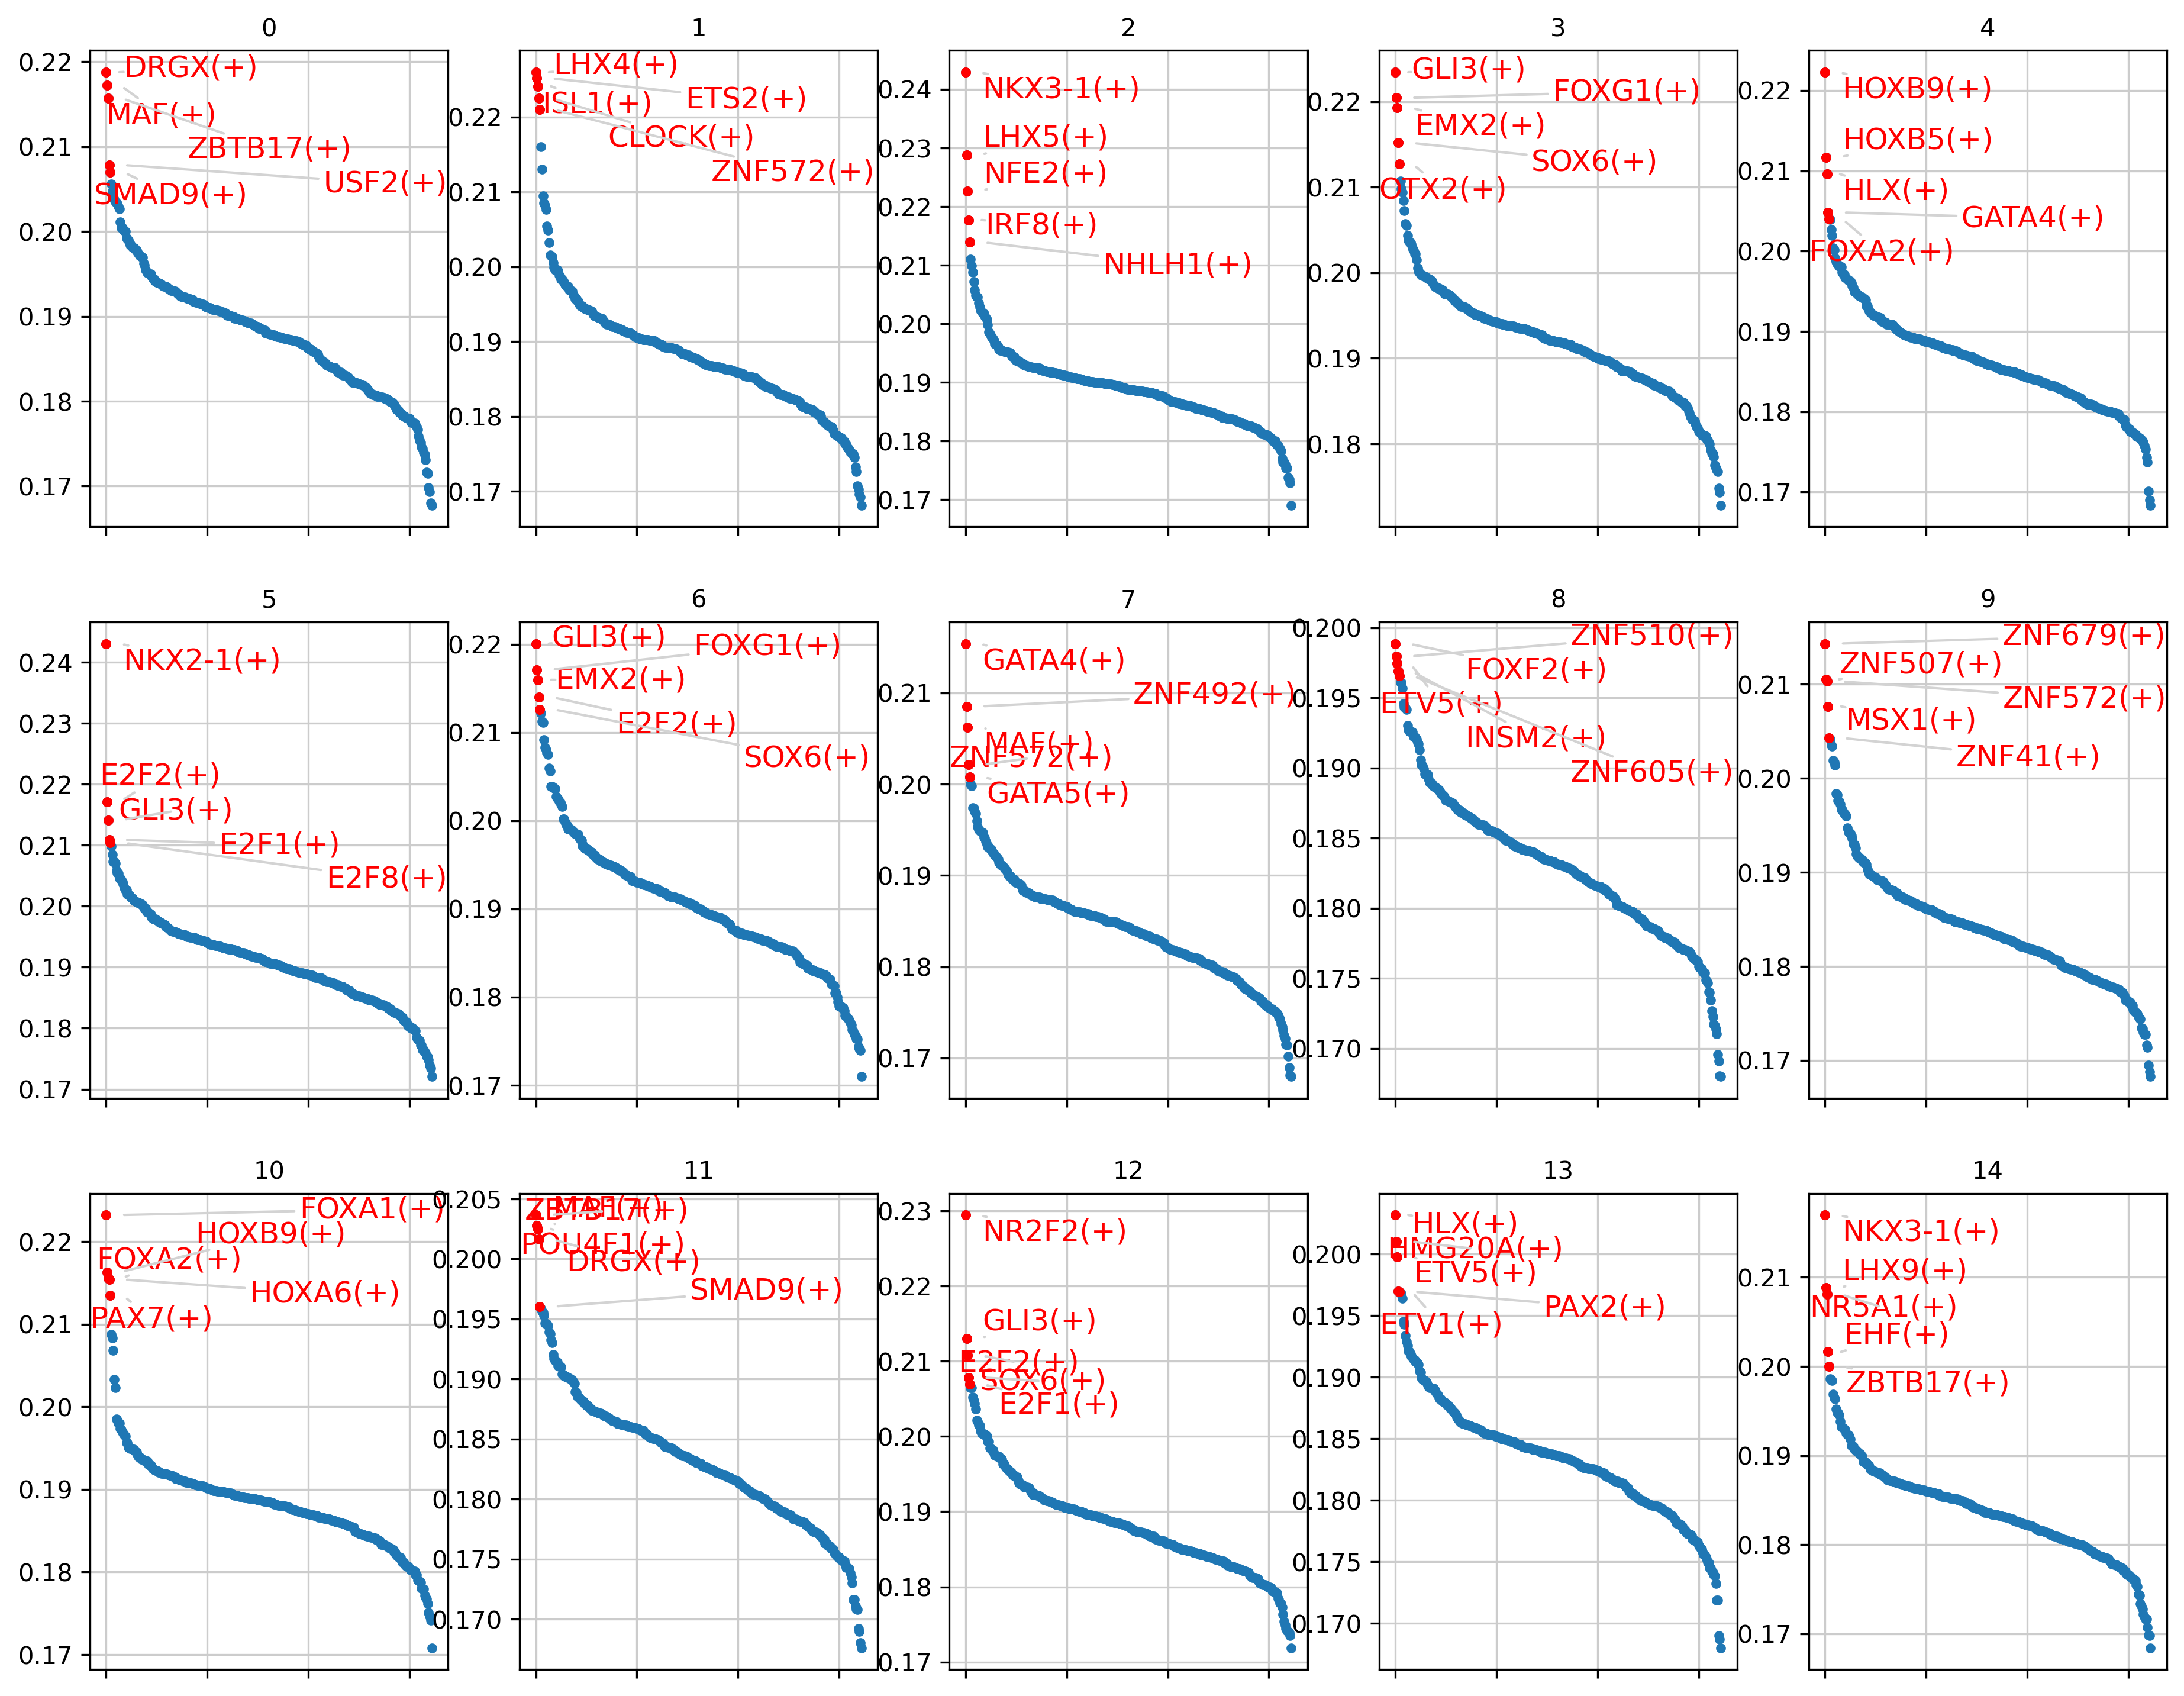

In [107]:
cats = sorted( list(set(meta['leiden_10'])), key=int )

fig = plt.figure(figsize=(15, 12))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_louvain.T[c]
    ax = fig.add_subplot(3,5,num)
    plot_rss(rss_louvain, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )

fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
#plt.savefig("PBMC10k_Louvain-RSS-top5.png", dpi=150, bbox_inches = "tight")
plt.show()

/links/groups/treutlein/USERS/jjans/anaconda3/envs/pyscenic/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


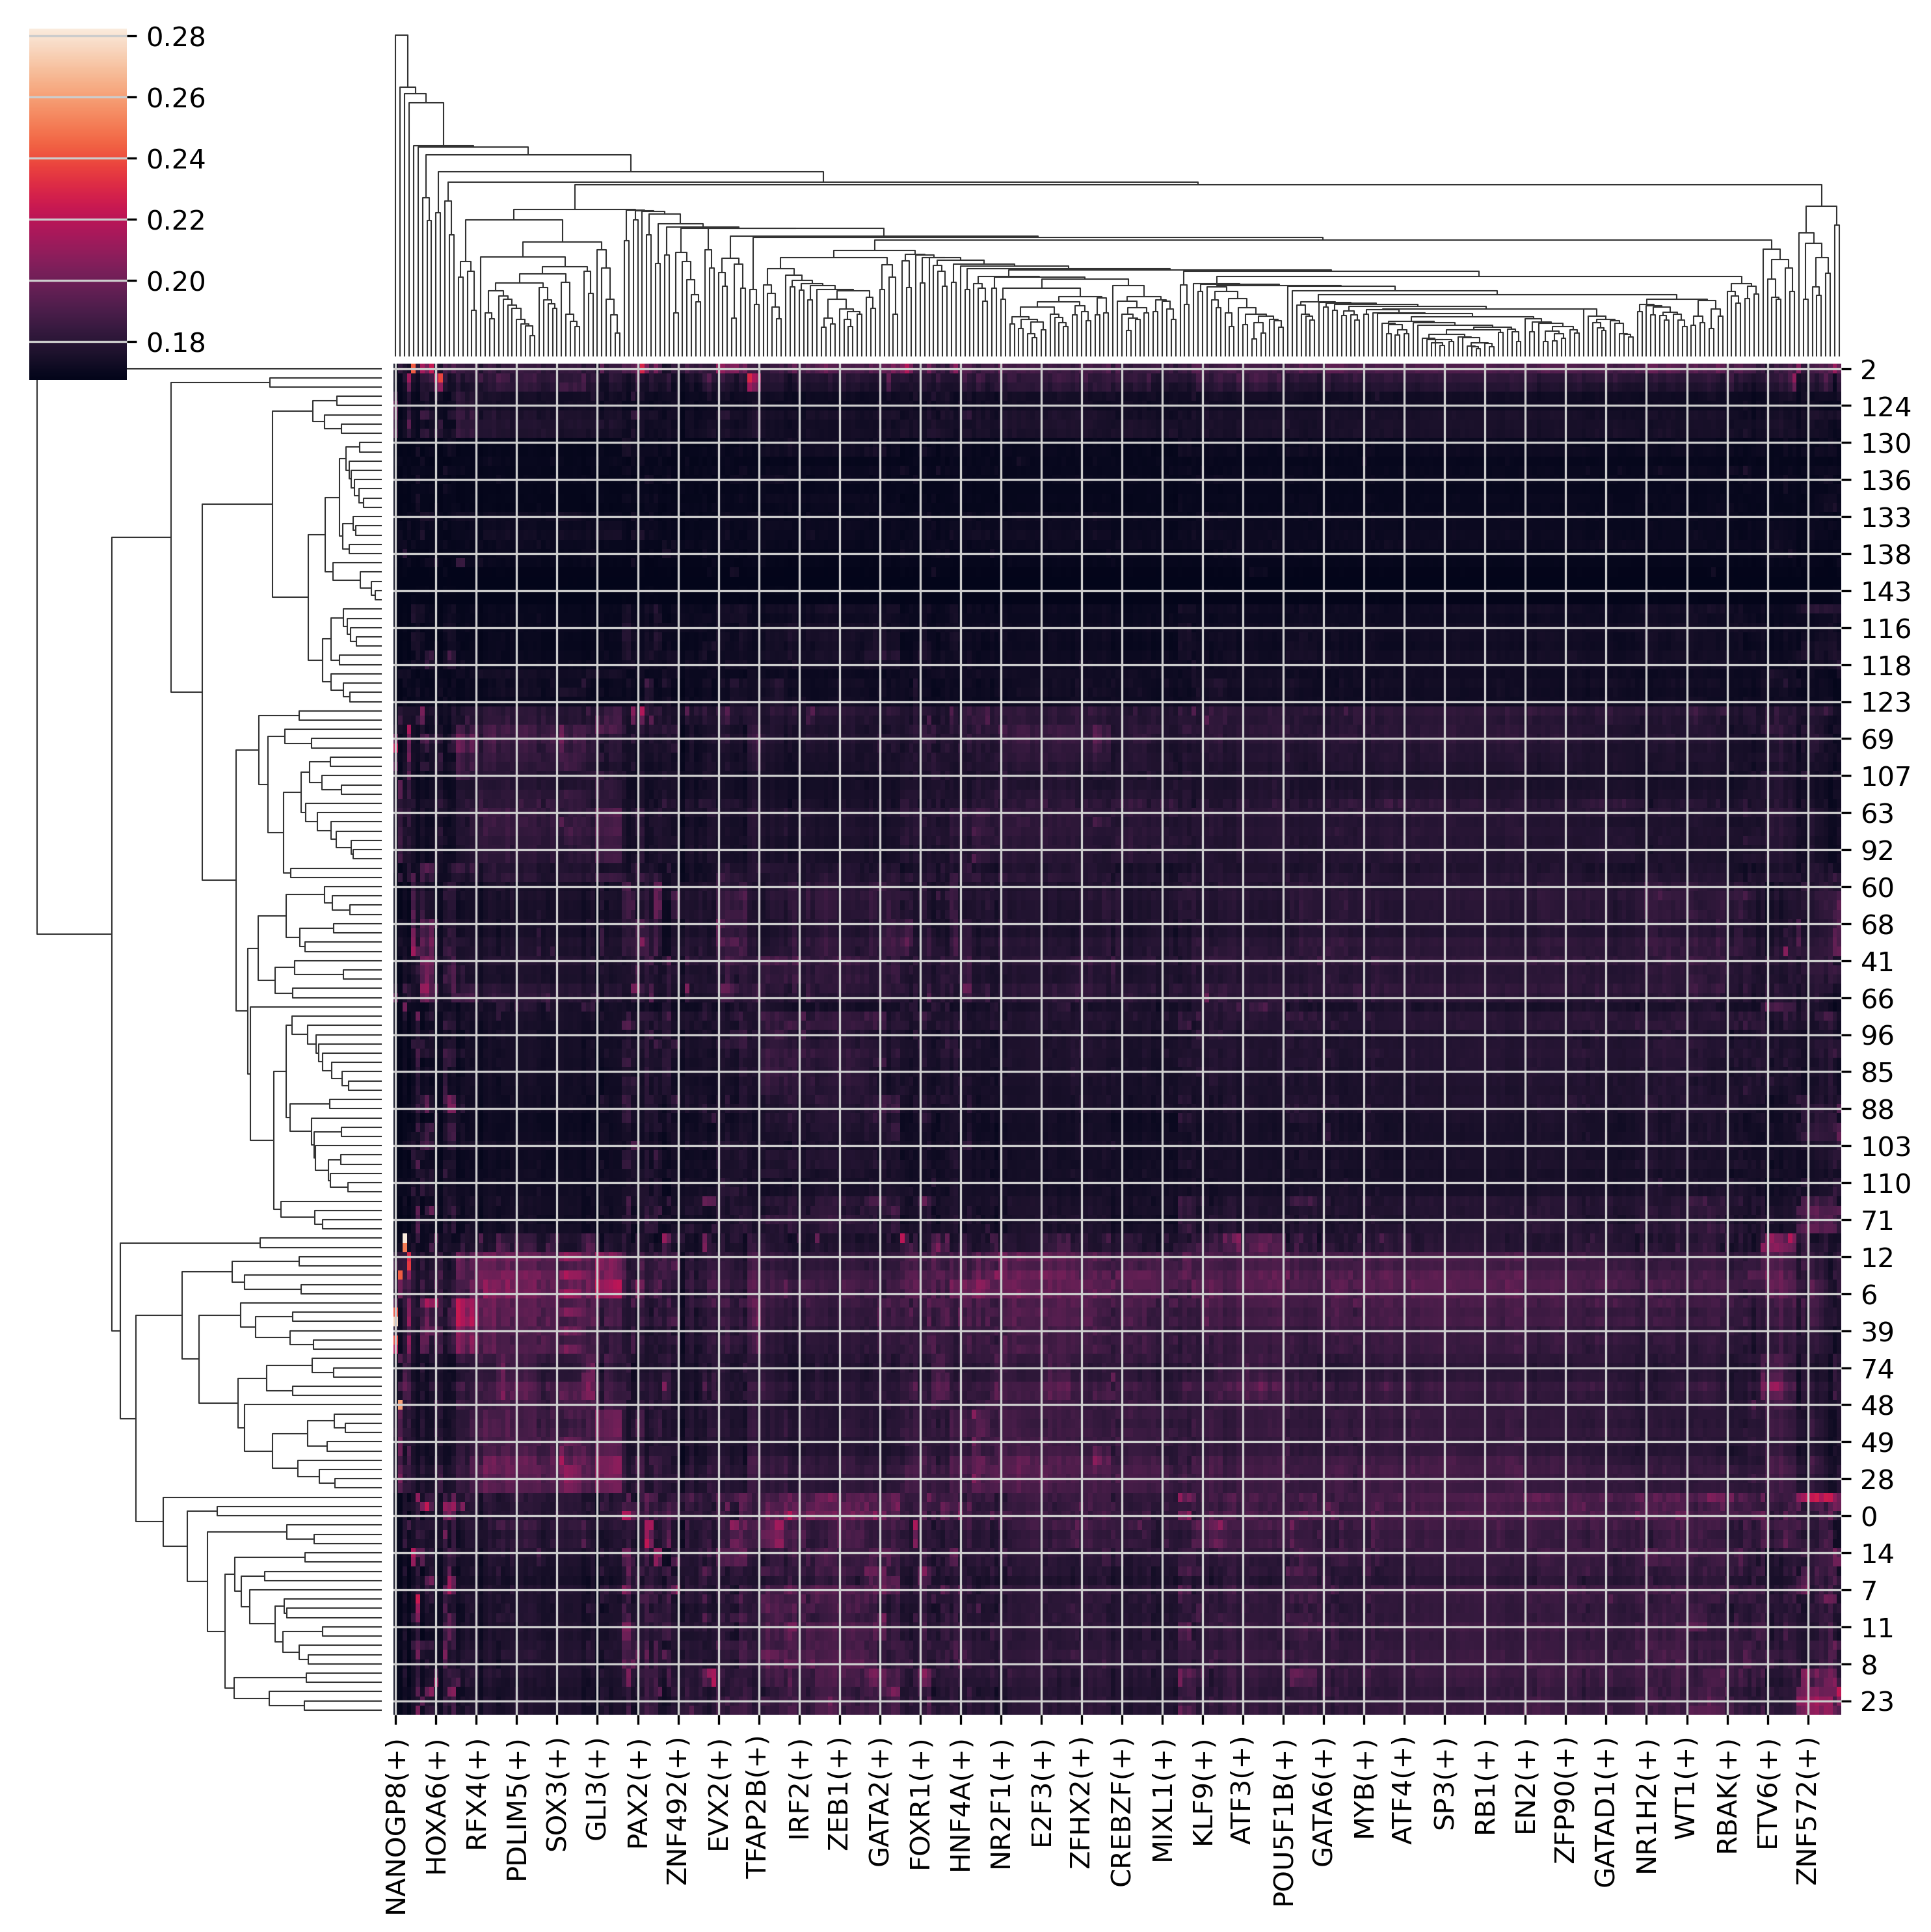

In [109]:
sns.clustermap(rss_louvain)

In [110]:
rss_louvain

ARID3A(+)   ARNT(+)   ATF1(+)   ATF3(+)   ATF4(+)  ATF6B(+)   ATF7(+)  \
104   0.176355  0.174256  0.172007  0.174992  0.172583  0.173459  0.176619   
7     0.189018  0.186692  0.181732  0.184045  0.185467  0.184636  0.190762   
130   0.170082  0.170749  0.169535  0.170171  0.169316  0.169899  0.171997   
23    0.182327  0.182464  0.179207  0.183271  0.182313  0.182455  0.186379   
98    0.174414  0.174122  0.172241  0.174004  0.173077  0.173739  0.178637   
..         ...       ...       ...       ...       ...       ...       ...   
63    0.180389  0.179117  0.181048  0.180697  0.181839  0.179307  0.179771   
94    0.177072  0.177165  0.178958  0.178202  0.179386  0.178189  0.175621   
112   0.174619  0.174186  0.176513  0.174107  0.176045  0.174390  0.173262   
124   0.172133  0.171857  0.173499  0.171979  0.172601  0.172244  0.170917   
101   0.175548  0.176892  0.179140  0.177805  0.177877  0.177118  0.174504   

     BACH1(+)  BACH2(+)  BARX2(+)  ...  ZNF665(+)  ZNF679(+)  ZNF69(+)  \
104  0.174456  0.178786  0.169872  ...   0.169614   0.170483  0.170431   
7    0.186972  0.194083  0.174489  ...   0.181515   0.175349  0.176209   
130  0.169923  0.172339  0.168173  ...   0.169227   0.168821  0.168187   
23   0.185694  0.190255  0.173179  ...   0.174400   0.179668  0.175789   
98   0.174820  0.179458  0.170120  ...   0.172305   0.184466  0.170495   
..        ...       ...       ...  ...        ...        ...       ...   
63   0.180981  0.177329  0.179171  ...   0.180743   0.180155  0.179917   
94   0.179086  0.175126  0.176238  ...   0.177759   0.176760  0.178139   
112  0.175061  0.172808  0.173323  ...   0.173421   0.176781  0.176581   
124  0.172763  0.171068  0.171387  ...   0.171941   0.171746  0.174401   
101  0.176927  0.174165  0.175229  ...   0.182857   0.176314  0.179505   

     ZNF697(+)  ZNF711(+)  ZNF740(+)  ZNF746(+)  ZNF791(+)  ZSCAN30(+)  \
104   0.176024   0.176295   0.190526   0.175413   0.174020    0.176184   
7     0.189164   0.186026   0.177583   0.184759   0.186788    0.190886   
130   0.171048   0.170753   0.168503   0.169617   0.170041    0.170111   
23    0.183431   0.187029   0.205894   0.187681   0.186155    0.180074   
98    0.177959   0.177431   0.172384   0.173462   0.174141    0.174654   
..         ...        ...        ...        ...        ...         ...   
63    0.178774   0.179688   0.175332   0.175677   0.180533    0.178370   
94    0.176954   0.177188   0.173831   0.172792   0.177349    0.177362   
112   0.174394   0.174278   0.170757   0.174289   0.176189    0.173118   
124   0.171650   0.172181   0.169803   0.170345   0.172699    0.171553   
101   0.175433   0.175814   0.173475   0.171795   0.176079    0.176818   

      ZXDC(+)  
104  0.173222  
7    0.188049  
130  0.170007  
23   0.181758  
98   0.177385  
..        ...  
63   0.180737  
94   0.178089  
112  0.175103  
124  0.171981  
101  0.178369  

[146 rows x 323 columns]

orig.ident  nCount_RNA  nFeature_RNA      bc_wells  sample  \
Cell                                                                          
p1_82_61_13__s1          82     13497.0          3998  82_61_13__s1  p1_G10   
p1_22_57_73__s1          22     13178.0          3917  22_57_73__s1  p1_B10   
p1_02_68_65__s1           2     13172.0          3879  02_68_65__s1   p1_A2   
p1_03_29_61__s1           3     13157.0          3946  03_29_61__s1   p1_A3   
p1_88_40_22__s1          88     13096.0          3917  88_40_22__s1   p1_H4   
...                     ...         ...           ...           ...     ...   
p3_96_30_85__s3          96       965.0           811  96_30_85__s3  p3_H12   
p3_81_30_31__s3          81       965.0           794  81_30_31__s3   p3_G9   
p3_60_17_35__s3          60       965.0           700  60_17_35__s3  p3_E12   
p3_96_30_19__s3          96       965.0           794  96_30_19__s3  p3_H12   
p3_39_88_47__s3          39       965.0           802  39_88_47__s3   p3_D3   

                species  gene_count  tscp_count  tscp_count_50dup  read_count  \
Cell                                                                            
p1_82_61_13__s1      hg        3998       13497          34084.86       16907   
p1_22_57_73__s1      hg        3917       13178          33279.27       16423   
p1_02_68_65__s1      hg        3879       13172          33264.11       16516   
p1_03_29_61__s1      hg        3946       13157          33226.23       16565   
p1_88_40_22__s1      hg        3917       13096          33072.19       16525   
...                 ...         ...         ...               ...         ...   
p3_96_30_85__s3      hg         811         965           1830.32        1296   
p3_81_30_31__s3      hg         794         965           1830.32        1304   
p3_60_17_35__s3      hg         700         965           1830.32        1314   
p3_96_30_19__s3      hg         794         965           1830.32        1294   
p3_39_88_47__s3      hg         802         965           1830.32        1297   

                 ... leiden leiden_4 leiden_2  leiden_6  leiden_1  leiden_10  \
Cell             ...                                                           
p1_82_61_13__s1  ...     16       61       18        77        16        104   
p1_22_57_73__s1  ...     15       16       16         5        15          7   
p1_02_68_65__s1  ...      3        6        0         2         3        130   
p1_03_29_61__s1  ...      3       52        0        89         3        130   
p1_88_40_22__s1  ...      5       47        7        45         5         23   
...              ...    ...      ...      ...       ...       ...        ...   
p3_96_30_85__s3  ...      8       30       14        15         8         10   
p3_81_30_31__s3  ...      8       42       14        15         8        112   
p3_60_17_35__s3  ...      6       35       29        26         6         52   
p3_96_30_19__s3  ...      8       42       14        15         8        112   
p3_39_88_47__s3  ...      2       21       12         8         2         65   

                 leiden_8 leiden_3     UMAP_1     UMAP_2  
Cell                                                      
p1_82_61_13__s1        94       17   0.184639   8.605292  
p1_22_57_73__s1         2       14  -5.677590   3.442651  
p1_02_68_65__s1       117        9  -5.582443   0.894187  
p1_03_29_61__s1       117        9  -3.515167   0.232001  
p1_88_40_22__s1        33       43  -3.928701  11.127711  
...                   ...      ...        ...        ...  
p3_96_30_85__s3        59       24   7.716844   5.412450  
p3_81_30_31__s3        84       42   7.629966   5.172922  
p3_60_17_35__s3        57       34   2.355065  -2.338543  
p3_96_30_19__s3        84       42   7.569182   5.123212  
p3_39_88_47__s3        47       20  11.840449  -4.526881  

[483802 rows x 47 columns]

Regulon          ARID3A(+)   ARNT(+)   ATF1(+)   ATF3(+)   ATF4(+)  ATF6B(+)  \
Cell                                                                           
p1_82_61_13__s1   0.054239  0.002308  0.029036  0.052573  0.013923  0.061382   
p1_22_57_73__s1   0.028727  0.065966  0.000000  0.014992  0.019863  0.039702   
p1_02_68_65__s1   0.037622  0.046800  0.049415  0.069819  0.026128  0.173699   
p1_03_29_61__s1   0.034534  0.000000  0.000000  0.033393  0.002248  0.000000   
p1_88_40_22__s1   0.007516  0.018769  0.000000  0.046929  0.022770  0.085348   
...                    ...       ...       ...       ...       ...       ...   
p3_96_30_85__s3   0.060559  0.000000  0.171373  0.013647  0.039862  0.033135   
p3_81_30_31__s3   0.034671  0.019993  0.214042  0.078724  0.030793  0.137905   
p3_60_17_35__s3   0.063045  0.000000  0.124935  0.050352  0.014033  0.315615   
p3_96_30_19__s3   0.036360  0.000000  0.107884  0.013971  0.021132  0.034778   
p3_39_88_47__s3   0.068468  0.000000  0.000000  0.057288  0.074686  0.142965   

Regulon           ATF7(+)  BACH1(+)  BACH2(+)  BARX2(+)  ...  ZNF665(+)  \
Cell                                                     ...              
p1_82_61_13__s1  0.166118  0.012717  0.443204  0.001758  ...   0.000000   
p1_22_57_73__s1  0.156232  0.019105  0.425977  0.000000  ...   0.000000   
p1_02_68_65__s1  0.125574  0.014479  0.386127  0.000000  ...   0.000000   
p1_03_29_61__s1  0.041178  0.025086  0.395699  0.000000  ...   0.000000   
p1_88_40_22__s1  0.082317  0.035527  0.422528  0.017165  ...   0.000000   
...                   ...       ...       ...       ...  ...        ...   
p3_96_30_85__s3  0.023051  0.076610  0.134716  0.000097  ...   0.176172   
p3_81_30_31__s3  0.036491  0.076337  0.151293  0.000101  ...   0.040036   
p3_60_17_35__s3  0.086337  0.032187  0.201404  0.000123  ...   0.049068   
p3_96_30_19__s3  0.024183  0.000000  0.151778  0.000101  ...   0.039943   
p3_39_88_47__s3  0.066358  0.080153  0.179499  0.000099  ...   0.039385   

Regulon          ZNF679(+)  ZNF69(+)  ZNF697(+)  ZNF711(+)  ZNF740(+)  \
Cell                                                                    
p1_82_61_13__s1   0.000000  0.000000   0.082714   0.074922   0.304113   
p1_22_57_73__s1   0.000000  0.000000   0.083482   0.090786   0.000000   
p1_02_68_65__s1   0.000000  0.029444   0.147720   0.101049   0.010241   
p1_03_29_61__s1   0.012274  0.027053   0.069501   0.079064   0.098768   
p1_88_40_22__s1   0.000000  0.000000   0.070812   0.092156   0.083548   
...                    ...       ...        ...        ...        ...   
p3_96_30_85__s3   0.000000  0.000000   0.033487   0.084121   0.000689   
p3_81_30_31__s3   0.000000  0.000000   0.092563   0.150086   0.000938   
p3_60_17_35__s3   0.000000  0.000000   0.033952   0.080557   0.027837   
p3_96_30_19__s3   0.000000  0.000000   0.028494   0.067237   0.000879   
p3_39_88_47__s3   0.000000  0.000000   0.130678   0.067675   0.000777   

Regulon          ZNF746(+)  ZNF791(+)  ZSCAN30(+)   ZXDC(+)  
Cell                                                         
p1_82_61_13__s1   0.000000   0.024423    0.106988  0.007478  
p1_22_57_73__s1   0.083066   0.030991    0.014532  0.049796  
p1_02_68_65__s1   0.000000   0.070084    0.057468  0.009494  
p1_03_29_61__s1   0.002569   0.011735    0.050140  0.084272  
p1_88_40_22__s1   0.000000   0.048047    0.042113  0.011163  
...                    ...        ...         ...       ...  
p3_96_30_85__s3   0.053023   0.090775    0.000000  0.074872  
p3_81_30_31__s3   0.054272   0.071636    0.000000  0.070600  
p3_60_17_35__s3   0.279143   0.112704    0.000000  0.037715  
p3_96_30_19__s3   0.054350   0.133467    0.000000  0.116749  
p3_39_88_47__s3   0.053491   0.070788    0.042684  0.054858  

[483802 rows x 323 columns]

In [101]:
meta

orig.ident  nCount_RNA  nFeature_RNA      bc_wells  sample  \
p1_82_61_13__s1          82     13497.0          3998  82_61_13__s1  p1_G10   
p1_22_57_73__s1          22     13178.0          3917  22_57_73__s1  p1_B10   
p1_02_68_65__s1           2     13172.0          3879  02_68_65__s1   p1_A2   
p1_03_29_61__s1           3     13157.0          3946  03_29_61__s1   p1_A3   
p1_88_40_22__s1          88     13096.0          3917  88_40_22__s1   p1_H4   
...                     ...         ...           ...           ...     ...   
p3_96_30_85__s3          96       965.0           811  96_30_85__s3  p3_H12   
p3_81_30_31__s3          81       965.0           794  81_30_31__s3   p3_G9   
p3_60_17_35__s3          60       965.0           700  60_17_35__s3  p3_E12   
p3_96_30_19__s3          96       965.0           794  96_30_19__s3  p3_H12   
p3_39_88_47__s3          39       965.0           802  39_88_47__s3   p3_D3   

                species  gene_count  tscp_count  tscp_count_50dup  read_count  \
p1_82_61_13__s1      hg        3998       13497          34084.86       16907   
p1_22_57_73__s1      hg        3917       13178          33279.27       16423   
p1_02_68_65__s1      hg        3879       13172          33264.11       16516   
p1_03_29_61__s1      hg        3946       13157          33226.23       16565   
p1_88_40_22__s1      hg        3917       13096          33072.19       16525   
...                 ...         ...         ...               ...         ...   
p3_96_30_85__s3      hg         811         965           1830.32        1296   
p3_81_30_31__s3      hg         794         965           1830.32        1304   
p3_60_17_35__s3      hg         700         965           1830.32        1314   
p3_96_30_19__s3      hg         794         965           1830.32        1294   
p3_39_88_47__s3      hg         802         965           1830.32        1297   

                 ... leiden leiden_4 leiden_2  leiden_6  leiden_1  leiden_10  \
p1_82_61_13__s1  ...     16       61       18        77        16        104   
p1_22_57_73__s1  ...     15       16       16         5        15          7   
p1_02_68_65__s1  ...      3        6        0         2         3        130   
p1_03_29_61__s1  ...      3       52        0        89         3        130   
p1_88_40_22__s1  ...      5       47        7        45         5         23   
...              ...    ...      ...      ...       ...       ...        ...   
p3_96_30_85__s3  ...      8       30       14        15         8         10   
p3_81_30_31__s3  ...      8       42       14        15         8        112   
p3_60_17_35__s3  ...      6       35       29        26         6         52   
p3_96_30_19__s3  ...      8       42       14        15         8        112   
p3_39_88_47__s3  ...      2       21       12         8         2         65   

                 leiden_8 leiden_3     UMAP_1     UMAP_2  
p1_82_61_13__s1        94       17   0.184639   8.605292  
p1_22_57_73__s1         2       14  -5.677590   3.442651  
p1_02_68_65__s1       117        9  -5.582443   0.894187  
p1_03_29_61__s1       117        9  -3.515167   0.232001  
p1_88_40_22__s1        33       43  -3.928701  11.127711  
...                   ...      ...        ...        ...  
p3_96_30_85__s3        59       24   7.716844   5.412450  
p3_81_30_31__s3        84       42   7.629966   5.172922  
p3_60_17_35__s3        57       34   2.355065  -2.338543  
p3_96_30_19__s3        84       42   7.569182   5.123212  
p3_39_88_47__s3        47       20  11.840449  -4.526881  

[483802 rows x 47 columns]

In [ ]:
from math import sqrt

import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon


def regulon_specificity_scores(auc_mtx, cell_type_series):
    """
    Calculates the Regulon Specificty Scores (RSS). [doi: 10.1016/j.celrep.2018.10.045]
    :param auc_mtx: The dataframe with the AUC values for all cells and regulons (n_cells x n_regulons).
    :param cell_type_series: A pandas Series object with cell identifiers as index and cell type labels as values.
    :return: A pandas dataframe with the RSS values (cell type x regulon).
    """

    cell_types = list(cell_type_series.unique())
    n_types = len(cell_types)
    regulons = list(auc_mtx.columns)
    n_regulons = len(regulons)
    rss_values = np.empty(shape=(n_types, n_regulons), dtype=np.float)

    def rss(aucs, labels):
        # jensenshannon function provides distance which is the sqrt of the JS divergence.
        return 1.0 - jensenshannon(aucs / aucs.sum(), labels / labels.sum())

    for cidx, regulon_name in enumerate(regulons):
        for ridx, cell_type in enumerate(cell_types):
            rss_values[ridx, cidx] = rss(
                auc_mtx[regulon_name], (cell_type_series == cell_type).astype(int)
            )

    return pd.DataFrame(data=rss_values, index=cell_types, columns=regulons)


/links/groups/treutlein/USERS/jjans/anaconda3/envs/pyscenic/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


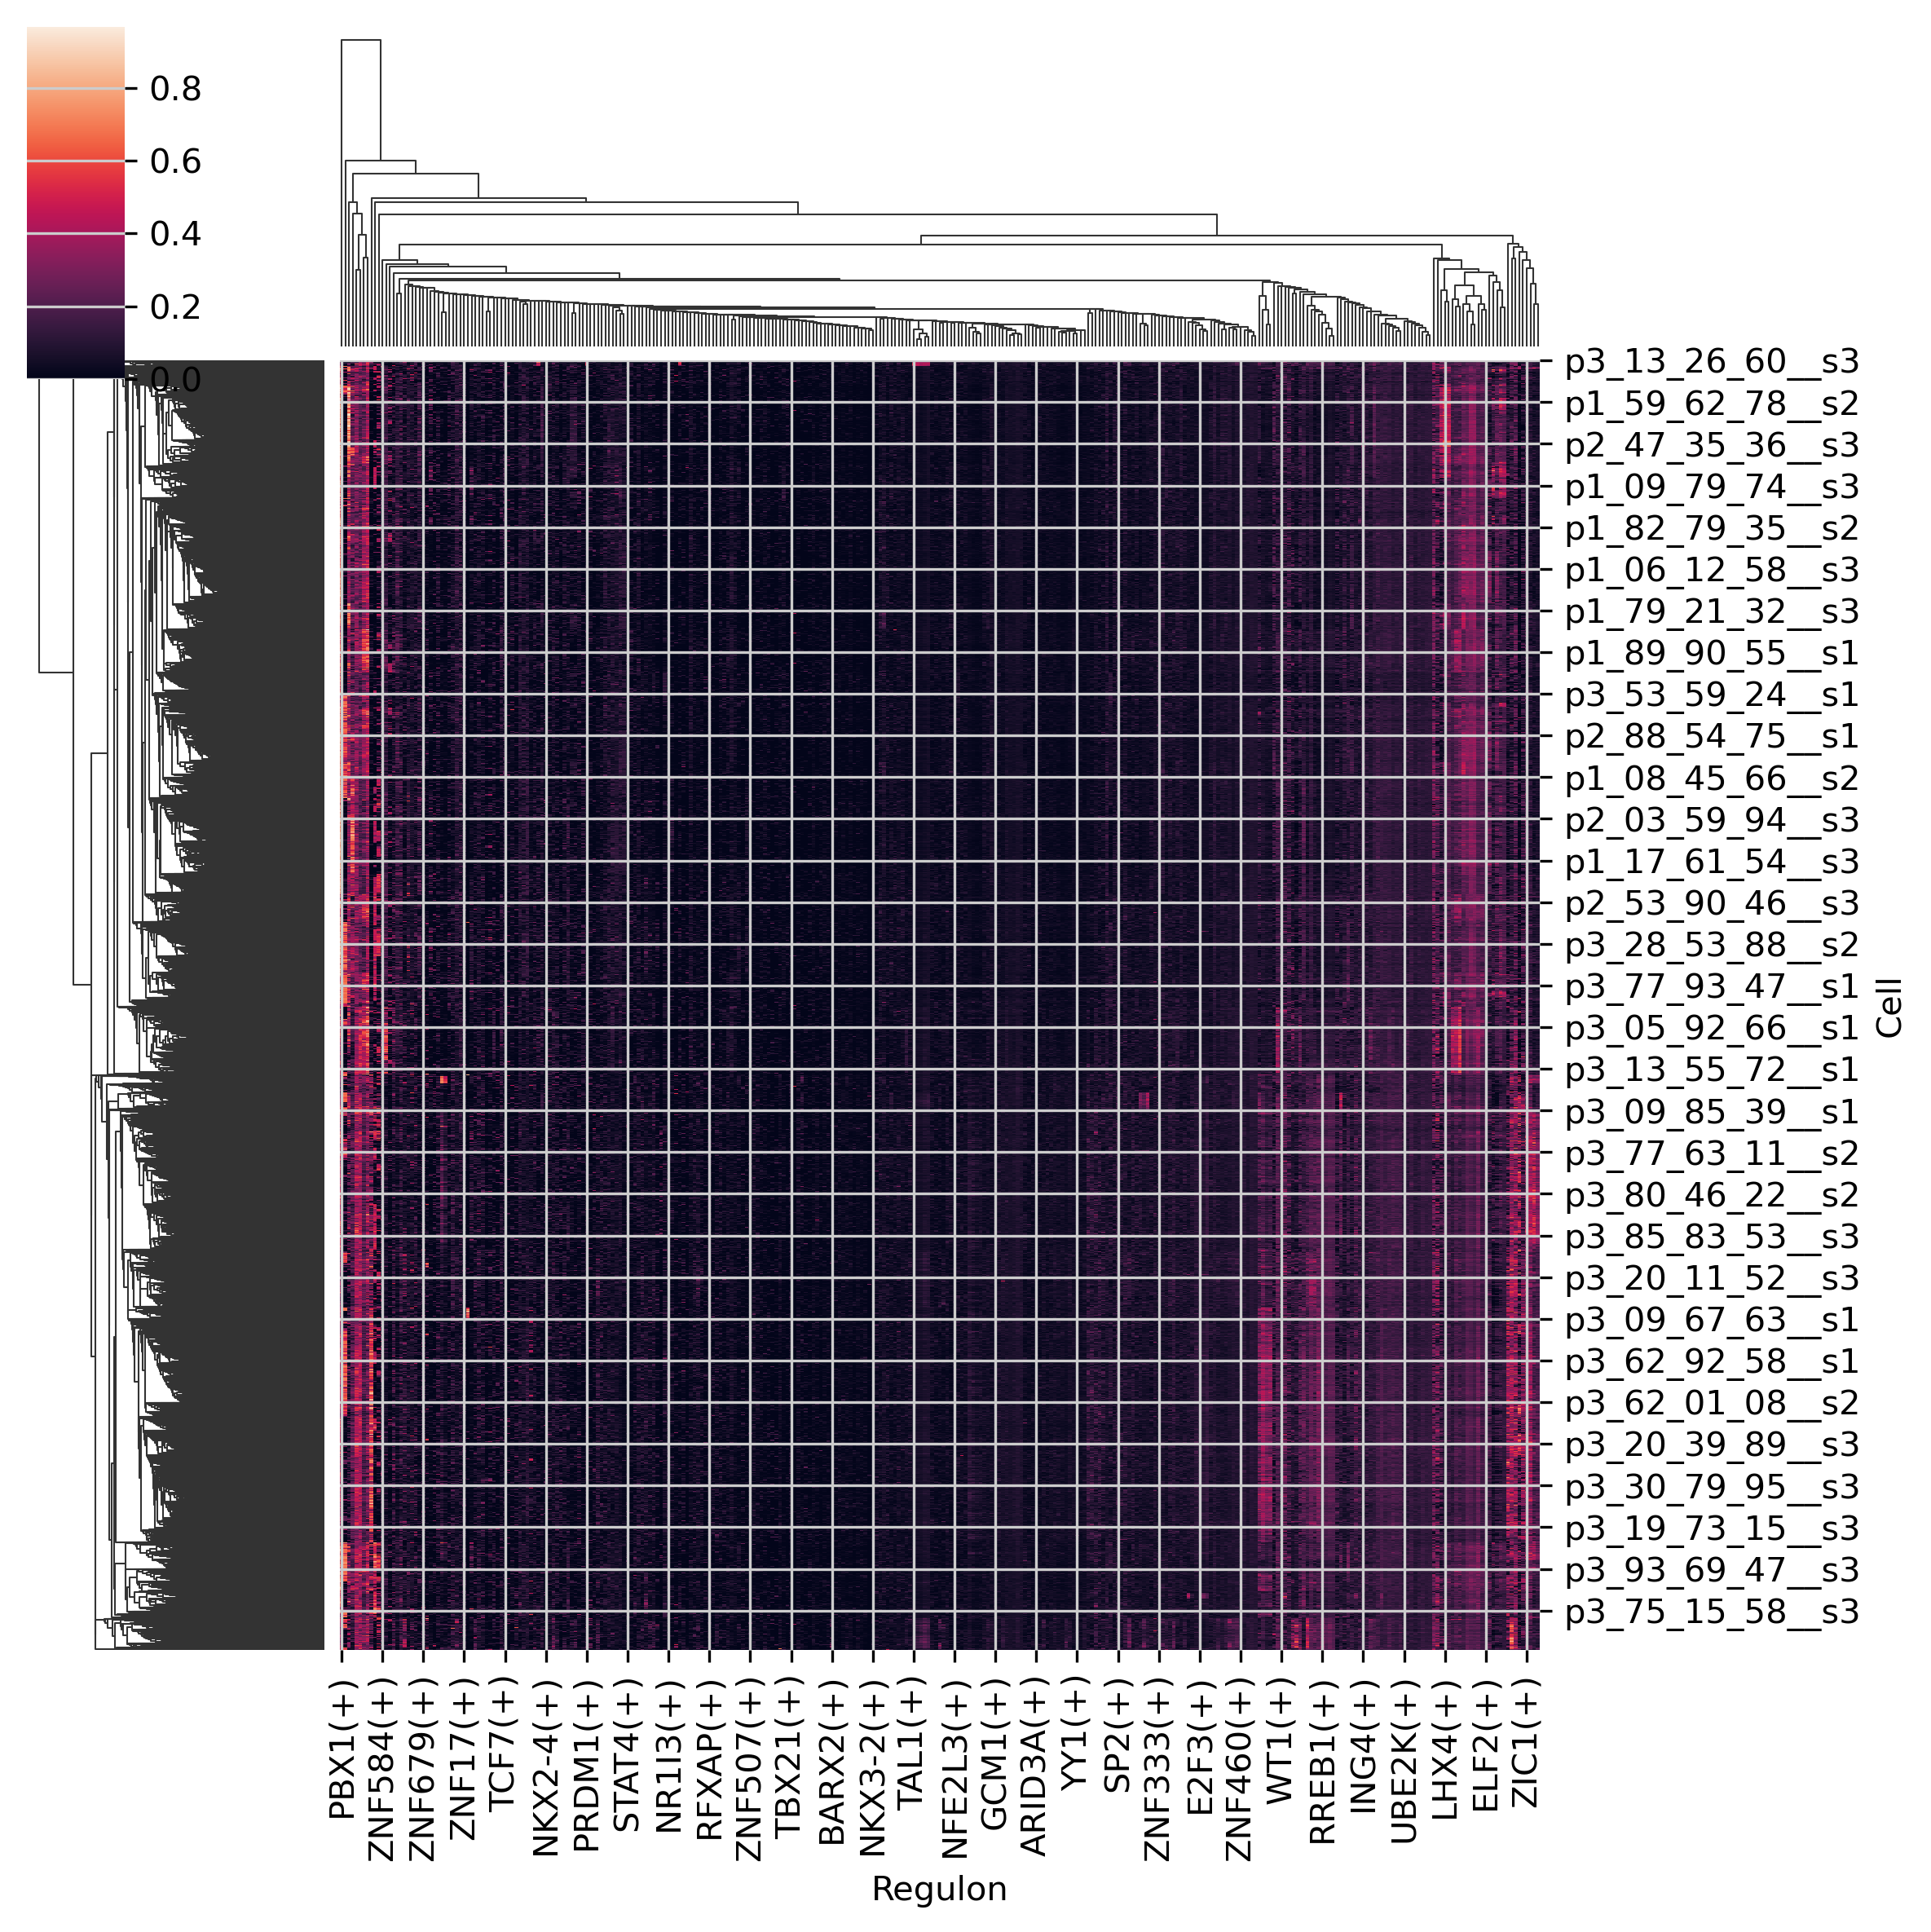

In [87]:
sns.clustermap(auc_mtx, figsize=(8,8))

In [88]:
dgem

TSPAN6  TNMD  DPM1  SCYL3  C1orf112  FGR  CFH  FUCA2  GCLC  \
p1_02_78_85__s1     0.0   0.0   1.0    0.0       0.0  0.0  0.0    0.0   0.0   
p1_02_20_87__s1     0.0   0.0   1.0    0.0       0.0  0.0  0.0    0.0   0.0   
p1_36_61_14__s1     0.0   0.0   0.0    0.0       0.0  0.0  0.0    0.0   0.0   
p1_69_65_02__s1     0.0   0.0   0.0    1.0       0.0  0.0  0.0    0.0   0.0   
p1_16_15_39__s1     0.0   0.0   0.0    1.0       0.0  0.0  0.0    0.0   1.0   
...                 ...   ...   ...    ...       ...  ...  ...    ...   ...   
p3_80_83_24__s3     0.0   0.0   0.0    0.0       0.0  0.0  0.0    0.0   1.0   
p3_25_30_70__s3     0.0   0.0   0.0    0.0       0.0  0.0  0.0    0.0   0.0   
p3_66_29_42__s3     0.0   0.0   0.0    0.0       0.0  0.0  0.0    0.0   0.0   
p3_66_12_78__s3     0.0   0.0   0.0    0.0       0.0  0.0  0.0    0.0   0.0   
p3_15_12_16__s3     0.0   0.0   0.0    0.0       0.0  0.0  0.0    0.0   0.0   

                 NFYA  ...  AL049541.2  LINC00891  BISPR  TRBV7-2  AC242022.1  \
p1_02_78_85__s1   0.0  ...         0.0        0.0    0.0      0.0         0.0   
p1_02_20_87__s1   2.0  ...         0.0        0.0    0.0      0.0         0.0   
p1_36_61_14__s1   0.0  ...         0.0        0.0    0.0      0.0         0.0   
p1_69_65_02__s1   0.0  ...         0.0        0.0    0.0      0.0         0.0   
p1_16_15_39__s1   0.0  ...         0.0        0.0    0.0      0.0         0.0   
...               ...  ...         ...        ...    ...      ...         ...   
p3_80_83_24__s3   0.0  ...         0.0        0.0    0.0      0.0         0.0   
p3_25_30_70__s3   0.0  ...         0.0        0.0    0.0      0.0         0.0   
p3_66_29_42__s3   0.0  ...         0.0        0.0    0.0      0.0         0.0   
p3_66_12_78__s3   0.0  ...         0.0        0.0    0.0      0.0         0.0   
p3_15_12_16__s3   0.0  ...         0.0        0.0    0.0      0.0         0.0   

                 AC109462.3  TCAF2C  ETDC  AC005551.1  AC093827.4  
p1_02_78_85__s1         0.0     0.0   0.0         0.0         0.0  
p1_02_20_87__s1         0.0     0.0   0.0         0.0         0.0  
p1_36_61_14__s1         0.0     0.0   0.0         0.0         0.0  
p1_69_65_02__s1         0.0     0.0   0.0         0.0         0.0  
p1_16_15_39__s1         0.0     0.0   0.0         0.0         0.0  
...                     ...     ...   ...         ...         ...  
p3_80_83_24__s3         0.0     0.0   0.0         0.0         0.0  
p3_25_30_70__s3         0.0     0.0   0.0         0.0         0.0  
p3_66_29_42__s3         0.0     0.0   0.0         0.0         0.0  
p3_66_12_78__s3         0.0     0.0   0.0         0.0         0.0  
p3_15_12_16__s3         0.0     0.0   0.0         0.0         0.0  

[14109 rows x 31916 columns]